In [14]:
from Predict_lc import PredictLightCurve

In [15]:
import numpy as np
from dataframe import Data
from io_utils import *
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
import pandas as pd

In [16]:
from ipywidgets import FloatProgress
from tqdm.notebook import tqdm

In [17]:
dataset = "ZTF"
#train_ob = load_ztf_train_data(head_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_master_HEAD.FITS', phot_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_master_PHOT.FITS')
#test_ob = load_ztf_test_data(head_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_master_HEAD.FITS', phot_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_master_PHOT.FITS')
train_ob = load_ztf_train_data()
test_ob = load_ztf_test_data()
train_object_ids = train_ob.get_all_object_ids()
train_kilonova_ids = train_ob.get_ids_of_event_type([150,151])
train_ob.df_data.sort(['SNID','MJD'])
train_ob.df_metadata.sort(['SNID'])

test_object_ids = test_ob.get_all_object_ids()
test_kilonova_ids = test_ob.get_ids_of_event_type(150)
test_kilonova_ids = vstack([test_kilonova_ids, test_ob.get_ids_of_event_type(151)])
test_kilonova_ids = test_kilonova_ids['SNID']
test_ob.df_data.sort(['SNID','MJD'])
test_ob.df_metadata.sort(['SNID'])

num_pc_components = 5
bands = ['g', 'r']
color_band_dict = {'g':'C2', 'r':'C3'}

In [18]:
print(train_kilonova_ids)

   SNID  
---------
 21688386
 15113109
 10708981
 13585523
  7607910
  9881401
 16197876
 16545088
 12489731
  4022551
      ...
 50352467
133395303
 88455594
 87140466
 41145506
 55269380
 26956640
 68715807
 35214906
 55742428
 54967150
Length = 1000 rows


In [19]:
def multi_mrocessor():
    coeff_dict, num_pts_dict = pc.predict_lc_coeff(current_date=current_date,num_pc_components=num_pc_components, decouple_pc_bands=decouple_pc_bands, decouple_prediction_bands=decouple_prediction_bands, min_flux_threshold=min_flux_threshold, bands=bands)
        

In [20]:
def create_features_df(data_ob, decouple_prediction_bands=True, decouple_pc_bands=False, mark_maximum=False, min_flux_threshold=20, num_pc_components=3, use_random_current_date= False, plot_prediction = False):
    data_dict = {'id':[],
                 'type':[],}
    
    object_ids = data_ob.get_all_object_ids()
    #data_object_ids = np.random.permutation(data_object_ids)
    data_ob.df_data.sort([data_ob.object_id_col_name,data_ob.time_col_name])
    for object_id in tqdm(object_ids):
        event_df = data_ob.get_data_of_event(object_id)
        #print(event_df['FLT'])
        pc = PredictLightCurve(data_ob, object_id=object_id, num_pc_components=num_pc_components)
        #print(pc.lc.df['FLT'])
        #print(pc.lc.band_map.items())
        #print("------------")
        current_date = None
        if use_random_current_date:
            median_date = np.median(pc.lc.dates_of_maximum)
            current_date = median_date+random()*50-25
            
        coeff_dict, num_pts_dict = pc.predict_lc_coeff(current_date=current_date,num_pc_components=num_pc_components, decouple_pc_bands=decouple_pc_bands, decouple_prediction_bands=decouple_prediction_bands, min_flux_threshold=min_flux_threshold, bands=bands)
        data_dict['id'].append(object_id)
        #print(data_dict['object_id'])
        for i,band in enumerate(bands):
            for j in range(1,num_pc_components+1):
                col_name = str(i)+'pc'+str(j)
                print(col_name)
                if col_name not in data_dict.keys():
                    data_dict[col_name] = []
                data_dict[col_name].append(coeff_dict[band][j-1])
            col_name = str(i)+'n'
            if col_name not in data_dict.keys():
                    data_dict[col_name] = []
            data_dict[col_name].append(num_pts_dict[band])
        object_type = data_ob.get_object_type_number(object_id)
        data_dict['type'].append(object_type)
        if plot_prediction:
            fig = pc.plot_predicted_bands(all_band_coeff_dict=coeff_dict, color_band_dict=color_band_dict, mark_maximum=mark_maximum,axes_lims = False)
            plt.show()
            plt.close('all')

    data_df = pd.DataFrame(data_dict)
    data_df = data_df.sample(frac=1).reset_index(drop=True)
    return data_df
        

In [21]:
train_df = create_features_df(train_ob, num_pc_components=5, plot_prediction = False)
test_df = create_features_df(test_ob, num_pc_components=5)

[190.92358759 -45.66531455 -14.2767456  160.98564493  65.85837629]
[ 158.34696986 -273.97843571 -180.04556565  137.76893951  -16.07009232]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 405.95748365   -5.01079315 -243.40621137  -45.00001484  108.25534238]
[ 503.8834585  -224.71429997 -389.13132023  322.47526104   73.39154116]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5923.13667017  1899.23895579    53.92441143 -2499.00439565
 -3363.2199245 ]
[ 9433.97363948  3232.79112849   -36.73757463 -3913.01356547
 -5224.0787508 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2419.79556401 -132.99432159 -947.66985518  245.19068558 -193.6566006 ]
[2483.40904879  -29.18546259 -908.10692807   78.91016736  -36.21132839]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1838.25569873 -603.57539584  231.27289057 -263.13908825  -68.56528141]
[1203.64143864 -326.44095702   79.64534243 -162.20864294  -77.97740038]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 645.35921325 -457.657

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 414.02614677 -396.12204748 -324.7330541   380.29834692   12.57113257]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 388.44753695  -85.92926381 -222.95126047  283.6813803   168.50906882]
[ 2022.87889022 -1124.73255237  -908.7610237   1126.69398393
   -15.77642423]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 531.88744186  110.10402262  179.07424242  -63.83278806 -306.74077064]
[2236.67058254   22.05760398 -841.74944637  339.57472289   21.5122974 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 279.92311092 -183.71932185 -208.25450976  287.4935074    14.44169959]
[ 943.00424897 -664.53011737 -611.06806091  542.68970707  197.6384723 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2314.49673138 -2448.58174555 -1388.36043575  2119.79470667
  -341.5774567 ]
[ 2749.36446132 -3013.29959158 -1692.44253686  2696.87674955
  -573.62604249]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 117.39377657 -124.72214068  -94.45694848   39.31828512   84.28160115]
[ 580.759241

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[14135.8161675  -1501.16001289  -813.92437473  1184.85691417
    51.58278338]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 621.3198023  -253.42154472 -284.31321564  269.86583013  239.53896266]
[1075.59722734  202.43166022  130.15617966  163.20816367   89.55565472]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 267.52030044  -88.04516889  -90.99865765 -171.56392915   79.92167731]
[ 938.29085332 -178.05070443 -233.78455014 -154.7701955   324.86870253]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 313.16007233 -230.88417019   75.0490756   260.82140601 -100.42832281]
[ 589.67826893 -231.70731923 -478.76260116  272.71733225  193.2350006 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 360.89198728 -306.79125188  -42.5177795   141.78446054  -17.77234023]
[ 993.48727373 -169.41491032 -243.05417977  105.11493953  157.74098752]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 177.21762223 -242.62963757   29.26577941   45.5475386  -170.10584236]
[ 318.41204093 -575.2535

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2189.53361366 -334.77359229 -948.01896878  245.79401178  -60.24866837]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5695.30617228 -3179.40691624  -322.65462849 -1580.2489071
   563.04061266]
[ 3611.93726194 -2485.31537697  -379.47824626 -1337.70160871
  1044.53470412]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 161.8567868  -101.05563652 -183.65500628  169.38753475   10.18891188]
[ 430.37798493 -392.98280486 -242.92438816  378.87385255 -223.14316814]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 539.75832756 -185.47230468   66.58763251   31.52776958  155.32734903]
[1133.03006495 -312.35675179  221.58502305  -54.97351173  150.30925259]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3721.89947488 -888.22979064  531.48113361 -351.5170026  -183.30342624]
[2623.50710995 -634.08160048  382.81575428 -331.13065857   -3.51137376]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1068.27973473 -748.66921642 -442.76308276  229.19734792 -207.04638633]
[1978.91284761 -315

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[3629.33322888 -990.13054091  897.91068234   97.38491166 -290.46381811]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 251.46753479 -261.80657971 -125.59874485  211.56709802    3.93333888]
[ 1639.01999613  -301.06935131 -1359.82153998   758.82868516
   860.28385666]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[148.63485893 -92.67556793   3.5785997  183.22084712 -70.93594584]
[ 102.92216554 -107.54373988 -139.53201197  171.37811947   -0.40654536]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1481.94887395  375.32671269 1088.74104161  781.08454114  730.55389123]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2251.49199006   54.2500839  -928.2337597    83.25586616  277.57507353]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1805.80695659 -1217.25752624  -697.46758674    42.87684634
   303.59155278]
[2612.15424787 -837.73971542 -317.91692668  293.15597218 -219.51169053]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 104.88383211 -215.48341018   -4.53885524   55.18336849  -90.51668303]
[ 282.16717423 -216.17069536 -193.52956956  209.14450666   65.43076942]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[10797.35076377 -1211.50371793 13272.6713683   2781.7090409
  2941.06118423]
[ 2573.63399016 -4669.74390616   474.18614557 -1537.24055201
   862.16544215]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 437.04759481 -281.80072284 -308.70594955  307.73252633   94.11716032]
[ 586.75564841 -233.21773814 -522.93471685  281.28994969  294.29545749]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9243.76461503 -7880.27480252 -3089.7784315     67.84482735
   659.7184293 ]
[15036.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2767.34091063  -436.34242838 -2202.86567828  1294.87344022
  1365.24025201]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 620.48909713 -418.6542309  -293.39359076  383.83333323 -226.47047346]
[ 968.13388346 -796.85471692 -577.68901985  796.08834612 -180.04079069]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1819.38670523  513.20287089 -346.05360437 -584.13967507 -357.1026708 ]
[1824.73164308  633.53697901  299.06051023 -486.73930621 -522.80217475]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 384.93157867 -319.91291962 -184.49621283  338.28476566  124.03913879]
[ 474.34523403 -470.48952008 -349.79531118  426.4190162    64.86161515]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 164.36464103  -44.75225645 -173.98745463  193.964649     51.19373114]
[ 557.00915678 -212.68464472 -459.97184158  415.13499213  118.52392148]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1028.00670883 -654.2635962  -249.59767922  263.38749076  221.22409379]
[1772.95317186 -475.3862

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 405.7375379  -288.8797304  -307.07714294  481.35901926  -17.21002229]
[ 578.85126818 -171.50937712 -428.24492893  589.30322383   96.84202452]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1097.64182431 -279.08508761 -217.78167622   35.80104645 -139.6065769 ]
[1751.72382769  -37.76711626  436.21729495  350.08125636   10.58876081]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2572.12302127 -2511.16168884 -1106.82887874  -583.00858623
  1597.05174488]
[ 2624.79851063  -553.52118919 -1911.62408262   972.19893455
  1355.11198923]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 50.98227157 -44.12068272 -57.37516851 135.90775791 -56.6270173 ]
[ 320.16869358  -37.36137189 -227.86146601  158.54579624    7.97176406]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1099.6134704  -397.19613085 -184.68143662  -25.97559871 -541.6944051 ]
[ 512.54191188 -473.6728057  -326.66380355  427.44149006  -33.57001799]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 218.73671396 -392.847

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1512.70371876 -742.92803    -864.92546405 -256.68039488 1148.41697884]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 287.93046102 -154.44440002 -152.02409618  150.79099521  -62.9805029 ]
[ 242.68281344 -162.60004014   -4.33586059  303.5419751    33.42639223]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1131.96457338 -283.6991633  -213.97929688  169.38471419 -258.76088355]
[1922.35966753 -406.58369458  -44.20481169 -166.16075936 -119.71516393]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4543.08924866 -1773.14245441 -3354.09729199  2759.94791755
  2216.31232831]
[ 3202.30340552 -2263.94398693 -2336.57780613  2301.66884798
   643.78287557]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1021.64572932 -605.65151785 -862.4262886   356.10831807  243.62421328]
[ 2718.42063577  -221.1125205  -2137.93822687   752.08050913
  1433.47652815]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 621.35156325   -2.485464   -327.8846146   169.24031136 -134.83666769]
[1466.145780

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[  834.11826758 -1054.21224208   -13.61282957   -92.90264005
   -10.84135468]
[ 1934.82773302 -1307.32756334   106.37479791  -509.80918869
  -100.10785808]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 468.79866547 -299.79754096  -78.36968977  249.80820146  186.05915205]
[ 803.1042586  -334.80066753  -43.83913008 -117.82221507   97.7977324 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 853.75597107 -726.3690871  -292.39837467 -223.93817493   96.44088285]
[ 1411.04631237 -1080.0478179   -419.38546005  -231.88440113
   152.41205733]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[5778.46045352 1363.97001632 2264.03877533 2308.72704183 3472.9936969 ]
[2016.65175897   41.05853808  874.54335886 1097.96558989  717.46498374]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 575.96632901 -226.58205406 -412.82502146  403.59149585  -10.56052752]
[1336.15359014 -531.501191   -717.12877813  795.90300607  174.40313113]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 3158.92484178 -1259.84826241  -343.8058811  -1575.28815406
   155.9524409 ]
[ 3066.55936343 -1500.47078887  -476.28290645 -1308.62052065
   209.5536351 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ -75.05431726 -180.93945227   60.09116681  112.1780974   -62.35798647]
[ 153.1291392  -139.3625963  -191.32480016  130.52732095   21.92253992]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 350.35690078 -106.38618362 -146.73556178  290.99896372   54.87090083]
[ 656.19666255   39.8033191  -500.54859922  126.24004262  218.47272788]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 346.0366097  -242.24033916 -185.12584829  285.65676812 -163.36557186]
[ 562.41514623 -234.40166267  427.83235969  401.79637585  214.60672551]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[380.96092656  73.01777107  33.24408151 200.24679316 185.60713319]
[ 186.69492665 -183.31367652 -115.5443524    69.36416056    1.22276593]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2147.65787938 -939.665

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 239.66251784 -154.46387551 -118.41219496  143.05136238    2.90084663]
[ 364.90621287 -158.70615113 -207.72972324  256.56253611  114.72544109]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 824.39862918 -682.12480566 -414.68238508  293.43996203  -56.75224965]
[ 827.92392402 -367.64709161   78.50424816  219.95272407  -99.17682189]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 697.87074909 -314.16836764 -105.27675455  107.45732899  -41.35914121]
[590.70594519  76.41365749  44.72867546 158.73588593 -68.3052886 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3729.29048609  -414.51595113 -1601.98632359   869.46327839
   831.7996922 ]
[ 6179.0693872    279.56248995 -2680.70402866   248.79993094
   616.09250107]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 284.9920152  -256.95761269  -80.40162766  123.14541361 -157.49269427]
[ 454.50247723 -397.47215667 -252.00490839  298.0823701   -18.38605649]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 501.878374   -223.736

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 528.74593761 -584.60791854 -292.55939423  346.39689812  126.59215514]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2554.37700899 -636.61998897 -438.31477409 -755.61815233 -264.04306917]
[ 2377.85495879 -1073.58750246   528.04906989  -332.57008345
   494.66443127]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 324.72737381 -275.15996295 -112.05824209  324.63051692  -17.74569687]
[ 443.23797766 -528.81366665 -187.99364505  256.62765754 -221.04442494]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4010.73039582 -1524.52921688 -2089.25908171   808.71283613
   608.66796784]
[ 3572.37431579 -1847.41892728 -1506.59050356   824.74112968
   826.57977634]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1040.81468315 -565.39979268 -348.9521802   292.83442181  206.35622061]
[ 959.18613396 -165.60050292 -166.34082648   49.31410499 -224.05114267]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2091.35207428 -425.4775892   769.1437394    56.66953824 -134.67612088]
[3778.818308

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1600.29148771  274.8108732  -843.78461206  180.50793761  572.87911013]
[ 993.97045032   19.67984598 -414.97954372  435.36395331  539.68860243]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1024.00499912 -397.78257406  359.04609101 -235.8858421    -4.97273256]
[2551.44072733 -475.30564972  970.53221876  -63.33289277   34.55053762]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5225.44459075  1714.99217915   613.55030005 -1173.49552396
 -1055.03195684]
[4269.48617552 1013.4481594  -297.21644959 -491.88699605 -389.77008676]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 716.79877299  198.09815348 -116.92818211   28.94673985   -9.40622022]
[ 879.40106042 -373.54404663  271.82057739 -175.01859651  212.24103936]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 497.60013848 -234.60161     -37.3256723     1.49091565   -7.70688701]
[ 195.82049494 -543.30635716  -60.94848903   69.11531606 -145.96204481]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 776.58936839    9.3111

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 343.77919258  -43.95565256 -199.55014006  176.07667313  171.46101778]
[ 142.96836305 -132.02963328 -150.55508826  118.13534675   23.86428594]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 891.55122701 -562.52843427 -685.87868403  717.36176855  194.91826576]
[ 1939.84321788  -191.74417144 -1371.25234896   763.47959468
   574.75568317]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1037.83067672 -602.73674722 -169.53886548 -147.10462079  -44.66212657]
[ 959.63755467 -318.6461744  -259.98632916 -261.04015409  -68.6762196 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1555.40499763 -823.46301348 -119.57975772 -282.03280998  -25.76632377]
[ 3982.41910638 -1025.47491628   137.8681332    -99.18905804
  -413.3154143 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 266.17817285 -160.08658535  -58.87551272  282.43751855   45.87517525]
[ 435.8102585  -142.5667146  -220.2663962   382.02885521   99.47114823]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 303.4042575   -3

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 678.99436646 -119.41349001  -38.76597098  571.82078685  251.11309883]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 263.4941509  -307.00104102 -155.16931035  287.89510861  -28.50773666]
[ 965.58479828    9.22181027 -821.29207333  236.43772261  637.62418062]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 270.16011463 -230.96786307  -60.74741299  175.29063236   41.0764807 ]
[ 6671.55451004  2299.73447811  -787.17414533 -2080.57659119
 -1902.77035447]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 450.81639542 -583.95338245 -147.48871736  407.26328038  -35.25398205]
[1169.65127157   16.22180014 -813.66628555  365.75036367  529.11447774]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[457.366479   -25.86760321  96.28443465 393.54772837 178.74024014]
[ 390.90489371 -273.65249497 -162.87002204  318.23909167  -81.46128853]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1225.07960583 -410.43137851 -369.18058795  126.79917322  -46.20079888]
[1697.98857121 -773.68932159 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 793.74852015 -395.6891584  -592.3531454   738.99438133   42.15731902]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 8753.10565477   647.47773562 -1691.39313626   628.37560758
   152.5249381 ]
[10015.92405835 -2350.70353493   857.29818533  1015.20082926
  -773.84728111]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2742.03944545 -4270.53093319  -875.4423564   1685.72566999
 -1097.11511366]
[ 4466.39345097 -4540.04226336 -2503.88275128  2834.27559672
   518.90452682]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 40.62658903 -97.90661344 -47.89387069 140.4186025  -20.52615921]
[ 680.34508294 -181.79565633 -245.90438237   54.78708491  -18.6304412 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[13399.45017619 -6135.80774455   841.33668683 -2047.12738115
  9866.00129091]
[570071.01183206 120308.31932007 461949.86275509 -55472.89401702
 -25917.24131963]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9.09000209e+02 -1.96048999e+01 -4.17095417e+02 -6.88322836e-01
 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1022.79413673 -538.347016   -503.65990081  198.94752809    9.43271253]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1204.59368065 -689.1539546  -214.34139694  325.77461961  -81.84634303]
[2364.45880437  621.70616572 1232.01679539 1104.75014174 1271.86992761]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1125.66524523 -1215.53162471  -570.73733297   761.8017902
    32.68851813]
[ 2071.77666925  -890.43752378 -1237.48529291   821.82425187
   380.65679597]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1382.35521051  316.55128398 -267.78355767 -221.47612419 -579.34801095]
[ 1852.10125519  -435.24128856 -1155.80804242   795.89189549
    64.38535212]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 237.64972516  -41.87154722 -171.46773376  188.2448108     5.88460618]
[ 507.94200719 -141.04642059 -367.52513757  281.06738165  273.3504573 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[473.4116239  -95.82926362 -25.49503875 200.44899066  36.61721572]
[ 387.33767742 -34

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[10129.41253047  3374.53557866  -356.03660943 -4072.80665337
 -4748.19837886]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1814.72574749 -1034.61528231  -743.04992481   352.04950955
   162.96961337]
[1941.83207738 -414.05583822 -339.85650633  192.57665676   18.97848268]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1207.91334644   78.92985966 -556.35089536  570.42021984  824.70384268]
[ 1938.10745222    34.38380437 -1219.22765003   803.81603431
  1370.56220091]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 426.63198408 -620.82591939 -202.68643893  395.66332648 -178.29234834]
[ 596.23184803 -598.97129583 -261.39965803  349.04284352 -134.08722043]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 606.54204606  -34.63510486 -329.75362793  329.62927308  342.29497219]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2143.60765735   219.02968149 -1742.74133756   345.08598139
  1417.42213138]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 289.54278845 -293.00031004 -181.05358666  292.56186098  -29.68801446]
[ 1951.86408757  -831.66438085 -1378.32096124  1402.08787361
   434.41270096]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1239.42076778 -296.94422447 -984.35866882  789.62918949  562.12197055]
[ 1890.03030167  -898.89792304 -1525.69087046  1649.18337187
   126.71557237]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 273.87529747 -393.97228166  -54.2087013   162.43799378   22.61601294]
[1614.94635815 -514.56985001 -593.06464724  227.29918169 -119.99680958]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1135.26237836 -1152.19062967  -672.48152826  1076.53229013
  -198.67623421]
[ 1768.10599157 -1295.91183916 -1259.51535801  1782.56255886
   -67.22460034]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 528.39435581 -237.09133826 -102.94622242  359.67666964  173.71176348]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 232.47453221   38.3398074  -156.59119769   51.64867683   47.02282785]
[ 355.71576773 -567.05507075 -277.66498265  371.40628381  -84.02440699]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2729.67194509  -217.35528034 -1059.88538914   123.92943288
  -100.4458234 ]
[ 2494.39543345 -1525.03367518  -400.23170681  -328.27640059
   212.4742627 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 321.03293546 -387.35846586 -190.0078083   408.1702451   -91.4295324 ]
[  706.64630413 -1002.11394166  -331.15321892   632.00054376
  -126.78386552]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 892.65182869 -313.98094291 -415.24359414  243.21663272 -376.23246182]
[1174.64727983 -449.12904156 -912.69300229  750.62441887   83.61402242]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1405.44878071  -51.49749159 -421.57085775  158.90971651  -47.7571852 ]
[1634.38542646  -41.62298375  -98.9499056   153.70960791 -151.03975688]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1032.231937

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 3162.10795783  -874.34748506 -2433.02020425  1471.21044291
  1359.71226658]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 178.57026157  -60.91824304 -108.67104293  177.06179358   29.70350539]
[ 258.6517285   -58.28192009 -266.33882708  219.56534093  156.00517248]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 122.1742632   105.57264698   13.07459088 -104.49556216  -17.4871931 ]
[ 390.79132646 -186.84232309 -302.14289994  283.87003538  116.0525477 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 585.71018347 -696.94673383 -282.93268104  551.28280225  -81.61725467]
[ 1046.90156961 -1003.0977515   -512.50733097   705.22885994
  -242.75104457]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2426.18709143 -1116.61430612 -1085.73921628    -5.78139889
   529.71259272]
[ 3215.01093705 -1962.26744117  -389.87881932    46.11012621
  -198.28781397]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 148.14719122 -194.48844498 -110.64427743  202.47412614    4.01151858]
[ 592.18489608 -151.39271874 -317.24071523  592.64263197  214.18975006]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 477.40506592 -128.13121609 -334.10795333  176.64207325  303.03463471]
[ 541.21385595  -60.56921733 -457.91876259  210.46760332  311.42072991]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5531.0722646  -1908.97339139   492.44638494 -1187.94013165
   160.72277501]
[ 5853.18191418 -2206.53966156   263.56737904 -1605.76691832
   492.26670436]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 395.46458046 -209.06369953 -318.51206402  277.0007692    84.33855793]
[ 781.09014146  106.92167043 -621.60952403  195.45681086  399.21486532]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 136.

[ 330.25135882 -152.98934022 -132.2894931   101.78011627  -72.47379678]
[ 662.56675747 -406.21810047 -170.32160544  -57.66791501   -7.12192241]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 731.82041686 -242.03422851 -248.02331737  312.81158475  198.29446433]
[2427.38541456 -133.95382682 -375.09695919 -803.31668175 -321.32703077]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1083.15047982 -813.06410794 -727.32784036  629.25610523  255.18539606]
[ 2448.24415799   -44.10094665 -1634.67065428   698.60559876
  1416.35760684]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[212.75207335 -77.58825522 -98.25998946 206.2395145  -11.0261496 ]
[ 274.5599839  -203.88085905 -198.04877694  254.00447015   44.94296954]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 615.13714339 -122.76870579  143.5714114   394.74761026  177.18369037]
[ 2173.59485912 -1373.59097523  -996.29123365   972.4831853
  -423.27254093]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 523.72662513  -44.0022

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[3254.48488888 -401.27393838  365.14475396  274.18839685  -47.85243025]
[ 3814.15808236 -1543.72055795   703.34452442  -301.76183819
  -132.52905792]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 712.37032202 -953.37724607 -288.40587146  655.99019378 -214.13320206]
[ 1315.20214786  -890.42538072 -1001.6615704    967.29692876
   321.47372876]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 423.43527734 -305.07356746 -217.11064761  330.12185308 -114.95808508]
[ 773.85254653 -339.64619387 -576.29436854  457.96489622   66.13691042]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 710.42052325  -70.5932055  -188.47365478  -86.78937108  -89.43103147]
[1611.51551445   52.85023947 -214.47428439 -525.09213671 -381.91830366]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 251.1195276  -195.34459353  -35.48741779  122.93712251   99.76988589]
[ 220.33049373 -161.20442677 -113.12950438  189.37980685   14.4551288 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 598.86557562 -57

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 383.57190553  -66.27318481 -466.94812893  336.42152855  134.87360819]
[ 666.83379628 -579.39962465 -426.89125479  471.34093626   90.89839489]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 324.2619023  -674.51860478   -8.41806164  135.31303033 -242.09234891]
[  56.45399733 -111.06481727   34.07069297  122.66992523 -106.23751989]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 100.98478849   -6.37012363 -214.30579626  163.01730321   29.48768868]
[ 211.75238565   15.52371588 -292.83426238  191.78163419  131.91447154]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 132.44997466 -184.12947269  -83.25065977   78.7753943    29.25810053]
[ 178.02156988  -31.4121133  -195.50180413  173.58057439  -10.43959073]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 134.91328007 -165.81829336   29.25871263   76.46983471   40.28805822]
[ 897.39733972  -86.00342659 -127.71112631  -25.82368509 -213.91295407]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 177.83036253 -106.85937596  

[ 541.26883721 -369.42824009 -146.19397864   24.04049903   41.80783955]
[ 784.90667813 -219.18880785 -254.79063103   24.57673952 -208.1869778 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 284.11037981 -190.34562013 -120.68652745  178.60339733  -31.73810051]
[ 1917.06763034   327.99794737 -1435.4761822     36.43231963
  1344.62963831]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 896.08136575 -162.67316872 -437.47239794  277.64434121  184.2096228 ]
[1303.78911773 -941.6932909  -286.3400167   403.20732972  -85.54425708]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  -4.03100916    8.72993008 -136.75010098   43.73813117    3.37165197]
[  53.72653787 -128.64510163  -73.62685237  220.18427352  -15.56909251]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[241.48806037  76.71064846 218.36147477 108.49633888 156.70973487]
[ 511.82021387 -549.7711423  -215.10424957 -290.17689182  311.15720968]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 508.83812084 -269.19985624 

[ 6177.5989942  -6466.59634572  1214.67557615  1782.90610407
   891.38377522]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 504.21528167 -152.51475778 -202.68528325  140.3321729  -174.77405563]
[ 552.98947813 -216.62744221 -426.65350903  360.42125166  116.06264274]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 358.90922467 -246.47467714 -261.53011933  405.14582787   18.82344456]
[ 853.71338049 -465.89009926 -597.3965512   694.00972573  101.04800511]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 221.88126425 -137.06458712 -177.84142615  242.38189236   28.36761064]
[801.7573074  147.53236775 781.16732438 258.34907309 154.97914873]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 469.03639268  -35.69413016 -431.71935      91.29710237  421.0482598 ]
[1251.19413566 -190.58580858 -698.9388962   360.02506686  679.39106802]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3211.62508399  681.6038522   254.13394662 1200.80121107 2018.61112311]
[ 3264.99531108   477.7510202

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 303.14390617 -103.44839552   31.11599554    7.70787135   31.93030845]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[124.78523112 -60.32782932  26.45191997  90.30889531   0.80970578]
[ 340.47168049  -88.56799555 -131.65746076  212.96029945  115.36235613]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1426.84567964 -197.53244242 -965.51211001  586.49074604  716.54146338]
[ 1489.72743     -342.47318226 -1023.31598281   622.52820942
   336.84764354]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 747.37808995 -380.86893592 -321.49805778 -110.22752906  -98.62424776]
[ 759.2129548  -276.91165674 -173.62171532 -150.88999997 -580.08467451]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[289.47674313  45.58764349  89.14277559 248.31768952 131.53203569]
[454.59921059  27.55796937  17.77104234 129.37469758  87.84647345]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 698.62420333 -920.80282197 -335.38574543  649.96776232 -206.76824672]
[ 1732.98325946  -786.59951286 -1261.02

[ 698.46716977  -16.87234005 -356.60458402  324.71679388  381.04032238]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2119.72046788 -1087.91936858 -1185.54877176  1487.25706998
   766.79351723]
[3213.12870328 -585.08105976 -830.9013727  1901.9607437  1512.32975594]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 197.81332676  -88.1231402  -113.13104212   97.03904884  -13.32875278]
[ 397.48756035 -446.99232622  -52.18500857  383.85812902  -73.12110563]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 362.37372919 -193.17544322 -235.89014956  329.97705235   89.86751276]
[1193.14943355   82.81692816  623.84443566  752.44266206  545.25939088]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 439.73184162 -483.05619645 -245.77119895  383.43528229  -62.46507641]
[ 876.85731265 -511.52886406 -721.34029762  657.9769225   165.99268918]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 921.41076774 -841.15995413 -137.89090734  551.10680325  107.2757321 ]
[1160.73128821 -679.9056

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[257.94548669 155.08049911 168.74335141 239.09592882 105.81129851]
[2423.17871758  562.62427472 2254.84126213 1153.82571534 1446.53482061]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1758.01148438  113.24487619 -994.61229027  120.42472828  387.15407857]
[ 2116.69779845 -1194.90421271  -146.26299678    74.60706496
   204.48266347]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 325.69913298  -65.59171085 -173.23725218   50.7484529   -29.57269711]
[1077.33734445   50.7279993  -270.56835157  253.67844072   76.53062574]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1.60281003e+03 -1.25253727e+03 -4.06853676e+02 -1.59252757e+00
 -1.39626727e+01]
[4299.41049129 -462.54457832 2216.16241448  706.16861664  400.58605315]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 406.69542251 -112.98123561 -444.17052819  444.54611193  130.80560036]
[ 1216.49848393  -503.48579642 -1060.50914704   963.2944525
   263.95177607]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 372.2888909

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[160.39636014 -52.43046772 -91.30990222  74.33321392 152.23554071]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 8.96495755e+03  1.22349959e+02  3.60743278e+03  6.22946621e+02
 -1.07011004e+00]
[ 6565.21516175 -2952.17861807  5625.02226219  2146.89910621
   957.58007081]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 450.61968664  -38.97805452 -160.80675507  -73.47304993  141.50175052]
[ 527.07826227 -346.28468621  114.08864649  -61.78813167  -41.37900346]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 449.69733536 -128.57549302 -247.8473465   276.45841688   50.30591781]
[ 599.45515882 -162.13068136 -143.37699857  267.95073637  329.73815721]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 267.24568923   23.60132274 -245.75567659  150.55544399  165.14820634]
[ 441.58966265   21.26715217 -396.74092715  204.68525998  188.1459499 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 165.63060683 -189.24220005 -107.46052427  124.69399762   18.40242694]
[ 467.59997824 -50

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1109.17742326 -890.60759013 -710.58503676  916.60533686 -177.72086776]
[ 1866.70280433 -1591.47386738 -1384.33085196  1819.98359085
  -109.42293265]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1702.35275092 -106.94639904 -130.32381552  131.25463738   20.61491165]
[1009.29153921 -220.21071026 -173.9986752    -9.15889007  225.45410304]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 636.93877092 -131.47184718 -385.05248045  271.86198528  137.5625593 ]
[ 757.50031646 -273.74919324 -436.82191157  539.86130001  204.10876408]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 438.61929452   -1.04003904 -420.01411615  270.47205101  305.49574045]
[ 736.35712906 -870.611132   -334.11129466  491.63071794  -65.86670159]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 531.34947229 -386.76273516 -294.97161873  361.08235876    9.89236752]
[ 428.10024011 -108.79091678 -346.35693364  213.11919091  114.57969305]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 358.64717457 -144.43837708 -299.98482952  262.87939514   88.18494917]
[ 612.95997833 -234.08050828 -586.43773987  504.15623439  183.3155562 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3941.14309019 -5328.76188587 -2237.54604903  3593.60379906
  -889.68256279]
[ 3383.06356199 -2843.84464173 -2469.96881936  3367.90009258
  -226.66589798]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 320.41667713 -235.10928967 -177.72034724  249.23806442 -101.29242071]
[ 520.11575775 -219.75306045 -365.01408122  344.21988758  127.29826104]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 157.7753009  -139.73143768  -86.09533095  146.14976111   76.71934813]
[ 471.5544616  -179.64398017 -180.71935062  440.1731888    87.85739085]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[994.31310294 -87.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 692.83262563 -616.02166702 -414.7049216   610.69452887   31.34615939]
[ 821.82304929 -461.49489959 -659.75261002  581.31662441  101.54537554]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 996.125786   -261.44250723  275.99475967 -207.68333476 -198.63599992]
[2751.7300817  -301.30235552  205.7169958  -407.48897715  946.40714417]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1156.14607516 -1220.76640637  -577.24377069   458.54959344
    -5.90971391]
[ 1994.37188041 -1598.25783288  -842.43265692   382.69088423
  -113.17123743]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 434.11183476 -680.30250803 -237.93138982  408.61218329 -172.95592864]
[ 787.47834469 -438.48150747 -625.05366032  477.14329023  187.19660764]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 328.48222127 -390.11302141 -129.3475299   266.52853328 -103.06245283]
[ 688.37016337 -626.34844633 -536.10757914  625.39777739   22.96552791]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 391.2744631  -26

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 177.47832967 -118.77078759 -133.36970103  -74.7912671   -79.08000634]
[ 1473.3101553  -1098.24375679 -1011.86464283  1239.78469409
   183.93054353]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 337.75906576 -149.8476496  -268.32216873  251.7060644   -50.0677987 ]
[ 465.09956467 -278.49522611 -346.8261433   376.60344403   47.94813059]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1116.44441995  -70.89791235  250.75322332  106.43809771  -93.10013982]
[ 2.83344180e+03 -5.90723269e+02  6.16422944e+02  2.69559767e+02
 -8.04411810e-01]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 437.50380149 -421.66919135   60.5305666    83.91291409  -42.03102802]
[1010.22078972 -563.41966773   27.07059081 -230.07214878   31.60259313]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3667.23097707 -2732.34636274   377.76950877  -238.79927935
  -293.37118156]
[ 3431.55618853 -2779.45661673   822.78190647  -838.29027351
    40.2581501 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1085.61229356 -1319.57455484  -389.86955651   131.7303077
   300.02585439]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 141.5566939  -205.98173775 -125.25528995  287.8876241   -11.75537318]
[1123.64905821   65.89464107 -416.71329776  502.35510488  683.82830304]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[153.41825636 -17.26077424 121.81575168 180.77691024  16.87035484]
[337.16376918  30.63874039 325.63052694 362.93004113 117.08678786]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 43.55391524 -62.72358823 -86.90871824 321.49711261 105.13383892]
[ 249.16368096 -433.7476619  -143.86453824   81.82363769  -63.16164658]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1790.55391636 -788.68232988 -112.77950432 -463.00271246  182.13440492]
[1847.93617417 -822.21385025   90.44200351 -737.08074967  322.9915528 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 47070.26372806  -6047.59047683 -23704.1234759    8396.58857857
   9162.34077144]
[ 44935.70542825 -23534.91713

[ 997.18265762  -35.46760126 -135.70234724   95.83872502  -69.22535187]
[ 823.45475304 -260.69727392   -4.35690316  -65.20467249 -105.19729296]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2215.89705256 -1002.3872633   -511.32324957   160.82203919
   -55.6618677 ]
[2729.92191619 -443.8973583   -95.7268312   189.57859437 -266.78595995]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 512.60240953 -348.67503642 -360.69461671  560.33082463   53.96641339]
[ 984.31989647 -593.27336421 -639.90634996  703.13409977   99.79956337]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 801.02152499 -368.24983497 -311.52094908  550.37470205  374.98894542]
[ 448.04949309 -907.77752547  -46.38597344  211.06053872  -89.08140242]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5293.18926875 -2227.94593682  -962.65017003 -2265.32271474
   838.30608298]
[12651.39400134 -8282.18696968 -3747.13115166 -7756.88921469
 11966.72110191]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 275.261983

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 645.7678582  -715.30917875 -377.5671416   690.28158525 -145.52721708]
[ 1483.06243401 -1413.82001492  -933.10377185  1441.52850986
  -206.40547574]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 136.23045092   24.69841141 -114.44089331  300.95414609   84.33816402]
[ 287.30154411 -226.69331308 -262.36483678  360.66938552  127.38254082]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 8748.923129   -8290.99307326 -3808.45403714 -2400.18623251
  5841.27961347]
[ 81159.66101108  20853.66419653   6823.61313336 -40530.24587505
 -22061.4762734 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[17720.63952032   868.23500068  8639.21473466  -460.21370869
  -927.39590548]
[11628.0214768    527.59083593   -79.11509087 -3865.24709854
 -3922.11575475]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1601.09952402 -167.81506086 -716.24625709  271.67408964 -156.27367353]
[ 2393.49116675 -1281.53286267  -188.86473419  1130.60160566
   717.82043024]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 908.77640747 -189.10525516 -302.65448176  -14.8374138  -193.12510141]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 285.52507296  -16.15995102 -289.25967527  150.66933014  128.76409962]
[ 235.94612482 -160.32966651 -189.29680427  268.09231127   23.03459571]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 390.35865979 -173.07897004 -306.22838191  265.35818703   76.03106629]
[ 1372.9269442   -462.80923079 -1043.33213453  1000.04360469
   465.8900704 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 324.71646879   71.05133585 -252.31292845   99.58687014  101.15938365]
[ 638.77521826 -223.9577036  -570.35323471  279.38051927  192.25651508]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3202.05815827 -713.37966446  524.79219329 -183.56985295  136.95196325]
[ 4128.10325132 -1246.71981044   907.07350006  -831.14111988
   685.00468063]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2978.39486477 -1585.85582896 -1466.41886924  1052.28233126
   220.83290521]
[ 4685.64677

[26173.31151674 -1231.58967925 -4836.93379236 -1862.04902042
 -5008.89244837]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 232.30693011   -3.14186796 -201.77241086  164.78698119  133.52295518]
[ 748.28741585 -278.04945419 -682.36559197  771.70608343  169.78196712]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1096.30082852  -56.30195689  163.42344819   37.99333584   89.83532642]
[1307.69281164 -703.45566352 -334.60133306 -331.64731851  190.87500401]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2178.90292713 -894.30601249 -926.87426598  632.16732747  111.99686639]
[2763.51322626 -806.54188521 -508.49110478  318.61901636 -325.33705058]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[103.92777805 -81.13246492 -79.5865458  100.4612709   12.11314575]
[ 87.78057467 -29.60720343  -1.30072113  76.42471663 -76.53357599]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1034.80327373  -94.53900847  128.66510793  248.77332722   46.63879236]
[ 2610.40896913 -1332.31766535   7

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 248.1463499  -233.8074458  -105.33588442  112.60594956  -90.66592801]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2412.03583332  645.34035657 1744.94267208 1113.22846127 1285.64162124]
[2940.83557141  896.1602961  2658.12197262 1329.24650092 1565.08368939]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[123.34803123  34.86276033 -38.21096527  38.09854298  63.73208966]
[147.44073418  65.98231163  20.61065898  27.42568008  48.52356535]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 140.50491422 -223.43704213  -67.83287362  124.20918601  -36.49638687]
[ 308.83699848 -176.31128045 -257.60322198  344.3813074    56.10331685]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1073.79430232  -69.11744208  365.74367815   19.90622692 -108.96385232]
[ 2414.81484256 -1020.92069445   374.61199502  -139.21486083
   757.25964984]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 735.47246426 -436.26530621 -493.96288839  517.12910416  113.17091231]
[ 2611.99809404    57.09813896  -4

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1004.98367523 -488.74868691 -388.27207888 -167.1376129   226.87073568]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 501.18785034 -820.23966156 -319.04511787  596.75635554 -111.78612885]
[1382.02572795 -212.60701959 -725.13748647  642.64192877  560.84337772]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 985.16894266  -68.89919595 -397.11249813  126.42550451   22.95090716]
[ 1.38342604e+03 -4.06515358e+02 -8.97579439e+01 -3.88256717e-02
  3.50318053e+01]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3217.28182727  -699.60010537 -1504.310055     690.3087584
   520.15510548]
[4686.58469313   72.52565388  -30.48695767  834.06533048 1012.7634644 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1588.64807379 -546.96263975 -510.5547858    73.76872145 -116.94453056]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 962.03429432 -784.44903519 -399.61905614  284.82381168  299.10332163]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 864.7245946  -296.2864432  -520.91344287  457.40022433  374.30112019]
[ 815.40504776 -283.36285496 -690.02643136  532.58464058  247.65093655]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 139.72695178   27.71812988   82.65732623   24.00590244 -112.54736255]
[ 131.52631562 -359.89849895  -85.90232041  141.53790073   30.0673025 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 875.26469489 -377.09138796 -793.07151011  655.61126398  378.98525777]
[ 2195.99098679  -871.19847496 -1665.75872887  1723.18068241
   869.8824187 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 936.45386169 -489.16812891  120.73318777  -94.0685768    70.75832267]
[1685.26951    -701.15975132  284.39480635 -279.1995564   181.5812245 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3836.86434513 -1858.25903231  -809.49440562   361.31708045
  -325.62375545]
[4550.45320376 -74

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[14684.74323123 -2346.36294129  1374.66039598   432.69073189
  -804.72630677]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 290.96987866 -167.58839469 -285.03387394  275.30970601  -20.22519106]
[ 693.18405006 -591.65831006 -384.09627491  398.75977953 -134.71019314]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 504.09596495 -595.58458896 -385.57204404  512.36573771  -67.28159157]
[ 3633.67537165    73.19587743 -2778.4630299   1327.47368204
  2485.90919643]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 65.97563833 -40.16349358 -80.78155222  78.77875319  -4.75308346]
[ 249.72811498 -292.22638775 -222.49288411  226.07991389   49.49189021]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 940.18972985 -516.57860019 -549.06187288  533.930299     64.12061836]
[1114.45822802 -761.15599672 -827.65230304  745.72495616  249.76520475]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 802.1276056  -681.40618977 -617.3717057   643.82120464   92.7161392 ]
[1498.99899209 -393.185

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 859.32004074 -901.97215803 -181.05412336  -90.02007258  126.42139134]
[1705.45651287 -672.28605819 -374.76297579  117.07981744  -39.17936458]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 722.25480721 -263.50801932 -637.13627349  378.17872357   36.57683618]
[1276.01446721 -784.11097973 -963.77548502  920.49773294  327.86496572]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 235.11679656 -149.36910617 -147.20200895  270.9940553    65.91739585]
[ 973.95909988 -318.95692593 -788.09909037  897.02580102  340.97446531]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 805.50007705 -184.99041877 -204.92576171  231.84991715   57.80069893]
[1026.77528455  106.04978339    3.61265653   71.46289638   50.75169786]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 263.03117707 -152.09578079 -233.62985773  264.98962535  -30.71564315]
[ 373.2961291  -231.00982212 -309.07782151  273.21289662   45.46400099]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 994.49269933 -247.82611676  

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 324.22903105 -233.27033508 -219.34311124  171.83401326  -53.84953611]
[ 655.65286403 -210.4116926  -404.0166292    95.88130824   78.43805478]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 560.02233386  -12.15396351 -374.99405496  121.01576948  322.17937772]
[3378.56999115  634.14060006  864.3127068  1361.40472415 1973.45298158]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 367.60000731 -243.67999161 -233.05156282  239.07968407   48.00171432]
[ 452.04467938 -143.64313963 -438.04741566  207.94531597  143.14397043]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1369.37507179  117.14818403 -284.66258506  184.7830013    15.97369412]
[ 1071.41577986 -1185.3978043   -386.8005692    591.00807013
  -188.3515522 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 591.97759571 -576.5488745  -381.71758549  429.66907803   78.90915374]
[1095.8641774  -309.84029186 -595.48528489  345.85171095  109.16253108]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 314.79312242 -454.02779149 -152.08851438  342.85123907  -78.48943641]
[ 865.01012705 -427.91341235  -74.0268772   555.35465487  278.52462904]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 8380.28561523 -3079.89698825   897.33849867 -1701.62761806
   253.24688345]
[ 8531.94934563 -3230.56398915  1156.32246224 -2173.19247597
  1133.22115465]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 139.56780394   -9.84746805 -139.22624204  115.19786946  -20.50696911]
[ 537.61711312   29.56455464 -288.60939042  272.43431839  318.57877751]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 930.23381876  -76.86031767 -458.65199069   36.19670414   57.36562626]
[1395.6572412  -648.87113665 -382.005952

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 737.6126337  -220.1817175  -580.28115304  309.70529258  197.76306219]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 251.27382013  -20.89714303 -267.62417593  289.78030417  -68.95560376]
[ 595.49722824 -143.2592117  -441.53553982  344.67600324  123.19178643]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 501.73301342 -178.97271341  -33.94322603  458.16602531  143.71234936]
[ 658.09814823 -238.80571915 -116.20710752  363.76150696   68.97894595]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 265.05172004 -219.62557582 -163.96181024  186.53490403 -102.89118898]
[ 306.11568281 -132.17002049 -230.27181328  239.40939102    6.16468278]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1207.64113768  -607.56795727 -1062.77128093   890.20977588
   223.45883108]
[ 2540.60123417  -987.97428423 -2095.73179566  1756.33437271
   658.93962513]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[125.96596403 -64.68592248  40.65670695  10.84365356 -61.93806773]
[ 2235.61113029   625.2

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1216.05647046 -1635.84258511  -150.59732221   595.62723324
   -93.80829855]
[ 1785.07616994 -2138.30484813  -542.23566849  1031.75147687
  -453.49946173]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 23448.60178832  -1916.32519631 -12386.13626327   5117.32924117
   4767.75375287]
[ 52538.04721865 -15460.28342513 -21525.73624348  12565.68224598
   1872.14439402]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1150.9174093  -1383.95745791  -544.54315639   589.23475092
   104.5940884 ]
[ 1523.72454176  -787.13979684 -1133.80336611   713.27903409
   394.71043604]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 23.09649398 -58.03081603  11.68288587 135.63512854  31.43880652]
[ 510.31308587 -136.58790808   35.93056304  476.18480255   64.63974136]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4415.26309092  -938.97194342 -2358.15692592  1241.21616765
   487.85585895]
[ 3935.21166777 -2826.77266293 -1214.85191764  -202.92407288
  1904.38306207]
0pc1
0pc2
0pc3
0pc4
0pc5
1p

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2085.9999497  -410.21506103 -296.93833259  -83.7773536  -344.93628803]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[222.25004322 -82.83110581  28.67539936 290.36583364 -33.64008975]
[ 270.01120719 -326.72912223 -239.76209469  285.88642464    1.27740157]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2988.27717202  -428.59917814 -1024.18393755   706.68356911
   309.63044723]
[4006.25006907 -325.68763103 -258.90726165  623.28009828  -69.96551652]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2448.34694659 -1022.1150382   -929.25410396   150.70704933
   309.0963958 ]
[2897.05425141 -529.25832822 -457.78036782  492.62814021  -41.56757293]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 236.25807657   47.85109055 -288.38296296   76.21427831  256.33919459]
[1552.38939499  364.27000037 1830.24070445  780.78601001  995.9060157 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 843.53060889 -402.85932287 -315.72702706  605.04379486  293.25625816]
[1123.69394631 -255.912

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 904.13000829 -766.67717939 -766.13014768 1062.96564589  -50.47697158]
[ 1389.89101676 -1074.17903349 -1096.27121711  1352.82996972
   133.32215597]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1348.65322472 -547.48878971 -959.60940563  897.36292491  157.26879919]
[ 5158.17719902 -2023.87354559 -4029.27621667  3179.93359464
  1413.13130286]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2899.0202307  -1151.63375885   743.61189692 -1060.46088194
   622.46430026]
[ 4099.66555649 -2361.99015552  1862.44777935 -1100.72242807
  1662.3681589 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 737.24851912 -151.2413273  -311.51571895   46.17380925  -53.85432466]
[1211.88195482   49.93121003 -355.5494194   -52.00280134 -220.72551772]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1612.99512972 -414.93856236 -502.13993823   63.55741877 -167.06636588]
[ 2699.88626175 -1205.7489293    397.76490585   278.67528989
  1479.16796717]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2046.92002988  418.21746924  785.3431705   795.32301612 1246.61785424]
[1689.95400368  276.96802944  158.81986085  680.29914265 1007.65299723]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[   7.7173809  -164.97650155   23.79529606  103.76207774  -25.01821649]
[297.0964706  117.7620758  377.22190802 157.62042974  87.97980024]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 199.78037776 -266.40302939  -78.95459886  113.31191071   13.97092425]
[ 317.41551102 -141.5806864  -175.92738227  141.49139127  -56.26115241]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 672.28476999 -653.66226968 -227.43681754  352.41802767    0.79568199]
[ 323.18775239 -169.01849525 -206.15613426  193.00059101  156.2636139 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 13.02589356 -28.5379593  -16.07036027  21.62104686 -68.98796291]
[ 764.35222326 -286.29390254 -530.08377533  433.26400307  269.13421691]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3241.20953974 -1717.40056526   662.414

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 464.97117481 -228.94650612 -128.51811752  415.62449895 -117.73453716]
[ 709.43023971 -321.64026849 -232.87840999  581.08162168   92.50534963]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 962.53035215 -643.64020599 -667.3561919   676.47365203  201.51088904]
[ 1875.73394182  -305.98212462 -1223.26344796   669.35350461
  1067.64521955]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3169.4405128  -568.79955782 -891.01445386  327.86609017 -124.70725069]
[3701.20093048  156.30891545  430.91687736  435.11862611 -171.12802846]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 638.49834652 -367.08257533  -74.23758852 -126.17811584  -52.64242267]
[1028.61868468 -170.55604603  146.87352642  -10.57922096 -266.23644938]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 980.46917158 -429.08139152 -264.10689076  167.34697199   86.59385926]
[1305.46539281 -577.30735144   39.23689401   84.60513991  -71.15298268]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 643.57838409 -377.0024

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 299.84696182 -351.8168668  -196.90787546  250.85303516   39.22658865]
[ 788.93653188 -307.99195777 -421.67506676  451.96522269  350.66753625]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 399.22435689 -231.37754653 -305.72650566  355.2840486    27.60442504]
[ 702.028759   -351.78957759 -452.58095825  437.06879561   33.40361656]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3222.50133048 -1151.9999314    -17.9619406   -531.20916338
   461.96715366]
[2340.02148584 -663.61685306  181.94722375 -106.9921941    57.90294195]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3301.06309615 -2424.97627155 -1492.39456494   666.1373535
  1135.01563114]
[ 6152.71062574 -4610.13715646 -2772.51715717  1243.60667339
  2084.69504833]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[50.54659098 71.04783897 93.53895221 89.80586179 53.86300115]
[ 978.54904247 -772.81612444 -696.51869072  776.09931677  138.778238  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 644.97448295 -504.206

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1458.50066698  -23.55489743  -73.05141659   76.63489909 -140.86199759]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6929.71015615   440.13154511 -1203.82832842  1134.37336003
  1335.10939144]
[8548.44606054 1760.25149085 -151.6804327   106.78661896  984.40754211]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1310.82685551 -296.97886841  -76.10313078 -117.34961119  362.85345339]
[3126.23985514 -811.72213114  353.48258017  -35.71887328 -120.16738601]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9426.10419296 -2370.1689619   -453.63481991 -1900.37492275
 -3127.05977834]
[11506.10946131 -1964.87564342  5498.37161081  1698.90451854
   538.70959365]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ -89.10680034  -93.39684539 -141.24143581  -31.53851896  -81.36276717]
[  54.10704662  -14.44420216 -197.70168083   29.65004882  139.60739696]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 491.17346475 -456.44303032  -50.75862052    2.31395832 -252.62285123]
[ 940.856174

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1004.06166668 -322.75507132 -775.25343893  505.62747749  532.23846114]
[ 1431.25515635  -724.61920462 -1084.43778055   514.66634919
   661.36161354]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2586.83514019   -80.86943838 -1101.02488624    46.35646852
  -150.5627388 ]
[ 3002.03244879 -1186.30828608  -506.78006277   182.39207744
   128.30439653]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 795.7686085  -141.9165762  -472.24162118   98.03217546   41.6180907 ]
[1642.01098772 -287.79983968 -514.29280724  297.05514307  132.71337773]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 190.67110461  -95.93692206 -163.47411264  219.95491294  -18.55771185]
[ 416.37908312 -514.44103716 -196.3890045   358.54977521  -25.46441619]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1865.4369091  -992.6686526  -119.05643568 -637.35878099 -493.93978443]
[2147.04238686 -303.04015789  495.46476338  -39.69488415  228.06119446]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  80.561921

[ 270.70528278 -357.00970644 -176.81443636  139.29534383   87.15064902]
[ 418.47274094 -109.53871793 -261.55433962  298.48119486  -31.54253455]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 372.67441764 -137.112841     43.52163496  -14.58428985  -65.64030285]
[ 1.08175913e+03 -2.70731155e+02  2.29177508e+02  1.21069639e+02
 -4.73644414e-01]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1536.05517963 -686.35268329 -409.91929189 -205.83972992   -3.50173911]
[ 1966.68053345 -1109.84130022   -98.21401626  -398.57947535
    98.39361812]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5008.32704336  -456.563563   -1117.62876746 -1011.51482815
  -507.92022985]
[2268.06653171 -662.62262639 -309.56570095 -375.96929081 -594.93600793]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 241.10860443  -82.44471234 -203.49740758  268.89076085  134.48998407]
[ 375.60075726 -234.85939469 -324.02060035  319.94401291   -6.37375205]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 585.4

[1098.61827195  -21.01941356 -842.94939654  430.59696612  549.90869129]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 574.61851639 -277.45206551 -373.2173678   199.9719602   113.12053991]
[1309.43524609 -227.58537433 -312.67734939 -125.81829471 -385.37586956]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 346.57264789   10.84570553  227.29612168  201.8355591  -123.8747821 ]
[  679.3506316  -1018.24469008   189.05302301  -351.7379008
   269.20211024]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1200.00762236 -390.6761785  -693.07720768  306.95878279   78.12575701]
[1478.9777517  -722.01800579 -458.56659467  185.9496774   126.35651944]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 188.12899482   -5.93127703 -160.0019764   131.52725322  128.28752227]
[ 413.6482528  -214.50900787 -346.9236834   285.88878279   81.83127394]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 570.3424983  -261.83057341 -237.24551388  494.21586962   72.48835272]
[ 959.17770732 -285.41806

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 13.7122714  -34.27908566  40.267332   110.16786326  57.61528086]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  786.11478461 -1236.6077799   -370.8860002    621.3696151
  -375.97555799]
[ 1328.4968986   -314.67269798 -1072.3559392    583.07923601
   524.34983945]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1.24537368e+03 -3.26882378e+03  2.59545574e+02 -7.80469674e+02
  8.71552647e-01]
[ 1375.3248154  -2591.58065843  -227.05129895   429.2564731
  -416.15363082]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1710.70322111  -329.31962959 -1022.38631293   440.37773376
   234.82944686]
[ 3026.99514973 -1144.51263876 -1115.12124496   760.00768172
   -64.31696088]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1361.52828617 -2328.95401135  -367.42132827   611.46186964
  -189.16462869]
[ 2271.16565699 -3756.55681007  -620.82076701   997.27415622
  -149.22243858]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[306.27216521  -8.13678704 -54.5144494  207.86204072 133

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[7437.36448869  643.87944529 9563.66289709 2069.73016023 3222.56848844]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 583.30141482 -263.50176011 -430.31328589  313.62342813   78.78396268]
[ 628.6548267  -385.06920009 -235.22009092   54.07901906   57.46837613]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1862.45461381  -26.69326959 -374.18141151   48.90796138 -107.50484114]
[2112.67032343 -574.14816395 -117.55140581  338.67690529 -218.16474686]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9667.29698308 -6222.3974637  -3290.16611166  1462.71255018
   147.68667325]
[13891.01391009 -6948.16615725 -1883.93305473   171.65042826
   812.82661526]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3007.07526853 -1095.89999524 -1386.2545797    730.04817852
   366.01346473]
[ 3827.98578484 -1517.59567567  -928.71434208  -126.06159622
  -604.78771167]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1101.99223451 -413.60350368  302.51100162 -128.52462268  -14.03888698]
[1165.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 3792.10096258 -1924.55103005 -1651.90844243  1061.77454024
  -150.08887932]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1357.45639251 -655.42403077  121.52149906  111.43447896   17.48976838]
[2094.34975237 -392.95019671 -249.5851751   193.07894029  -62.53370029]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 588.45398464 -428.96845448 -292.86818383  107.82493499   17.62046793]
[ 851.46652625 -445.94482313  -32.17455201  -42.43516408   95.235071  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1722.08959835 -965.87711151  -69.31259827 -532.90769583  326.49854807]
[3705.17151086 -419.30654035  390.39303938 -446.09284227  -61.86132492]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2990.0124225  -1591.06549595  -685.83485006  -798.37637929
   146.52930212]
[ 2115.40801445 -1302.67949775  -408.00993858  -766.89512015
   180.38434076]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1184.90346311   22.65383471 -125.28144654   88.76060141  -54.26306893]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1318.41634264   17.57049629   31.74867645  132.00964807  103.97785404]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2121.56653223 -754.47254595 -934.49023536  852.79946746  557.81196203]
[ 3515.71292734  -727.2254244  -1042.02671909   379.60343614
   157.25819888]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3644.69953292  -393.4546555  -1407.71181748   433.2289578
   -96.99933463]
[3716.93993837  138.77444589 -959.93673469   21.89133466 -372.69290955]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2660.79507548  247.48031265 -473.18567372  296.90105262   50.6814721 ]
[3993.08331297 -143.60592522  374.22331681  413.62448646 -155.56775057]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[11964.84038182  -707.69144588 -3668.50895952  2314.23799594
  1388.51285472]
[28967.74946706  6515.14330204  -140.02265632  -373.505426
   939.53725153]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 635.02854886 -181.0152715  -313.79554146 -129.52804678   92.86223392]
[ 454.728

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 837.76547724 -382.34765212  164.28835554  -81.34544153   67.80258636]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2.22436157e+02 -1.24501646e+02 -1.62577394e+02  1.03763675e+02
 -2.41364850e-02]
[  42.64772728 -101.61538944  -86.50560402  144.95606909   -9.50672345]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1073.05891477   65.08837781 -559.86929034   63.29085508  183.63552936]
[ 2181.33720785 -1939.91141167  -352.45782549  -167.06049806
    -7.73701724]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1411.60530511 -412.67453842  293.26755514  -29.68846298  241.88902589]
[1336.75722232 -358.49743292  328.44291934 -286.2783452   160.47433869]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[-213.18240041 -425.14818125  127.46310697  250.53311032  -50.78481769]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 891.37413092 -236.02383701  191.20222593   52.40561235 -125.1177079 ]
[2807.63625292 -719.6999415   394.28014418  233.10128479  -98.1476644 ]
0pc1
0pc2
0pc

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 926.70987076 -302.74849485  160.35569407  292.42863211  137.81016324]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2929.22293829 -5443.42658897  -435.03668599  1254.40442331
 -1155.71905128]
[ 3756.05028365 -2794.97303255 -2495.32431183  2923.23958069
   649.37384009]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1706.77318639 -307.37381463 -221.47446807  327.14677127  151.5896712 ]
[1620.81951888 -577.70549007   62.41625765  -26.33127936  119.66463165]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  474.781813   -1006.06888704  -265.39203818   306.42367207
   -91.51164281]
[ 477.07431498 -767.87331017 -278.43293829  354.77386576   35.47449363]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3773.39732393 -656.22662128  428.39346886 -746.17140077 1088.57926741]
[3227.62663038    3.26002455 1017.90439974 -193.53498451  356.70779865]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[690.83364517  64.03576809 173.25188238 356.79725398 332.36135349]
[ 419.11046957   

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[-222.38076118  224.7837004  -134.06949549  239.76714612  -25.43012253]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 836.85033401 -217.04387142  -59.50209803 -176.09710268   79.52227374]
[1087.34896429 -411.60946426  -11.98968429  -13.43858878   47.64509528]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 585.13799283 -117.63364274 -280.06310593   90.0420254     1.95269118]
[ 363.38678442 -543.38323179   -1.89391663  100.31304756   38.50040026]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[11422.36581478 -4886.90445178  2470.43288696 -1462.4116227
   893.54740823]
[15040.72173511 -1416.32656485  1276.29225727   471.9068881
  -389.35456264]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1227.71422077 -454.7582439    90.71757607 -296.00788163   84.28115042]
[1300.10280197 -300.07716215  235.53646838 -256.0174021   131.02554421]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 38530.3294183  -21187.206682   -12916.83160958   1020.32155196
   5647.19106463]
[51123.04

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 4535.61023497 -2013.94538566 -1289.07964915  -739.77181388
    73.23344738]
[ 2110.74505631 -2207.18680522  -628.84868506  -148.53708504
   973.37989652]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4186.544828   -1602.01204305 -1454.31726065   424.11579183
  -305.66930205]
[ 7685.62025038 -4771.64136363 -1025.12941327 -1098.70279351
   783.16842559]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 478.69408865 -241.46615625 -406.90121963  312.05601396   75.19881074]
[1060.16810147 -307.60192231 -910.19111711  600.87289088  460.08399817]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3340.83659087 -617.52737714 -788.18207771  478.78417657 -127.56551054]
[3477.02309149 -114.97192335 -116.75295521  224.54546619 -136.49910449]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2700.15940626 -105.38278131 -668.90193073  343.12982756 -136.99623021]
[2796.60360796  140.66487     186.40429875  263.51453646  -38.38578095]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[11761

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 305.30959445  -63.01799523 -216.5025249   165.00742842  185.60146817]
[410.31190353  -6.72220435 -38.59222107 257.4628911  105.93949247]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9758.03096948  3420.64283484   275.2331838  -4865.38580612
 -4538.6276057 ]
[1353.62953568 -375.19117616  512.93825505   81.27958486  156.68368599]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2732.6781711   -669.3063517  -1462.53568748   595.31981362
   337.90091616]
[ 4197.60557702    67.50932809 -1024.4045959    222.89961671
    43.30769083]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2241.1373628   -111.00864749 -1075.30899733   273.63777682
   425.45405281]
[ 2047.71187692 -2465.81490438   199.17075697 -1016.71301903
    11.01911595]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2797.11304606 -1742.27718723 -1485.79877875  1121.73095914
  -113.96922399]
[ 8763.45920731 -3237.8967603  -3108.63167316  1827.7653547
   -96.61333244]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 4325.08986743 -1314.74313142  1136.77354623  -920.15157965
   961.56608293]
[4553.35405885 -666.91001727 1174.41295524  239.57914818  174.28423904]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3300.26213314 -2131.2117344  -1412.71272735   710.00357408
  1323.32990228]
[ 2886.74705504 -2145.14739137 -1304.00385176   584.70000293
   988.6051919 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 336.86826996 -153.36507006  -16.79439342   39.22101874    5.56699062]
[1047.03489913 -835.48078753 -376.0333939   255.11570755  164.60469356]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9126.46543967 -3422.87439139  1257.74025842 -2796.18313661
  1317.91034916]
[ 2.61181649e+04 -4.65693911e+03 -9.58089190e+00 -8.01824468e+03
  9.27476533e+03]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4340.88583047 -1597.60333322  -415.70819476    85.87511541
  -324.49683773]
[ 8979.47081966 -4844.80892672   565.13764409 -1911.91534923
   995.02627434]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1477.28836933 -404.76402091 -160.58471422 -156.40614457 -138.72082854]
[1177.6347593   -74.73989094  -41.35876072    8.37195784 -170.76703632]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6037.48989294   350.4745381  -1154.90477219 -1714.75993778
  3090.38660453]
[ 9868.7436461   -421.88925111   263.74116108 -2335.78134235
  6354.79278391]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[5955.03547295 -553.04652061  797.49833592  888.8300249   508.81658557]
[ 4076.54116831 -2373.07598484  -998.84947393  -449.30815654
   180.16441626]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 908.96616353   58.48812109 -322.28409494  -36.42733655  -87.77874656]
[1558.14423119  -29.65396267  721.85951385  270.96704272  248.80198131]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1187.77890832  137.81176213   99.27545216  -29.20652576 -109.93815173]
[1385.04042028 -590.35254243  181.12431514 -257.52231185  410.26393355]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 174.975771

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 744.40794633 -354.61833149 -118.99569592 -175.67778594 -130.64913748]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5780.53382517 -4439.17745306 -2836.13774875  1689.20846613
   266.97862063]
[ 9052.36588612 -3682.13730689 -4123.11293639  1131.52710662
   980.3099462 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 248.56324468 -174.52947104  -86.16536824  327.80790676   33.11006213]
[471.25780047  52.09038597 -89.09521618 219.95966748   4.42778721]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 768.26505967 -771.86085387 -368.37057133  -41.83636501  357.07364734]
[ 856.92973023 -495.2928992  -241.58252133  126.28382951  268.53435958]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 591.20008473 -238.63403626    8.64853927 -214.88018936  -44.28541604]
[1786.39873728 -382.02953577  410.96902162 -233.47229908  297.89556328]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2304.38750325 -1040.81872454   144.15271042  -494.36077179
   484.78338863]
[ 3592.0763525  -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 134.81368662 -182.88584829 -103.25060323  162.57198446  -50.00204903]
[ 953.07721752 -367.93514539 -625.06515525  752.69716268  380.74780146]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1776.67641227  142.37768644 -361.22779214 -669.10771906   15.75301095]
[1570.55278397 -335.95228508 -871.39335978 -386.83834705 1249.79948732]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 335.69232216 -214.31100625 -255.40886938  197.73367602   63.92428704]
[ 664.63793763 -386.32951394 -341.71516683  391.97293579 -103.46900826]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4242.44699589 -2163.40534371  -416.09261464 -1154.26736187
   667.64725658]
[ 2855.59188944 -1389.12733893  -221.8428505   -769.10867005
    29.10772562]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2334.43847136 -707.86909505 -716.67880825  348.78876517  292.59618109]
[ 3832.90159993 -2440.57571046  -177.76467935  -230.70975482
   104.61128684]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 145.558916

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 966.01496884 -263.6527714  -289.711257    113.8019767  -247.4936744 ]
[1341.5153828    80.05410698 -133.418969     39.8396369  -182.58194787]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1016.07885216 -170.26561065 -280.73772259  255.19577052  -66.76846332]
[ 960.53390574 -560.03686106  202.51475111   57.63943554  151.82097044]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 503.85455929 -372.98105035 -487.94214839  489.93299087   -5.98698994]
[ 620.52365676 -253.23848049 -456.79274823  371.43081373  130.53919523]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 574.24959508 -128.2486762   394.43971699  378.80245359  173.40711891]
[2313.56192197 -355.68261708  112.23191462 -240.34201715 -666.42373874]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 582.17349093 -152.28469268 -217.05256348  467.566175    165.01927664]
[1847.53710444 -326.1865936   118.13995258 1433.9995365   649.21658025]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2061.9721922  -665.19834634 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1028.44316061 -1122.5614465   -220.48487911  -215.53788453
   412.64151106]
[ 2849.51004237 -1560.0060116   -767.97843927   259.89106329
  -209.8416177 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2146.42104734 -687.42734472  793.45747553 -205.49404703  143.56764448]
[ 4634.12369071 -1177.36178057  1390.82580381  -760.36452064
   418.87927578]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1202.20198488 -1294.36554074    55.89794468  -236.45608696
   322.37764075]
[ 2.23997936e+03 -5.08336786e+02  3.55998289e+02  2.07086435e-01
 -1.54188596e+02]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1068.11120081 -110.2279654  -523.89508336  116.93890905 -262.28218428]
[1516.65044896 -440.77983849 -248.29157167  -57.63265304 -124.48861566]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 595.29905884   -6.02146499  -22.77560873  180.99430552 -137.45432458]
[ 917.4731416  -469.4477549    94.92256799 -229.94183408  243.31351454]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2789.79105646  -519.34756888 -1140.60469091   264.11015639
    11.03435604]
[ 2854.74672926 -1642.08020148  -171.56331933   -52.78788009
   144.32675091]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1209.69023994 -768.02580102  262.60646519  457.07015433  342.78369405]
[1647.40852199 -518.13485958  139.85645353  170.11458568  169.45337537]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[5302.90679813 -472.21914803   95.46108723 -895.16543895 1080.91675957]
[  5680.47500274 -10835.02695359   1225.42439037  -5573.12607892
   1264.15988835]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 49.03711698 -30.02969782 -68.91729223 171.49148206 -25.80765918]
[ 716.00372652 -293.92779775 -276.91630685  244.63641557  -70.99216395]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2320.43763091  102.69165528 -857.08531761   88.82735726 -130.9505743 ]
[3095.65836402 -559.13706224  295.23636558  314.13134448 -524.14937464]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 758.675192

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 50207.38483413  14334.07042254  28795.60563811 -11041.49615108
  -7008.13901336]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 143.44154971  -65.7407804  -106.92987023  192.98662546  -34.54443955]
[ 300.15971164 -413.42160953 -217.96243976  164.33551786 -118.65554582]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 225.48750858 -333.86699317   27.48900709  -39.01162029 -222.52873772]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3363.63493467 -1193.00642745 -1378.51600133   410.9022975
   -49.4038672 ]
[ 3860.89029101 -1834.88734294  -627.61573609  -123.60130552
   161.69965989]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 194.47329701 -223.37713929  -70.89122628 -212.00659001  316.01358372]
[780.09725889 248.68564008 -50.74189251  57.71307556 106.15768046]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 616.90788567 -398.72234376 -186.10425619   54.77307623  285.69734497]
[1472.63134927 -644.17980048 -388.04002096 -204.62467753  590.36757362]
0pc1
0pc2
0pc

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 636.8054589  -329.16446342 -481.34183118  640.18565091  290.11091136]
[ 2208.16445758  -190.08509518 -1549.83527758  1091.03920648
  1383.67867659]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1617.4472045  -914.6974149  -276.26502457 -554.61358821   14.07735423]
[15141.51248287  4163.31320318   -65.76355033 -7151.06343428
 -6429.08408296]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1804.69058921 -746.18150247 -234.76625623  101.86656705   76.38715634]
[1860.97271017 -795.08687281 -580.51471824 -167.14662993  274.56803914]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3992.86539729 -1877.50419432   435.27935534 -1444.05638172
   594.85606845]
[ 5149.4628999  -2053.11312836   763.95147634 -1755.0818548
   744.51340258]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 874.70330962 -260.73156642 -344.14082542  158.31731654   68.66587158]
[1057.64238333 -234.62199228 -270.16207833  138.75212487    5.46395339]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 813.7

[ 630.00519987 -144.52084746 -295.01375043  101.36746364   18.93834311]
[1367.32007698 -746.16049291 -489.79345022  240.74257151  -49.62270831]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 978.42651314 -434.65388647  -31.13544167  -93.01116247 -101.50174813]
[1499.78996945   17.6299979   193.33992651 -139.4748021    25.971198  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[144.56519394   2.57486877 156.4238355  145.06602833 -26.14932761]
[ 904.02233719 -192.14106129 -547.18260127  449.8749692   -92.41101515]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 589.77747665  170.53621522 -280.99872991 -135.41498377  -66.42261487]
[ 2358.90538189  -944.53891068 -1030.64361159   584.11629087
  -168.69627359]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1178.71774287 -216.05751894  318.52100794   23.17256478  -16.69992392]
[1772.17107599 -474.3697054   391.8061201  -519.66090537  225.14250908]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  627.19650661 -1058.3519506

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1568.83040384  383.2513498    -3.21374339   26.3023749   -84.89614445]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  903.97397465 -1077.19602292  -260.69620744    68.83578064
   120.48061084]
[ 1451.27111767 -1052.14954761    64.43990026  -214.48216689
   293.3058271 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  452.48610386 -1176.32840204   134.08451924  -524.28759637
   156.37360971]
[ 1183.97782882 -2303.86187016   -82.76312541  -310.00734883
   547.82082581]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2133.47713356 -2256.89354438  -369.60204532   -12.51302219
    61.44207889]
[ 4311.38483435 -1492.82395247  -884.84820765   231.80056348
  -162.40765785]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1043.74626853 -783.78674601    2.58246819  234.22392434 -280.5643822 ]
[2621.72967454 -684.77271129 -590.26905746 -200.13941105  -74.10800065]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 462.81149974 -234.18749814  186.98522154   88.14778149   87.1763

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 403.78286965 -396.81555321 -186.55704897  141.01389757  -33.99662534]
[ 495.87546725 -414.9681926  -174.78563706  -33.57184677   79.75196598]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1269.2026739  -291.68071464 -584.88317796  214.38992412   50.95347081]
[1999.29268094 -174.98243947 -311.90054531   17.37910622 -231.50933501]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 944.67233842 -365.01352073 -711.09466645  328.90562077  320.13346582]
[ 3597.21450888  -117.37240922  -360.74680268 -1090.64816154
 -1200.79126588]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 7195.25305804 -3535.6044425  -2640.79029759  1993.57634001
   392.03410592]
[13920.93040736 -2865.38329245 -3357.19360572  1823.87257262
   593.62658297]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1031.78948568  -60.80420543 -125.20037366  279.23491058  -13.69581472]
[1329.63049492 -578.30917114    1.71440086  -72.58778421    7.62777571]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 906.175217

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2448.81266596 -557.5653467   537.92853393   44.67208059   67.2121665 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 452.13057581 -344.9519198    -5.41146095 -105.2587417   380.19216958]
[ 1987.48026882 -1024.50909362   188.13518318  -685.05116928
   351.61629726]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 930.91454346 -236.70455128  -99.52297635  -40.03175682  412.01518475]
[1940.37754101 -638.02063975  334.18592428 -449.91792836  252.05074272]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 723.35577846  151.11021685 -404.76385671   41.1113617   271.10206185]
[ 1845.03445073 -1653.64365951  -548.39663983   112.83844367
    46.33324063]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1192.27841756 -292.89451851  -82.59644834 -248.68380556  -49.38633437]
[1226.8611169   -51.5233204   709.24919597  331.66789895  173.92274561]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 136.32382159 -251.38223741   27.01971082  -38.76440369  -66.03086464]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 822.10352068 -259.09203923 -508.18584491  645.33376326   90.63834054]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 984.46335832 -483.32226243  -94.48460105  572.76947494  172.97940444]
[ 948.21893437  -36.73636828   73.12439723   51.88650935 -164.39405391]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2036.80535399 -503.65802658 -183.06378892  276.37372457 -152.01068487]
[2456.64445595 -190.14220437  124.08868194  260.71666746 -125.9140999 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[172.42426    -96.03047382 -91.49482133  31.21877202 -85.93956227]
[ 568.39067818 -457.0800431    12.39860286  -90.78270398   43.3091641 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1363.73243839   98.84345777 -685.94148499  114.68342972  242.26743702]
[1765.77411559 -778.83030255 -364.21991436  -39.28995051   92.132577  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 105.2901258  -139.08046147  -61.00225804   61.44424529 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 854.53186312 -708.51761895 -174.29012587  -93.79145638  247.4351333 ]
[ 3297.67499678  -623.91565976 -1270.67967811   596.54022315
   -27.01579252]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4784.03985358 -1308.13862117   288.22705672 -1444.91785178
  1944.69515537]
[ 8311.52644861 -6112.16926663  3189.6959123  -2217.17452348
  1271.40061266]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1274.57920004 -175.70945845  167.71294025  178.8595689   -38.4601086 ]
[ 2173.1250847  -1846.18352916   361.77644862  -564.17034884
    21.53286104]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1045.21879881 -494.2917959  -253.53357441   57.98195583  -64.29062253]
[1178.57078038 -661.03007437 -406.94403229   36.59919841  131.87564305]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 883.90410868 -530.79243006 -310.57485908   30.63932156  -51.64364126]
[1052.89588346 -982.83450215 -511.66881654  -33.26626664  537.95874906]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 519.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1411.36090984 -333.84967325 -633.29703237  258.52163447   88.41317743]
[2509.35275941 -972.57430088 -374.7025719    42.15790089 -530.2827059 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 660.0074314  -317.47534075 -314.25828891  166.20263115 -111.21776252]
[1349.87953311 -302.20473946 -122.39308823 -160.57560751  253.61919897]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[115.99008049 -95.8644156   43.83310585  48.32190073  13.05514347]
[1330.98728236 -697.630413    -86.12399245  328.51949064  -65.75518208]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 363.06818061  -80.72005873 -288.72520712  240.25644108   64.70961071]
[1006.85392733 -318.98975359 -743.90251897  672.07867043  245.38508406]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1560.99803345 -985.32937902 -851.98750411  611.43263459   75.86582123]
[2643.03776546 -605.19827627 -772.86633517  598.89589314  -80.96893621]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2376.90017131  -550.93655275 -133

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 921.3312221  -123.42291209 -100.48220137  -10.05360223   -9.13694522]
[1600.15291915 -647.60168837  -22.33881208 -641.89541409  303.37075006]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1618.54688122  277.07618906 -630.72153763    2.95949252  411.2820376 ]
[ 2725.40979207 -1242.49276759   315.36499893  -159.59347296
   -64.51306371]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 932.80577008 -251.70208058  263.5877222   -53.13685802  -21.28212032]
[646.53877117 -89.47691524 133.32744972 347.71341961 101.57983347]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 650.7753364  -467.31930475 -179.08784987  -54.53339839  -83.3518959 ]
[1627.51361188 -562.84417212 -582.197795    209.83777597   21.95228291]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1712.90158276 -694.83685978  217.5143705   -15.78542694  205.67707034]
[2135.56948612 -520.19215979  333.98337985  -44.40006759  -37.78376721]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1715.23539181 -1670.1728684

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1412.1076701   108.86522681 -552.92691791  -81.16405391 -100.32460277]
[1717.1721038  -653.32861584 -523.68565972  -16.16340891    8.33105545]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 40694.27731517 -24864.92502665    268.03957599 -11715.23064809
   1012.31559327]
[26970.14350905 -9030.83029807 -1896.39342717 -3491.64156165
 -1114.36675395]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 961.45462895 -194.85376333   30.95009937   -6.45715928  197.5476175 ]
[ 889.77505697 -140.74006694  193.43485359  167.91250384   93.46536653]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2113.59827324 -950.03263365  433.35355718 -244.28987777  340.87232405]
[2639.76569771 -199.04873456  483.66083816  -49.07262066 -276.27017195]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3492.14090533    13.10360365  -424.29292006 -1455.45169853
  -626.05671215]
[1372.37400179  -52.95385204  176.80713958  154.64923728 -168.60997818]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1366.4

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1140.31923911 -589.33658353 -768.21914547  743.7080466   -23.23689102]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1026.13707849 -302.81089079 -399.64580068   18.17580603 -250.89938978]
[1137.29077745  -95.3217491   230.64161073  281.00459419  -55.55777802]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  59.13395717    4.05805002 -116.28599289   71.35103144   43.35150142]
[  62.73757282  130.87364198 -121.22772298   44.73226201   42.69917118]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 570.19518845 -229.81291065 -149.57656511  187.1251068    -7.89135358]
[1037.37002644 -537.62042193 -292.04208307   99.72802928 -105.3361249 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 388.97299968 -297.42053386 -239.86148101  282.25172109  -35.45676242]
[ 699.2087322  -216.29938897 -561.90612909  415.38582692  187.7630997 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 513.16975947   32.83823262 -510.3889936   183.78591084  263.68507223]
[1809.87199324  -56.70615422 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[3260.12642145 -406.07939289 2987.10086081  619.23390587  629.34240951]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  980.74380247 -1024.34906083  -125.75481426  -521.61775907
   238.61798184]
[1162.31288257 -580.94169472   -7.84276889 -320.18280686  431.7295012 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 856.67855324 -597.65812135 -367.10918705  -45.56420812  487.78668289]
[1070.0035339  -972.00048151 -267.66653584  -88.69766705  -60.37189705]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 661.29192223 -181.06564367 -454.38213921  256.14765047  301.65722253]
[1121.06994105 -124.40882785  -29.8640298    87.70669867 -100.80521569]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1033.53965328 -1653.79644363    11.69733483  -206.85812789
   131.39288616]
[ 2819.93226064 -1215.82866647   212.30781706  -188.51415521
  -579.92911735]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1259.05629614 -1116.95059209  -400.6247686    203.15831943
   207.07303564]
[1584.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 781.49137736 -111.37409789 -284.73812661  144.80187475 -247.70282485]
[ 2749.89241633 -1059.49371702  -995.1297719    709.04820098
   297.53750724]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6733.59656217 -1946.94187324  1525.44152393 -2278.65174257
  1129.46821457]
[ 4541.30426276 -3873.97678997  -339.23903956 -2920.19524573
  1691.2484267 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3927.12442067 -187.53936078 -843.17664961  525.34830866  -56.0804173 ]
[4769.79838579  442.12134053  202.55429348  417.88143198  113.93617089]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4361.07524302  -421.3243703  -1645.50767719 -1405.81201508
  1648.4639407 ]
[ 6621.50724003 -1307.1228224  -1332.27835403 -3583.17683745
  1576.37494568]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 715.19921988  -55.26515566 -329.61357706  102.50196439   50.23598889]
[ 493.35718153 -140.26115418 -344.69192778  269.27869673  153.81756818]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1503.38859392 -1399.09878387   -27.8060423   -249.58116913
   131.60382845]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 531.90347544 -686.46173859 -111.51391138  108.70811279   44.70713501]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2100.76083502 -1219.89023307  -680.45341722   560.82814222
    62.99507201]
[3197.83469922 -815.81927954 -709.7006226   591.9593745   -34.52360282]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 374.48902876 -381.8468973  -230.91718955  322.54061077   14.15912207]
[ 2026.32207082 -1021.89079304   341.19340808   535.36225868
   134.9881818 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1734.36990172  -856.08372134 -1342.96893338  1069.13739219
   462.42178089]
[ 4139.53371732  -994.84256147 -2967.79185808  1629.97160555
  1286.39936302]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6219.81521603 -1021.39806537  1680.12077165  1661.18326805
  1423.32326269]
[12819.12854291  3647.1743048   1023.23521058 -1145.18080584
  -38

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 584.14312118 -188.73680451 -269.71511114  297.68094528  267.80673077]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 904.64493557 -472.8868332  -278.24498427  245.29399729  198.98834337]
[ 3285.59292974  -891.09539256 -1366.75199087   491.02806753
    16.44124805]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[227.17271743 -41.84112826 -71.17788385 114.97846707  62.63238508]
[2992.64290571 -323.36797996 -965.2342237  -201.32143505 -442.3999089 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5047.67149362 -1560.88652583   391.8428248    328.38147487
   372.45453425]
[ 9912.83581038 -3880.86793655 -1970.6941003  -2180.69923067
  -240.04332691]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 885.54814599 -201.02925605 -357.43641452  562.13099117  305.87919382]
[ 9975.72940725  3373.80757163  -333.58983539 -3864.0307432
 -4975.60434562]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 150.98706235 -250.52202617   -9.82236106 -122.84708782   50.57585932]
[1647.310488

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1959.53814566 -757.24823047   28.1755989  -555.40464731  139.94042901]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2943.61710566 -2888.11930703   736.85189334   -73.59346403
 -1080.37032596]
[3798.92472029 -573.87170698 -745.73919226 -140.03851924 -522.09774926]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3214.13086842 -825.91043828 3747.3539153   352.61783108 1327.08251472]
[1674.60990099 -100.08240846 -866.17120471 -446.40640953 1436.17369745]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 343.2331178  -208.9687313   -72.70902996  258.11455602   -7.08576764]
[ 662.8155082  -501.64163507 -500.39569672  565.7393164    21.2735441 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 509.80736351 -442.05612204 -174.01931563   77.49219242 -149.46253831]
[ 947.20228254 -464.0728642  -311.58997121  138.05189478  -12.24858598]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 423.11724105 -283.88498474 -151.94322496   38.05289061  -92.36044801]
[2467.09954672 -848.7132

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1039.53300101 -468.67480721  281.40147938 -227.8710446   118.21828876]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 7430.38093063 -3481.29522738   422.09648519 -1939.63190843
   783.12130933]
[ 5766.07695411 -1748.34719025   549.33872329  -876.13660661
  -157.12399239]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1241.61235642 -1329.30104181  -583.11618948   624.52941052
   129.84703984]
[ 2069.62525906  -621.08727484 -1301.25608135   865.33908525
   777.73833302]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[12417.43398294   166.61507532 16153.15251709  3747.06231678
  3819.90181161]
[1556.29536378 -392.32604953 -374.91509249 -214.75888757 -288.10127899]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2482.33188648 -3009.02440398  -687.38768401  -679.67780553
   846.89683434]
[ 3840.64232967 -1882.64792643 -1020.32118395   756.22644062
   315.08845903]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1405.88394518  -24.18322207 -418.37659437  106.70154343   70.3556248 ]
[1450.64587899  -82.82051413  -12.53195379  252.21067661   66.66106264]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 303.81850953  -29.66963881 -184.36499728  202.40040246   87.70298147]
[ 779.70793363 -269.87473009 -201.29545217 -164.05953724   37.96087453]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 408.34780501   29.1267066  -261.47039568   14.44635403  225.76333153]
[1998.41177377 -908.66511116 -572.15112663  395.59689865  -48.51642486]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[291.75044053 -91.18477408 -11.50344614 223.59912112 109.33215597]
[ 407.75023637 -182.75908395 -324.21307966  340.21313576   57.16228611]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[18956.89468928  3878.19417206 -1582.27128034 -9581.55856725
 -2981.05683482]
[13427.88446092   931.34359188 -2388.7225203  -5527.71269064
  -744.40811143]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 5277.40828015  1574.95959856    22.92098585 -1544.27526938
 -1579.62248072]
[5.05902757e+03 3.89755756e+00 4.29056821e+03 1.26174950e+03
 1.54389353e+03]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1674.72432623 -1296.26324057  -658.49239729   272.58228132
   131.80696705]
[2530.12776242 -566.00288907 -698.28250045  223.22198965  126.81072577]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 640.90852081 -287.52038575  -17.54683962  -10.44643391 -170.8104996 ]
[1269.68173061 -920.63593224 -351.14754063 -297.60178715  254.16345615]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 484.08578866 -250.08139116   14.67992372  -85.0786195    17.10097252]
[1167.29087232 -469.72513314  384.24724132 -103.19629187   87.05619004]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 877.07513525 -349.7537587   226.74249243  -23.71551839   70.16888353]
[ 833.7792397  -364.68696887  103.66810458    3.04719964 -187.24252791]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 188.775148

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 5908.23174162 -3458.36470895  1373.37787668 -2202.02756199
   755.49089836]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[205.03983508 -46.19892441 334.55835827 137.53079638  -5.1339267 ]
[ 886.04239424 -230.70600765  -38.19303491  -88.37028918   65.27515779]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2938.99723422  -42.23258058 -804.40936251  162.96159832   -4.75592225]
[3074.7898445  -305.50559675  -25.01891984  365.37619299  -29.86422394]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3274.05218778   495.78253232  -490.47940923 -1339.21568513
  -364.44959522]
[ 1384.53597006 -1005.48195809  -151.04018215  -520.20596795
   -41.73246108]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 206.66852859 -167.35517467 -137.24866611  136.25145796  -20.96196082]
[ 442.38460784 -183.52951733 -336.20129911  326.25334972  125.52192086]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1410.97447865 -184.01918803 -120.68165113 -231.1605285   124.06398655]
[1051.96885277 -6

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[444.65243042 -89.61641046 -80.16994805  71.49917106  -1.1502161 ]
[1397.1921611  -485.17980543  264.78712437 -199.65685358  303.56489128]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 440.59044083 -521.1684392   316.41491217  132.61947305 -135.85892754]
[1634.16730311 -523.36885216 -446.51297153  523.67008828  -12.7885053 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5885.43035974   805.37515315  -325.82160599 -2748.91385891
 -1655.02189459]
[ 69237.41078071  20540.59075306  39213.5004111  -15641.6042396
 -12019.7784343 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 392.57177233 -306.72656765 -197.34030237  121.21822615  -45.85943199]
[ 749.82230705 -574.33525431 -269.72055871   11.66097713  -12.88888379]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 607.86440711 -399.88962174  138.16396418 -145.38787261  159.68236066]
[1750.18448349 -330.07835631  649.82640966  232.77590524 -118.79578135]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1855.66641927 -12

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1300.82160663 -146.4217866   419.8501013  1091.29985226  500.73775176]
[ 410.21038313 -135.33795183 -370.45163799  366.21572265   51.42841136]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1505.17093055 -124.88661683  -16.74796243  257.62427137 -257.25586539]
[4025.92367834 -697.25164397  563.14947866 -614.60304174  366.27385874]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 276.51569966 -121.2356612  -221.35473706  218.46263773   62.84694552]
[205.08387487 -28.03223195 -70.33530271 293.01777835  82.74646375]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1349.28130342 -535.38858289  154.36543912 -223.96707621  161.32286594]
[1660.29665486 -588.29926917  316.10147264 -564.03082035  215.26296264]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 480.84347065 -152.88566813   59.2751565  -178.11991036   27.08236302]
[1217.40800521 -270.35372051  264.66031349 -119.61120211  -56.43756587]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2935.16245286  -878.24809969 -103

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1099.10974249 -823.56241058 -372.31204107  155.17621518  -77.56952712]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 709.78780854 -231.00741816 -192.74321883 -290.14941322  367.59525802]
[ 943.83923873 -360.79141538 -145.33616612 -147.80365477  283.4597761 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 295.87750438 -524.60171232 -160.03831006  242.23335228 -103.96472489]
[ 507.64359954 -450.59332073 -347.79666412  436.5061124   102.72281462]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 763.84264271 -527.07799431   81.39850779  136.53911366  -27.84496799]
[ 543.84006969 -686.34029164 -106.46249058 -201.42476767   88.29827906]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 691.39413683 -558.08411466  -95.35993546 -185.38001292  509.82234831]
[1207.04861038 -438.12402107  105.62283623 -226.54586088  150.32686039]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 710.33330754 -244.42636737 -219.96688636  132.7833341    16.23537911]
[ 298.97260284 -246.62358276 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1295.16898477  583.5690326  1809.23768009  702.61639032  185.99308952]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 406.55193313 -616.30358471 -216.06152276  244.18625405   -4.26284858]
[ 675.13412983 -516.55317268 -199.65015089  238.20187557 -108.80955246]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2453.01042269  -627.12584921 -1008.7338446    476.62510568
   -34.56661185]
[ 1948.49968748 -2243.58640436  -448.10279079  -107.58593488
   258.4012099 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 492.44472331 -453.46713734 -204.13532448  -47.73712009  246.66069599]
[1225.88314671 -605.6928166   757.42852338  161.56308942  141.5767365 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1302.06439461 -411.72494634  281.3820038   -40.54524752  260.7853074 ]
[1444.52398087 -739.78303684 -156.99111674 -687.36201791 -130.4100678 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1222.91280934 -161.04422439  131.6330044   397.35380442  647.53272141]
[ 403.89532253 -33

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))



0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 540.44275618 -311.29201137 -267.63280935  199.45554725  -92.78345216]
[ 2549.59749287 -1615.49968091 -1082.90844684   549.5266584
   -31.8500347 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1233.50888007 -494.28706824 -112.89567382  225.61973264  -72.26293758]
[ 1616.32303815 -1108.8978959   -206.27312063   498.74484879
   215.02365009]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 244.28068925  -97.00323547 -255.87274929  136.67084099    1.93567404]
[1765.53647734 -871.64406663 -325.28103393  476.46799457  -39.64990511]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 316.40497482 -375.86503705   -7.10506643  -65.54252526   20.35393104]
[ 726.88057936 -346.1580094  -305.74544925   99.69458692  128.31002696]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 373.07083592 -193.15848882 -126.80003749 -122.23096738  -67.86106519]
[ 979.16716171 -303.35864411  216.17172541 -101.87297462  139.63486649]
0pc1
0pc2
0pc3
0pc

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1717.10182512 -1571.86098436  -904.76315555   433.46440915
   444.12955242]
[ 1675.66330778 -1521.67339965  -475.49732291   268.6683821
   264.02248901]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1212.5563297  -2164.52826492   104.31799622 -1221.81853952
   751.88657724]
[2839.59685955 -908.81920148 -196.60485869  167.17654422 -439.31630517]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 29338.376738   -19706.63956961  -8856.74606954   2247.22771416
   3341.64669608]
[ 41893.81665399 -18353.37092661  -5405.76974582   1575.2348283
   1422.05031659]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4769.37440442 -1883.14945318 -2181.07644743  1359.50351235
   385.51229173]
[12336.12644502 -4614.1995509  -4708.70319692  2611.7857166
   202.81379205]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1386.26553111 -188.91479004  216.84249971  158.01586399  184.48339112]
[ 1715.24770022 -2209.68988728   475.13637094     8.68940383
  -450.97295495]
0pc1
0pc2
0pc3
0pc4
0pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1241.72332227 -1739.19568731  -618.13590366  1051.30782449
  -377.02917888]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  929.46646553 -1401.15430063  -147.28269295   145.33721242
  -345.24903947]
[2327.47196991  319.45054552 -582.57414666 -325.64101658 1002.42438134]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1150.62910297 -303.57279798  142.78291914  103.24083068 -188.64660327]
[ 3333.87288962 -1723.63564794  1165.6603983   -749.79937663
   370.14760475]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1647.70598944 -147.64684437   33.05794289  357.78377253   44.61173913]
[2784.94558356 -878.31659185  985.8027474  -489.58116623  522.23004864]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 681.1283356  -188.51760608  -84.03617103  146.92381341   70.81558506]
[ 797.23129831 -425.58600297 -138.43761463   99.73035256  -17.01149432]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1770.74008737 -1148.38399766   100.1659911   -372.12599714
   378.40181713]
[30285

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2959.86162599 -2252.18026906 -1541.91711315   977.642367
   573.49715824]
[ 3129.18007651  -710.08071993 -1337.85475764   471.5556177
   180.71049774]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 316.98376211 -113.9274887   155.34779876  205.6394194   186.83853788]
[ 526.70715966 -365.31107014 -375.38674908  447.64984035   59.2633042 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[14532.22286085 -8069.58333744 -5107.83508057  1172.16758601
   521.45376925]
[17485.46212161 -5486.45594471  -461.40066164  1203.50083254
  -394.41992469]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 728.30538014 -563.83530374 -124.44910451  374.55349105  158.52926098]
[ 997.47344774   15.19084091 -429.23657117   96.12443188 -226.3577859 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 974.35062089 -350.25082825 -291.45822747  239.87726894  293.15430756]
[ 1298.1020197  -1350.2561959      6.94468191  -210.77027246
   107.58141948]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 8745.46300797 -2691.71358963 -1011.64808223  -355.02449544
  -782.56747777]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1296.26829601 -144.15695861 -484.44357474   39.92788475  -29.94750962]
[1250.22693409 -131.00437014 -410.49332153   -7.30907976  -70.72899276]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1382.32787335 -727.22900458 -475.59770884  282.22565186  -25.57400667]
[2535.46338011 -540.94610512 -257.60464441  168.92209559  140.2945732 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[217.37277726 -15.46081288 -22.70186636  61.53842631   7.52155484]
[ 388.76518526 -234.42918068 -322.92605785  211.10545116   96.42002427]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 196.83345969   -8.31412914 -105.78929183   -7.55431091  -95.58318171]
[ 610.88002351 -327.16894646 -471.52405977  508.51310948  120.72056773]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 312.19198606 -100.60575371 -220.37218711  218.1079488   -98.18117167]
[1005.63787896   34.82213275 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 481.62553271 -210.95900297 -186.40772322   91.02902526   11.35837282]
[ 763.42350535 -721.7985415  -232.38045143 -311.96070973  284.45786862]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 376.68686334 -528.07005385 -142.14502082  106.64694027  134.72861916]
[1101.68303547 -988.84332104  -74.7996693  -218.72506251  229.83578686]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 244.24089018  -84.32379877 -140.87141881   70.7232384   -56.04504223]
[1075.15443937 -232.24655179   21.72853357  178.37116042   38.54149099]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2.12186550e+02 -5.72545766e+02  3.90651354e-01 -4.21713151e+01
  1.78159732e+01]
[ 894.64068858 -545.16218641 -349.44562105   59.48752318  -24.01738998]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1299.40725437 -514.33675761 -288.43824301 -318.08155452  110.41540954]
[ 2587.15206813 -2397.74108132  -169.04751206  -953.12327014
   -38.63338949]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 75.70324593

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 561.237295   -660.05683377 -206.89367022  316.72303615  -89.59190285]
[ 302.11077528 -274.45236351 -193.70145688  112.4391456   152.48636639]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3903.57963095 -329.62571439 -272.77610708  559.26838002 -129.894875  ]
[ 4803.74879442 -1286.67552655  1103.12362453  -334.80874682
   -76.67707102]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1243.47489928 -288.485841    220.07588763   66.88429913  -43.30519963]
[1520.62076998 -598.20110888  159.76749536   72.28946784 -167.75357203]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 717.68111436 -154.57306143 -417.44426261  165.46899371   94.93918967]
[1293.7524641  -285.80307566 -255.52797487  413.59821199  254.07285924]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 522.20534827 -118.33624454 -179.50269012  212.69734843  -48.01589606]
[1299.51931118 -567.39185767  173.81765918  275.08143465  150.19567389]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 815.25480739 -488.2815

[ 401.73719316  -55.20872624 -314.11211919  153.09128322   -9.46785743]
[ 895.49426707 -271.93400181 -168.91536822  147.43872729   23.07041117]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2819.69898834 -1755.08278979 -1502.60349411  1049.07078686
   158.88851701]
[ 5711.85019806 -1855.55220539 -3213.50829297  1465.86677163
   658.34750338]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 968.66060863 -394.30237327 -431.91397754  198.46221667   25.09604441]
[1057.53667535  -26.40212164  -78.13201256   62.26007427 -111.50265685]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2706.03118361 -883.77384731  367.7004237  -420.97529743  -25.43720943]
[ 4405.27390558 -1478.36641941   730.09759928 -1021.27479006
   521.23942371]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 741.20100622 -102.06158444 -289.73473129    6.37467755  -56.16183705]
[ 923.40674453 -527.04593266 -274.79605592 -269.45283496  -32.4014543 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3145.115919

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 924.63869314 -628.61733568 -214.09479179  -74.36587214  192.24564076]
[1359.6574214  -635.09166615   80.07910684 -240.55241722  124.60037985]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6063.83990093  -764.30864626 -1408.62587833   172.67988805
   873.39785379]
[ 4024.33102638 -1784.13496576  -138.32642029  -310.38986151
   147.5765183 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1613.10132988 -1858.33953772   155.62151867  -892.47776082
   198.91424092]
[ 1468.475453   -1093.45452273   212.93700548  -705.66954642
   208.6515885 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 813.79639072 -451.33589949 -574.52713397  347.40212651  120.40988878]
[  943.60566758 -1048.73209152  -336.05491884   240.01552744
   199.75401267]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2092.33194694  -742.83516476 -1685.56720234  1581.54835566
   871.06961796]
[ 1671.80737917  -292.51838589 -1372.77992531   935.06804164
   837.25068034]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1080.25088129 -405.83831967 -619.1207594   202.2567039   -61.35804245]
[2028.88345128  231.5524985  -417.00611753  246.56631711  122.86938429]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 296.4225258  -146.46372409 -261.46778165  311.94741166   44.626527  ]
[ 372.42931751 -353.8236744  -278.20646124  360.44031521  130.6784924 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1125.09436013 -577.59297189 -449.9458536  1073.48992073  230.79809471]
[3876.1777394   326.16370413 1277.31741275 2318.23954594 2202.03681295]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 351.8939874    19.23464175 -337.58726885  162.17269612  230.59459813]
[ 3159.49086681   254.00620978 -2032.18913848   799.68377537
  1971.00669521]
0pc1
0pc2
0p

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1179.19774053 -855.93377927 -224.65892782 -316.52169387  119.60037217]
[ 1034.70029648 -1150.13320844  -429.9275085    -25.80013384
   449.3204301 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[257.53580051 -58.99807485 199.93708036  98.95344578  59.3187584 ]
[ 950.30710476 -219.96590044 -291.51196401  -70.20913793 -241.12747328]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1937.58502503 -979.02140603   73.85712044 -626.27653579  323.35994305]
[1521.3879038  -923.58407493  101.13677373 -675.13197791  126.52894753]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 931.84690579  165.82044086 -352.28272305   13.46273112   60.83816263]
[ 6931.15250359  2248.02933993  -114.09656109 -3152.76410304
 -2925.92993937]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6894.4906069   1111.95322117  -417.60415705 -3302.5450658
 -1907.90732358]
[10103.73225578  1400.24729989  -402.94167837 -4736.20113369
 -3171.88688608]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 257.097965

[ 869.6423238   173.50228955 -122.8367367   -56.78384744   99.48809043]
[1688.64922335   22.75807545 -364.90858778  158.77344269   42.54640253]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 449.61300525 -362.16227871 -180.75649541 -129.87854141  176.2338971 ]
[ 997.93796182 -570.71824389  167.02151607  -96.51727297  230.18615845]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1691.09560698 -397.7080849   154.80356515  -68.79394605  -85.1420211 ]
[1249.12381359 -297.06237109  358.77334463   59.26561126   56.81128993]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1227.53592565 -983.25076403 -281.47504943 -222.47652304  171.72976945]
[ 1446.30830261 -1449.51440212  -325.42563737   -26.93283374
  -144.16514586]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 930.67272692 -620.32708483 -518.25163453  428.01787778  -42.02414902]
[1233.04288663 -260.29435158 -517.96119952  291.74476706 -206.02955442]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1370.92797284 -238.5739

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 5877.63130263 -3548.55950598  1983.69006708 -1333.42398904
   400.86517462]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 446.12265261 -460.63329193   93.55372582  340.72303223  -71.73876975]
[ 627.79057405 -996.50552746  -52.01704972  143.57953191 -148.88302305]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 359.87116225 -285.51988782 -167.61876739  145.71387924   97.74167986]
[ 649.57013461 -216.05255443 -353.77569774  420.29745139  196.57850164]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 300.29088844 -210.63623848  125.54141142  161.05501448  113.98629126]
[1416.1880932  -414.59663569  294.30644821  -37.08324901   57.13798251]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 767.98305717 -351.87403684 -134.13001556  -42.60756716 -146.38023331]
[ 1372.65242755 -1059.52948679  -168.64468655  -318.71467072
   321.1524239 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 500.37950153  -61.74188947 -263.29878295  124.55316271   -1.34297038]
[1109.32158785  -4

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 4385.11772523   696.71392954  -447.31305324 -1953.16059897
  -709.88248476]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1303.6086842  -805.07682457  100.99723744 -651.39855276  223.98043994]
[1018.81435858 -528.01310709   77.20640903 -520.44753257   83.65154231]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 409.46820033    2.71359378 -354.02600937  126.51992806  175.68959874]
[1513.99003035 -668.11554066 -455.03236901  470.95147744  -62.21397403]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 755.97381334  -22.90265462 -275.53285504   86.66352519  -45.70155284]
[1618.95892381  -22.52839039 -287.81814697 -381.39985752 -412.94907674]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2099.63809245 -1487.19450539  -578.40847541  -105.7292033
     2.5346961 ]
[4500.58928549 -884.53201385   45.2572722  -108.16211092 -510.17712799]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1422.89742834 -588.56496193  176.43215444 -243.38318512 -108.33275906]
[ 2485.47390595 -10

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 287.8866007   -82.51010691 -322.50161578 -190.21042363  363.51197102]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2031.86695191 -832.63353555 -775.00776881  324.90723968  196.94468968]
[2737.48812608 -933.5883014  -421.84168546  449.9350539   131.71995494]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 634.63831622 -655.18398077   82.18901535 -193.44896039   32.18756285]
[1067.63920643  -94.76383496  -77.97099807  115.28945732 -347.24899969]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1116.73483091 -759.19824963 -398.99176058  257.0098608   -54.23546075]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2890.31636647 -1164.84367061 -1016.43976511   348.33092973
  -110.49563002]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 599.20884761   25.08496252 -228.30071829  -64.73060574   67.90999102]
[ 836.63289521  154.28680238 -229.98324991  186.19482065  426.00199107]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 435.93428426 -153.76570067 -311.93725901  425.14148176  184.8115194 ]
[ 790.29467815 -603.28258352 -567.62239281  638.44371024 -335.9667889 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 535.87978553 -454.5302039    -6.37395732  -35.54183527   -5.01863279]
[ 584.02034936 -414.18488819    5.3489102  -222.94096146  174.48416748]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 667.75371288 -231.9737878  -315.88468784  526.94418419  130.73750897]
[ 692.17115638 -479.15709293 -440.00597267  591.14208406  208.03664086]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 372.17802709 -374.79469218 -224.96895602  230.85555876   72.64208079]
[ 627.60494001 -703.3291

[ 979.07608663 -258.50291805 -539.22594278  149.74209743   17.92644973]
[2507.34085311  -41.49544228 -577.16454601   38.25736148 -227.44679759]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1348.13155496 -155.94110662 -108.74849576  168.40005122 -159.97227185]
[ 1757.76164319 -1287.66907381    52.46598274  -678.12724555
   331.38277065]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[14975.46735628 -3358.11085747 -1552.50628055   -64.34276045
 -1529.43387076]
[15182.97426583 -4032.45050928  -552.55637851  1776.92895579
  1603.42377939]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1151.91917412 -140.8413247   183.37574308  214.97758026  143.64267004]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 974.4458019  -398.23253173 -526.12546501  340.77723086  233.5975322 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1759.12019287 -535.09730017  542.54144531 -505.88063254  104.02537394]
[ 3283.7956843  -1042.47630062  1160.69546533 -1041.11280136
   370.4114617 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 7773.91058342 -3002.77693376   -23.66639016 -1147.35687938
   875.96480684]
[ 6597.72084707 -2582.69623143   934.95972896 -1734.66797237
   764.15118622]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1884.46307872 -536.51618621  382.95195343    2.73011238  146.61016451]
[ 950.91285429 -302.29844985   60.49060205 -113.15740182  194.09796034]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 249.61295261 -289.6114337  -232.49270623  344.1730486  -107.6659571 ]
[780.51877971 107.0045164  510.70402971 608.90517753 377.96594226]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 982.20093803  122.15332165 -703.9728972     9.20504016  376.68366843]
[1006.12521475 -4

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1488.17436526 -335.0839968   291.92932522 -123.22276994  151.39523073]
[ 807.9054396  -338.87345006    3.52014036 -233.9076988   154.76122252]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1863.14421217 -304.4502918   533.05033679   56.87693937  813.63608999]
[6468.01880536  710.92442194 1957.50511232 -318.99356772 3275.57749577]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6651.37870218 -2763.30118887   629.84600496   786.07363217
   315.87091585]
[16897.03458324  -862.90891793  4496.42263324 -1306.46240894
 -1746.94960547]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5393.74772684 -1875.76736261 -2238.79318069   623.64185102
   -17.85792878]
[ 5576.29139548 -3402.79298255  -442.51934666  -570.45209017
   234.17112726]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[15791.21044594 -2234.90765121 -6153.22308533  1561.38842701
  -897.6146531 ]
[16667.53709369 -2693.23983666 -6032.67463271  1133.36139535
  -467.20632565]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1420.98383874   62.33644035  102.51653745  168.83563983  -32.19049509]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3880.99982063  -228.62249718 -1693.9917202    389.86919709
   425.99459745]
[ 6664.86908593  -809.96662546 -2181.7457047     82.42591744
  -415.99892441]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1568.25525276 -857.57844562  314.17199583 -655.85711409  318.95262099]
[1379.94726051 -748.81568686  162.85028675 -383.94917946  107.40106218]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1106.68294759  -90.38099597 -679.92497807 -272.36721291 1043.80135274]
[ 2219.90643107 -3258.15041972   -34.83431747 -1616.00478261
   446.14735326]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  408.040622   -1000.50425339   -61.83244957  -149.4020574
   -68.49891764]
[1365.76273466 -283.11810205 -348.69495793  374.00727757  222.06114248]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[372.69220473 191.44561268 709.9514076  240.5019743   98.42401807]
[ 576.460196

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 3634.68489111 -4612.70549283  -627.55330515   778.20376054
 -1299.47724386]
[ 1664.0933536  -1228.59637566   754.67808988   490.07756771
    10.34606893]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 389.25199635 -528.77536734   70.66681124  109.11680361  -33.53905976]
[1122.82355176 -151.38532806 -275.84361785   -9.3620664   845.61316488]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 577.53632517 -304.68970898  -50.59627736  147.37061769  153.81969157]
[ 752.23293455 -391.67490577  129.01625599 -147.57463545   84.16902559]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 667.63524624 -466.67989574 -463.45206391  230.61578696  131.33261606]
[1233.0032662  -202.13573564 -202.86770308   52.06813151 -186.73752389]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  98.02021421 -120.03760886  -25.22430541   19.51141636   10.54537083]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 411.20403071 -193.01574657 -237.8464122   151.11452776  284.87250558]
[ 532.42039644 -63

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[15608.9257951  -3554.16057046 -3200.38311065  1750.80961693
 -1127.08191944]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 899.93853357 -108.51718082 -127.36108877  122.82848559  -86.96800984]
[ 836.30725518 -422.63076827  182.97139158 -112.91068366  210.29592334]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4130.5112064  -3389.12751487  -709.63357829 -1416.02423748
   434.33139055]
[ 3051.94690619 -1915.49544982 -1484.82867851   378.53206004
  1460.08972407]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2379.61223644 -1020.6389578   -615.07747596  -795.36460991
  1007.38767082]
[1743.37963083 -178.59016396  133.93139548   77.31519124  -81.35301588]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2719.23195212   195.07905873 -1298.56596748    71.03077942
   341.60916508]
[ 3772.06337689 -3067.9460425   -307.9327998    -58.31500853
  -405.9959292 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 699.76556806 -237.48865878 -314.38253543  213.03770399   44.6917

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1413.43743488 -1203.43824667  -396.72198111  -112.77843735
    62.06794209]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 715.017636   -630.40300412  -88.92924859  210.34885909 -148.33841486]
[2038.02246415 -468.63566519  591.96041001 -349.91912998  412.66827179]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 301.51450583 -187.56161493 -246.50206917  103.77791105   -7.91841295]
[ 754.84349212 -224.54052701 -153.85323917  248.92037927    2.73987657]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 319.27916807 -291.11661518 -106.08082032  253.42865534  -70.54752334]
[ 933.23274143 -961.72475351 -199.3881934   967.30470287  160.31395138]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4071.86220817 -1169.93684818 -1567.13065879  1225.87105349
   423.9972055 ]
[ 6955.24811642 -1500.26946663 -2783.85410228  1357.40972061
   611.1283435 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1331.43035119 -258.59214877 -340.84646961  164.52692196   22.99219943]
[1108.747031

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2615.65473997 -2372.48033578   375.85805941  -820.33923917
   226.3530099 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 682.83414684 -283.00090904  324.06039216  -95.53934449   69.7945821 ]
[2136.81076755 -392.81442531  480.52392682 -379.6237559   657.9295882 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 923.47245977 -275.90871157 -235.89413389 -174.5547779   -85.41242595]
[2025.25896411 -243.50764249  209.36332983 -304.39434137  111.20970726]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3855.17418815 -1700.0538679   -277.56626097  -911.92456903
   211.73179843]
[3627.53153996 -432.70532024  202.05267686 -164.70460252 -289.28106529]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1020.65081756 -149.21761579  702.81108836  162.00778516   78.57206589]
[ 787.51259968 -142.7445911   250.3849186   244.56287033 -132.86633243]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 170.45238326   31.08386278 -133.34478449   26.83028084   80.44961064]
[ 898.62757469 -18

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1542.84250602 -676.04594168 -678.98075534 -343.16235222  681.13154281]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 129.68372172  -41.09962786 -101.6619892   269.94639636   98.03117736]
[ 441.80360436 -155.80128757 -249.38521744   78.72061502  104.85612446]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 501.81284264 -348.00820195 -212.62420195  -34.14448075   38.93465776]
[1027.38082751 -265.61779438 -192.96750922   31.53554172   -5.86615671]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1088.63020214 -293.24837228 -224.11269325  383.58551316   51.84786905]
[ 3170.54324524 -1637.02367773 -1045.55269032   526.19848974
   143.30526745]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[18565.38399906 -2613.37376943  1827.76948839   604.52315529
  -727.50951635]
[17462.43547859 -3091.13263949  2880.32982227    80.30315524
  -390.94280092]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 490.29332395 -378.21933867 -228.0008417   399.86358096   86.78496797]
[ 509.185470

[ 378.72484773 -228.31829387 -320.53829367  365.34153208   90.7287778 ]
[ 937.86933126 -457.8556649  -292.80186261  164.16437764  226.42497876]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1388.07592612 -253.71287152  748.94469074  512.34699996  390.22620772]
[ 688.1227916  -677.946734   -261.84836224   58.68158378  207.17127074]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6864.11044967 -3926.73076722 -2841.63039249  -839.3461324
  3160.02967329]
[ 4821.63034224 -2675.20281099 -2214.69063025  -387.73866795
  3080.25197083]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2105.59190535 -1206.77435732 -1182.76731427   595.80682886
    31.8918799 ]
[ 3667.24869878 -1811.59494464  -518.19524249   452.38381404
   -90.37794282]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1310.22259599 -767.61556771 -247.00142413  153.67327043 -195.71679763]
[2309.98891378 -356.58498228 -141.95594958  114.8308245   131.12462875]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 297.7

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1584.85505496 -811.19914578  -20.19422782 -280.559498    224.76998886]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1406.50308796 -645.001295   -485.88046999   91.81741152 -257.25584114]
[1417.59313225 -712.97252715  -27.91504634 -161.02715294 -237.40778169]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1378.4969069  -576.32720039 -439.68915447  226.29246045  194.57517131]
[1681.57460504 -461.80012845 -378.41943088  366.62017078  -54.52369435]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2578.25615838 -4638.31294171   585.83045241 -1571.52822408
  -354.64073699]
[ 1715.02145023 -2167.31395098  -510.82824614  -717.85694738
  1023.06064252]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5764.39839421  1156.68044363  -183.46521084 -2794.67867562
 -1912.58193744]
[  963.18656067 -1082.60687266  -319.76869837  -364.59136275
   576.84167843]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1951.07954613 -1666.76031194  -806.29503321   467.57149857
   247.12519794]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 3.04447898e+03  6.25595138e+02 -2.22852934e+00 -1.42555195e+03
 -1.38282251e+03]
[1288.98661667 -736.03606762 -557.72984235 -175.5395562   740.52647906]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1335.32473493 -502.06552925  189.09076061 -275.50077607  207.59781708]
[1237.21774411   68.48715262  467.75758025  205.20833027   30.9491337 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 540.82443441 -162.55723535 -348.58252796  132.18032592   14.46991347]
[ 899.63247395 -157.72195668 -429.22651833  118.55039953   -5.47901232]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2279.21503515 -4898.10088325   168.92052573 -1610.75568048
   897.85192141]
[ 3246.31737185 -1630.22983831  -322.9273227    324.65243993
   115.58791073]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2480.01474003 -1201.4308501    629.60170245  -934.02008445
   533.833426  ]
[3634.53391783 -673.82902408  957.82444193  -79.88251446    7.00412276]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[3605.12385003 -879.20336135  650.37706239  105.34333075  136.31544098]
[4791.62013564 -528.75097345 3261.83173918  718.88452466  321.55488754]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 220.69132616 -163.88636471 -131.18405394  165.08224025    0.43739958]
[ 821.99816106 -659.56466396 -221.86280165  545.72612881   67.7913869 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4040.8918817  -3400.4628857  -1447.16792564   732.27473067
   787.28893535]
[ 7328.44589564 -2608.39912277 -1445.38239562   126.8893358
  -265.08610375]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 544.36921322 -549.10834869   -8.87103771  -69.40643965  170.22623311]
[ 690.51348831 -452.9304623   145.94237476  -86.7769736    85.09898924]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1099.16360355 -386.15450502 -246.49652662   82.49365174  103.37927715]
[1390.05640186 -206.29556988 -422.87450137 -156.33517737 -123.89222372]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 125.23599163 -363

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 927.74612661 -483.41104865 -279.46994042  270.74275317  -74.51458824]
[1297.30522078 -305.67380749 -451.43130139   33.11698365  651.79441813]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1438.36295152 -463.83701563 -714.01728228  453.62581111   51.43328929]
[ 4269.05468746 -1417.24799603 -1774.10541197  1017.18629602
    23.72114789]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[4729.56889627 -797.55572567  756.37135838 -497.48925562 -106.43240694]
[ 4722.92086194  -967.1081422    414.28928259 -1137.43367013
   485.00593335]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 222.39341685 -161.43301995  -99.14329464  -21.24135118  138.5183579 ]
[1485.96093431 -125.47255645 1135.08014329  586.21607646  600.33790111]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 648.32972313 -814.71062946 -185.11024991  463.73938146 -277.74357966]
[ 2299.63840149 -1631.84767762 -1332.48190727  1916.89549546
   199.8290025 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  89.578378

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 963.67865527 -557.15016196 -465.39614047  712.81949694  154.12985784]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 855.01495627   -6.72946128 -601.36444447  269.55116413  550.26967528]
[ 1287.68081698  -164.47744074 -1028.60430468   435.97985367
   742.28128821]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 500.61513943 -864.27146901   31.39993782  -68.6834336   -32.18626664]
[ 541.28859979 -247.45736569 -366.07136142    3.62268545  -31.84773757]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[300.82708429 163.2244341  -19.79697244 186.50479379 213.78830397]
[ 857.93578534 -134.64303715 -683.63509918  648.15767326  460.10549254]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 94.72548863 -46.3922397  -29.19000008 140.53738664 -79.80571643]
[ 530.14953136 -765.52316329  -41.66603554 -292.24260648  173.17003172]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 381.80767101  -92.37303898 -314.30560842  216.78996936  100.54000595]
[1153.07606261   10.40377465 -493.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1111.7403076  -817.25510036 -160.15846363   -1.43172463   -7.04487143]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[4480.18783389 -162.0634228   943.87313251  153.8475189  -139.23509858]
[ 2155.38928361 -1827.68060348  -892.13145647    12.861796
  1046.47554593]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3290.74110592 -1012.60628874   768.80648349  -696.04232245
   313.89117426]
[3080.17070542 -853.4228033   556.39882062 -614.59166387  268.71657569]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1132.59768639 -149.51394103 -113.05774685  124.01994735   10.54160673]
[ 833.3926704  -266.19664016    4.67710832  179.56988372   39.75658952]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4555.17482199 -1459.47880028 -1748.94681334   775.47318278
  -169.11524983]
[ 8840.20496015 -1207.59722097   354.49343334 -1967.41961372
 -2160.01925489]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1220.74509747 -645.84680942 -713.5562458   197.35077327  662.81878523]
[1151.67

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1609.8088505  -123.58629739 -560.02923788  122.29381211 -202.98348191]
[ 1604.0885774  -1050.28827163  -646.28990442  -272.94430698
   959.33064931]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 765.24629763 -241.38922909   69.9214222    -2.90742361   95.29193835]
[1751.16135545 -494.73068106  427.39257586 -142.79747489  -54.78933232]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 992.90055012 -388.65848622 -455.25359342   31.58984239  -51.51900204]
[1943.35643    -567.26177712  -23.72717995 -242.08969477 -190.81050099]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1709.93120734 -331.2553095  -927.22600721  567.63049703  360.9539683 ]
[ 7107.41203025  -870.39448428 -2858.27433774  1059.96219615
   312.94524169]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1940.22825911 -1329.393023     186.6616073   -248.03262838
   195.72319829]
[2068.42078307 -411.06718439 -175.22179659 -159.9276958  -303.61926359]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 688.943367

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[24502.91877232  7448.57409866 13912.30695945 -4549.71211274
 -3737.29707709]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 528.75025518 -391.55285962 -104.59442696  195.64859457  163.47027826]
[ 786.81120272 -525.4686263   -92.22566804 -211.79660366  -43.31909755]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 470.11768522 -224.67284691 -419.23276591  290.27568921  176.94815393]
[ 990.80418101 -311.27193086 -583.60634222  729.10380789  497.65534818]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[632.90768503 -56.60806247 187.48327317  78.42628005   4.04929178]
[ 1484.56278072 -1006.28674534   -19.43559632  -182.45121491
    16.93696913]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 433.57190125 -501.31647429 -106.49638755  135.93335227 -193.69918801]
[1180.78340396 -370.11425157 -445.16695881  197.38319842 -130.54060939]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 835.82226457 -590.4167502  -554.97758503  731.22504798  213.13027665]
[ 1626.20388544  -311.3

[1814.60297427  190.54110157 -476.5590447  -728.94130991  369.12368409]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 417.54657192 -107.24920885   -8.00335278  -54.64560561   30.23000475]
[ 974.87932808 -230.17515133  226.00656787 -298.75346235   88.97962919]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 670.47706567 -336.93183057 -316.55580601  109.39518116   -7.85911685]
[1014.49327842 -717.13613829  159.62563375   -9.78295034  -87.79523097]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2224.26964867  -134.87050679 -1708.08140005   432.74510226
  1231.66197643]
[ 5026.22724117   689.66893003 -3656.03769363   656.25351752
  3581.04487958]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 555.16770339 -506.50024703  141.58608611  109.27871853 -249.6754168 ]
[1646.46867797 -105.39700402 -150.72190562   92.92851399  -10.64975868]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 475.18503453  -84.33553417 -283.07989379  145.59753151   -6.07980853]
[1284.25329029 -26

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 7605.00041211 -1097.10236778 -5858.21169912  3934.70755845
  3503.58524005]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 965.15219913 -161.36059748 -429.10843558  145.16366632 -124.97338662]
[1318.15339948 -261.42266272 -535.32061125  207.28589528  -76.23786873]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2907.24668561 -444.29969764 -137.19796775  340.08143802 -175.18490184]
[17530.38849965  4418.48608986   424.58301191 -8392.01121522
 -8034.40985016]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 146.0277246   -79.34937949 -212.1337691   216.59090711   59.46453784]
[ 397.59432327   54.20102112 -302.52052698   81.80804486  276.17066396]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2014.37008537 -1385.16819817  -697.28597604    48.88924685
   441.34710557]
[ 2842.69611984 -1324.71093552  -486.2069399    -75.46346971
   321.68534885]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6078.28776288   150.82740825  -704.65913439 -1629.13957035
 -2152.22263086]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1598.8438561  -367.72212042  -20.40964339 -106.1771474   -18.71092722]
[ 2792.14661898 -1207.83535474   211.55987029  -547.3755971
   -25.66807848]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1401.82128016 -725.14969171   36.34706357  -20.22189676 -510.21803652]
[1847.40877476 -741.94497441  221.57306367 -363.89787261  257.60323793]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1675.20637587 -1124.20173742  -590.5792206    -16.02162374
   177.56847563]
[2843.46407715 -778.62687273 -630.15322045 -284.34211628  244.95340272]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 711.20705073 -338.71895383 -277.17883091  193.7215856    78.63234342]
[1633.67667714 -173.4451797  -545.63947072   32.19803833 -191.01813842]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1191.14090712 -270.99623925 -297.69038424  -25.50581856 -307.45944045]
[3903.60440983   14.10429542 3145.05082497 1318.15334403 1779.35121859]
0pc1
0pc2
0pc3
0pc4

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 6050.97237574 -1101.17248458  -893.1705841    975.08690523
  -424.15485171]
[7008.89945412  743.79747717  445.15703133  718.01452197  101.02687588]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1634.05637215 -979.10603975 -732.68576366  333.92562751  650.42092196]
[1105.04513468 -805.42498176 -499.08029422  222.56094692  381.03687446]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 312.58513885 -360.00779157  -95.96224492   47.77977055  -16.85835489]
[ 882.68541011 -322.40578257 -204.1182051   -60.5154655  -210.12755223]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 386.3068304  -245.49960967 -275.770976    257.30708555   58.04015352]
[1385.64358417  107.90808936  821.15479941  773.32877539  771.71438784]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 949.84993249 -145.19423212 -483.99316855  110.79544025  -15.28223059]
[1784.27574496   40.10808947  727.77940783  373.3906613   120.39781414]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3145.43463966 -2095.93

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2108.62207377 -1327.47409977 -1038.97021002   865.95644313
  -147.55577287]
[ 7726.31988568 -5970.36166502 -1777.27213554  1207.30899069
  -540.28659713]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6402.05911245 -1580.79466564  1200.64578867 -1012.79270889
   785.88338017]
[ 6099.39469521 -1972.82893763  1304.34457235 -1587.30003482
   909.08401451]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 814.5598613  -545.48442519 -330.59263264  243.27000871   63.74488389]
[1533.58456894  -13.12085309 -392.50937744   38.62240413 -113.77695487]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3970.0483732  -1340.37261421   785.84216606  -837.66261271
   978.89598228]
[ 5579.86073635   -42.77021963   178.79357358 -1213.01818892
  3381.13648287]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2346.55688814 -867.02659876 -569.99343039 1320.62869392  541.44220143]
[3560.98805749  349.22777917 1651.75886631 1150.86153456  722.60494618]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 7561.7459065  -6881.2495336  -1967.63329901  1704.86976535
   -47.19712406]
[ 18634.34653681 -10838.98129923  -5251.97626117   1488.40081187
   1198.61712142]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2023.58132808 -1026.34974546  -379.70942803  -129.99971823
  -487.85117083]
[ 3206.63170331  -319.43798134  -369.15009132  -783.70044074
 -1176.55577116]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 255.58553151 -148.4513735   114.90104218  192.47416717   83.53723019]
[1038.12287465 -497.66253804 -223.17313161   20.30806184 -153.69206432]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1256.6730303  -449.06522099 -165.16208007   70.60786757 -179.47704212]
[ 2514.71938215 -1248.15908728   563.52788711  -545.24795868
   155.52347054]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 762.95254892 -133.08071132   14.54687751 -167.97845103 -588.08780889]
[1178.43977156 -303.87732016  467.57636111   99.26377159  588.45081003]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 968.77603412 -286.5801505   -10.42219582  133.36962771  -86.78674591]
[1377.74297366 -632.60060248  282.73804672  -44.6472325   211.51483755]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2780.86565167 -829.91233126 -254.62329459 -412.30140266  -69.02016896]
[ 1.78512806e+03 -2.08172142e+03 -1.34224041e+00 -7.13580589e+02
  3.62561260e+02]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2621.24759334 -1220.24545327    96.64228907  -572.90809881
   245.89485475]
[ 4966.77983673 -1324.09354978   345.78414589  -703.17467167
    78.28874422]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 430.18109997  166.73629865 -123.03857822    8.72069856   89.50462627]
[1068.57381427 -917.60074478 -257.89234234  -52.83556349  202.39698573]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 970.57222087 -262.72815884 -559.15824189 -153.08279442  704.57170868]
[2313.45638958 -895.60402198 -534.13780299 -873.6193269   567.90591046]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[11673.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 5491.32882058 -1825.31889649   603.83985449 -1174.90274841
   845.73831341]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 986.65821049 -171.6443369   109.72521557  -54.36676445   -3.66392062]
[2260.06555548 -440.43783106  407.60757792 -115.07745451    6.09399889]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 534.64909065 -151.35735736  202.50304692   -2.68946694  -66.08525693]
[1239.32102235 -285.04634108 -102.4566175   151.93755045  -81.53905277]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1023.46936419 -220.72731391 -761.5998711   440.22357835  564.27441464]
[ 544.69960487 -160.08901981 -318.15391656  291.84287132  202.24270123]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2496.86195402 -1144.77151596 -1094.76366473   265.16553306
   -33.44471764]
[2502.02132832 -926.83968499 -797.7210493     5.51763298 -226.33433182]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1092.15827198 -426.09185936 -241.64732708  337.2272541   -66.80590727]
[2017.92801941 -53

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 472.15912188 -664.91169004   94.65531034   63.23096468  -36.21567095]
[ 540.71798163 -589.4181937   -97.01629392  -26.29241968  -19.95428297]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 511.85921936 -710.09622552    4.2271707     5.5694724   196.93097313]
[ 805.07304186 -308.46906268  480.09572468  225.02121035 -201.13767426]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 771.58988573 -179.62259535  -64.58848579  145.32557603  -10.51365287]
[ 385.71701784 -598.19876379  -34.67359484  211.62822748 -189.00222194]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 580.99685532 -681.5802669  -214.32320542  -42.65091478  118.16176556]
[ 743.92867876 -448.65121354 -410.92302487  297.35761908  434.32921086]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2071.04137279  -215.46702078 -1024.04513805   342.63075313
   294.83616418]
[ 7331.51575763 -1035.8886837  -1147.47609805   245.63129442
  -549.45896614]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 8110.72997825 -2

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[3203.92595052 -750.23535109  360.18477115 -333.00526521   28.24497089]
[2448.50523193 -790.96507724  515.3171159  -377.91131739  227.76255545]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 563.48969114 -460.0172004  -178.57347423 -297.82483991  349.27551172]
[3068.74490452  698.68378422 -900.65376989 -879.47595467  328.90602799]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 569.54233148  -97.09341866 -147.00359297   15.33107294 -213.95332122]
[ 434.46026474 -149.34928817 -106.13614289  242.28571157  140.87301422]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2640.02076821 -660.86342351  384.35481751 -437.40614613  230.66788047]
[2115.37464718 -461.25243603  460.59828275 -202.97189797  -32.84771267]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5909.65486619   -33.53393553 -1168.13067528   679.10095472
  -136.21793522]
[ 7879.70517323 -1287.6288641   1078.67092578   317.60521394
  -298.54540958]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1673.07086051 -99

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2576.08185781 -713.05326953 -513.61032291  389.80835219   50.9232017 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6870.90257875 -5129.74441158 -3095.53314459  1389.2210277
  2335.66049947]
[ 8302.75660155 -8994.61011684 -3351.29034274  1868.96142493
  2153.167474  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1208.98951532 -583.24362722 -558.94773379  427.26891577  140.54466498]
[ 3626.53973335  -521.54914253 -1575.69269474   214.84192246
   -20.34468612]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1967.25448061 -598.30914011  182.15818778 -113.34529935  140.02293761]
[2793.07680525 -637.6357697   763.94724504  -63.16661911  -93.83242775]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[12021.05144061 -2145.02793822 -1915.87652474 -4526.87206297
  -848.52735529]
[10250.43431841  -910.28689744 -1247.82153551 -4014.18202574
 -1646.5852339 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 414.48824232 -156.74729765  -67.06208059  156.95568308  -71.64524123]
[

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2526.52924355 -443.85647188 -497.06925052  226.03989531  -63.54280641]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1469.31432336 -352.43228721 -537.89610478  573.41556696  130.07304465]
[1774.96282201 -214.37589494 -605.07740344  152.74103644  -23.09988939]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1.61382838e+03 -7.48532142e+02 -5.88254390e+02  2.10438000e+02
 -1.01703458e+00]
[2120.16448133 -244.95794398 -487.69656078   50.49009158 -262.51778731]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3968.43678587  -449.87145862 -1053.59875616   679.66404888
  -195.21363283]
[4626.47493082  257.12792187  559.2494362   699.34295109  -49.21913109]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 181.47927657 -234.32958092 -185.68957689  174.49227857  -56.21885922]
[ 361.41024779 -382.04113663 -230.34472481  282.24978955 -256.7597843 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 475.99436064 -438.10748732  -52.9242813  -142.28480568   52.25764231]
[1258.6914294

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[  650.4388488  -1043.44492298   -50.82599025   130.51520021
   -42.86485972]
[1260.93229512 -917.29960472 -569.38078096  253.86760291  435.16983203]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1263.04953786  157.10694608 -493.60274973   87.19897205  593.72482833]
[ 1881.59344367 -1272.60798435  -551.77758422   653.84838048
    90.58765538]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 251.76406939 -105.90100105 -165.31149198  111.03530105  -11.71382927]
[5917.58694393 -715.10026135 6943.41343582  659.07037425  250.88684078]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1706.78316465 -467.52652103  479.1755125  -286.36266268  173.92152873]
[2414.54957043 -631.51232978  715.85834949 -326.03766881  419.64577912]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2512.10617409 -1724.58990177  -866.35428911   362.63193023
   286.98689788]
[ 4880.32482641 -2312.8691168   -801.71225006  -262.61003617
   698.12316373]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 465.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2144.30871399 -176.61357007 -731.93625442   77.53730008 -406.80217562]
[ 846.56524881 -759.75499694 -477.92578826  509.06395154   81.0034943 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1502.413787   -562.73650878  358.94933915 -171.31940259  250.22709032]
[2778.05754125 -876.26417584  803.66314523 -500.94957211  652.12970533]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[15382.58578362 -7208.43345395 -2221.68620771 -8371.93739947
  2110.72382341]
[14302.1116747  -6761.1699849  -2136.23437495 -6686.14378654
   897.20940173]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 580.55289026 -578.53547622 -283.25007142  430.28732788 -163.89114212]
[ 532.42557285 -277.83456033 -487.26636063  475.59391227  113.5847806 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 811.51158821   31.80387941 -483.57572883   42.68453301  148.13575927]
[1821.47460746 -341.76972679 -669.21207998   16.27744503 -197.93350662]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[288.97267413 -70.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 639.57316627 -156.03712974 -390.7488846   167.01404482  -20.48404798]
[1291.66976785 -811.70249251 -136.82251261  110.00705005   91.9272316 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4193.01228732 -1473.64765635  1222.23568178   -36.32506892
   998.11321536]
[ 4634.84931098 -1729.74940408  1416.72937878   -22.13764729
  1039.05506454]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 650.80645003 -410.71473147   -7.65659634   70.7311923   199.73349878]
[ 667.14636372 -147.23070318   51.05741787   98.62732483  -85.11914122]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 709.29285795   73.79485986 -323.48205652  -50.70705531   -8.08657138]
[ 695.54102117 -501.85830171 -345.6617644    83.07673489   93.72178895]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1495.83381608 -1628.4505432   -808.23614399   301.12858443
   414.34979415]
[ 1575.66522127 -1464.86944439  -551.93030777   100.73274119
   366.62001093]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 426.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1284.21524592 -521.05416393 -160.61006707  160.5392117  -126.88821966]
[ 2290.40223177 -1143.07257935   -46.6648183    174.84623658
  -219.04259394]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 986.3457822  -143.90812772 -390.41275445   45.30653358 -136.61543938]
[1322.93030869 -425.60775794  -56.57325029    3.256488    -22.94351514]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 799.48752223 -886.96374934 -469.29820062  706.06754461   76.51785167]
[ 1408.5164356  -2318.80578131   -86.32333744   234.60993354
  -272.33849145]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[543.84948309 -50.96901604 -90.54768323 201.87182317 197.41597818]
[ 673.22602291 -204.91886561 -427.55279435  290.93502935  144.34822026]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1102.28581636 -773.28028483  153.50886921  239.97746723  -13.41991013]
[ 814.03883054 -362.53374447  -79.40109815  198.81057585   -4.55449722]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 665.13450961 -127.644

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 535.00484031  -30.22932483   14.62485071  -30.01686736 -145.58840591]
[ 649.96438067 -817.91956862  -78.30565666   11.39923064  182.03818095]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1498.92579214 -1027.83296958 -1192.73116316  1033.63691272
   532.71303741]
[1224.18022307 -828.00262488 -768.80101356  806.11546207  371.01120135]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  666.30663081 -1128.35725188  -182.4614259    494.52613689
  -216.59451705]
[ 716.94505219 -428.71931833 -341.16674981  465.61931247  255.22392943]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 98.6295931  -27.69005278 -22.1489759  213.19496994 -64.80716961]
[ 5983.82002096  2161.76858063   221.43143668 -2066.86185831
 -2458.65518003]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 663.81803371 -688.08048325 -243.7418306   133.4484354   136.629685  ]
[ 1998.59549893 -1896.84803792   492.64700129  -526.45603211
   118.17764102]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 689.46810

[ 707.18257574  -93.67997869 -204.92292666   49.67805195    4.8772515 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 598.07559915 -408.84575325 -170.40674624  -18.63690596  326.87722187]
[ 732.27089076 -365.58364999  -13.38437233  151.26453079   40.41758306]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 525.40033699  -78.76069524 -404.00939996  209.98841986  184.78626966]
[ 754.96914603  -93.55639871 -216.09500714  -10.70642667 -223.1951422 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1.80386099e+03  2.35090924e+02  4.25395356e+00  9.77130473e-01
 -1.58457312e+02]
[ 3364.98355653 -1187.0620594   -236.39527752  -553.65367444
   772.15151499]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 163.74321299 -194.91153956  109.93101512   56.76976331   11.83515363]
[1213.01800228 -287.64701068 -388.11189588  271.73030429  -33.91313946]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 449.88325692 -133.67370709 -141.59291883  214.30566001   -1.73181885]
[ 563.9701954

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 822.85191089 -430.37110838  -69.12080119  258.7935873   186.00292138]
[1102.22871864   51.54382486  157.54635756  163.62364225  132.91666658]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1211.03459583 -401.23320343 -393.24649418  286.62223815  285.09316106]
[3250.23144145 -619.0646001  -408.79277872   72.60815694 -241.5381409 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5844.30626325 -2108.20646429   529.6216242   1202.01820531
   546.28608395]
[ 6990.77156965 -2873.26417487 -2108.63055811  -256.18468805
   248.26586743]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3823.73073269 -3230.13511038  -411.36959026 -3130.23380744
  2619.37171403]
[ 2411.97466654 -1228.40787423   326.77148746  -487.99161158
   100.01431502]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4.46719711e+02 -2.46783805e+02 -2.74807652e+02  1.60672939e+02
  4.42702217e-01]
[ 697.31697844 -282.80413695 -193.19391965  241.51710806 -159.5176128 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1638.67048118 -658.22072212  527.56659128 -292.21976846  556.71284781]
[3552.57029898 -887.43904147 1089.51917774 -615.39211294  575.02353133]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 26.7698903  -19.51057227 -56.33281362 106.43535554 100.24813188]
[ 734.73980727 -354.19036937 -342.9088276   221.37498641   70.38987164]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 610.43155956 -274.77634511 -389.22295107  285.5312736   -10.31534804]
[ 1.98748832e+03 -2.12491071e+03 -1.14976187e+02 -1.54617459e+00
 -2.59492270e+00]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 349.71830226 -299.5728711  -248.22406379   58.18746277  183.37506634]
[ 163.97753089 -162.14446155 -119.64165057  143.28705257   69.80085823]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 698.29473859 -313.56088181 -528.35028187  337.81119612  177.09710713]
[ 958.33297694  -97.3560566  -174.83388561  280.33008618  -18.38945738]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 275.74511188 -343.1554

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1026.65724518  165.40282822  287.20695865   36.84816115  265.03156368]
[2109.35447245 -711.08067494  305.77311492 -389.43353405   75.05540013]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 633.53378301  -97.88648258 -103.23558306   73.94927779  -72.47248237]
[1200.88647378 -339.56762116  -50.29086194    1.22735085 -211.90664231]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2275.1625814  -465.90013039  143.66597295 -170.54307218 -112.11867496]
[1539.43739026 -522.86800634 -535.01637879  163.33854514 -151.36398516]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 620.62361517 -261.43485276  111.93056392 -147.03400005   45.2019187 ]
[1395.40530629 -434.52618306  234.46238397   15.38408772  198.21304979]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1222.81427301 -331.72200965  611.87786462  -62.20903384  362.88183029]
[ 2024.70706871  -992.12429661  -305.10944781 -1157.50046468
   484.97078555]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 580.57005946 -112.3358

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 814.23568625 -598.47740394 -368.14978815  164.33977081  279.90389986]
[1015.7070085  -741.46279172 -458.83092295  204.63801268  350.01681519]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1314.10824828 -324.6929178  -932.67907767  502.39016749  215.46372807]
[ 1.44272445e+03  1.40838906e+00 -3.89622150e+02  3.99603259e+02
  2.14193021e+02]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2289.51273989   74.33242968 -522.05112239  292.52999811  -37.94904675]
[2381.9515901  -711.86865942  -27.15642822   91.83923771 -304.39391941]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 316.0596708  -122.61971483 -197.72650052  197.47918359  -30.3339854 ]
[1812.85456436 -688.38566176 -997.57085417  656.44617232  209.06335885]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6.62787547e+02 -2.57456152e+02  1.13381922e+02 -2.49423844e+01
 -5.59813400e-01]
[2034.19920006 -580.20891185  704.78760532  -85.76858318  280.76697755]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 184.15

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1534.96992319 -1240.19044676  -430.29085511   165.98682791
    76.3998867 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1009.12831189 -331.71753492  -60.3899497    52.88892549  141.58869479]
[1802.48725842 -435.96100139   73.14677456 -112.62326358   52.0201055 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1115.53953545 -414.06970301 -252.3296972   140.46654452  -38.56348181]
[1868.06060568 -537.18404111 -572.78858677  -34.81327117 -291.77146101]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1266.25064964 -726.81619107 -726.49318216  560.84571022  265.76010853]
[2652.08014196 -891.35360603  385.40955081  850.95656363  426.25889254]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3247.80424324 -391.68820083 -442.52598001   20.09621213 -424.80463602]
[ 5329.69973868 -2688.66569145    70.95775854 -1320.22863641
   514.19063899]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 589.00306682 -961.44473197 -132.10426996  257.34469655  -16.64830695]
[ 1064.06063915 -1304.0056163   -382.49386898  -126.73525494
    59.8129559 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 449.17943441   78.18843765 -219.39302453  122.48784297  269.22374376]
[ 1566.21190824  -136.03739333 -1036.71539696   748.21224578
   757.7410117 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2041.57811672 -1360.60878905   408.53401288  -114.17353753
   -10.19263245]
[1284.35681928 -566.02730971 -226.82234593 -544.80164108   91.72219171]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1394.67943297 -713.57117764 -641.69464907   95.72171737  176.79151817]
[1794.36969166 -127.94731573 -692.67271672  -26.4600042  -170.89407907]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 407.29095689 -443.72547559 -238.77595332  324.0420857  -131.42534131]
[ 770.97785607 -347.9681387  -500.70476554  343.80995185  191.25691394]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  7629.3309

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1504.9310541  -144.92868758 -122.14658575  302.28471897  -82.783973  ]
[ 5233.49549391   977.85545627  -938.71698162 -2299.0739051
   -95.48661662]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 292.17554055 -159.74585335 -186.05675651  340.02238492   78.63450009]
[ 494.87376211  -24.08999194 -299.40091205  212.95267413  242.80472096]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[16673.55936869 -3586.27679939  4309.54775494 -2667.25263102
  1396.95662014]
[14951.97588926 -4448.73181487  3343.29944823 -3496.69966169
  1604.63486266]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3506.16055312 -597.64872308  182.33279922 -120.80697395 -593.75488233]
[2579.07080575 -911.38689583 -698.31146631  -61.17677381 -220.82916601]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3234.19286797 -429.41372149 -487.68686566  390.02861621 -269.84968083]
[ 3554.10642734 -1521.83253364   496.53807983  -726.71440696
   133.60357072]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 353.8

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 831.09545563   -4.9986926  -324.02874301   50.14901994   86.87976742]
[1361.53962932 -557.36826852   57.02968688  -96.60023652  184.40052636]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1254.40067672 -598.85781483  -52.03639926 -333.39140767  165.79339112]
[ 46622.23976824  13882.8158276   21385.80987586 -13707.15973134
 -10622.76340182]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 577.94723349 -181.70260964  226.22981203   38.53097717  -87.67523697]
[1488.99713479 -694.12295724  396.49684978 -501.82323118  270.86652644]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[848.29110398 -10.03828169 -94.67581546 152.14601233   8.88596244]
[ 848.68057037 -355.25475932  462.1531417     9.50674091 -153.77968824]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4769.93658405 -5709.26494049 -2686.79633546  3171.22801526
    20.99428251]
[ 7442.2299085  -2002.89832773 -4948.04176641  2350.17928696
  2529.19012332]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 381.724741

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2114.58728334 -388.54454702 -373.18308669  576.17778915  354.85853703]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[290.92017043  19.18704896 162.95602066 116.76049308  49.61591726]
[1093.92037163 -289.38227049  356.93197853  116.08871285   82.79346211]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2613.01257075 -860.79386396  623.02313831 -697.29260815  318.38734916]
[ 8189.84500604   651.39154227 -1954.82700443 -3777.59273306
  2001.93392733]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 358.55131335 -121.80607898  -91.51626873  227.48419872  148.16336414]
[1498.63886518    4.15703541  -79.59587235  630.25150537  704.65702728]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2339.96307627 -194.8457508  -297.28656557  258.62215157  -68.57247058]
[ 2201.46046273 -1367.99778336  -511.52016329  -271.32097009
     5.5607983 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1845.65593785 -508.55916699  257.63209679  702.060073    468.27177202]
[4892.48974654  688.215

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 678.76716575 -369.11535115  -62.53653796 -242.81019532 -152.55359998]
[1095.86155754 -245.83125956  161.50648318  131.65169711 -161.48589855]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1061.05740639 -523.29548643  176.00962602  351.21266765   54.91197562]
[ 858.62896613 -581.40755366  -98.05386137 -408.46261757   47.85073158]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3360.74209818 -858.03436918  887.18228263 -588.03785803  319.39383841]
[ 6870.79555873 -2674.8542457   1586.2714803  -2275.93140377
  1281.06563649]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 734.79145874 -338.05700224 -225.08001245   48.35043715 -123.03120551]
[1010.59585566   65.27071177  173.26032719   60.06479752 -243.12374488]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 793.14744381 -133.728053   -152.55367341   86.58543065   47.15442852]
[ 893.38890937 -161.66019519  125.80610502  188.25459851  -20.75188201]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1085.82070021 -504.8270

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2079.11513569 -1545.27618281  -772.39577098   363.43222655
   394.37142588]
[ 2925.31125449 -1062.38019768  -925.53857901   -55.88082411
   -35.23649815]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 41686.33988247 -10459.78672042 -15878.38485205   3384.51473028
   -251.94818467]
[ 48649.13344216 -12211.53725786   9990.2542012    7419.70919795
   2105.08553149]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3460.19179858 -595.30174485  526.52153428 -324.21977654 -346.79913238]
[ 6351.78840933 -2025.02705083   780.33489855 -1380.83767864
   705.13222986]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1963.67690975 -633.82347753  441.85010128 -280.23590218  450.5046686 ]
[1780.12785027 -361.02153123  280.04319075  -83.01802101   34.31267572]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 760.67854266 -387.92640786 -298.97734642  193.5174779  -173.64288363]
[1770.73844466 -216.86001764 -491.26078896  -76.37179975 -391.00076421]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 476.70776573 -103.1319854  -210.53144073   14.54108802  -26.44829723]
[ 521.04412056 -392.14527247    9.73495352 -137.70502827 -124.01739818]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  876.55809671 -1041.45364042  -358.07784158   549.87253123
   -32.746375  ]
[6190.9182439  1409.39038494 4151.63601371 1277.52760405 2450.45188012]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 987.35552811   94.51378774 -313.674561     17.08986667  -74.45731591]
[ 874.54722905 -626.63616211   27.51457501   20.32562793  162.93539359]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  749.90768022 -1141.00000308  -253.00258654    21.88484896
   145.01026109]
[1921.11095171 -760.2885574  -660.00121802  177.33906498  -58.67903969]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2976.88811542 -1574.70511334  -705.39401066  -439.39222471
   -83.5603029 ]
[ 3.25232282e+03 -1.36058871e+03 -4.54635781e+02 -1.84586427e+02
  5.82865914e-02]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1535.39412894 -779.38744056 -288.89331386 -307.99136821   58.15601096]
[ 1815.0627803  -1117.94741554    20.56650839  -576.96014636
   338.27909853]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[182.85745587  -8.38988562 -89.0058887  235.47240276  38.14809804]
[ 985.31625369   65.30770033 -824.20009655  104.4822354   541.08597371]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 291.46531105 -297.4740819  -291.24998821  361.76108308   31.24033547]
[ 268.01708418 -400.14183196 -230.40727408  366.68584095 -159.34551366]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1273.48374902 -535.77503557 -156.72764372  161.7303614  -141.64042321]
[1320.26661045 -945.32396393   -8.26820947 -275.78075312 -237.49776607]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6447.99445922 -1480.55769106  -892.32385222 -2177.76408843
  -996.42677705]
[ 8514.07359642 -5790.27377145 -2318.38271522 -3487.87575577
  5400.565427  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1965.61984528 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1221.1951167  -381.70317521 -443.46209566   49.44926624 -100.56492959]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1120.87324051 -554.56193492   88.21114223 -396.39316735  181.15586171]
[ 3041.89959931 -1059.22064951   732.07095628  -537.51422216
   715.27101546]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1584.62675225 -420.05956415  224.22368265 -181.65686246  335.84799444]
[3010.7314278  -633.64715122 1113.69950543 -503.57014426  413.37063068]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2.49546069e+03 -2.33230425e+02 -6.92067213e+02  7.56371368e-01
 -1.42953092e+02]
[ 3656.13062231 -1096.22014174  -332.73159846   188.92019236
  -178.14550435]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1418.21881422  -590.19807684 -1126.3157124    935.04564128
   278.80103664]
[ 1591.45102449  -653.36142292 -1069.97863832   969.53810737
   305.3714329 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 498.25784627 -384.57280014  -94.11618605  183.47107485  135.23176

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 4830.68106106   656.82060491 -1138.83194341  -825.16043985
  1874.75107614]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3240.88624357 -185.74964345  359.86469443  199.92319535  -92.65067953]
[10118.44536009  -722.12231284    43.77814416 -1794.14596589
  2503.23217132]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[18.81357625 -7.21049075 64.43304285 84.21778671 -6.78382994]
[ 715.41325002 -439.92634207   29.03619161  225.32658452  122.3766941 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1410.42907282 -424.56910526  205.82505055 -208.06051634  104.3023114 ]
[ 488.30054732 -531.23441504  -49.97088614   79.10343121  191.74174226]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 952.41820576 -375.35179307 -359.68527457   75.28255111   13.20738004]
[1479.13508341  -36.897365   -298.40862321   83.69615423  -47.15058423]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1728.77351693 -357.99331778  224.31677729    3.22094994  244.95020454]
[2753.34747086 -689.52256244

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1446.26974156 -575.19226946 -224.49940915  -50.78279454 -135.85850226]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1286.51647616 -227.08554001   17.69273535 -311.1978846    48.31432592]
[1584.02368119 -147.93614909  270.02654082  459.09757635  275.10976754]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2198.78498808 -2036.29226438 -1031.88558765   578.93114673
   189.87740561]
[ 2413.20295132  -993.38078694 -1212.64628674   495.91595218
   709.25157022]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 902.3065585   120.24963874 -293.36265292  -69.15915718 -160.45234038]
[1386.32139658 -628.14996233  -20.71290363  111.57171492  788.95847491]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1137.30908057 -1022.27346488  -231.44033132   285.70041587
   196.16125367]
[2298.86807841 -547.34839744 -886.96971655  250.78876345 -117.81112046]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1105.14206603 -269.92318248 -586.29479207  -24.87583666  742.19435386]
[ 571.340764

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 375.54696512 -967.42945229   78.98321949 -445.25231667  209.64280606]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1718.80440911  243.52841051 -797.16011737 -155.27286146  385.00468587]
[ 2358.67006502 -1239.71547972   -39.1146004   -157.23390823
   -68.0629684 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3341.80102861 -698.35813962  897.94827707 -285.51724681  173.89968142]
[3448.28619776 -845.86377461 1019.01694969  111.3116187  -138.44063795]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3051.91557809  -515.36003919 -1454.71816333   416.70380882
   -47.47400327]
[ 3469.71703399 -2448.08415617 -1065.17279308  -162.48924941
   225.95607062]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 774.63644453 -337.85505962 -327.66615174 -149.38143873  292.51299686]
[ 743.84962537 -733.2278468  -200.52095032 -197.90462727  176.28501713]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3085.75815526 -2794.700201   -2028.30706952  2515.17718285
    79.97412722]
[ 4972

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 750.93886279 -585.77867073 -509.4368972   541.66254297  126.20840212]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 345.79618557 -344.652855    -89.64281554  147.46763094   55.34692006]
[1796.48828649 -465.26203162  860.39651079  276.0304684   257.54021645]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1553.61082961 -206.44967159  262.73515     -53.70928555 -160.99617749]
[1149.08322242 -507.05739105 -233.42423839 -207.75700553 -189.45957543]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1762.99246369   23.78616301 -489.71567361  329.03497671   56.97090447]
[2240.96060521 -204.93446785  229.88482834  162.83189358 -277.53684278]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1022.2427157  -596.60257812   81.07481371 -294.83319896  166.66408541]
[ 821.17361131 -333.95706529  132.66638259  -61.25403103    8.03460375]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[235.80541953  31.53676588  38.26856713  36.74798543 -51.98323364]
[ 840.96073757 -596.44098222 -512.33125858  443.21269352   74.76115785]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2675.29669036 -209.13082292 -844.89618876 -859.50300996  805.67397345]
[ 4448.72817376 -1884.46818883  1279.65467524  -219.56691161
   161.15172344]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1174.84838547 -879.73116134 -143.21746347  530.18451589  264.93615088]
[ 3066.15894443 -1067.7273231   -963.6469282     76.47668567
  -622.89403279]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1047.15136469 -478.60711267   63.7171519  -423.88185331  195.20608951]
[1756.19387795 -975.75683246 -182.82099708 -683.65240398  237.09643631]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 807.55422272 -178.45321565 -355.80928553   58.30036421  -29.46903423]
[1517.00358809 -336.20302094 -103.073159     70.76180076  -83.26603217]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 383.32767254 -188.19529902  114.58368016  -85.27658236 -137.06141928]
[1417.66628473 -190.86355184  450.5046012   103.36397641 -148.29842993]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1734.51844784 -1055.46131395  -572.49994032  -562.86504602
  1008.65410166]
[ 1729.41724981 -1564.02868931  -742.52897835  -551.27446745
  1252.54461515]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 171.84431859   60.88195658 -209.56108463  163.02900395   82.74150376]
[ 299.83794197 -122.57980676 -252.10754645   84.65010189  172.71591004]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 664.65779345 -29

[ 856.97223985  -68.69243523 -254.56822994   85.84004039 -270.00500929]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1807.65034287 -749.8753012  -379.82669589  275.39662156    7.59779202]
[2190.28288421 -134.09199314  279.025243    128.7410351  -114.00100334]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1977.24689155  -89.1423123  -764.71148456  -87.96884602 1503.04546839]
[ 3875.67481162 -1067.53413582   494.78632609 -1381.6108626
   750.54270922]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 666.10764254 -174.89619055 -317.93932749  121.76584101 -157.06362075]
[1023.07137534  -51.11657993 -224.31887452   28.98878542  -87.47674333]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2317.48841019 -422.79147799 -996.47151135  190.87223271   28.6705625 ]
[ 2742.16448832 -1020.2521924   -623.57535908   109.16586786
   105.37436966]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1506.90944756  -49.69850213 -135.91764096 -617.82405798 -402.96086084]
[1486.84762319 -213

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[-10.93968948  64.76183639 -19.47424274  19.78429116  96.85355169]
[ 567.9981897  -867.80500488 -178.33843666  154.19240019 -104.81165021]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 942.28374564 -442.13068247 -392.15389235   87.85853257  -95.32799043]
[1105.23151655 -648.88927699 -240.61494065  -40.82321324 -139.31870348]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2326.04141218 -1579.08328728  -853.14388519   884.24856317
  -207.31972687]
[ 8.43261877e+03 -2.44590522e+03 -3.45025791e+03  1.72789993e+03
 -4.53077104e+00]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 19994.99953564 -11060.61232565   4947.42860858  -6853.42228213
   4339.28247909]
[ 32672.42512977 -10768.82251861   7422.35638405  -8366.17410485
   3776.98018805]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 566.66034483 -810.64927554 -282.51686601  618.42842605 -197.42104061]
[  920.1426794  -1183.09405568  -200.57005648   286.69975167
  -290.49844668]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[  884.36344706 -1669.18152441  -237.14863778   416.97383319
  -205.13012503]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 561.4885914  -174.28743948 -246.1462716     0.69474037   69.54931541]
[1126.22472482  -83.73924019  -82.58587147  224.04215087 -124.90388183]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[562.73062254 244.99901462 -79.37163645 -57.22154353 221.33162441]
[ 970.75697945 -313.66652158  133.37914128 -232.36406068   48.9769761 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1300.12296139 -430.45163919 -402.10706303   38.38450464 -147.3182629 ]
[1815.21710447 -895.11890246  181.27268115 -437.96503159  404.08337475]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 564.31224269 -249.51093116   29.00395376  -84.04017382  191.96367981]
[1364.86257043 -281.76634352  272.55387409 -261.61521872  109.2840283 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1557.7035223  -487.4195205   226.55410666 -211.34008363   29.76968549]
[ 959.53121594 -724.88115901 

[2149.10735574 -835.41215255 -412.11567193  337.40333584  -87.69719327]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 190.07231304 -282.42597003  -93.1006729    85.45447314   19.38810168]
[1061.61187908 -799.74466321 -261.31939164  286.27715536  -71.65157923]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[682.69569215 -88.00397456 206.94874249 -37.85061405 -84.17808461]
[ 569.29222139 -490.69520522 -146.28095495  -58.9201269    94.42904896]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5638.68611528 -3973.28941449 -1988.55093749   712.03063724
   456.8726664 ]
[ 8620.62719763 -2743.8538604  -1663.69362609   761.87457539
   524.35074736]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3107.62787818  430.74826698 -683.70725601  196.39165019  -52.97176517]
[3631.05191101  611.691759    393.11287262  259.82967114  -43.25704528]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 328.97603278  -96.64943167 -226.13158118  195.83318299   89.77866023]
[ 878.11539182 -299.488

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1100.46255411 -630.81510974  212.58104327  189.86181479  126.59567848]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1677.82413331 -1553.39774937 -1192.31478384  1679.88985406
  -129.19659441]
[ 15260.48184912  -2925.24123989 -11827.56930993   7122.64290308
   7578.00333603]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[589.18153132 -55.40142492 -52.67695597  94.33737987 125.32170881]
[ 849.34810864 -373.89037523 -111.93661011   59.41744581  -72.90595344]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1022.99365119  231.08607628 -407.61019628  -90.44581941  292.68698606]
[1370.05817734 -122.76510916 -617.38247014  293.89090369  218.16717138]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1610.93127843 -1086.29357169  -224.32414681  -658.15539077
    95.48604879]
[ 8250.13232192  2033.22708314  -423.78033942 -4170.26221665
 -1744.02722794]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 799.85018668   12.92217884 -338.44960193  -39.67468142  -21.03002482]
[1705.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 835.97825879 -280.09763897 -360.03656569  622.7554106   251.5833384 ]
[3208.45944649  362.18210571 -326.5622648  1086.47475251 1828.88499586]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 44.91501075  17.42961274   2.59631508 -18.86154811 -71.61406134]
[ 791.13059796 -114.86900409 -343.5469159   534.82835568  287.02389812]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 280.18192959    3.84504444 -178.76199839    7.87748536 -129.7151867 ]
[1185.55693914 -280.20509583 -195.14771891 -140.05220339 -102.68524446]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5714.85754505 -2622.15843782   127.43988197 -1370.79069595
   583.31086746]
[ 4406.62370529 -1560.22430378   321.99929501  -695.62533956
   174.18404972]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 346.26855919  -74.83620452 -290.87965232  245.17226128  118.06052543]
[ 2584.93960052 -2298.02215726 -1257.67610502  1487.31451126
  -252.4396948 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 25445.61192436 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 988.84981323   27.26227826 -149.38999308  456.63190257  527.95850075]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1275.53739513 -821.89321738 -528.0347396   179.2006143  -138.07836531]
[2060.19927823 -399.75690834 -790.2297436   -11.54702898  297.57649043]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1354.96483702 -740.07607039 -132.2471266   825.9252588    32.24931516]
[12600.4239241   2765.56079301  8555.26931992  6993.64652697
  6965.53063621]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3010.01821349  -757.55012443 -1061.63545779  -917.25734357
  1162.65645721]
[1055.31167591  167.8964911   112.70880728   89.60469972  -94.1142852 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 586.33853573 -471.42812072 -312.23072364  193.40537233   63.44067518]
[ 2643.46577192  -492.06788419 -1282.50921665   501.04549216
   -20.85195543]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1538.30332772 -904.61049989 -303.56844008 -610.72024415  224.2769897 ]
[2634.498288

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2723.25159093 -1090.87149238  -793.68559014    33.14940409
  -299.44368272]
[3045.22699696 -136.56917895 -689.63108494  405.17625565  253.29813463]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 587.18278971 -511.63954706  -57.85708715  316.83448832   -4.84156375]
[ 779.27510901 -510.4721395  -303.92389392  498.18463709  158.91326239]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 19.92192358 -69.32325781 -24.35562561  -8.64575651  22.62774106]
[ 783.10689973 -178.11287902 -243.89372589  191.79316235  -22.74524451]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 668.880827   -122.96549608 -303.00923177  145.32352093   76.17542104]
[1160.36122413 -777.37546222 -451.62645029   89.20325445  549.14865807]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 926.74842949   44.35825247 -156.77662239   69.08369173   68.08112583]
[ 1718.3200358  -1408.92359025    27.72326762  -346.96015183
   195.03909813]
0pc1
0pc2
0pc3
0pc4
0pc

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2247.65299256 -558.32082117  445.84646719  114.58690475 -181.23648453]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 8345.39541795 -3958.20236131 -1155.47746846   191.98569375
  -175.74196466]
[11310.28456968 -4536.38845143   932.70015876  -894.31483189
   304.84677027]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 300.52797067 -377.30815298 -279.52023596  262.52525091  -98.65778534]
[ 610.53318291 -444.42859294 -437.83482306  620.13176214  144.68455371]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 978.53172995 -384.01555421 -843.00072414  852.25663343  337.50000801]
[ 1534.35443778 -1486.1765572   -887.48633629  1442.45822196
  -410.61822378]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1755.8534821  -284.16598163  509.07727918  -47.99341819  103.67504123]
[ 3571.11444421 -1624.78499423  1239.52745964  -593.83231716
   326.58217875]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2794.42547736 -1080.96211104   423.27185836  -391.78609888
    58.76516575]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 4615.83655759 -4988.57084938  -258.25013254 -4016.9970067
  3256.09455509]
[ 3094.64230004 -1388.36089713   129.83954366  -551.27303443
   528.66687771]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3011.12559292 -706.34597129 -424.91976037  -96.93407722 -316.25971069]
[2955.51759606 -490.49414384   -6.90695568 -379.81917359 -258.19453039]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3222.64396953  1156.73917386   100.81382024 -1266.68753954
 -1343.52700216]
[1594.38364112  364.67389579  411.81495789  648.7974752   909.89627669]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1455.42350039 -228.66496315 -736.00609889  292.76186287  218.62182238]
[1020.86538051 -584.82245029 -627.94120025  458.44099921  294.68868538]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 809.91074231 -716.75460286  -74.79797438  -23.36335661   82.61692022]
[1825.51920251 -811.17025294 -383.47906057  173.54349231  -66.12867186]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1167.9637105

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 263.13053646 -250.85173724 -168.50408828  272.95946416   -0.9811861 ]
[ 611.25632877 -337.52081098 -347.71658996  399.88328769   40.88382811]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1276.1980002    -9.22372049   67.1995183    83.89549218   10.42217372]
[1172.55386967 -942.87482588  140.07427178 -266.81748919  180.92178675]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 559.17489245 -244.62250191  -55.60349334  -56.69281074  134.47396584]
[1758.23424497 -781.16608443  -82.66933167 -150.31264744  230.11680443]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 735.45513131 -400.25361233 -323.96630746 -127.76774346  526.26426347]
[ 957.83968547 -583.86165634 -200.50542973  -73.98766961 -139.96541434]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1177.02632367 -525.53338872  155.78927743 -262.88979511  295.03931742]
[ 2346.2286377   -737.80886883  -189.51136835 -1045.22504594
  -236.20824032]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2203.9279397  -719.9527

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 885.882108   -399.24516826  -75.83780276 -292.2200729   105.89792689]
[ 648.42563306 -232.35429963    9.47904113  -78.70057398   62.26314121]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3621.65468987   430.97003625  -193.06222229 -1753.37289863
  -797.13537087]
[ 3384.10367834 -2291.08393486  -396.57482739 -2130.76808843
  2597.33761992]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1032.98302088 -298.85022346 -367.50310666  377.67136978 -101.5864964 ]
[1374.96988573 -770.02692922 -447.25390743   32.4028969  -149.46273982]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1582.0142198  -145.64944676  406.82493736  123.51066174 -145.51205385]
[1940.19744003 -760.81593158  121.68618755 -421.45461072   53.3271336 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1244.22815962 -353.13592874 -563.53264316  117.22902621  -24.5465122 ]
[ 2429.50179419 -1027.35734793   510.81252456   -17.90898442
   171.19415121]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 494.011195

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[4761.45263887 -778.42445436 -963.56346188  -19.61146111 -405.70794743]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 973.1772698  -545.48600849  345.45718391  141.07882042 -250.31957226]
[ 3112.00479311 -1062.29812716  1297.37586487  -490.58527455
    -3.16240078]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1.05710632e+03 -4.07678653e+02 -2.67791619e+02  2.17813094e+02
  1.55078639e-01]
[ 2616.62981756  -457.50494751 -1116.46839304   375.27997475
   145.54592563]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1574.73718451 -1037.3356358   -105.42083213  -588.06309111
   117.47195257]
[ 3091.39058836 -1583.44648196   717.23317388  -978.06330615
   340.80790348]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2691.01251389 -693.49805191  650.48907955 -172.64220585 -362.21464653]
[ 3702.40160112 -3369.90382281   -36.20432161 -2863.18993041
  2375.86220718]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1428.59982488 -842.78560293 -765.84776613  301.01624937  126

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 565.23246466 -111.62687187  -88.94063345  267.91206319  261.0527021 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1593.93514068 -1280.42751044 -1116.01268317  1101.81707917
  -126.50834602]
[ 1844.26301256 -1235.48239357 -1162.12692608  1401.49395713
   245.09978117]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 232.75935403  -42.55736693 -188.11487401  161.25279747  159.89605296]
[ 596.82278669 -237.12495437 -431.41357411  260.65029968  254.39345651]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 688.12530046   73.57739385 -514.30001536  175.86469297  370.02802502]
[ 484.20608263   -0.59286722 -279.15963542  208.91889056  350.88437198]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 355.22283879 -181.282265   -181.31127296  312.84471654  111.44358753]
[ 555.94755543 -451.43508097 -412.28038948  508.08078796   87.33628556]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3199.74289138 -1065.4402267   -240.97540106  -609.3595009
   441.50482978]
[ 3606.076660

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1225.34381265 -775.09788717 -584.51361362  531.90707025  -88.12591335]
[2069.90171663 -939.28422008 -580.83833752  264.5776425    57.4902589 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2323.90091404  -470.59466088  -341.78096947 -1021.02331929
   -82.43786279]
[3831.33613912 -449.88085112  984.04339623  335.51057533  105.56772087]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 682.05836913 -263.77456142  157.65681521  -94.37755152  330.89645451]
[ 927.18458147 -229.74990378  263.52235584 -129.50778092  166.29058657]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1412.82790694 -235.59849872  107.81077164  150.65142606  933.29042538]
[2265.69077728  176.01190112 1816.74356882  718.97071686  788.60526927]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1751.69149249 -593.08349643  437.58959173   19.70394166   26.24638601]
[ 3833.49602374 -1102.13043223  1391.4275843   -929.48413754
   476.85574073]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 311.36392542 -17

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2762.79572164 -1122.91842556  -340.25143507  -358.02153181
  -693.67688014]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1351.31127991 -403.7948756   130.57647712   85.40847627  -34.2709759 ]
[1186.47818705 -499.8123155   214.34054138 -321.12070239  146.57997812]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 771.69781654 -422.20124931   52.42516145 -268.79182078  114.09817677]
[1141.97021454 -304.95283944  302.64808241 -169.54868758  221.42745488]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 475.91616365 -280.62622285 -379.30287881  196.43976349   30.51113686]
[2086.56898037 -291.62401777 -707.7959576   407.83844974  193.52208135]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 115.27203745  -79.3191176  -123.29263966  122.73577976 -115.19552892]
[ 620.39830678 -472.94990677 -311.67269145  135.57731247   81.58433149]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2403.27403279 -374.08536269  -39.2021974  -840.46200709  -34.87622628]
[ 3039.10341528  -385.08

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[16440.49539166 -1181.97310873 -8473.53081507 -5167.14868466
 14566.08400889]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 444.84958596 -108.15583269 -267.56635539  150.32221888  -39.4561034 ]
[335.92386272 -34.4736827  -27.26970377  96.37910589  63.99297186]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1118.1061923  -324.85663594  102.78555901  140.37011227  137.40146028]
[1974.97086767 -169.20828925  448.37131061  140.96416813  -51.42479477]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1738.03050865 -1114.13427418  -353.3303801    116.73217016
   508.08463695]
[ 2134.11663271 -1283.03840297  -326.93565106  -121.69808886
   150.26846422]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 848.60005935   85.77273604 -215.86697168   54.04607224  175.76705023]
[1416.16888934 -356.94497841 -142.64475749  175.60002257   25.99625158]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 585.10910115 -443.57709016 -166.94592602 -179.40454521  154.46829152]
[ 2051.69877564 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 7310.29979436  1567.93018297 -1143.5244475  -3356.3774085
  -123.70347264]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[-283.07290306  -87.25165711 -407.33307034  157.19851963  -52.98766691]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  33.55655232 -135.22249131 -125.31555042   47.95433305  -44.67981272]
[ 122.82545751 -127.4813925   -88.25502167   98.12903124 -104.27333463]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 479.93947746   59.43787381 -221.83980586  -10.5316136     9.4301069 ]
[ 648.56869341 -503.3108127  -210.06712144   51.31127534  162.24430585]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[630.11422171 -60.93758448 -83.02274485 218.4787684   71.74384528]
[1091.07809561 -414.93213383  156.12705283  917.71707874  269.38365676]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1236.59124082 -132.65963583  -52.58733997    8.50181886  659.12520116]
[1656.7108164   211.95459581  398.45694344  159.06220132   44.24130759]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1113.782579   -277.49244737 -255.14866099 -102.3690623   478.37469124]
[1251.49863858   65.61425011 -164.60156701 -381.41478966 -375.28811005]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 468.23817221 -248.41442071 -128.12671769  -78.53940775  -71.72581462]
[1092.56907586   -9.77399459 -129.82962603   21.96984773 -182.15532466]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 697.91119889   14.84690368 -191.94515012  -19.09500956    8.03278088]
[ 553.16243832 -550.54088259  -63.30801426  215.87783784  172.34067403]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 698.55872769 -371.77478473 -133.19017561  201.69059845  124.82566129]
[ 802.79348285  -20.08330211 -128.34762561  239.47828143  381.24015106]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 655.2079659  -394.85826464 -227.86401759  486.42251287    3.71287805]
[ 925.3628878  -359.14275302 -679.22474527  450.61657925  183.0860058 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1410.48076886 -682.39252279 -

[ 6151.43461185 -1327.22612586  1496.84172043  -857.09371769
   602.62096138]
[ 6102.8417603  -3602.74312118 -1352.97754691 -2857.09262718
  1573.55688201]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2791.53652045  -839.412597      59.33727339  -590.50384028
 -1971.51765874]
[ 1205.62841944 -1862.49819886   -41.08702351   298.40931634
  -652.12526104]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 291.78002218  -48.55865328 -188.50284279  105.99513366  221.81890393]
[ 113.78080064 -227.16622812 -108.05933046  114.05356362  -39.37339666]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3563.07532793  169.93231719 -860.17565073  -36.62268867 -418.02335917]
[ 4571.95578191 -1252.3240045   -406.68639713  -433.41446977
  -407.72172963]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3870.70624007  1476.32269246    25.3571102  -1792.62681723
 -1848.23480627]
[ 7248.91705693  2788.61877759  -227.46533842 -3080.23444888
 -3321.26340014]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 107.31897756 -245.19631318 -190.56243566  125.12401443   17.42183536]
[ 252.46593562 -169.31533931  -44.08349218  248.08642986   17.35436605]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1621.85046215 -2437.19927282  -377.13571284   824.51077654
  -502.13065614]
[1212.89752929 -472.03139572 -600.62415905  296.09777918  -95.662178  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 440.67394828  -85.94935402 -218.59013229  -11.08464104   37.4627705 ]
[ 325.78855876 -184.59165895 -278.29532323  299.60320098   -1.9681027 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 704.48451181 -593.48142716 -131.10529543  422.94015379   64.9859046 ]
[2168.04816007  -46.29306612 -426.38695664  135.47327496  -90.94426355]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1320.80481115    8.84514554 -597.09788298  215.7057025   324.13386305]
[ 3115.11660332 -2308.97633633 -1265.15050835   591.26618557
  -114.56907522]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1998.96730244 -63

[1560.97432298  656.65804155  384.65189116 -354.45755734 -437.55642155]
[ 5303.65496855  1932.63588009  -288.32088533 -2071.34810451
 -2249.33142422]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 734.45661125 -405.54599522 -536.9578762   721.52004426  161.4693663 ]
[1155.88524392 -537.95594058 -977.1554878   877.78576597  403.38001421]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 132.22855631 -155.39692156 -178.5034074   169.18122506 -119.64280539]
[ 740.2246137  -335.43522448 -501.15291823  501.28617847  149.79230926]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 172.58545016 -297.5910803  -100.79232728  128.88828398   50.56737925]
[ 663.84594509 -105.20342836 -446.73687995  196.60054805  224.30452362]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1892.98507376 -859.94140955 -483.65437187 -433.77391144   46.36198717]
[1486.85248493 -878.43480666 -690.70122326 -267.43803098 1025.94920116]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 160.08252085 -225.7460

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 7644.46060052 -4341.91622262  1813.63945601 -1786.01018947
   728.51391521]
[ 8303.79630671 -1522.18360784  2117.31529556   337.79052797
  -568.08684785]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 206.21248674 -464.62995043 -111.67045379  170.82672036  -59.4197667 ]
[ 421.675392   -347.4216298  -279.64978081  323.26824504 -255.29092004]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 44513.77672736  10279.77672129  -7211.60801989 -20739.57276861
  -1703.46911912]
[294916.2157336   76056.27407284 217305.80716402 -30830.84456621
   -878.97134757]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2113.94429498 -1469.77888483  -642.89456274   301.70958166
    41.69234252]
[3199.97781989 -424.66884398 -310.40458829  585.81209735   14.88092348]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1421.30458466 -468.30547755 -548.74946859   86.37811764  -92.98234725]
[ 3054.36222126 -1099.24063445  -298.93846559  -128.19361074
   253.36979703]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 230.44762067 -189.52918787 -159.33039267  202.59666579  -48.38687181]
[ 666.02793606 -236.26621481 -475.76037618  633.34010123  212.19542889]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1458.95605652 -447.47506207 -398.95516629  377.49713288  181.05851307]
[ 3162.95599881 -1857.01411735   525.01109103   445.58495998
  -303.14150674]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 421.55515519 -460.56175668 -187.69805214  231.69234046   53.04760681]
[ 667.7176586  -578.87216045 -351.52488717  542.99105718 -235.96043692]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2604.08227311  235.36423792 -613.58047515 -373.10622935 -703.49496485]
[ 701.60169478 -622.31067933 -406.76785705  435.01724261   69.45453528]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[381.14775954 -73.93728787 -16.41719492 275.75710845 202.52947732]
[1330.18231889   58.55513272  251.82210443  774.12319398  747.81415629]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 536.77896997 -449.61124596 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1901.45715934  -884.58940413 -1335.46309005   683.98655051
   756.15566661]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[717.48249619 -86.38502287 254.80300964  64.49368128  77.70412646]
[1977.12107868 -370.98864164  334.22530153  256.92822995   68.4063843 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2487.07231343 -1175.32676485 -1066.71942496   436.10820832
   130.01740438]
[ 3767.62896577 -1322.05566346  -597.38677516   -85.81901655
    47.07799364]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 470.99764669 -330.91780733 -190.29165382  123.05480709  -31.89744439]
[1633.39089082 -239.2287361  -161.30366494 -199.21295672 -173.31047048]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1321.83949018 -638.40593857 -667.01758992  385.00075324   74.08821835]
[2026.65524862 -417.30972677  487.54583182  428.78028959  210.55014605]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3353.16272281 -1775.34043415  -563.17906782    77.95546122
  -183.33585341]
[ 5309.8997

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2663.95697487 -262.04541382 -580.43327248  357.22749844 -291.96448701]
[3785.40830054   -5.23804216  296.25042817  738.22227551 -250.4726049 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6569.04895111    52.65923623 -1253.77454984   455.70997833
  -143.22510968]
[7474.09026913 -483.09119116 -287.5903745   458.70030756 -285.00553719]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6759.19377963 -2748.92384568  1835.0123355   -885.23253497
   188.64320371]
[12531.15599591 -4218.33985536  5059.65501169    96.33170632
 -1584.97405023]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 175.19278232 -111.67277465 -159.26444585  179.82729647  -52.17098998]
[ 168.3192657  -141.34349792 -200.93956544  372.90218667   11.62687364]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 876.90614706 -652.62682769 -526.12890154  738.65253576   66.60059111]
[ 1693.67602563    70.08555996 -1209.1863862    180.09921543
  1058.75116789]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 998.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 496.15572409 -321.82526196 -225.96364207  206.90878226 -116.51839324]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1283.11656585 -784.32255102 -472.51115178  216.00772111  211.83816568]
[1784.26865641 -766.93697406 -205.35911179   -2.34422812  -31.61875089]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1319.53280287 -1670.94092458  -236.20506917   236.72445566
   505.02277347]
[ 1530.6802919  -1609.28270217  -337.89432217   246.46573122
  -275.52702616]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 721.14316261 -269.71336112 -266.29269422  -51.25190284  197.6739007 ]
[1096.76127574 -526.33154123 -114.31562777 -187.46944857  153.38445516]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 304.20279839  -57.24089241 -249.28734324  117.86587283  116.96643781]
[ 315.66918604 -147.36647423  -46.24052221  277.71556734  -32.24030766]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1646.10593312  -18.87472898 -780.05317098  324.87610393  423.58616726]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 4606.98804677 -2301.62254494 -1510.23492742   788.80734152
   110.9686461 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 191.17589814 -101.68808228 -140.69604034  300.5412874   -35.43940859]
[ 449.79092715 -179.28514113 -306.85822159  342.57502502  153.92995517]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2629.90379805 -2076.67710831   843.94466739  -647.38660738
   231.77191458]
[4010.67591546 -418.6274545   831.83940931  308.8402079   -63.00451728]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1401.63507039 -622.77935203 -542.2307398   300.10695223  126.15343986]
[ 2068.53185312 -1163.80531035   -60.90695316   141.22629318
   113.79376862]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1071.23893419 -407.88531606 -598.9600282   346.28737553  173.84821554]
[1006.94203159 -486.27405863  -48.67934153  383.47953883  -40.29339829]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  71.88312254 -161.88779836 -123.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[6097.69045776 1059.31980484 -876.43478019 -362.25286942 -255.70282953]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 364.19654081 -126.21968661 -364.80924529  321.87691534  264.33018551]
[ 723.7727553  -266.26405917 -254.75767647  494.93745036  363.80584747]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2256.48253681 -1060.67635433  -204.8406503   -866.69596833
   488.46266621]
[1833.65512757 -666.04578821 -442.5318249  -392.74689525  153.99830665]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[247.22303262 -53.83438293 -47.64990664 129.5503041   98.24343088]
[ 954.06623069   21.3887474  -883.03004752  276.48932298  362.41073199]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2620.5834865  -650.31493197  202.99148386 -405.89576688  949.28942451]
[3766.50996622 -670.42180609  517.94173296 -530.0799848   878.84703672]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1052.28458608 -446.80521334 -420.5805586   118.03138022  174.05572992]
[ 2590.01527316 -1906.9736868

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 470.61493441 -315.60294044 -130.16778154  229.09681652    1.49904925]
[1265.36900809 -449.48378115 -818.61631091  412.50576473   70.18971241]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 537.87749379 -482.89302782  -30.1139763    31.73513088  -55.51944249]
[ 2807.45884543 -3843.42532647   437.29449218    68.65873132
  -820.42621238]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 938.55041881 -105.95565796   74.63189687  249.19845133  116.57458655]
[1214.42985135 -170.20972219 -204.81659327 -158.61525856  470.86794136]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 679.5452917   -91.96514282 -578.61779233  128.07803665  298.70405033]
[ 567.20871362 -436.86750833 -126.47838236  -54.71217957  246.10557212]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 355.06904584 -125.32487569 -247.63627676  221.17268888   47.04173579]
[ 2675.22991141  -311.91817595 -2132.47480229   793.63906366
  1506.38185414]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6067.46314957  2

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1120.17182106 -188.57798806 -425.21076734  206.48703384  140.4250789 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1116.77291392  -299.02826903 -1041.92659056   631.6557203
   480.50971159]
[ 746.42582177 -222.18502324 -547.40617159  385.86537176  311.31293007]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 672.38998761 -248.36652023  -80.55435418  -99.46548705  145.12185088]
[1116.2287582   179.11465277  168.17653779 -123.61909808   -3.35078578]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 286.2048648  -197.77144616 -203.01443101  279.28634707   29.29737586]
[ 745.87061068 -105.74199148 -351.29076097  429.40192055  413.86150825]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 473.23172728  -81.03576519 -306.26814513  309.95791511  162.31302514]
[ 599.01105967 -358.52732318 -546.9959019   511.82369781   51.41961064]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 461.55014333 -104.78281517   52.43055403  275.95775854  115.46671343]
[ 417.54229358 -293.70359

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 731.59851857 -629.66991782 -355.78372766  153.55261031   88.2149264 ]
[1216.91421954 -645.61420866 -235.18721252  296.18507403   47.6674458 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 712.82429681 -239.90063975 -541.41301111  370.58059789  131.89948479]
[1061.74575449 -397.7663328  -866.74772601  715.8605159   271.34577903]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 287.35369643 -116.0960044  -387.83149851  329.6827545    74.4228768 ]
[ 717.42187493  -72.54298175 -438.21848143  143.91983042   38.10391859]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1782.44659839  174.82101352 1052.82727835 1165.4479271   892.09191187]
[ 959.32230719  -33.45247595 -200.87171777  512.92441436  594.78489083]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3684.14305973 -3288.58099004 -1263.62702629   710.96301389
   243.05636658]
[ 4038.16166273 -2559.74591269  -713.10579322   813.20984151
   516.58387813]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[336.04286921 -77.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 456.51067512 -139.90096632  -40.49031614  237.27130655  170.40650124]
[ 595.7197868  -231.40194635   25.09844963  297.46391145  159.3499815 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 218.23991912 -114.0677907  -103.62095618  105.85556394  -89.0219272 ]
[ 455.55839501 -455.7821081  -109.35480484  486.12353332   81.29341672]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 545.08966363 -262.65547416 -351.3188812   346.8125537    24.31231886]
[ 660.24959692 -615.38023129 -505.38620872  612.85142453   -6.79896956]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[253.78834366 -48.57071493  33.04586251 236.36001104 116.49505819]
[3904.59757872  859.90236483 2261.46498662 1903.46304355 2357.56936571]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[863.92721137  54.55344618 215.91319463 108.5266927   19.45000514]
[ 749.87275043 -263.23606078 -244.24425946  -28.71800004  -38.8044222 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5839.81916526 -1265.32321938 -4517.811

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[805.39055577 194.70352124 481.20158274 196.94761725 226.78042147]
[2406.10471895 -787.68933764  -40.27014947  -13.34941991   75.07672657]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 462.3433961  -929.01746544  -81.93301971  -27.75882554   48.27395926]
[ 401.08921976 -161.98930354  -77.57640116  258.37596227  104.29934368]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 780.73703897 -342.00800712 -211.18529116  258.22884105  -13.34017631]
[ 328.15397459 -369.17039311 -135.25104505  212.34061047   35.6877034 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 317.1753151   -79.43769789 -119.01509278  144.51114499  149.51698836]
[ 283.72709761 -210.3257574  -266.88130315  206.46397737   44.31902541]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 80.55551416  19.14412311 -29.80355389  88.40207765  44.37231342]
[ 659.9952219  -214.72567391 -110.82026929  489.521625    194.3519363 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 155.3472489  -166.97865892  -27.772045

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 659.97076378  -50.86676712 -164.8940293   195.08591279  196.61091036]
[1516.86268407 -316.52028315  304.40319725  -50.22664138 -250.1404947 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 210.1234783  -484.43134939 -150.07457562  117.51793554  -61.39401143]
[ 394.44272903 -869.30586939   11.02319621  290.32422632  -85.50702937]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 463.60887452 -303.49777858 -283.46568299  301.72876854  -25.75759657]
[ 528.88556596 -119.40266365   67.90402579  274.90154204  206.71249849]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 294.07205918 -255.2385705    -5.55431682  209.81297697 -198.29254366]
[ 226.58515627 -120.92436976 -274.16201548   86.53614289   51.07488465]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 802.91110531  -39.62701249 -214.97229482  187.9879938    39.97429118]
[  38.14602243  -97.18594713 -113.13314438  170.81638629  -20.30940898]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 814.35286228  105.88695057 -

[ 325.48821564 -393.65932929  -45.46762074  375.56192763   19.09151631]
[ 775.11849195 -217.39642963 -519.91335399  311.31564205  332.96087691]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2092.72291628  186.30164517 -572.78440848    3.96377775 -258.84895335]
[1837.43894425 -768.33473134  -43.44819068  140.75277607 -137.40358277]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 758.51087091 -234.71502539 -414.44692386  213.03880441  395.28539465]
[1429.23819114 -432.26870273  -65.38286744   38.73261789  -53.07020005]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 584.02587761 -760.87081942 -263.65104356  283.69521282  -15.31643865]
[ 1.29805085e+03 -1.27499025e+00 -1.00545274e+03  3.22689261e+02
  4.43258288e+02]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4020.8626872  -1040.98282339 -1479.31406539   311.11286777
   -24.71440744]
[ 3.95030606e+03 -4.84092408e+02 -9.74730637e+02  1.27600870e+00
 -4.50510145e+02]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 226.03731917 -196.45530326  -74.99762292  226.83179087    6.27808619]
[120.9894425   91.9552919   51.08056536 175.0046072  108.46378771]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1659.7930527  -1085.15585067  -669.12994185   577.65821151
  -137.92076632]
[ 2779.48657845 -1383.47351187  -521.62223373   589.81156963
  -163.54028464]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 710.94910179 -943.29275347 -291.62588222  626.63250636 -204.14362414]
[ 847.78740203 -356.38150484 -558.52706554  445.88692443  317.90811737]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 382.10592707 -144.69340179   48.11909669  274.9706144   117.68581358]
[ 377.97097763 -297.12558087  254.65359303  258.68702652   39.72717132]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 478.50120908 -225.94615061 -127.69083536  121.411856    -19.37985839]
[ 978.39321792 -313.14443626 -381.40413863   63.78737149   50.90710217]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 103.04857817 -223.213

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 305.9762617  -285.03731435  -20.99516002  238.36274599  166.66407281]
[ 916.73556495 -711.42843363 -367.57137364  278.46650991  -24.304748  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2214.60951486 -639.15414529  326.9903223  -466.79790098   17.37545256]
[1952.30590196 -278.123222    375.11659456  295.50391495  360.15948175]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 290.51808164 -148.64114829 -180.81797788  178.52559873   -2.16930304]
[ 297.77123789 -167.05285218 -260.3018895   289.5814838    99.08278899]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  802.41620945 -1205.96645583  -209.49917006   523.25846614
   -34.87807396]
[ 590.23997907 -825.94595541 -227.53048783  339.37359775   69.81327867]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1218.06937839 -1033.71293651  -781.14858723  1086.99599666
   -84.32941634]
[ 1553.48297043  -750.72473073 -1164.23388432  1279.34280424
   225.18613807]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3471.30333

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 589.59449517 -189.3260369  -394.96752357  282.06041287  -23.61417671]
[ 881.65567766 -530.01877906 -496.25529578  902.83905899  -38.2338669 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 432.8411747  -259.05668096 -278.84481647  429.12156158    6.62868868]
[  933.68104796 -1119.54990668  -597.68184902  1052.76541453
  -224.80839274]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[209.49345775 -58.21176738  63.01800478  24.4594524  -21.66685075]
[1471.84986889 -728.28854393 -300.79587821  300.5274817    60.07648562]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1262.88878851 -553.99757811 -259.54703278 -301.49415703  -95.90231764]
[2376.53376728 -246.10116273 -331.61190084 -969.66357813 -231.88999744]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 594.80659805 -275.58680331 -207.64901051  379.46719302   19.58467854]
[ 561.41531987 -839.6532742  -295.78112857  328.77887201   59.83819438]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 491.2604619  -147.61085508 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1913.5433854  -363.39957005 -668.95388366  676.73830079  523.21798004]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[876.44786987 121.16654196  58.82013288 583.5984102  483.36347967]
[ 693.04084567 -336.4067622  -265.92105227  119.30611653  -72.72832286]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 644.87301793 -577.04377313 -419.83894034  414.160718     53.24542735]
[1258.23406021  -49.75242678 -768.48605027   95.19815561  347.71092264]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 289.5082709  -441.32314105    8.24294341  224.43061038  -42.05189736]
[ 206.97573549 -260.38239924   -8.70208645  173.45117094   25.803323  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 573.49098846 -225.2767884  -141.81792422  149.43677839  125.10772719]
[ 996.16001467  -52.1899746  -291.48391849   97.6865446   -67.9947394 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3896.99944526  1422.73445256  -131.02390752 -1617.76472789
 -1732.54942291]
[ 5641.67222105  2081.7879794

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1800.83903372 -910.04684622 -970.96903558   36.19959052  556.19722523]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 830.62808865 -753.45363642  -54.31063778 -208.63906032   87.09985439]
[1208.31790391 -448.25951329  196.47633253 -134.31660092  107.73455595]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1348.50382805 -670.5084423  -259.5427254    92.90415654  -94.50082662]
[1689.85560156 -314.32042244  197.19497753    7.69692773  -36.56276964]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 517.21282936 -393.05030319 -439.05012634  559.62190915  -61.58440693]
[ 267.62522074 -319.28370661 -171.46005869  273.5272467     7.61840398]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 667.15069112 -488.92179488 -274.90695818  -19.82554788  -61.97058073]
[ 451.97649848 -379.02946881   31.13815382  -57.98321418  -83.74020494]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4874.97381407 -1108.51824177  1241.8889827   -626.64004252
   452.04244234]
[ 7048.85653576 -2211.29

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1475.77126352 -443.48908752 -534.69615592  410.12761814  149.76888014]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 341.39292842 -371.18319733 -217.70947359  182.72727848 -138.37294287]
[ 355.97376681 -269.23196215 -457.98393686  211.24491298   94.82218603]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 304.70242878 -212.88436957 -202.12362194  190.857823     32.84993541]
[ 368.32117502 -498.37569214 -143.14629285  236.6833906    28.30294876]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 923.88781479 -795.40353812 -562.84652445  586.29465134  119.21270584]
[ 1877.22915275  -986.191066   -1218.54561969   757.80806984
   676.7577661 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  76.48995309  -73.40990379 -145.18609317  118.43986367   12.77092163]
[ 612.5646771  -405.18704028 -167.56803707  600.79205886  124.98037966]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[332.88511201 -10.82176551 169.49015482 329.07028048 -18.36679613]
[ 231.62327278 -115.26696465 

[1304.64152414 -567.05245412  175.1394519  -135.90051064  227.45101196]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 422.77837009 -381.72101934 -324.63302213  429.12132302   84.18923098]
[1081.11413656 -415.70841747 -746.51266255  452.02854776  482.2738787 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1509.32969676 -4539.57138299   776.02933082 -1659.8763119
   750.25255337]
[ 1338.64599304 -1507.86070012  -365.30020013   443.69509409
  -288.40421402]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[516.18061934 -80.2318116  281.5051059  406.58926848 184.15518419]
[ 324.22962652 -275.72492636 -136.054473     80.75565089  -26.71559567]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 629.58817432 -441.13321862  -87.88730127 -132.79305423  115.27048204]
[1714.02849028 -232.50659917  124.54227598  133.14251132 -172.91742544]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 358.71235895 -244.82299141 -204.94653646  267.76405173  188.14524332]
[ 181.75649449   28.3322

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1010.06706122 -503.66682573 -904.36747283  871.58369102  157.37484505]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[4091.56880263  378.14668226 -607.93110013  166.23626504    9.84886343]
[4693.93737169  -28.2480247   279.43900534  242.48936884  337.23265019]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[368.3511388   79.011584   -31.27844292  83.99840472  -1.02675052]
[ 453.91475779 -149.3005496  -107.51050614  296.93115973 -144.26861449]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[5435.52878745 1370.84263962 1809.0105498  2055.59519755 3470.51980098]
[10011.71793479  2529.09365708  3607.39463567  3816.85675791
  6343.67636516]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1386.70707726   57.63515095  784.49453046  818.39571836  757.30167459]
[ 414.41256261 -338.92866616 -132.48339506  380.19664495  138.0580706 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1115.90319114  179.10814114  833.54945438  689.44730966  487.83637828]
[ 545.00174642 -150.65329946 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 667.2235423  -677.30976082 -256.24498345  315.24356976 -226.79844984]
[1017.06798702 -815.60389532 -650.81960149  615.34739685  189.17580193]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 821.44730293  -69.83276128 -361.79940799 -132.69085614  125.75298064]
[1122.45029782 -185.46803698 -739.91643853  428.93597282  296.39684852]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 838.89319456 -901.89549351 -440.47237408  707.55760576  -87.8950043 ]
[ 1121.18453834 -1360.79465138  -644.61045913  1115.88576707
  -279.36332341]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2525.0343858  -3978.93391017   539.7420421  -1541.84629015
   889.91071   ]
[1671.70991355 -267.65115212 -578.24330921  417.6463183   213.81534816]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 472.0325792  -665.77076484 -363.40957083  495.63811303  -63.64838665]
[ 865.72710807  -18.39551647 -691.25200398  208.66749452  308.94112963]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2240.35575558  76

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1698.58099557 -1725.44674127   -30.82102999  -581.56427513
   111.33177607]
[1415.47627863   92.39726055   10.74336197   63.76845566 -385.16354655]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  549.65295016 -1700.16971797   407.37678105  -842.80982267
   248.37803849]
[15496.0087315   5547.26666969  -309.06204122 -6487.43527331
 -7906.56643003]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 301.44663363   56.33506061 -156.57247823   79.79219449 -278.16400243]
[1148.77828999 -395.7348398  -484.80448558  703.12155409  533.78122897]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[283.01919846 -69.03476276 -48.19060731 165.65817003 115.07575077]
[ 697.9058414  -263.51985246 -150.50077735  607.24159319  193.9539427 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 717.50810459 -240.908477     33.48874088 -139.96589075  250.25881067]
[ 3830.26903245   575.07574513  -301.31577929 -1730.16957229
 -1024.70070082]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 331.64070

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[857.0412971   40.63172901 216.09511242  68.02396479 -65.16035592]
[1623.6682685  -487.16101405  450.01173763 -374.4980807   198.26850057]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 361.6385675  -237.01688343  200.84549227  307.86694034   40.07737511]
[ 594.66549991 -266.95405993 -370.15080915  195.59504463  232.51234749]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1471.87928131  435.92942588   16.60129721 -599.05990921 -846.9718696 ]
[ 632.60438356  -84.4018084  -184.26333245  331.40911973  275.53908561]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1454.33601868 -307.95634265 1177.45648993  468.96591697  400.38636103]
[ 2020.31578769 -1810.20265945  -427.95417489    -6.92760988
  -205.29759423]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 727.67161146 -247.86246209  120.40497415  -91.08274931   47.01053105]
[2109.2053939  -778.23372495  143.51454362   60.9501974    69.97354045]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1707.24725239 -1812.8925501

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1597.70519099  -696.51533245 -1066.28334635  1233.69060225
   344.29383209]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2092.93387034 -766.16208037 -878.44212259  378.11428748   71.88435417]
[2837.69022749  -65.09472151 -666.00518343  312.74249665   73.99370305]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 734.41505871 -103.6850275  -277.17106135  216.06409478   67.8098246 ]
[1596.74840256 -696.76585351 -174.61251473  138.26137279  172.08484224]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 572.86106256 -234.68377611 -199.56010064  163.95446342  237.51378815]
[ 478.09897727  148.65841112 -100.12960913 -140.9424563  -188.06432927]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1981.44464885 -1782.97045172 -1246.22230486  1331.92203984
   183.06072173]
[ 2811.96804607 -2073.99301606 -1710.94130561  1512.93799038
   624.60238395]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 279.18035264  -65.31805326 -220.77089458  111.45718369  117.97792318]
[976.4309701

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 880.31649297 -384.85850923 -756.28119045  502.97217747  100.9823447 ]
[ 1144.84274226 -1024.91715851  -846.38487988  1216.38662967
    21.57260089]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 261.20235947 -105.25693029  -59.53369376  192.99777625    4.97875427]
[ 355.4628427  -333.80236002 -317.9627158   344.20584298  -29.98725869]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 499.4373756  -199.80334959 -195.38875914  135.09064384  -79.8232544 ]
[ 936.25361067  285.29775371 -179.94376285 -221.01538726  -64.36494423]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 334.29524466 -216.66217882  -29.90074138  257.85706556   31.30860219]
[ 518.77273051 -152.33760662 -110.10313849  303.65786339   45.52522084]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3025.26336071 -2187.39903959 -2218.64448749  2427.93067852
   386.41865524]
[ 4587.59452727 -1855.62036399 -3449.17932189  2363.27431948
  1362.46949758]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  76.410695

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 689.74509819 -825.26012884 -187.20565311   -6.87101072  350.9513614 ]
[ 540.75647367 -635.92237555 -260.51731719   49.76181965  327.7847319 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1304.90163504  -32.11465208  337.30793875  807.4781073   576.68929812]
[ 754.18463134 -410.39498795 -416.63141367  517.2198482   221.89777349]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[832.08979277 141.50425994 310.70327007 170.80887617  99.63252884]
[ 939.53166255 -226.99180194   29.66096416   20.5884637   -52.81820776]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[10529.2201528   3356.63875435  -337.46507704 -4077.88242121
 -5479.99183312]
[ 1540.36077841  -769.79943598 -1161.73754456  1252.10922249
   137.29367971]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 528.31904609 -902.62706238 -241.01857769  467.90544013 -305.19129164]
[ 1053.00411275 -1533.49463617  -509.74975169   962.1693762
  -472.60727345]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 889.33942224  13

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 4225.06218641  -270.5750939  -1525.95981701  -903.47341421
  1474.16931408]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2182.47742733  -315.46616146  -628.5608452  -1306.26578937
  1554.99031773]
[ 762.24333559 -562.71243748 -344.81393458  154.04246832  261.69992523]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 345.99906074 -332.68706472   31.10377036  147.38132292   14.4323724 ]
[ 570.77279917 -120.82437143 -257.02009674   15.61537182  -65.04425399]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 300.47488036 -153.78658954  181.16431807  429.05843852   12.36308944]
[ 349.41764164 -466.74429788  -51.59956277  184.55965783 -248.85963693]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 391.70423015 -343.01990621 -276.3220605   353.79439484  -73.07447814]
[ 731.25372831 -238.25779175 -462.82447522  452.1937062   265.20606908]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1366.7039409   175.27733625 -848.25867633  288.13145336  949.01468179]
[1224.3637441  -83

[ 472.24162988 -489.124505   -216.71311073  361.55727393  -84.90623483]
[ 829.48170448 -464.93909931 -580.16527088  441.76466656  134.32203028]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 801.9847956  -387.12181154 -610.29968609  539.28067449  256.98910431]
[ 1557.08964206  -449.14981767 -1093.32106397   418.88462493
   681.56030733]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[138.40227488  61.256335   -86.96518984  90.18371576  42.09785893]
[ 247.84347139 -104.11692082 -146.71281356  178.22171199 -114.79298854]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 72.10806279 -87.99630944  -8.78840791 157.97645624  41.07229981]
[1252.73262102 -176.7890459  -433.67031096  623.1273658   709.94840829]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 875.01328813 -769.13891694 -414.67262328  175.50948497  164.91901552]
[1442.96213071 -767.24481438  -80.85898646  194.54143468  140.73391737]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 911.81154344 -209.24574974 -607.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[  35.17780174 -134.44678935 -129.39773443   88.79370283  -14.74855433]
[ 357.32645853 -246.89325583 -218.10505731  298.85232853  -65.97814409]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  855.95535597 -1141.07255712  -192.8461364    198.34400291
  -233.78362159]
[ 2937.07350979 -1840.04960202 -1351.38708862   488.83136223
   140.99619271]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4135.79940088 -1356.13561464   944.2029393   -929.09889545
   723.03612007]
[ 5399.88385724 -1347.24490775  1272.24374046  -913.32778165
  1011.82667059]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 805.89675459 -592.64454678 -364.40404968  162.67929029  276.99299547]
[ 478.83382518 -356.80118247 -215.58177382   96.85051983  163.04797721]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 486.19178276 -452.15220139 -294.70534275  533.25116818  -31.32220643]
[ 947.65674055 -629.38975212 -697.10068219  735.99276866  102.69781866]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6.93

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[10167.16597662 -3515.90700009 -1421.3290513  -4950.44554437
   176.11161003]
[19170.02737912 -4452.75979809  4808.12486088 -2907.63505346
  3318.17603242]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 203.33917622  -97.17661843 -197.45494573  133.28296514   51.57806292]
[ 1784.78160297 -1046.47208202 -1396.34935092  1431.95030273
   553.284232  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 677.27216395  -14.72604413 -411.61597976   89.40534952  413.30157791]
[ 312.74432941  -19.27637088 -136.16323109   29.70572033  -88.01285549]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 530.55063064 -215.52911552 -367.34364741  388.463024    206.9227623 ]
[ 715.60902113 -164.02718512 -603.71064362  355.93016464  347.11016105]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 302.37885837 -400.10771576  -97.35132789   48.78238034   46.81849895]
[ 987.57979254 -603.75465879 -201.39076358  740.47897619  275.88707707]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 484.902933

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2560.37593627 -1030.12667748   748.50090442 -1019.33103543
   567.65903881]
[ 5937.29057161 -1913.74802387  1962.30234792 -1630.38400917
  1145.92782087]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 491.3756263  -164.21830242 -207.00529865   -5.72555281   51.80071943]
[ 757.38714535 -574.8828307  -125.92408019 -164.74151743   11.03957249]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 489.28063381 -298.34028898 -355.28061808  343.82988912   96.0963555 ]
[ 726.72442359 -432.04770657 -230.33835767  486.19901223  201.16627618]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 188.11857916 -226.42606641 -137.74744728  204.09338618  -87.51028768]
[ 3.47492059e+02 -1.85797136e+02 -2.04014753e+02  3.14859000e+02
  7.00196999e-02]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 973.99012177 -621.20097374 -403.26673288  161.24939113  -84.28970869]
[2206.41820585 -374.17778928 -218.69881077 -127.07939476 -442.51853428]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[764.58

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 797.39088463 -669.88044419   57.72857874  129.69460094  -71.31055201]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1573.20610591  331.67997583 -291.38272751 -656.63033103  -67.30142122]
[ 712.26480649 -579.84868867 -205.20592043 -295.52059372  292.7250486 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 399.68338917    3.23824626 -166.89394124  162.89496486  239.89239468]
[ 549.36467959 -463.69080703 -524.33632756  608.2519475   102.3246058 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[222.2949906  -80.42448     88.72284931 334.8989676  158.74835951]
[1288.22097365  -71.21578103 -900.73304302  469.81651531  786.112154  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1077.49993407 -627.04222443 -725.21238481  768.25314407  415.60481683]
[ 1779.43229234 -1148.72604806 -1077.11361156   819.04803352
   179.5022504 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 272.28825745 -143.10737393 -227.52253009  133.19350595   58.27950789]
[ 795.87616471 -215.92916606 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1071.9009925  -880.47362759 -432.91499356  -17.86402629  214.00690298]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[717.90299212 -11.79810637 -79.4776604   29.87203788 -61.27703525]
[ 915.80944005 -549.51766433 -410.12090551   -1.09169819  261.09121515]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 351.23282032 -402.44957788 -213.60872147  356.52236702   18.35095314]
[ 473.92110375    5.0894238  -233.55084337   46.83819196  -28.85590374]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1306.59745575 -909.01123484 -214.4832367  -337.16418924  242.53249502]
[1073.53325244 -354.9037289   162.40103776 -178.11701231  187.60651105]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3648.38198505   913.32435196  -321.83474704 -1655.95620207
  -800.38295952]
[1377.94808678 -238.13505195  186.6838626  -228.1499811   -74.02401297]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 474.45003377 -275.05316963 -277.75099569  198.71281981  213.15300071]
[ 820.48415736 -135.66757071 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1688.88803203 -286.38458639 -317.01488374  211.87100902   49.66624549]
[2194.35661409   85.33984106  493.00979411  379.02795617   51.79454077]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 545.68792716 -262.54628285 -449.22378304  466.59386142   83.13460826]
[ 1878.46749484  -291.28026247 -1517.71472167  1074.57434309
  1134.30733774]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 912.76817986  101.35772628 -712.16393974  221.16602209  573.85388572]
[ 570.80005473 -149.94196941 -184.41470781  441.81938118  193.34449958]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5825.49469065  1683.78316497  -581.55864002 -1911.4584238
 -2106.87493865]
[ 6165.04932198  2017.54773965  -235.45537862 -2391.38592718
 -2856.86439577]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 240.32479351 -258.72248325 -198.75159475  330.35450519  -54.66219172]
[ 489.04364612 -392.20522036 -362.88743205  439.62616069   11.8332491 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 431.4641574

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 208.86440481 -109.94179019  101.95398186  260.06624192   42.56455166]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1258.80132266 -460.08510577 -478.11898555  -29.34018159  233.75195298]
[1316.05529108 -203.88831072 -116.01450768   93.86859117 -108.25370799]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 535.561041   -319.98789554   39.59038287  343.25250214  -69.69100122]
[ 436.51935055 -184.34525417 -345.42567464  460.85055206   45.90906673]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 616.73090402 -364.83999104 -459.23443688  338.30408017  197.29363969]
[ 995.40859255 -826.54630838 -652.74572601  606.66768619   56.29415583]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6105.2001708    236.05911472 -2512.25788513  -122.17798469
   110.71904032]
[ 5819.4288965  -3196.88130311 -1061.12871347  -136.24695849
  -367.85250699]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[10733.28715554 -2639.8808812  -1699.12979736   549.77805873
  -539.26468499]
[16059.98430

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 469.29062993 -393.93794962 -217.79761196   99.79592025 -123.29211135]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[-389.3049732    76.34946437  -88.77281949  225.4155973  -119.1767826 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 238.51913498  -71.16696229 -299.66643739  173.72546447  116.51352954]
[ 657.01427713 -150.51682976 -431.92990431  518.472199    487.41996096]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 378.3737616  -201.71030438  -90.4307918   246.85110452  127.87948415]
[ 460.45727168  151.23930739 -107.7299078   -77.43330031 -101.91489008]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[176.72983473  -8.28318846 -91.69420753 -76.83277407 205.27459249]
[ 653.1068111  -322.09889682  -89.16961804   65.2023134  -125.16291548]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 27197.64719579 -12155.00017793   7661.09155667  -5694.48509444
   1910.28737648]
[34341.16842023 -7864.90712594  8577.60243364 -5014.62767234
   -43.17470753]
0pc1
0pc2
0pc3
0pc

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 487.19818963  117.93389994 -346.34391539  112.93679101  319.29905962]
[2075.82642356  447.13224028   55.78304237  312.62790433 1212.60238759]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[760.18156867 219.16306603 970.48238694 365.77211707 235.04345872]
[ 632.41044327 -299.31172909 -386.48782253  418.26399204 -123.84762668]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3069.37151518 -1442.89723146    62.14551699  -869.5179961
   249.36216215]
[ 3805.98664861 -1596.45117612  -204.37295612 -1838.43931144
  1474.38262404]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[401.12769203  -0.69594661 335.92480296 315.36263782 164.24843726]
[1534.96151192  316.97673428  409.98029205  555.66669218  967.83050202]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2412.76107179 -3053.15617785 -1262.46395198  1927.31488423
  -341.69856146]
[ 2858.22477    -5275.63270061  -776.00397257  1291.20042691
  -788.56968   ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  475.39900211 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 358.57184071  -76.5554328  -212.43829301  110.93620156   96.25437348]
[ 365.72704361 -167.56168976 -337.47339194  228.69618353  117.69538832]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  921.03435646 -1530.65947942    10.91417465  -319.17351538
   -66.86723696]
[1335.16373372 -488.54469958 -176.97938707 -159.39928383 -354.34771473]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[263.98040351 280.78201353 302.53403725 418.93383357  66.20893085]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 893.4776492  -168.65642155 -455.32455639  144.90996301  -39.33137217]
[1290.66425683   57.14979384 -401.69091812   -6.12098742  102.68283914]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  46.58897075 -155.10892153 -170.84677387  251.14100784    5.59706364]
[ 378.3692204  -508.81909265 -303.59868177  438.83561015   -3.95489354]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 389.16438947   95.53110979 -192.13067306  -28.27687637  123.92943638]
[ 1249.85408792  -476.4146062

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 804.94418352 -181.04720043   74.72848958  -32.66944998   98.06804294]
[1480.76837289 -224.87421168  468.471779   -105.03888055   90.70098862]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 523.8844895  -190.98604731 -355.30966675  302.01826056  104.53419639]
[ 812.09595357 -483.50429256 -391.38917791  502.3107312   320.20380975]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[441.10903445 -70.38855881 241.54257209 387.50144839 138.60335822]
[ 1464.50620407 -2717.16908857  -248.80882961   529.52730833
  -478.43003307]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1197.16734664  -58.76545038  211.34914933    1.363599   -278.32427739]
[2776.15907321 -702.83968987  234.60702564 -163.07917988   52.88643161]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 569.37909146 -309.87815154 -232.68790128   83.09824334  -56.17775477]
[1440.0020504  -446.91076215 -391.653947     42.85787031   28.85030047]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 850.09192142 -116.8105697  

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1838.11849433 -1038.01256853 -1079.7999485    562.24922707
   685.76173005]
[ 1822.71020758 -1648.3120589   -368.58404124   167.68728347
   397.79189209]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 803.62158695 -352.61037822 -306.06375946  253.55752282 -113.36922213]
[1570.73067195 -494.57671097 -468.83847094  406.49795998   70.05966087]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  870.57390514 -1324.89318639  -259.9446748   -107.47582035
   408.30801972]
[1333.18987953 -823.1779696  -459.28253989 -183.76679452  271.10854283]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1485.32505495  -49.29195898  314.55392674   86.55884925  -69.298782  ]
[ 2782.12617176 -1778.18949057  -271.17764117 -1476.160732
   182.60203404]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 488.1903201  -242.12978756 -253.26429259  148.96255206  -89.56833683]
[ 761.94500578 -281.07617694 -630.44635407  581.57413659  228.60073405]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2973.7

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 540.67171386 -280.66133004   37.89739676  481.4454135    57.75161212]
[ 507.61483687  -78.62121618 -369.52662653  204.67566466  233.33660519]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 984.81969882 -595.85660066 -322.54348832 -136.2679927   -72.20526455]
[ 899.04907358 -441.35819619 -272.9898126   104.21393969  223.29140676]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 47516.49400169 -17335.97423946  -2402.08518144  -5002.40460334
    843.99915158]
[ 30807.28146396 -21211.62100673  -5943.64869324  -7061.25561372
    859.42569373]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6808.6575439  -2272.69610871  1815.49618858  -676.9048862
   231.92552779]
[16097.65627425 -4667.89434462  4544.49179555 -3583.02681867
  2086.83519539]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[16028.77003482 -8935.06961838 -2401.62278741 -7616.95144158
  1509.28771716]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[18662.32640231 -4491.00622287  6418.53281265 -1494.55505062
  1806.64654171]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1850.77763422 -428.64586567  472.77065236   74.19017938  446.57931141]
[1830.9639823  -341.20766027  245.86555989 -185.1206426   627.23357672]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[-244.25299143  241.86789656 -284.85125918  272.42117185 -158.62395868]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3809.81660682 -1266.84235254  -700.67121022   224.95920049
  -161.21698531]
[4677.93509925 -447.8502839  -122.25934437 -309.0398414  -129.16701527]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 370.60629213 -124.21320464  193.26959491  308.94545351   95.54901636]
[1203.68377049 -452.45739074 -215.7597889   193.88800168  106.14480135]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 562.2977991  -126.67655892 -152.38858354  176.48757684   74.98952671]
[ 635.85179249  144.0215621  -244.37673313   32.19545983   32.57156838]
0pc1
0pc2
0pc3
0pc

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 835.92796051 -490.97712788 -357.23031529  512.51507478  247.52398276]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 295.13524915 -477.33337967  -98.89064942   58.00409559   48.32383745]
[ 369.61989401 -483.28970926 -276.69895083  388.55773144  -79.0694909 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 371.20547528 -440.53659949 -159.84799106  305.89917366  -72.51798333]
[ 1215.33554751 -1925.63056916  -461.25904527    73.55859927
   417.35598159]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1275.32411659 -229.19118888 -215.46496726  198.89458792  -11.84813958]
[2987.93339808 -423.48439876  456.47607377  296.64168582 1818.74269399]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1542.19976662 -661.67849877 -414.15103264  305.78254312    8.92763057]
[2922.08477499 -377.25739174 -652.34773927  446.8105078    71.71117303]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 795.12368326   65.34856324 -698.51008445  185.2503594   496.59406641]
[ 414.77554088 -311.9854

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 530.88434104 -352.37343681 -166.09018914  317.56078578   61.1008587 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1288.61060841 -259.8321978  -745.84561316  357.40381203  267.69560804]
[ 5229.95026192   188.66127694 -2758.44771324   247.49418604
  1016.33757592]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1040.13248931 -285.36385875 -324.11268816 -152.51185981  -21.19822266]
[ 872.62568025 -598.4971693  -401.22165193   79.41381068  142.48514964]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4269.34441415 -2243.81242886   277.76560442  -530.68364459
   701.29802091]
[3074.14871218 -871.08431189 -522.84514844 -416.06685036 -864.7650331 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 827.92037398 -870.85029336 -544.07128639  691.6398067   270.2017402 ]
[ 1761.22551763  -115.6497046  -1521.8916783    629.66884785
   815.38416775]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3534.13894413  235.03454734 -687.65005775  244.46773671  -52.60377183]
[4275.986758

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1643.88247544 -317.0373786  -165.42142924   89.40139342  -67.52859429]
[ 1139.88751692 -1133.35422193   209.94708471  -198.73952541
   -18.20195437]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1305.23472524 -541.70690724 -741.62559579  553.93822808  -25.58552314]
[4615.1752949  -112.69138949 4209.79189636 1643.44594511 1896.80307281]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 534.35449289   83.5636435  -159.54191154   42.98751061  110.62371801]
[ 2358.54023587   297.67394764 -1692.55326563   344.54654108
  1582.53315235]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[329.35310183  -3.6220041   80.23702834 204.41863325 144.29256708]
[1224.55141545 -103.38115878 -135.13893725  127.40393657  125.50006431]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 560.61560126 -491.32332334 -344.11559178  473.85416546   22.54324971]
[1405.34467905 -150.23733655  581.43501493 1083.90017157  583.79843019]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[959.89923448 130.97023

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2521.03590902  -250.14678497 -1363.79970129   347.99208594
   661.03090202]
[ 2720.72175471 -1587.75776071  -315.45375199     7.52003944
  -583.16673755]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[505.30993642 -12.89243079 -54.59811004 307.52775694 262.78477933]
[ 700.52907634   55.04129675 -148.04946404  395.61484092  403.41363011]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 798.09067562 -206.57045448  301.40956482  299.22637124  221.15969791]
[1880.60384695   27.2768411  -546.36183445 -115.95721515 -416.27303959]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1008.88012557   15.54665272 -315.74803467  552.24211058  612.71059054]
[ 527.09741583 -517.49965653 -384.05561071  633.42438722   29.83943365]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 592.74840453 -594.22447173 -384.83643664  591.38966602   -5.36190405]
[ 1843.81405073 -1551.42582914 -1257.51893574  1627.37322337
    73.75734935]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 240.45207911 -3

[ 549.04366614 -460.6120068  -438.38996693  656.65515883 -100.26291079]
[1126.82111014 -681.72038741 -695.46516428 1135.31376119   45.74949739]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1362.29494622 -333.69848323 -280.07720771  564.88406414   38.83783856]
[2116.83521432 -563.3306494    54.11721247  815.53168676  704.67503753]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[-277.36306467  -30.55719361 -188.38871873   48.39688176   14.08935141]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 515.61775377 -577.28560394 -360.46099123  528.54514255 -106.35704516]
[ 733.75893414 -837.43289592 -381.92057169  509.76493105    1.8035884 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 456.86051462  -71.46397093 -206.06610195  135.11515286 -113.3369576 ]
[ 945.05385296 -597.95309051  647.77826397  234.49080811  177.10396145]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 946.65230554 -357.78606984 -289.96592604  253.18030342  101.46139469]
[ 2228.81827221 -1469.44237599

[  59.41111148  -38.33814226 -142.44647721  110.85305559   57.04452589]
[ 254.22734109 -277.53833159 -238.14069087  303.08407687   41.50672918]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 906.25488257 -174.87231308 -275.08153885  231.06194216  494.52125956]
[1183.5815912  -997.59996086 -722.13794363  304.60406446  512.77341711]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2526.59715727  679.10747468 -321.72933001 -615.58539074 -674.36795941]
[3534.44485692  758.0221821  -747.59477508 -727.21267364 -847.46159534]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1981.97433544  509.70659955  528.82757651  736.79461243 1301.28491264]
[2857.93740715  753.00403028 1554.30527821 1029.56279114 1789.23040178]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 189.59750931 -268.38822957 -181.7388887   282.923537    -36.18220326]
[ 250.31022731 -316.66233805 -197.04609723  303.93229743  -17.50891462]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 270.02920841 -429.36836207 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 7663.47336587 -4041.29778405  -769.38945753  -133.942965
   264.64412956]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 97.17579066 -62.68428327 -85.13172008 230.96922331  30.96803774]
[ 303.69638731 -162.34550464 -276.47901785  285.2388981    62.9284439 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1095.43193918 -461.25767462 -864.827282    812.74241031  190.01934636]
[ 1733.61164568  -653.05686329 -1431.51373227  1245.08915245
   514.60632577]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1683.43521507  127.98893276 -144.16940795  517.43994946  724.68067873]
[ 1247.16914249 -2031.83526533  -205.63940649   397.10385933
   -60.58942842]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 476.38145906 -399.48485343 -180.30135103  205.44251123 -191.45518851]
[ 802.9398968   129.5052202  -447.21554769   20.33024447  119.46733174]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 302.58821955 -261.92195787 -195.97931839  313.43202444  -70.13245091]
[ 647.92160949 -189

[15423.89504228 -6474.26990548  1838.38188575 -1983.71960891
   545.65479364]
[16578.06174815 -3935.81512766  3534.69414503  -566.59098049
   -23.00533672]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 340.64126814 -236.69940152 -240.25660355  272.90865177   23.60228716]
[ 372.75669828 -357.12961613 -116.72334551  489.18810795  186.92853565]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  489.66794457 -1042.39251414  -127.95694898  -121.07237608
   184.59439769]
[ 820.35234789 -917.17422177 -309.23626749 -116.17808271  462.32412762]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[196.7647056  -53.75470917 -15.56246301 209.98412242 -15.15266386]
[ 328.39865546 -126.21814714 -117.41259898  114.73085033 -111.34491848]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 411.3651175  -379.06208855 -123.58417402  504.40587323   61.34687037]
[ 780.16793159 -407.05357196  -72.07301849  706.58733181  199.76722295]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0p

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1655.85386937   89.14707336 -114.22974729   15.13750991 -205.1769414 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 232.58219417 -175.64962604 -134.7746675   272.88133946   58.61641399]
[ 532.2194639  -598.34467599 -369.21968916  717.82794239 -119.59737284]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 460.06452997 -187.23727174 -156.03838386  281.18411003  159.15057339]
[ 844.42028183 -304.28999491 -341.38789654  -18.98433325 -110.14692606]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5680.25252401 -1072.81482554 -1686.78320113   665.7575213
  -717.1694991 ]
[ 6653.26771067 -3147.39293057    69.88869169 -1433.87254867
   787.8565761 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 266.50788115 -112.92278801 -244.45717762  195.25497185   33.85555885]
[ 832.25368774 -466.10794452 -644.29364772  716.39360997  139.31485424]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 513.48219704 -342.75785346 -315.00304118  208.74889493   38.30804787]
[ 880.62558992 -191

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 889.27312004 -670.87589477 -643.81573214  815.08212823   93.01653049]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 249.87421144 -264.66178915  -27.05058578  250.1741743    -1.21066634]
[ 1223.05589593 -2272.05666391  -134.31465868   393.34836437
  -401.91121108]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 505.81959158 -461.48813185 -237.86152208  234.84400168 -169.12355025]
[ 622.11470153 -911.72459863  338.97440937  150.27066849  -67.37711174]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 306.85486367 -260.17687139 -325.87869193  470.74602878  -33.34144006]
[ 234.41302786 -199.79331852  -20.09296554  277.15912255   37.44813329]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2793.50781693 -2133.00860653 -1524.35365183  1890.99926519
   322.98363972]
[ 5290.20572375 -2534.24336359 -3790.45457646  2525.71199551
  1360.1456622 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2176.04599198 -744.4718824   495.02281441 -201.37831758  203.79211271]
[ 4156.95110

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 636.83535732 -355.26430012 -512.89096083  452.89850089  -15.26031819]
[ 1369.61637077  -666.01958005 -1026.97930025  1160.59312779
   346.12309178]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 154.74174813 -417.35990443   55.40365926  138.17094653   24.19692733]
[ 472.17947102 -184.74720583 -305.75647725  147.07161642    7.28986899]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 535.3967478  -254.85393413 -447.89088353  190.7135259   235.12832894]
[1226.6694621     2.97679866 -856.84485256  415.38433962  831.84114551]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 735.03516576 -439.35551667 -138.71435869  338.5696264    49.57556778]
[ 930.29612563 -146.35616558 -157.3914926   358.10717566  184.24727097]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1510.03949976 -1445.37364402  -965.53780402  1000.87940811
   192.92876887]
[ 2117.76771467 -2195.53400238 -1015.13169799   895.13091221
   467.70985356]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2210.71557

[ 692.0847447  -461.07480405 -269.83273007  173.38587913 -159.98822691]
[1813.66133663 -442.74361393 -553.46460312  131.69721213  281.51368801]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 767.79287181 -432.12281477 -587.36774709  735.41913317   56.46422319]
[1648.26458755 -672.85291821 -716.44177319 1517.84504137  372.75338984]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1332.15547814 -391.22851125  263.54890835 -401.11425484  238.48003059]
[ 2913.39435147 -1008.4615016   -346.16168912 -1507.36593868
   240.05486026]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1155.9025432  -548.76795678 -561.17071692  -85.31498261  754.45465707]
[ 5158.76406547  1063.45781837 -1100.55014234 -1988.7885652
   189.81152005]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 538.82165869 -130.12838792 -123.61709022  196.32587392  -19.05612469]
[1143.23169387  108.87214436  178.69649627  402.53588736  200.07594933]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1482.62012244 -421

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[173.93412519  81.75535284 -18.10333372 113.43645183  95.46525583]
[287.84991879  -8.00695693  49.60128092 242.38669673 105.78357755]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 307.57281909 -476.19350331 -140.53783376  261.16777586 -144.04666255]
[ 490.91916859 -209.13790448 -325.50774657  194.24710453   68.12319253]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 287.207932   -343.64752564 -131.37740401  242.14057224  -24.17985319]
[ 695.70170678 -259.98518363 -443.66420038  360.66176876  275.53484684]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3104.75034675  902.19846341 1815.89525494 1376.51595259 1805.74958837]
[2303.24713162  618.65314648 1342.81942331 1071.15799019 1279.40042267]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1739.33362169 -776.26240883  399.32845505 -485.89612592  274.84696866]
[1991.70001069 -564.75768832  296.39829874 -410.47004344  332.71594166]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3896.09408624  1149.48294627   -89.07893257 -1329.87985661
 -1441.17389818]
[1713.36053523  320.22084331 -460.04320374 -280.50877808 -242.7927469 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 305.93110415  -22.30173618  -17.4645682  -115.9961279  -134.78383719]
[ 290.42172156 -308.36244678 -135.980333    323.92293213   85.74992146]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 452.19130542 -390.88251128 -409.3138553   545.54714176  -37.27142705]
[ 684.0266902  -447.0067414  -569.71448588  757.10875768   31.45726124]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 716.01541635 -617.29130262 -284.37760427  318.89821185    3.02834036]
[ 646.56497876 -852.55399235 -295.92109226  322.58906442   43.96940041]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5584.95268247 -2170.99

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[  67.03667122 -120.95237473  -72.39735626  126.67187038  -42.05442308]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1591.53005271  402.17452769  149.21443095  575.65694128 1048.84668118]
[3253.89957949  730.05148767 -692.43118669  638.01414366 2391.53980989]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 225.22848295 -264.10512255  -56.77517446  205.45246947  -71.77061604]
[ -46.73950442 -103.86398646   20.82914036   -0.52507286   34.53652257]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 279.47297922 -177.69426719 -138.08494845  205.66732331  -63.27107106]
[ 288.53907599 -144.88262598 -186.23679193  264.16040612   33.55359808]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 522.35850663 -692.84576383 -228.02651462  220.82712719  -45.94240906]
[ 3127.63396852  -648.76407045 -1360.64766504   680.43224753
   254.75289988]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2112.7096168  -295.39543093 -152.10203587  -74.956216   -396.49539332]
[1381.18436022 -745.5704

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 282.17204256  -91.43806218 -138.80695338  108.63031358   12.70378576]
[ 157.80634527 -258.13295189 -147.25503888  263.46947466  -46.81075666]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 322.36420378 -236.68228822 -280.09484752  445.73324718  -78.29183574]
[ 804.19853513 -165.62714826  213.46680904  556.70544042  266.60501843]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1435.64747593 -660.66049462 -278.27508755  286.0404076    78.48210853]
[ 4043.66532331 -5149.46268206  1159.99338541 -2443.55166617
   765.75162822]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 619.26942242 -196.46795557 -502.66266138  403.15502803  230.95676037]
[1094.92773125 -441.53061316 -875.73837599  558.80191299  322.83523692]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 309.76938931  -51.57450406  -10.4242086   114.77903494 -109.5880354 ]
[ 430.36383465 -178.02344714 -388.47397946  480.76804955  -80.90647043]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1692.91277626 -191.8057

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 581.87876137 -358.76674146  -72.58092266 -222.0712755   144.5983935 ]
[1179.80163372 -726.39886438 -211.05316616 -366.45461474  -66.61687302]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 809.75782201   86.66269252 -488.8450487    64.07090451  525.49220405]
[ 168.71212129 -125.62567206  -75.91998007   34.17686541   57.5965599 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2337.37647552 -1199.6791357  -1777.16210215  1451.74030709
   772.17227692]
[ 5372.88387555 -7804.93967116 -1874.31637011  3666.56766394
 -2234.23193753]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1377.19170046 -392.76430465 -543.81385694  138.01182518  -46.04179333]
[1435.50156849 -634.55322572 -401.49729079   33.6310847  -129.61582791]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5664.58799902 -9808.77222968  -409.57854345  1280.36309829
 -1685.5515205 ]
[ 5065.59947318 -9511.85215992 -1393.92042847  2510.15773302
 -1104.40350705]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2560

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 739.56699134 -363.69071335 -460.20284398  254.77124464   93.35039052]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5144.60564114   479.90690312  -481.84090657 -1740.72453392
 -1644.42414167]
[ 1504.31035687 -1488.6914228   -637.51362101   334.67634882
   440.36754979]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 329.49677321 -573.2901135  -180.31595918  313.419087   -253.183725  ]
[ 749.09788023 -848.39410766 -362.59583048  593.83261558  -62.68171407]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 561.38075698 -347.2043406  -383.4851972   556.14269327   -7.20045596]
[1117.35228167 -777.15875632 -660.05162984  934.68637684  -25.87404675]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 590.43851672 -201.59941193 -407.06429992  328.44809706  199.54512234]
[1445.63169245 -228.52698209  250.7152885   935.2884066   619.19144691]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 923.64040496   90.00271168  -89.35249419 -251.87340827 -396.11020428]
[ 1946.65350356 -2

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1689.51858108  -836.36030972 -1273.859774    1087.76815709
   602.08526622]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2468.91309742 -662.7375539  -852.25524191  292.38222294 -153.81346498]
[4801.50476605 -860.1986215  -738.76371862  536.48344264 -201.61320426]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1029.7192043  -852.9111743  -669.88773563  883.8104123   127.33175553]
[ 2623.1188829   -679.33111201 -1957.24763147  1486.73788034
  1274.14210172]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2219.99008057  621.76525538 1524.91676834 1165.61407284 1298.94366949]
[ 610.49627539 -855.81880446 -164.93187423  307.61160057  -65.59940148]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 443.74064998 -609.2067204  -199.35247894  450.9896191  -118.89931196]
[ 1280.0779373  -1356.43114628  -575.06949317   869.37406297
  -178.18549148]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[4500.18221726 -616.69965608  396.23628752  494.50177325  262.78504113]
[ 5201.07941192 -1385.19908469   112.8882827    823.35464293
   451.07007042]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 429.9584242  -259.84535715  -99.2834978   175.60254924   51.50558305]
[1590.6902944  -593.82965647  341.33466791   51.34445587 -294.20836069]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 867.7615221  -264.20693213  122.24827798  -62.60972952  -77.97295645]
[ 5.71806628e+02 -1.08039455e+02 -2.39862787e+02 -4.20203899e-01
  3.60615866e+01]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1229.51875079  -703.08147441 -1096.51505018  1004.33670991
   430.10866741]
[ 1717.76556868  -661.5409959  -1482.42318367  1286.43723028
   804.81100343]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3005.13659373 -905.92510492  843.30201703 1279.95447951  910.28583038]
[ 4239.81898547 -2140.36595158 -1199.5651086    275.39840126
  -558.49655835]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))



0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 216.65885986 -146.93257675 -208.64235615  299.42240252   26.17329263]
[ 202.31253544 -100.68191618  -40.73243096  189.4094825    40.51484152]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 822.96423191  -26.90690898 -525.8734645   398.72713234  528.09045113]
[ 1518.74235672  -156.7127442  -1331.30851784   482.18542902
   904.52139809]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5.78561783e+03 -2.02231217e+03 -1.38533007e+03 -3.97937486e+00
 -1.66698028e+02]
[ 9015.39874959 -2599.31515364  -509.36109484  -254.50007437
  -235.55785567]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 190.93816465 -183.45221995 -242.29726488  249.83645961  -26.46727043]
[ 811.16904825 -676.85211059 -627.54096685  723.24680383  -58.21539825]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 938.68505665 -472.53932797    6.63824528 -210.37219799  224.74048022]
[1763.55075201 -589.68177164  274.42442239 -513.35875249  116.47104619]
0pc1
0

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1932.87624704 -785.50094551  -18.32544828  255.59219621  -73.47983789]
[44173.21015472  7832.00519107 31241.56082433 -6872.27617699
 -4599.52446353]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2155.6919444  -1479.30299838 -1549.48415556  1563.99494596
   469.82620959]
[ 3414.00533944  -876.92193578 -2499.88690287  1516.32645783
  1318.60985654]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 415.25652365  -41.11212354 -204.6983168   123.91206412  -11.28009961]
[ 629.40146487 -132.62323498  181.81040723  563.96929235  186.46440103]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 105.81939061 -105.64649977  -25.46173641  210.08979024   31.89719412]
[ 111.95245014 -201.91051223 -192.07917735  264.1829038   -26.27997976]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[340.14002654 -45.42346184 -45.16418205 -99.80900526  36.71418483]
[1703.50389538 -389.14271705  -27.46163115   17.74112815  722.59819547]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 274.54948776 -1

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 646.56608959 -238.37531875 -473.69721703  275.94303339  216.41674937]
[ 955.63241936 -211.79491353 -660.74641941  248.233598    374.574197  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 340.84576435 -142.57486391  -78.07330944  304.55269736   80.1197944 ]
[ 506.1227948   -35.49842369 -412.60412139  246.3534011   244.87714632]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 535.01880727 -592.92129928 -179.48415173 -123.5415113  -109.00388708]
[1172.82681867  -81.39361609 -456.96333583  144.84867925  138.19461611]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[258.80784535 -79.80035695 -39.11200402 160.2571055  -48.22251253]
[ 347.01027103 -394.7151032  -164.28763336  170.70922234 -101.39831785]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2195.73785395 -1008.10521972   105.89779992  -507.83546552
    97.93536139]
[1674.86201645 -461.1444641   -74.39922412 -178.00828948   96.48927474]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 426.86994195  -48.86780768 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 197.34882664 -205.14680051  -92.82429151  151.3648604  -136.7664359 ]
[ 1225.32779668 -1084.66994726  -699.06325457   974.54992427
   162.38013145]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[286.42233281 -54.90103266  78.93426265 316.72884273 -11.52648871]
[ 595.94356938 -103.78217371 -137.11445764  405.17376569  282.02931628]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2695.01006326   508.74918194  -138.80897821 -1027.62739776
 -1173.14954849]
[1445.61801901  317.68372496  156.29022228  145.21669192   64.03125443]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2176.05350448    31.9694404  -1846.47440256   421.21669915
  1102.79524074]
[ 2717.34204288 -1463.37706497 -1843.94565375  1409.38568704
   614.86374271]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 570.68282008   11.79304247  -90.82313957  -96.22791507 -293.30174171]
[1529.29645965  106.46945669 -611.13557135  -65.80680913  243.87042879]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 630.96565

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 373.91240597 -383.49799137 -156.38365911 -166.69338929  319.49194823]
[1023.59713519 -360.54358358 -185.95082687 -190.75811195 -205.27866325]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1125.17210428 -626.57584332 -797.02061341  750.95735515  242.08146227]
[ 1794.4531852   -329.00236141 -1311.6268211    748.58516386
   639.4140375 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 199.313934   -338.32864702 -205.95942594  163.48194066  -28.82633652]
[ 583.55958778 -212.9590175  -336.76063301  129.74832573  341.94881369]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 594.74241121 -797.02780409 -245.15608443  373.39929092   38.64543599]
[ 912.15278448 -839.30585326 -567.91057282  567.08558675  221.52103843]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 737.49031406 -321.60323997    2.3843479   -97.28460574   42.99500324]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2546.41188205 -665.99961943  415.53431411  236.49971632 -128.99044432]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 361.49413543 -156.13857123 -251.12313267  297.93611648   54.95030136]
[ 416.85265041   50.87388559 -104.02420036  282.30841796  187.83424205]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1150.27220899 -208.8833101  -972.02016671  568.78732262  715.00221427]
[ 2309.89664868    83.41203748 -1786.43586877   770.05718045
  1718.53119537]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 915.6621918  -251.36685103 -683.52795975  116.22173857  531.0848546 ]
[ 948.40644667  -21.03083348 -670.28712058  427.78863815  446.55242035]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 151.58531343 -108.65088273  -82.33314221  159.72786505   38.81172041]
[ 572.96236151 -282.42671608 -410.13740278  438.00399701   42.12274384]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 431.44132178 -517.64873857 -299.89567086  313.99293907   -2.31743052]
[ 439.99272664 -228.0943

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 584.65919084 -254.87424735 -271.78466442  115.66390748  -19.29456332]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 705.72494545 -432.46224992 -276.22867131  220.15223684  -76.16287196]
[ 2367.70605055 -1030.13466218  -968.33623891   468.44588232
    94.12102042]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1227.3001584  -533.12435075 -797.46753158  723.63400718   54.23414583]
[ 1453.00509999  -608.25616599 -1215.66641747   928.94052524
   301.72376805]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1916.02081857  -741.32826945 -1375.75318175   879.76321376
   660.86249021]
[ 1580.45687538 -1670.76562264  -659.38488333  1227.94610717
    78.18788938]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 410.39814767 -410.04545187 -153.97288093   54.42730543  -18.40242462]
[ 923.6164362  -467.2321393  -282.50902021  275.04099062   -9.93310371]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1119.78850214 -610.47952389 -324.82489754 -271.59715774  133.06157709]
[3408.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 432.43621398 -397.64323549 -221.85609189  264.73152371 -287.34160766]
[ 505.24152215 -494.51942655 -349.39661334  453.86742238   42.68297281]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 723.92768983 -818.04804364 -477.25203401  536.17253605  123.4035856 ]
[1006.53357736 -705.28185921 -765.15848118  613.81002871  296.07077876]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 991.41594384 -106.93214897 -750.03083313  341.05888063  607.40478666]
[ 1744.59425636   258.95915541 -1413.38270758   188.92734916
  1007.52003185]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 471.74101535 -185.56251747 -293.16487871  370.20972108  100.21282216]
[ 769.82167364 -252.45194675 -459.34394054  498.05111128  207.46821151]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1056.21613475 -397.51076236 -749.89207864  376.99064191   33.92060067]
[ 1493.73411001 -1018.43077065  -463.98434454   297.977221
  -239.12283954]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1585.8456557   160.95567378 1132.86833364 1032.93471363  638.96005264]
[ 623.25001318 -914.81919004 -199.17993425  484.85237495 -123.44771456]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  51.98384979 -134.96945115  -98.34173155  160.91771195  -79.80741417]
[  72.76630314 -288.58629367   25.19793848   73.4009239    96.63593312]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 136.55218764 -112.05177068  -98.83900169   34.24559114   51.46423582]
[1042.14864717  219.36867475 1337.77107343  639.32427924  418.46022372]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  778.25675902 -1185.19378375  -178.44157469   511.13244751
  -515.54568532]
[  634.11759996 -1304.56224886  -242.30171763   643.49279016
   -69.86752933]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 283.73160686 -365.18309713 -232.33099042  323.91476972  -84.79457096]
[ 430.68985345 -505.89913596 -229.08997778  314.31917954   -8.31530986]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1000.90001514 -1

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[36920.64680735  6540.23416379 -3716.95457775  4173.02069702
  8168.11513219]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 944.74325623 -520.84393696 -452.05858933  -97.72292219  617.82459752]
[ 738.39482253  -87.86507144 -302.45880348   25.18140787  111.49299106]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1134.40610015 -309.3756989  -401.99891272   99.93833066  -34.78159074]
[ 3108.92577413   862.21964694  -292.9723148  -1013.60839632
 -1264.63732243]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 343.73188211 -185.30697767 -225.26854224  152.77089924 -133.94698368]
[ 735.58538038 -849.62849644 -363.88821417  463.72397745 -316.56830234]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 753.84643606   -9.00329881 -229.46612332   -8.11183424   33.25981309]
[ 624.52120141 -364.95592244   94.12757268  -57.84189191  172.67411413]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 625.95632744  121.09229346 -189.268297

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1553.56139421   72.85496778 -530.96803635  103.07919738   32.59249162]
[ 2177.91387223 -1453.92980913  -294.75896588    56.30793628
   -33.63298611]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 353.59225483 -326.78007123 -102.92380252 -112.24402343  125.98586626]
[ 674.96841075 -405.83427556 -245.28466146 -310.60319545  399.11839733]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 613.63819748 -278.80521988 -312.97675725  372.84801476  240.84070016]
[3551.3229953   671.4758399   634.95051489 1310.51791563 2139.96892267]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 390.31698307 -500.86868994 -111.21953639 -111.12180976  204.02343953]
[ 3.76163127e+03 -1.09596335e+02  2.78948746e+00  2.41872054e+02
  2.24600879e+02]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2851.3483736   690.33784039 2600.42384258 1002.18837758 1748.66338433]
[2807.40085783 -935.24375856 2178.10193745  214.77110828 -480.01537686]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[4087.4995971

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2367.63654227  -567.64520342 -1037.79863857   472.95800985
   152.33410665]
[ 2613.44645604 -1459.81758273  -270.85827862  -135.58464488
   356.66714596]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2015.44552723  -457.16771314 -1473.88554816  1111.60620748
   841.0812447 ]
[ 1811.9644515   -275.07517602 -1522.5811506    814.80031811
   901.49944094]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 927.31293127 -477.80497495  353.37820084  -24.54391467  371.38775572]
[ 3056.33580416  -873.04376482 -1024.30495777 -1671.89682845
  2534.72546535]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 863.05017159 -498.59259332 -603.31900126  355.48701912  102.57726772]
[1948.78954791 -861.08749701 -787.90231128 -157.9195945   239.9864261 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 834.48775348 -663.606068   -165.43520933  101.740035    141.35606297]
[2057.61463521 -571.38868379  -32.2235659  -103.85659791 -853.78352463]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[  82.37761446 -367.83714448  120.02972485   64.11246603 -124.75602506]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 571.90280459 -215.7325762  -402.29503691  180.06972478   -8.81454291]
[1799.05721589 -603.75821417 -469.25782639  448.73254264   40.09623781]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1069.97395453  117.00140721 -178.7094864    69.66363209   38.38783164]
[1437.56554313 -755.71903541  347.87534754  -34.08365377  -10.85569305]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 333.77078629 -129.61786512 -322.96574944  243.58019303   97.86791571]
[ 925.52462609   -5.8373095  -450.08398426  550.93947428  456.56878618]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[351.43192477  20.73501121 135.54127601 169.44080748 208.23148268]
[ 516.76964596 -166.98587676 -379.47581538  190.81074658  210.07120739]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 511.98763462 -344.38878872  -63.16816453  -15.74743404  -41.49970394]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1184.43770991 -251.07692847 -237.42201104 -379.16062307  702.75238173]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 918.79024654 -383.83717418   98.64949918 -165.00131064   33.44847946]
[ 541.20527843 -351.7093093   -74.45220894 -322.07139256  126.63373718]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2936.3574262  -1507.97663059 -1034.09929381   335.7892948
   228.06328136]
[3349.10277741 -860.19135514 -767.46648519   60.88303638 -225.34183932]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3923.52468365 -2507.06969534 -1272.3309438    472.87264099
   247.77533012]
[ 6012.62502461 -3481.81039919  -751.89129298   280.49351768
   343.81019984]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 610.26399814 -287.49649828  130.06756489   27.13866937  -35.56740824]
[1108.87859064 -495.99240188  123.79237499  227.21631251  -38.21658284]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1867.17587811 -383.69995255  269.09574905 -424.30711098  251.01722084]
[ 3462.778166

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2025.82732823 -696.15805526 -699.576289    147.00056231  229.51521661]
[3887.68588577 -575.10363203 -578.15022767 -179.72718451 -222.47633929]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1888.55414295 -554.98994443  838.14853373   40.98541921  326.91296804]
[1647.55295526 -943.90408298 -326.29129813 -241.7302526  -167.46481586]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 769.91554605 -104.57344793 -175.23666614  174.57213301  -19.56705182]
[1050.10664926 -187.84743468   55.05464283  152.25014908    6.34781883]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 799.60702792 -172.38690033 -124.05441005  199.22645659  212.45013543]
[ 3165.08721577 -1345.01846831 -1211.94103459  -860.11027021
  1477.00889892]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 314.60509799 -457.64085351 -100.23516085   -9.52357528  118.35180776]
[1300.8041778  -793.69441678   85.97560442  230.45522823  -52.87621836]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1535.55165536 -864.8838

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 3092.85371914 -1196.71063775  -630.52317132  -130.21388928
  -399.12051377]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 494.81228854 -680.79998896   25.82936768   43.23056894   29.68849149]
[ 943.26413585 -623.13752265   -9.93674281 -100.56465119  221.91574575]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 869.40252211   27.29414966 -479.90749358   89.28615454  -17.92066819]
[2004.85292644  133.45939792   31.36562409  278.41141302   -9.59792093]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2469.70191409 -2004.46873559 -1808.00883668  2304.46489904
   231.59544113]
[ 4241.95876309 -2045.38040593 -3047.10634394  2516.69726906
  1756.25633849]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1786.37158629 -161.60407281 1437.22648786  707.56409628  514.71428221]
[ 618.98031882 -435.05597637 -307.43550468  143.0104181   134.52269696]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[23118.02828372  6787.83149711 10386.80764786 -6825.73852231
 -5022.47432996]
[ 3155

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1216.88692735 -630.00763693 -471.57333586 -189.54334725  205.26363892]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 777.56594437 -248.65915156 -294.1137319   139.3315177   -75.30869904]
[1008.32856592 -238.79069675 -209.07449312 -129.54468144 -179.56244706]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 30386.80208883   -404.74318954  -3538.203068   -12351.35854474
  -5355.92181117]
[12593.74523553 -5800.00172729 -5112.65125736 -2294.5191364
  5565.75255448]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 447.18967314 -128.66175225  330.56040266  116.26620593 -145.18003515]
[ 670.18883975 -610.02415113 -116.87735696 -357.2863577   141.8004538 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[30324.24172341 -3155.77776168  6090.37728659  2271.29448468
   350.87965428]
[17601.02039467 -5986.16939377 -2767.26343262  -501.51147927
   328.15183473]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1014.62612263 -1121.06344424   112.24592107   119.35099525
  -252.238911

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 495.53489175 -341.81387122 -412.17277465  314.89320966   38.77303071]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1108.48427278 -1328.02797268  -445.65593193   -56.77843175
   475.33313715]
[ 1304.46252182 -1137.53475173  -551.43270948   252.43591412
   442.48561973]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 773.86479912  -58.67842624 -143.54673157   37.86335996   32.74871762]
[ 971.39696324 -759.3426007     3.45702213 -192.58163504   82.16314412]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1627.32342024 -140.85812574 -587.38816781  -49.95983925   14.35205671]
[1920.16693452 -484.9106729  -692.26653949   -7.73480219   15.60064389]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1669.19680176 -957.45456537 -382.30306461 -572.70080317  224.16410508]
[3169.4254046  -266.82056715 1166.25946276  487.94580902  211.67850021]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  59.00117524 -131.61058934 -108.520131

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 657.76567861 -566.51057903   79.72561976   50.14652573  -30.33684882]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1272.25106198 -932.92665752 -228.47644627   -9.74122416   35.47553372]
[2579.78812696   59.88457408 -323.23546068   45.66721748  -55.3530748 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1167.67872865 -600.35267569 -430.94479489   94.00279906   47.84598023]
[1363.36782808 -355.91162039 -257.2483475   181.46967756  -79.47071518]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1323.30363533 -480.94034542  272.99780009   20.67035412   28.5800228 ]
[2647.32085766 -770.78963096  865.96487984 -394.15009603  350.94085089]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 902.27529274 -123.49871301 -227.5279829   362.04386638   78.72868356]
[1344.93738593  187.25536792   56.41620077  113.06054593   92.81385274]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 427.0351733   -98.05414695 -170.08430537  201.69903893  182.44361836]
[ 592.0826281  -379.08609197 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 206.40456929 -134.23783034 -141.70726837  215.94899071   -5.76928785]
[1212.08842627 -266.3308982  -838.9885574   791.70200905  428.16748587]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2285.29524645 -1072.28384306  -931.49899575   321.78902915
   341.19107419]
[4144.14894701 -940.79554715 -908.46253027   57.88978169 -359.84881927]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 124.36128138  -55.04953027 -127.32623059   80.60436247   40.30267511]
[ 397.48284334  -84.21979956 -356.56717898  283.7276996   165.96778583]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3.68594586e+03 -4.46074165e+02  7.38215270e+02  2.12187343e+00
  1.66631745e+02]
[2739.36878211 -711.98600163  359.99858761 -209.55561317   31.36875685]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2095.51001078 -371.05272343  459.78979706 -161.43478034 -114.98743267]
[2247.02903848  -10.30501033  508.61184773  -98.11861791  -42.5181299 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 711.8778010

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[  910.30423224 -1652.92095108  -365.98135487   503.68641068
  -157.24346262]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 910.56457998 -441.44018781 -457.45306938 -156.38842729  696.18922203]
[13620.81882166  3365.65172242  4937.36617532 -4227.94160586
 -1298.15891764]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1353.43192244 -109.24800541 -487.71635148  301.81787665   38.98405483]
[1611.15789542 -808.81455508 -281.45046373  258.23728221    8.96330956]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2909.06393871  1093.50309889   -49.04682571 -1295.85152914
 -1381.51905848]
[ 5726.65481434  1989.49091069  -404.49754966 -2085.16624076
 -2205.32139105]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 265.67800797 -293.27523688 -256.51151466  135.32194986  -14.90218101]
[1016.41589192 -287.42401037 -768.21206422  703.09625284  319.86242861]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4782.32361168 -1825.70837655  -915.68904317 -1418.07194473
   -87.10899787]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 20632.00282117   5994.52923171    916.67232673 -11090.04700532
  -8689.92639263]
[39069.12990331 11413.9564354  21553.049773   -8727.05343028
 -6123.92725558]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1169.46078026 -229.64826396  -60.31481833   19.57451485 -129.4900181 ]
[ 551.85781649 -548.89031331 -155.76134136 -189.36776261  165.92929472]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5705.62037958  -644.64642296 -2554.89671027  1204.78171337
  1036.85775417]
[ 7484.37222288   -17.84140993 -1035.76534526   153.77836989
  -508.01778358]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1851.75246705 -1183.04563932  -212.96066083  -636.32607599
  -116.40337249]
[ 5485.10603727 -3027.86493537  -498.39011701 -3535.94120955
  3140.87974316]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2.57129456e+01  4.84340614e+01 -8.60031166e+01  1.18583662e+02
  6.98740965e-02]
[2157.95767469 -497.88430594  210.97857347 1220.26373758 1013.88353279]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[3088.11811698 -300.83336021 1162.0116745   733.91653794 1276.05452411]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[126.68234991 -86.69497091  21.48744948 141.23811996 -17.5473621 ]
[ 816.03045778 -540.27699913 -158.13060111   88.32109938  -43.51056421]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  960.72802834 -1201.27350036  -410.19426477    54.29840401
   251.25608459]
[ 832.03808851 -995.72575987 -178.86805435 -212.81494354  -16.33461596]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 346.60004389 -206.90679806 -229.43658348  178.26964708  -13.02700802]
[ 1535.27741562 -1114.35015407   429.15652565   263.14734177
   106.90231748]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  7.97691328 -41.85925104  29.4670989   -7.26239842 -85.46873048]
[ 688.65328285 -540.72434771 -254.35551909  101.45253231  -91.38718535]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5773.9853438   1270.45903337   221.20983662 -2871.84203595
 -2860.11032828]
[ 4132.08505614   265.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1251.84625181  -89.02673445 -162.59505297  158.76131411  342.74482053]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[22115.9884874  -6029.0903604   5621.80890943 -5905.5320076
  2926.02228821]
[23224.17462492 -6181.4176481   5971.28798273 -5963.4348704
  3048.60583951]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 564.84538977 -254.9278144   -28.32332737 -183.01682433   92.42206866]
[1347.41878773 -146.23260588  109.53762832   30.04493821  -73.55050243]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[903.27520562   6.63477312 194.27334028 104.9967016   20.5607143 ]
[ 3284.9724966  -3574.91244556  1331.23978989 -1251.00042219
   640.81301308]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1565.19684947 -675.7944088  -648.44533213  100.66691675  -83.34380827]
[2321.16147145 -861.9066275  -134.59445052   57.24814091  139.04626021]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 380.61471502 -146.52316099 -112.35318368  270.76775494  152.43024432]
[  5.43951985   6.0

[10444.75036449 -3455.0253361  -4250.80112189  1558.67004436
   146.56436057]
[12714.47984189 -8194.91600733 -1110.27799532  -692.38655132
  -411.8868447 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[11056.58852377   620.19929378 -2572.77614341  1101.68320638
   120.93972627]
[11949.22273192  1664.14980599   430.75997448   889.29500015
  -169.52645384]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 213.78245665 -284.28377337  -17.34859417   40.39976051   35.58255829]
[ 655.34690389 -312.69466291 -167.59039974   12.86999937  101.81243789]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[16804.22508935  3011.69103123 -1621.43203852 -6733.94581135
 -4213.57377792]
[ 6122.55068854 -1123.02469382  -831.05838497 -1365.75234146
 -1751.61384436]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 911.12595291 -743.45481688 -192.90984845  228.50722913   -6.32908734]
[1470.36657883 -669.32921592 -458.42360868 -409.97239279  335.01067781]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1336.1503623  -882.06417843  -49.54973533 -298.42014327 -156.24306527]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 827.88858739 -464.49577149   74.31390894 -140.38776328  104.12422147]
[ 439.21998613 -333.68380856  -56.04732546 -112.56841588  196.90229821]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 718.88400915 -289.09179662 -114.62959788   84.26978069   74.01185759]
[1669.69514467 -141.61991026  218.38057363  185.24895397  152.83221735]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 743.04387851 -539.73343777  375.351849    407.02887764   14.92672209]
[2843.02476889  716.75044967 2001.89302895 1549.50941205 1777.9049973 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  78.57503226  -97.84955825 -129.40035718   38.38251536  127.19022013]
[ 600.89891591 -353.50023631 -324.46720259  291.60650647  135.61069229]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6793.91844653 -2107.65764119 -3139.5927523   1843.08615102
   930.86033189]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 8714.23413737 -5656.44151126  -172.85059533  1017.60611796
  -422.78358807]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1311.79125962 -910.12934794 -318.16286066  303.64572537 -129.34366567]
[ 3548.59931349 -1055.70908973  -549.04446599    76.95009144
  -177.42864424]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3573.99978711  -419.66177257  -562.70405683 -1471.91060013
  -243.00333025]
[ 1715.13461287 -1040.79159081  -561.48930014  -392.78725287
   449.81664506]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2221.61825272 -379.72761091 1666.93483397  486.36004201  287.9019242 ]
[ 3145.55193798 -2752.51695215  -956.37315388   137.47358144
   116.34414633]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3488.93907745   910.26179349    47.92728391 -1462.17434908
 -2017.02299959]
[ 747.3283299  -324.855907   -260.27085556  571.97676477  211.30970254]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1929.82958833 -396.57661001 -666.51974463   74.79402855 -166.5361

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 544.58164596 -286.14057925 -196.0757508   253.06188255 -117.64851444]
[ 680.07681408 -436.59697826 -200.12580408   -4.36178448  251.70616555]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[10370.17687236 -6775.35009417 -3478.75050849  1817.54702699
   316.40886543]
[14356.30947998 -4408.91671567   883.25546712  1869.72831913
   300.5612783 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  968.20766573 -1395.00465205  -201.09764535   492.25531641
  -295.83838623]
[ 973.81459306 -925.57752312 -530.98380698  536.72512825  121.3419938 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1290.81951909  234.48988662 -105.54318246  187.59119039  -36.215169  ]
[1842.54117287 -496.01666831  423.18657432  -62.78982945  -91.64948878]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1318.99644959 -319.00861446 -464.40141131   62.43053334 -144.92447086]
[2630.69153823 -454.9691724   166.18096256  -30.51727853 -351.93611627]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2045.122651

[2479.58328243 -406.90487179 -998.68121026  499.74391709  -19.36451885]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2077.14201207 -463.44522648 -926.30453066  360.06001225  257.76972859]
[ 2727.13975294 -1167.97786328  -334.7745486    220.13033085
   235.5880729 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1465.03292209 -552.84537277 -418.89779021   72.60783701  254.60538526]
[2588.05411062  124.2909705  -657.4725792   285.99088074 -197.79188161]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 7497.13244347   -90.3959404  -1600.53644679   453.20976653
  -343.13391449]
[ 8371.42349721 -2230.53947213  -160.58258757   463.77118342
  -480.30884957]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 727.32351008 -641.70619443 -177.76417748   -3.88223057  126.31836293]
[ 872.88291647 -200.17395831 -256.55937143  -22.8011452  -247.62697231]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 257.29438113 -149.85203311 -182.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 23686.53323198 -10122.05264979  -2758.68474357  -3713.72182333
   1212.00651084]
[14373.92290139 -3650.14195338 -2352.54788894   -27.6612866
 -1270.90142038]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1930.88310171  -56.70530833 -462.26318041  187.61534663  105.84029076]
[1920.47007955 -707.59094641   58.16069795   15.71675907   50.54901384]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 245.32284934 -346.2526838  -128.46249784   48.99445507   93.78959905]
[1406.82413218 -508.71545998  272.38716683  226.78636034  163.2567229 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 692.75503229 -655.57472456 -282.08620502 -138.36410657  415.79869447]
[478.40631458  49.16257323 286.53457727 317.70791136 261.40430849]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5694.19435743 -2401.10828678   224.41161136 -1229.79794332
   245.91703929]
[ 6212.60768047 -2417.70257169   758.96492803 -1338.34499555
   443.1287863 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1125.0

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2965.69924062   795.54798968  -289.14075877 -1182.0718839
  -901.23608118]
[2607.09887522 -838.01607972  483.62831618 -434.83660149  304.97740007]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 881.36183336 -280.63783688 -458.29315563  113.77804931   60.46829129]
[1551.5213692  -670.00998914  475.17521269   -7.7068904   150.69167849]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2051.41324509 -723.0028716   366.86181067 -353.37434686  430.22193349]
[ 3256.4797642  -2458.1149062    455.57824389 -1223.21470704
   991.22872918]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1746.65416414 -576.54605531  447.26030794  -92.70826972   49.90128106]
[2455.14318491  652.11412343 1342.18895001  836.4205378   903.36645992]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 950.97268936 -307.55066279  -89.17947179  -37.48145591  248.47448385]
[1144.99502107 -387.76142299 -161.36705769  -23.99585601  -24.00274864]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 923.08585787 -148

[ 998.61352728 -125.93606344 -365.95151408  237.5824439    56.82106746]
[1276.94106063  -75.6857014   -52.46616391    4.01342938 -132.27564463]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4217.56644878   470.79160009 -1026.85224665   267.77595484
   314.31938867]
[4598.00445465  144.0891306    -8.93575909  433.84799639 -346.17335247]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 213.68610527 -134.59219068   91.73061654  125.4007479   -10.34244257]
[ 901.44927761 -190.60102083  211.82390659   79.39993203  108.25372328]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1767.09188971 -477.02780218 -191.12209977   10.47462526 -154.3551215 ]
[ 521.89690555 -163.45548391 -202.53520225   73.65766512  -34.73202524]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1120.56681287 -203.55271127 -484.04601967  298.87741175  313.33562858]
[1915.26654437  -10.6788215     2.73041408 -226.47254029 -389.57530692]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 167.92799429 -120.8698

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 5184.57310958 -3823.38323446  -679.19597045 -1780.80507237
   303.54704993]
[ 8452.49595522 -3821.33785428 -1283.81798649 -1324.10451652
  1756.58812548]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[-114.82628729  106.66330094 -166.67094655  206.58009109 -101.27614284]
[264.42720227 153.25340591 255.68664759 368.21895962 291.95549613]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2894.040163   -1166.19891089   429.84220945  -951.25240664
   564.48423831]
[ 4595.83940017 -1078.33246812   747.75399882 -1130.81818194
  1324.98939408]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 888.79569097 -599.97896819 -458.11420848   41.65027231  499.12505175]
[1918.35462137 -288.0839224  -846.36830866 -328.15150625  857.66575042]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 18134.96558207 -17856.83502574   2770.32728403  -7031.71124491
   3494.95641831]
[ 22323.19331491 -10361.31555652   3324.91071858  -3740.51210531
   2407.25154215]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 673.03568105 -550.64571564 -219.56172767 -104.52121257  190.9316735 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1661.59468236 -1582.90887568   520.54774754  -502.4455835
   333.95299875]
[1011.67052928 -415.75170803  252.48727251  226.3531793  -266.759968  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 687.22799157 -243.30696336 -191.25710796 -235.69901843  169.16306388]
[ 1782.69512936 -1255.61406093  -520.47306944  -303.562803
    56.66904739]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1721.20814328 -1485.74445441  -703.32985106   442.09494045
   333.62990229]
[ 1987.77229024 -1158.735608    -944.44706802   333.63266092
   483.44297416]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1492.39634867 -725.39380113  -37.79955213 -157.09626635  194.86548084]
[1538.10663921  -97.67365662 -584.51771723 -494.28515078  712.14554134]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 297.14145152 -414.80864276 -188.10966064   76.52638003   84.22550758]
[1997.389

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1266.62988916  -275.20074807 -1158.30733495   508.50841764
   621.29473289]
[1243.08521789   50.27343821 -670.07778454  456.75376347  796.53668402]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[4256.46582085 -691.31407487 -696.88092765 1511.06732026  265.50223858]
[5243.39049429  751.96876598 1412.77645418 1090.65303508  240.96896574]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 389.41681726 -149.19953595 -300.30496285  326.53943735  116.60218664]
[ 951.84550434 -149.72396105 -584.89526155  338.2754418   338.59857152]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4368.17882438  -552.64844905 -1328.78325221   397.00660456
  -276.66718895]
[ 4960.16559943 -1713.72575062  -162.27327876    16.41931808
  -211.64145767]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 425.1023515  -517.30022822 -123.88118886  -38.23830908   42.43674461]
[ 3124.88033396 -1050.38295404   157.27540855  -299.4167972
   915.75784366]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5547.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 572.20894424  -22.27116337 -215.12133016  106.45628139    7.49099781]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 532.65551343   33.91356665  -17.01007922  -28.9677075  -144.93803285]
[1820.54725771 -546.09712483 -877.39798796 -257.84479312 1303.48718403]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1903.00862524 -145.29738798 -775.17117792  235.50054164  -55.46143202]
[2516.21924611  215.74912185 -480.67882403 -540.75676608 -583.1155214 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 683.89049629 -480.77160845  186.03831196  -42.0128646   394.06621102]
[ 872.97772968 -869.22159115  -80.57322072 -251.86321737  103.78140136]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 623.91366289 -537.76852995   33.03705388 -126.82851905  -17.25724767]
[1279.78177224 -531.32401921 -113.07182129  -61.82721477 -204.57961618]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[-244.02500468   71.74081733 -150.18962407  139.24492713   94.97424433]
[-407.68815254   59.06283016 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1066.93004742 -195.05668448 -344.19061678  293.67546917   77.70988017]
[1309.28277257 -410.25073086   43.02434978  105.19830727  -15.14612592]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 579.92510237 -530.66907118 -200.90394747  110.28761322  -86.52780693]
[ 712.80635824  -46.18981268 -193.13432503   92.61214309 -117.67124326]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 890.19510012 -278.18092867  382.54325612   -3.60855768  -21.42713989]
[1403.47858165 -496.11035837  -51.12333497 -406.90856537   95.29406496]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3715.45780211 -654.85501413 -690.38314851   53.85695735 -218.78131623]
[ 7127.98712964 -2040.99236866  -550.03695366  -240.05548604
 -1021.36717332]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2747.44449048 -1275.25729594  -547.96651119   -11.2218233
   -83.06986656]
[ 4673.20236146 -1439.43836883  -505.20483613  -346.62502081
  -509.34399304]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3933.7736722

[1212.40339963 -247.86403383  111.54980883 -303.53793086  -17.58896759]
[2141.85740633 -586.66778971  674.21147692 -381.55406405  165.67516505]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1075.89196291 -523.67476019   39.22796778 -233.91161996  365.45637545]
[2704.98665208 -749.5304997   471.33741757 -421.28940257  179.94554256]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 848.89282752 -312.76868428 -248.26854442    1.3217204    -3.80113674]
[2086.13612015 -757.24806407 -371.84774897 -167.54796718  -22.02258318]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1368.20881626  257.78635312  323.00087448   54.80157553   49.34084451]
[1081.49675555 -516.63133062  102.11380707 -117.31161992   39.52080559]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 765.17188887 -297.82716555 -423.10175824   91.34647025 -148.57867872]
[1142.35921808 -867.09800432 -147.40984306  -19.11119197  270.05039554]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1597.4578436  -619.60056841  

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 117.6154156  -210.86330088   36.15720393  -47.67931074  -99.2788875 ]
[ 749.66885442 -319.40541918 -383.29129399   76.5146021   156.01887426]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5083.97618739 -1802.66151035  -642.45187568   124.41482294
  -354.87873834]
[ 7296.94401567 -1439.57314153   686.73391167  -109.60708266
  -390.23342094]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1019.37637982 -254.40117881  122.22334634  136.81688805 -264.82989052]
[ 2.84281000e+03 -4.96782660e+02  5.99272503e+02  2.64684446e+02
 -1.22718925e+00]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 177.40055275   81.99668512 -159.84244137   96.73396154  173.66496662]
[1338.85220156 -318.65188279 -925.05138767  598.66393835  489.0856828 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 156.59883928 -220.51241769  -63.15666651  178.02364033  -48.76524741]
[924.18075684  88.36744356 917.61377861 795.53546552 506.44745888]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 755.386910

[ 241.61385556 -171.96291102 -241.34216226  149.16165526   -8.28719939]
[ 592.84445853 -908.16832874 -343.33502347  451.86409443 -131.48078074]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1678.5257054  -915.46931168  165.31597769  -59.89992608  -99.86565101]
[4024.53009512 -784.62927298  335.98855999  146.90498056 -143.56068675]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 451.17143566 -374.98953523  155.79437996    2.85953355 -150.35518304]
[ 813.67538944 -293.68138669   61.15090057  -17.84931314  150.02863372]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 222.30244533  -83.82647799 -152.14645067   64.83716284   28.67096728]
[1109.41200331 -218.76325165 -767.73303661  328.4416965   499.86251646]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1568.80413715 -498.5151006  -669.81382341  279.96518154 -104.69800688]
[2258.02498484  145.26368985  156.77238612  380.19935073    5.07812096]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5753.80231746 -1383.93685196

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1204.61825242 -676.49511925   26.20411026  -96.56645683  -59.10316989]
[ 405.07887118 -481.3263424  -166.22172769  151.38142052  192.16068255]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1096.69110998 -605.80534578 -447.734991    323.26202269 -241.21075951]
[1982.3107268  -479.76772197 -481.57401609  161.23720657 -136.98973101]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1787.17180003 -383.30041647  -89.5458661  -290.05608922  721.03511546]
[ 1640.23151685 -1166.33337184   629.01367127    17.40359858
  -443.30847719]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 749.79259636 -588.45371452  -77.04284199 -107.58857326   42.4826505 ]
[755.0302443  -37.24601941  -1.2806147  107.79935847 -24.30963342]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1327.91838143   79.15550572 -554.03993463  -28.95961477  -20.95253627]
[ 1804.29521957 -1220.94697277   328.60647825  -226.16316928
  -122.3400443 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1770.43992436 -790.968

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2691.76659596 -262.3948371  -391.12139143 -722.53035908 -644.72026351]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1041.14617008 -924.60706741  -43.14766613 -309.8308675   190.50585464]
[ 3075.97532653 -1112.06844906   216.55324556  -573.3113856
   454.38351687]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 430.07559464 -372.38755977 -278.72362048  328.73595616   79.06316861]
[ 843.7889861  -216.72509056 -547.98354341  459.91148895  374.22346321]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[576.93328803 -12.97892912 -56.7736533  219.33710518 150.27144531]
[1109.29595834 -292.3651343  -402.4476939   281.82026023 -119.25799029]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1169.59254502 -352.18104417  334.84897115   -1.38098814  201.3328673 ]
[ 4154.9399053  -1878.12399571   921.35600432 -1175.36434571
  1049.11510591]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 807.82560591 -288.34529151    4.01033464 -109.84335046   72.07621832]
[1591.05650318 -332.5510

[1210.43385156 -704.76505611  205.35595215 -128.22309752  157.35443094]
[ 4135.2861385  -1552.70608694   -33.22128077 -1591.80233981
  2148.28215526]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1249.29651984 -527.04657848 -420.34296744  174.98950352 -169.33389872]
[1165.93116118 -245.53685103   45.84274228  118.51775947  -76.04444759]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2897.5751535   -780.7411815  -1133.81296133   888.5994821
   162.92387293]
[ 4828.17143463 -2100.54415533 -1712.91835259  1121.89563661
    59.2997542 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 716.73549327 -494.92878738 -364.13663329  104.88387171  334.49425187]
[ 196.24005583  -67.89090819  -45.88998826   64.24945062 -239.45262175]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3917.59639507   527.48211432  -271.09096154 -1800.91878134
 -1079.24299471]
[1249.9846332  -196.10993423  686.66690858  127.2023189   -36.88439455]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1629.61513595 -360.58816197  240.6582583   -46.97687631 -464.4313995 ]
[3504.27002396 -735.45245849  405.09326868   -7.78675546 -297.88085361]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1402.76971986  164.27932313 1369.57573089  439.87203214  304.04985638]
[ 979.12791625 -337.18594069 -383.03255238  196.79701117 -229.93856486]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3924.903305    -74.87965463 1075.30900198   28.05782053 -369.93888574]
[ 3443.44925175 -1666.912814    -695.85682591 -1221.14857222
   266.47866679]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 704.17520949 -528.2407396  -176.03494622 -228.69404554   39.99240786]
[1387.64973422 -581.13882523 -162.69044106 -324.46946666   66.1096857 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1063.42451177 -136.0931203   107.69903949  368.77142494   66.78367084]
[2081.54963902 -605.12325627 -578.40748159  -22.32724924 -260.08072328]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2746.12521332  -180.08

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[573.78579322 132.83896796  27.78989231 130.55546387  51.407996  ]
[1374.43119269 -875.55906637 -227.31714647 -379.59069552  234.04588523]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 886.7278408  -400.87990911 -387.77158952  200.00963529 -111.50539283]
[3111.44226301  157.62244983 2647.84458366 1032.46571672 1467.58329775]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[931.06877709  60.07358821 -14.41239675 172.17727925 426.76596072]
[1120.70124213 -926.11159877 -342.57120082   64.3536179    26.62467749]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2093.39391866  586.61273066 1873.53940387  834.78896424 1221.07831162]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1208.37676094 -1276.75083269  -323.47144119  -377.55475613
   742.56668205]
[ 3.35396489e+03 -1.34861508e+03  9.78449759e-01 -6.36176894e+02
  3.03080780e+02]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4320.59207153 -5042.3214468    386.51245928 -2259.87967871
  1030.83123826]
[ 2593.34834899 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 5410.66090618 -3621.8493976   -925.30911343 -1871.08489007
   900.54068261]
[4981.21548981 -788.15541866 -323.06244083 -258.54027522 -498.94069153]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2959.71873626   450.90048737  -861.93799328 -1125.27379478
   702.2158719 ]
[ 683.40102581 -243.47169201 -219.49655376  -94.28363653   85.53921226]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 529.983874    144.85325193   87.67832573  -24.98899937 -104.62537323]
[1110.63156687 -689.34085747 -248.38803362 -291.75529825  125.44379974]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 273.86359891   47.47219171 -140.26252586  142.85999055  208.91824851]
[ 3151.45717769   429.20092144 -2120.10209712   581.97003351
  2056.0621004 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3327.2194843   -789.40511042  -226.47253958 -2020.9777906
   -87.94553259]
[3576.4606293  -979.61574488  855.21623586 -797.52178939  390.79010301]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  7.65

[ 684.28609855 -526.74135625  -54.52908464  -75.7652625    31.31005376]
[1644.09732369 -386.18113608  -49.90964459   -5.88522475  -15.52120838]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1885.23237122 -1010.08953706  -671.6850742     52.54514778
   240.41803175]
[ 2022.12238526 -1347.72576532  -361.00955924  -459.11065568
   869.7865885 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 841.05904946  -75.46136803  -65.01421767  256.9130866  -130.44847767]
[1679.71960445 -219.8435667   383.51076324 -150.87026814  168.45373538]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 593.3905044    17.64802549 -230.37822331  208.37427683  103.94213724]
[ 943.45197423  -41.79692288 -126.7638284   171.97126737 -117.2418636 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1659.06514143  -977.10959208 -1089.64164677  1064.78227038
   462.95136938]
[ 5911.48365844 -1173.08249344 -4359.42948574  2391.19630407
  2089.30400885]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5832

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[18514.79466635 -2545.45027373 -7514.08352682  2998.9078321
  1010.31047991]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1777.25335483 -1613.94335438  -717.39571561  -252.30762162
   738.49989415]
[ 1340.42296144 -2203.15487834    88.12143213    28.69399231
   214.44459681]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 954.64178183 -473.19047484 -194.50200595 -355.55122263   48.27175752]
[1600.54410029 -629.26929727  377.0096606   -56.25195362 -112.16451696]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 660.29489514   90.97243006 -396.20461671   31.00885095  199.98490895]
[1231.70527252 -232.99475861 -275.10655311   26.27728734  -55.66461757]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  21.42169096 -156.24244939  -56.23933242   58.05453087  -60.05919574]
[ 739.56866839  -55.19908871 -223.00989845 -114.40191938  -93.15581482]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4854.61400928 -4659.02331004 -2062.15112855 -1329.86708237
  3238.07857079]
[ 55262

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 9283.3582443  -8133.3340442   2360.5341996  -4449.53067435
  2329.75155668]
[ 7225.45854911 -2782.35733517  1516.80717402 -1831.44660864
   523.06659555]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 981.97233588  -62.25045729 -365.4229889   187.30963095  115.1602029 ]
[ 2706.60746495  -441.24233452 -1125.79045455   339.18807233
   143.7840508 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 657.54854594 -305.89850659   65.6830201  -122.14819872  126.13382508]
[1261.72825411 -441.62227075  374.01205939 -116.86546759  254.716782  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1601.84416768   54.69890847 -510.66371109  -18.41313027 -225.17514413]
[2295.08327086 -930.35485777 1190.64965388  973.12966075  664.19422864]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 440.00840036 -495.16959276 -132.85952657  -75.25414139   99.68288937]
[1244.9032993  -271.24977376 -395.3592123   -10.82036977 -209.98422637]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1326.849697

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 324.31479042   -2.51641896 -157.50744361  -71.4134501   246.85565205]
[1127.28231959 -896.81257755 -448.45164007  343.6920377  -195.82751456]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1365.29904658 -673.54916806 -608.61653144  332.60734582  -17.08793542]
[2269.38253147 -768.14497943 -594.30831214  134.84294764  -93.81183356]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1073.28202671 -308.69344479  -59.87599305  274.96905143  142.38228587]
[ 820.79631903 -518.59986866  214.37594846  140.67399701    6.24547061]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1010.2937434  -522.31545    -207.76165283  -59.67329186   -9.78674891]
[ 2233.2790508  -1462.39460734  -425.78930774  -829.4166712
   555.82973876]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[-131.31160149 -118.2755857  -377.84146061  175.12856064 -208.74601364]
[  -2.06601651 -207.33225119 -453.65793603  343.75925204 -199.59320325]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2512.55225186 -1313.951

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 31466.81043897 -10233.48525417   7076.79349753  -8606.73585555
   4762.75765865]
[29809.60759454 -8656.1297483   6305.70451079 -7493.65250232
  3790.18195098]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 141.82382109  -42.71141886 -162.22387701  148.02193378   48.94616152]
[ 282.79829126  -98.02285546 -200.98092578  140.10581754  107.77540403]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ -0.53724337 -45.95176343 -44.41070485  13.38516104  23.44371729]
[ 432.84195361  -98.20563924 -405.22855284  232.91316565  108.98889441]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1868.83383233 -1996.41167223 -1120.0773983    846.32935728
   212.63693593]
[ 2163.58191636 -1383.29391874  -852.40665887   419.09758165
   501.3433885 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 356.85975132 -157.97580919  -91.30301589   95.47534453   40.7746328 ]
[ 713.02658177  130.24528548 -309.15392467   -6.05424794  106.1131666 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 531.

[ 767.28302198 -632.56455597 -297.46225432  193.79162467  155.50850633]
[ 801.24308482 -716.41474102  -94.42884029 -173.58292931  253.06463103]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 500.33457796  -42.43936076 -391.74800574  239.68443846  102.29032269]
[1337.4784655   -52.66977756 -362.97193194  224.71236595  114.13258583]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1059.30959178 -546.7636454  -149.32828295  192.60596479  -46.00471123]
[1230.43316706 -342.36666973 -129.10859139  101.06882035  -54.83650069]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1463.781034   -776.24647835 -224.94350493 -412.71341876   66.52246916]
[ 3383.04377209 -2054.47327104  -192.55360279 -1253.98432146
   568.25429879]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 307.3737685  -341.52589986  -42.17574697   27.30366697  141.58965115]
[1081.55293636 -391.01237282 -516.53201964  651.85997133  348.29553257]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[28897.27642281 -7015.98

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2657.95520651 -1903.67128237 -1013.389984     105.31178467
   308.469347  ]
[ 2881.67236009 -2545.14717421   168.11270256   -42.73673779
  1249.83127331]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 384.50188777 -659.96158366  -73.13173247   89.22663873  -98.56453737]
[ 991.42650055 -151.88892644 -294.68001139   64.22272168  131.6176048 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2356.96167986 -1416.35830533  -508.60245395  -991.26359147
   808.4921886 ]
[ 3.56034593e+03 -7.49979305e+02  9.73511709e+02  3.64444888e+02
 -3.40341741e+00]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 161.2167519  -202.96825263    7.86303741   62.35482586  -90.70000605]
[ 697.67305673 -468.01139516   59.03053279 -262.54541719  257.81269676]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1392.4251977  -581.06714292 -469.21080402   57.23390298  111.30500115]
[ 2186.96889093 -1389.68102592  -178.81156184  -260.40292107
   178.03461274]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1037.26706904 -610.78382382 -755.39180865  583.58398665  104.62895307]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 966.42696453 -202.21390419 -178.21692523  135.59900349   34.84670985]
[ 792.31919516 -225.51966508   99.47860064   -2.63474149 -138.9490086 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2000.9931021  -719.57725237 -625.82000153  112.74686812 -221.32687684]
[2774.81800618 -973.63745601 -689.01852979 -282.88139139 -247.72985501]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[28838.4956891  -7374.92776308  7804.27869736 -4218.09962788
  3327.59627531]
[ 52200.79283396  -6394.3610769    6494.82864757 -14994.30716003
  20881.28754213]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1008.284002    -27.71847289 -387.2336784     1.61707008  -17.71325698]
[974.21326431  81.04295261  89.00793521  28.14984072 -41.22573845]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 152.54539709 -104.59440461  -62.34858479    5.83681617  -59.46998383]
[ 671.47209523 -24

[1507.53637935 -395.76589241  255.97774025  578.58676995  665.31759443]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2074.39030524 -703.83425108  464.1702728  -424.17032044  325.79971475]
[1652.81093335 -567.99052343  417.79725673 -557.27051365  207.62401229]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 378.58239485 -295.44486408 -273.56922467  394.643539     50.37738232]
[ 831.29944071 -823.0826776  -483.5221457   673.33885332   76.17770804]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1474.83146231 -319.42868199 -469.15256255   97.0296923    24.83049487]
[ 2033.45116707 -1020.22483092   -72.12361073   120.07424141
    -4.81661766]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5477.06808111 -1252.84549894 -2546.80220343   605.82268658
  1211.91321621]
[ 6615.21925101 -1083.8780468  -1425.96631379   688.81002466
  -248.01766527]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 781.4488114  -310.96846631 -586.18452876  384.98693146  189.11320649]
[1052.596130

[12834.17033366  -191.50194589 -5548.35979863   253.89991701
   161.25231548]
[11392.02506464 -5056.08292062 -1327.12199593   -85.05202255
  -358.17450938]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 366.02158308 -221.7255834    26.65747434  115.38618975  147.36103323]
[ 856.08862899 -251.43040715  -59.10233273  -29.34986055    6.21099012]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 890.33192972  -17.93508359 -198.0522145   185.1713831    17.26242388]
[1445.23372316   42.7646581   159.06107494  236.60681625 -258.63051907]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 785.17633734 -986.51867512 -226.8466407   -44.15051192  108.40942932]
[1174.63065649 -741.22198878 -435.7022261  -112.13245234  184.57590542]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 391.33025568 -126.79273124 -231.05090916  174.34965153    8.34294569]
[1243.03268829 -271.11005394 -484.33183201   43.6451093  -133.66106011]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1350.1349312  -29

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2305.23126218 -674.56125925 -418.50575481 -657.34132158  934.1971829 ]
[1292.22839493  -12.65476181  120.49203394   69.43911058  -51.00763215]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1862.60489673 -213.11074457   12.98413693 -157.80857971  326.75110733]
[2169.08518735 -156.15822344  591.82773964  183.23185872 -184.34541753]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1104.65412709 -584.37413363 -468.58694028   16.78884926   99.75464456]
[1530.31333077  157.95866848 -286.90281452  -97.36125298 -271.0252792 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1879.75626398  -41.67489663 -750.95089754  164.22025893  237.15845345]
[ 2070.31740766 -1144.71617874   101.95842037  -268.81934751
    43.86731831]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 480.96028743 -365.79897608 -275.58555275  162.6884023   162.22739663]
[1247.68300057 -221.65800697  442.7909681   285.24166923  417.51624969]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 102.89890242 -164.8714

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[529.41221844 -38.00290693 154.73493788 297.32156986  93.20222493]
[ 936.38256845  124.5727297  -142.75241075   84.12827778 -123.50969406]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 681.65509546 -626.05662117  110.25229962   33.87178308  -63.24581252]
[1266.86952203 -261.10876143  368.57047721 -304.48669705  168.28346893]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1176.40594979  -38.93427401  902.18890565  211.33973706  169.88141009]
[ 477.07714337 -198.71920884 -180.24096932   44.65173337  -40.75763755]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1017.94106609 -184.80879872  121.29357469   83.56274647  245.95917634]
[1414.40834783 -447.62359021  268.26498531 -155.35306124  126.60995443]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 259.89478734   46.172764   -205.77827235   29.33138226  231.41944913]
[ 675.06078926 -956.25483982 -195.86344623  191.56436852 -164.78644032]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1823.50036992 -1437.22280358  -74

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 530.20767156 -203.27899148 -241.80385567  113.3709465   -66.09747088]
[108.31661602 -88.62183923 -31.05025673 164.25035062  94.95265766]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1648.03351672   196.88167413 -1453.14446499   194.2919404
  1247.38717863]
[ 961.67596831 -759.61634335 -588.64961847  648.33653415  103.25895434]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 627.40456865 -507.40212017  -40.78653781  -23.70997742  181.66738759]
[978.20645203 143.77664081  12.79249741  80.93207074 -44.44140167]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 889.21319099 -399.43171408  -65.601453     26.94211459 -119.67780926]
[1322.04851005 -562.86850447 -179.00657388 -375.93856279   -3.86357004]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1147.03331533  -64.23104084  134.11332755   37.92516725  -29.06966716]
[1176.55441161 -327.44374669  456.51596513   58.64317583   93.30324675]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 841.57361073 -930.17685655 -197.4

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2346.18597735 -491.57836368  456.51957253  -35.48510173  -20.75537131]
[3218.58384181 -211.96672359  492.58201701 -612.71471611  997.97496943]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1071.34235802 -248.73882502   99.33943724 -133.7086473   146.08648719]
[1510.20300824 -320.48137241  468.71486411  -44.97214479  139.86039638]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 604.61372602 -281.11176096 -406.53515714  237.81505826  200.82646031]
[8448.21582458  806.11520743 5211.03890231  452.66195545  696.54820198]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2167.98943533  -781.44912476 -1113.90802319   530.76086646
    19.44979125]
[ 2276.82534669 -1556.53421192  -470.21863079   192.8691144
   -92.7292559 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1178.1047655  -668.95079821 -317.98930652  177.45603043  -85.52952099]
[2080.72025724 -515.00221539  -67.6155153   224.02146999  137.91312267]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 338.26066208 -284

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1590.79895879 -786.8356727  -591.2893733   608.38515442  207.59817444]
[ 5247.11878076 -1090.78213771 -2011.72707514  1012.69886336
   136.18502481]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 258.38510903 -144.08103396   37.22549774  246.90346567   38.30623464]
[ 172.71060981 -333.38294751 -173.0604917   112.74474415  -72.2926087 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1085.15731731 -228.34121819    1.50012682  305.77209006 -200.22049792]
[1109.25020669 -681.33133325  252.08529047 -378.38057607   93.16696904]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 655.87433708 -276.0246532  -207.52651223  331.61951559  -72.67674113]
[ 4776.38438944  1682.05431361  -116.12751459 -2078.65370178
 -2055.14337362]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 461.69876548 -344.58263893 -365.53398071  328.29691282   77.14044294]
[ 744.0688018    17.66407282 -274.97256935   -2.98842153 -107.1043547 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 668.20629261 -27

[ 881.78701835 -811.63251877 -134.83231566  166.40696344   32.88886643]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4482.17659118 -2919.72144374  1325.99725897 -1041.17438387
   421.63292308]
[3440.91499887 -814.04062205  716.75098347   27.27638629 -115.35006236]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1944.64838108 -605.42809023  504.59334095 -309.07384869  308.1137164 ]
[ 3298.13568208 -1212.28139306   112.17585841 -1315.14311989
   166.8495231 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2707.13512254  -70.47196    1964.55885823  420.41138363  -83.68012086]
[3680.35042292  201.92641276 2587.83085124  762.23567936  572.09875381]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 986.08948507 -489.28710294 -737.57816518  787.52951525  124.68959988]
[ 3401.1365863   -777.99103223 -2383.58965174  1420.32970415
  1464.61761191]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1305.2160928  -1013.31569904   -15.31527205  -608.41611293
   189.97334864]
[1254.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 8184.27160329 -2292.93921235  1356.94357225 -1771.53578484
   950.9170395 ]
[10052.75345861 -2398.96895066  2373.65852713 -2094.70131902
  1044.6989027 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  64.89130834 -200.75378133 -102.29327176   63.26436344   -9.68513067]
[ 618.95715947 -430.87426976 -456.34281651  386.53444978  224.94971172]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 558.720857   -252.52088526 -134.62431068   13.94971763  -63.20923875]
[ 595.83066555 -344.4595329    -6.72969898  -27.81361078   -4.22178155]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[5158.57276598  484.24124768 -844.72757145  160.73054319  -35.87442428]
[6087.22330862 -281.22654279  432.27468449  689.41522786 -310.91955628]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 934.5089591  -411.19770885 -389.57842574   54.31776705   -9.81633094]
[ 2350.19959754 -1183.81213518  -677.66030412   237.26060965
  -304.1078511 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1677.74681

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 4694.33187129 -3333.93030978  -693.50035661   462.41825747
   285.01094425]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 383.88915268   60.39996988  -60.60684554   54.51827257 -207.26920043]
[1241.37736955  -83.24726933 -487.41295819  106.70859437  -46.87084959]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1983.46697358 -1493.15703829  -879.32747455   316.75282997
   183.7772088 ]
[2405.76238136 -879.23700757 -376.19742601    5.5800594  -271.95251248]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 682.18137862  -55.49251264 -223.69145886  236.41521804   57.64300709]
[ 978.21832511 -154.58243838 -106.14700851  106.50053428  -24.87361462]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2439.06459355 -1341.45825037  -802.66997886   261.63231089
    82.83822081]
[ 2666.13748371 -1496.98334646  -395.10551946   119.29431226
   -20.80741645]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1059.04479377 -543.07267426 -415.00179794  425.67061433   63.60476905]
[1753.

[11855.58594868 -5476.38042313 -4225.82806213  2576.2968116
   147.02083905]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2880.85792924 -1141.38841148 -1513.72263132   814.85898334
   514.80337363]
[3430.36255131 -415.95924054 -598.63539207  450.31338463  183.55390551]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 526.80715508   42.22018776 -383.14989792  149.18771643  112.70563851]
[1034.20607177 -143.04306693 -251.08739721  134.36735192   52.12147438]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3.09029824e+03 -1.64218766e+03 -5.22701837e+02 -3.83783409e+02
 -2.32051320e+00]
[2385.23234522 -243.61135354 -333.29207356   73.24510689  -87.84304975]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1722.75345867 -408.16365331  312.95720262 -139.25217671  146.60211094]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2471.84802073 -854.58959966  690.17069715 -363.79558353  785.42990217]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 817.6321011   -31.70331443 -208.98268552  106.86540552  -50.24770952]
[1032.63624874    8.13959103 -256.51924993   89.79727799  115.50064838]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 683.03946261   84.19908284 -196.96639575  197.71388936  529.99740244]
[ 975.90853945 -567.80830333 -161.16240687  141.07135178  117.0043269 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 701.993079   -755.85314905 -270.28756615   75.46288176  248.84505801]
[ 769.70159997 -572.53083898 -411.20743003  219.75734258  271.40259939]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 763.9978338  -265.29879393   62.47515587 -203.24138444   91.64246569]
[1312.90048618 -131.21523695  386.58930341 -288.98155756  266.15738107]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 830.0774526  -839.29457684 -303.72081287  368.79705445  150.82104035]
[1038.95731784 -674.34485646 -

[ 158.81009118  -97.80832385 -232.8074835   225.5740044   131.19252051]
[1903.43223106 -240.95788543 -556.53496621   52.56991553 -201.07274886]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 790.38315606 -343.51201486 -349.93800147   30.56526985  -40.27455371]
[ 856.16352656 -612.47035622 -126.29222205 -188.97226467   94.77940819]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2356.92671317  -185.6791601  -1279.9312655    377.15076924
   372.22229797]
[ 4530.63893857 -2949.6684111  -1370.38073858  -124.05311172
   102.70151416]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1449.54772835 -887.54268486  188.90687018 -495.74419264  157.71432932]
[ 3712.98932783 -1132.09297647   832.71254084  -554.77219139
   267.23867167]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1252.71918364 -456.94514386 -980.89305641  898.42438982  440.47148762]
[  928.6109519  -1173.52961645  -486.55281167   739.60140604
  -261.92377288]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[148.8

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1326.75476523 -619.96082672   40.63864065 -417.18229419  329.0761976 ]
[1805.01239647 -391.65108526  132.5705233  -237.55164562  115.69297343]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1752.66394444 -590.41897739 -729.28051126  152.23997254  266.31782722]
[ 1795.08199007 -1644.34728798  -284.3646096   -293.69032924
  -124.31479436]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2011.49193802 -863.04595464 -140.20683969 -479.55182703  294.69158342]
[2765.17704794 -426.12101249 -408.08813448 -689.75299345  670.92705227]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 730.79186819 -344.53387052  155.63537031   75.604805   -106.94860544]
[ 924.06546974 -526.28914137 -149.14161219 -380.2439698    47.43697074]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 31.5245568  -81.08714848  -8.51870768  46.79558472 -39.95812779]
[132.44885241  -1.92056483 -31.11898349 136.49957847  26.13043325]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 570.98095014    3.1810359  -308.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1605.92924382 -415.38583843   44.00646715 -389.23421152  323.8697643 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1183.40057541 -268.75203853 -247.85389017 -100.62967527 -318.59594856]
[397.60751806 -37.03202199 307.48842362 317.19113646 -26.62745211]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[-179.00146772   -9.04562601 -153.60710888   37.81057981   31.02708839]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 904.14310662 -137.6968793   -29.49564956 -360.90911214 -388.91321904]
[ 800.84958738 -707.1910947    60.90183984  -90.59108336 -345.02684583]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2555.18037531 -669.5355715   426.8467415  -616.37345198  734.77020322]
[ 3880.05183459 -1879.39475719  -462.88648728 -1600.18450257
  -187.40725219]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 260.90433594 -194.51073911 -163.14294069   79.401503    140.98912832]
[ 955.90332673 -361.05618779 -132.47591003  181.59993158    2.97358194]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 5167.20515921 -1177.15948321 -1161.01992831   264.10777168
  -258.17284961]
[ 7962.28498788 -1464.17664371  4582.45827091  1353.9772319
  1390.26570911]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2050.7763296  -790.92595419 -471.5144288   209.48078345  -56.77608677]
[ 4947.28011765 -1179.61415539  1072.02430858   795.71173422
   162.14898538]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1903.38027812 -652.19126767  858.04561704  678.44970729  700.62080457]
[1076.47452679 -745.69394039 -442.46122635  102.87845867   72.11362574]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 588.18709236 -425.15165673   15.27595838  175.26275419  251.94248428]
[ 542.34541527 -264.53309024 -298.80328285   21.77439197  111.06218771]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1135.63249965 -371.25861881 -215.61218885 -402.0158645    25.28620004]
[1110.38087683 -249.32864818   15.28224932 -271.56371232  -66.6972066 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 615.8189808

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 607.84636278 -157.8386401  -121.07927342   38.15034518  -96.91915807]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 153.06845167 -126.12165645  -53.95627801  152.38496568  -44.05923372]
[  14.2435678    27.97677181 -114.47145485  139.84824427  -76.35905616]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1092.57422027 -625.4632074  -512.09382139  427.77048424  221.80325834]
[ 4126.13360628 -5338.96066332   164.15078424 -1466.05669073
   746.93116466]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1799.15284382  190.2163854  -385.75325726   60.31878058  -44.43421588]
[1819.54989334 -577.25603115  281.31397945 -192.24293375  217.95453486]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  812.14257413 -1127.58377805   -38.50351646   -37.13958345
   193.66785331]
[1330.28245836 -619.49768801 -441.02678831  182.02866213 -174.25658273]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 708.97622242 -307.06431626 -133.83246064 -293.7072666   141.9362083 ]
[1282.48820022 -64

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 980.14242846 -109.11741341 -508.47051887  209.11930168   64.14674886]
[1693.50567368  137.27984173 -169.14053836  -21.6031521    85.67117326]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 603.75687157 -116.83812239 -327.01187677   95.04379641   40.75943575]
[1146.40587508 -577.31831822 -338.46841946  148.71038625  219.70983776]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1078.56441417 -999.47938446 -518.07216014  270.98601365  117.29459611]
[ 672.03003723 -846.44566977 -247.9362802    74.01071283  187.61230058]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 383.46979107 -562.35492393 -215.59782723  508.78723111    8.1430687 ]
[ 357.59637983 -311.16661511 -102.20346503  342.72211262   28.77077089]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3331.01491961  236.46223475 1827.13126683 -184.41854714 -360.36883072]
[1924.75642603 -525.35152976 -492.8463566   -81.37210325 -283.64597872]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5102.98491326 -1008.51985917

[ 1.00136216e+03  8.32429654e+01  6.45222803e-01  7.43262499e+01
 -7.71809944e+01]
[ 801.52334231 -278.67329977  109.76003018   92.38200325  167.96131096]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1029.50418005 -601.34373105 -213.37164761 -447.43253824  193.12774686]
[1114.13571725 -664.93323761 -282.61569115 -196.72877337  159.47179663]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 684.50036691 -519.11023391   32.86881839    3.96389161  173.13301035]
[2231.72810015 -202.4764328  -802.50994603 -621.8220257   613.34172564]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1909.90693004 -682.61319339    9.66736239 -409.96825058   67.66596862]
[1684.07574397 -712.80860682 -179.49190268 -223.72616745  109.23757481]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4036.44169703  -629.54920533  -109.11299544 -1499.55835085
 -1117.67060771]
[109400.64609151  29311.89004872  72706.02887915 -17586.06810455
  -6877.44864286]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 489.52080925 -133.81416432 -185.04463749  -44.18821755   23.13173192]
[1086.59922278  -19.88574198 -228.92873549  -42.08180317  -36.67698962]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 78625.75332979 -25697.9377658  -33174.92446397  15786.71098616
   2036.2446421 ]
[ 94249.51377337   3744.39285574 -24960.1169925    5319.84659118
   2481.62669967]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 212.27799994 -212.86203418 -126.3418572   146.56496436  -14.32005422]
[ 699.88131802 -184.60440868   30.5976126   552.54820788  232.10441972]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1011.26437207 -589.8060921  -704.62993468  445.27257427  261.5302619 ]
[1495.15903007 -107.82420708 -353.64153609  331.0066162   301.78415255]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[268.76402113   8.07815879  97.18927869  73.32615972 -34.81882289]
[1519.61737487  -16.66547001 -629.26506601  165.5382566    34.07019356]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1032.27545  

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[228.16702199 -69.33573841  36.13347775  53.57772182 -72.55063314]
[ 307.60342687  -78.54675934 -167.19117651  228.84284493  169.80377506]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1928.93936985 -2212.97230307   113.85995695  -713.49315115
   616.47986045]
[ 9507.37303413 -3828.40038369 -3345.20415944  2137.4516095
   190.86229758]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 158.17819518 -143.68827513 -109.3355184    68.6948259    96.04147022]
[ 455.71313936  -10.5847958  -329.98451559  139.49907866  290.00308574]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 153.61146992 -301.44410129  -17.93620947  -33.89382414   47.01978331]
[ 950.53729239 -549.71397656 -105.71114129 -101.99760467  198.4761134 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1641.02449307 -655.6993661  -662.2873306   237.55282511 -142.69201681]
[ 2143.18903964 -1450.54505231    58.11299411  -263.33704007
   631.45261032]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 695.27982822   1

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 5369.43956653 -2731.6581792  -2121.45514916   964.16987622
   473.46297821]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 8131.48870665 -2259.42747317 -1724.15029676  -320.00014603
  -969.45987524]
[ 4727.28823537 -3602.8505972  -2183.66855327   978.87952446
  1658.81907227]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4530.44202518 -8350.80489203    48.77764926   723.08217989
 -1566.51363826]
[ 2069.44202292 -1222.46977638  -473.97614123  1484.59796744
   594.08535683]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1000.78140115 -573.57978553 -481.4348533   357.12678237  252.49897127]
[1843.15910624  192.72365252 -106.00771657  193.58808483 -144.94641405]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 890.80612685 -407.91013908 -297.12755536  164.57443666  -80.9738642 ]
[1172.12319623 -235.83514223 -194.93067518  263.6925088   -34.97672254]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 7380.53805102   204.50860021 -1193.78255828   554.45545918
  -245.4952

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 530.64560957 -310.85243329 -291.93935871  352.36468127  -10.28370609]
[ 1599.09519532   -56.06469273 -1263.94583014   371.95088848
   676.83519064]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 880.72433567 -558.99646058 -131.16684154 -374.25531178    4.08661784]
[1107.02576627  109.10467136 -532.29911907 -276.03321473  664.46849522]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9.00146619e+02 -3.86648682e+02  6.79490690e-01  1.02158997e+01
  1.75965387e+02]
[1611.31863195 -810.52574015  245.67304366 -628.69851949  362.65856844]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2292.36452873  -960.43105745  -831.43451945 -1215.95007508
  1970.19230467]
[ 581.20865724 -197.4435457  -236.58533001  144.17428136  101.9364436 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[16370.98811996 -2450.40460454 -1633.49650916  1727.37132643
 -1171.20971013]
[19517.32295176  1228.7170869    972.47189158  1294.81617693
  -677.28363413]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2026.49056149 -849.16167219 -737.55803453 -100.31279003  382.39046039]
[1026.93319729 -920.70621247 -579.03949724  186.10594635  503.70910388]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 230.94364098 -393.78066723  -28.13555105   39.01292115  -32.01559451]
[ 424.71058072 -275.88401151 -128.67769112   99.89804374 -148.92220241]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 638.54733561  -76.86434283 -253.82259662  148.14433636   50.68903018]
[910.81294373  50.53497625 -55.05941382 153.23364243  56.27983423]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 793.72134794 -262.49853539  -79.44491833  109.61546569  -43.05168489]
[651.31990178 223.17682444 455.32291548 143.92058511 133.12793331]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 802.755345   -495.67884688 -371.39547707  -66.44496    -106.87122287]
[ 981.62082371 -162.86308422 -375.76344135   47.4775861   -84.56368506]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 367.64921222 -324.08630738 -297.355123

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1805.82104664 -439.72839893 -617.47513182  141.0443822   164.96055614]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 253.723081   -138.42254762  -35.96604368  215.57482739    3.69387976]
[ 671.78791611  -76.11648905 -471.04645823  394.65725565  154.49034945]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2251.43768397 -447.55078847 1592.48684891  408.37590496  511.46072672]
[1393.9000115  -206.26205034  294.11635368  391.60781701  292.03649984]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 254.67815308 -235.27813504 -192.76597518  239.25726944   25.32660226]
[ 456.46606628 -154.09279781 -399.03917943  444.77661217  207.73024486]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 239.30598168 -194.78754479   -3.44426226  220.13683579   87.62870553]
[ 261.291772   -109.51229109 -237.0643969   113.48925976  154.93990997]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3690.72251044 -1566.13219383  -122.8538536  -1220.28344498
   351.46372242]
[ 2365.92094213 -1761.98

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1495.3588279  -592.69472415  236.82175855   57.94261743  -87.27678352]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 468.29049856 -568.03621657 -168.97233044   -1.55363672   36.3449514 ]
[ 519.99060426 -490.39800013 -324.64868662  143.14118715   36.85398198]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3277.57695314 -2095.16770465  2134.83290634   515.42562459
  -215.92290676]
[ 2097.81975222 -2246.47933428   226.09564656  -297.6295191
  -957.14813199]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 765.29760467 -124.84456085 -334.77686119  372.01898501  257.15491268]
[ 870.72986245 -237.86044993 -517.07891706  498.30658429   16.90987485]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1071.80057194 -218.23943551  101.05460749   26.9238965   691.42406609]
[1488.75506564 -814.70392379 -272.9383156  -433.23933501  -65.76944451]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1154.14263841 -816.67026891 -661.56761509  562.84056578  258.69311564]
[2031.59279041 -194

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 456.1506896  -576.42471512 -318.20455558  472.04781753  -51.30151718]
[1075.57867014 -320.81835242 -605.21048415  532.37279107  365.28747592]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6600.04632252 -3113.69202135  -332.9447083  -1520.47637577
   517.77141952]
[ 4371.88280563 -1812.82445062  -161.55590888 -1104.06394227
   264.2870104 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1055.65092801  263.20369201 -158.6602248    72.89500439  223.02258272]
[1370.452548   -450.99907297  115.51419989  347.05318168  128.70653251]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2551.49065953  191.27089824 -354.25048363  357.75840206  296.43682658]
[ 2393.09981622  -810.81693526 -1043.42652134  -621.75680154
  1463.84871405]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 926.00009663 -251.45548709  -79.30082189  237.35127589  -19.64292682]
[1232.26518606 -248.92489975   87.05954569  292.70426899 -242.83046766]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[4999.984273

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1469.28559416 -383.39075607  375.5999371  -154.47767747   79.77405135]
[1420.15608624 -946.25136871 -262.16922111 -675.15883044  320.38290323]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[253.14780319 -83.52221826 -60.8111797   -2.79852365 223.7831634 ]
[ 791.56664728 -135.43253971  264.26122864  722.26680695  280.96710971]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1054.44324842 -336.57380812 -159.09617281   87.79232164  -52.31963407]
[2216.22916279 -531.91329216 -503.33854886   56.92664057 -221.85843872]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1193.13889506 -458.53886635 -359.78671312  151.22768026   83.56134095]
[1470.36490411  -91.44332487 -164.8229385   307.11382063  -18.96686576]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5020.38794634 -1114.80613194  1375.6168695   -502.6442307
   244.05412458]
[ 7592.28405795 -1636.99609122  1306.69631674 -1776.83717192
  1476.07366767]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3127.53550058 -824.6403

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1605.75063024    11.01712993 -1205.01573062   604.63779493
  1083.65804433]
[ 2007.65214214 -3338.47194176  -245.12144178   542.53272634
  -436.90340197]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 713.88069372 -814.97438224  -36.60762086 -184.37658093   75.24281572]
[1096.74210189 -600.19008559  369.90441454   -6.85033723  -68.5348314 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1366.25989113 -128.74180214  103.10409143  -11.40628856   36.49868942]
[ 936.49666299 -433.24052741    3.83705764 -201.96333822  109.20954266]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2883.90425978  -559.94289786 -1006.78231125   185.44001403
   -73.87392615]
[ 5284.12290175 -2253.94751849  -980.04118841  -381.70388599
   467.55838567]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[4151.08640546 -971.50907612  769.32895885 -790.97567096  252.46539346]
[ 4989.04871934  -647.47293968  -214.96503195 -2443.89443042
 -1245.73689505]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 365.82686785 -331.54595881   67.70253292   74.8308348   147.13327978]
[ 706.80579746  -47.62097564 -203.85236319   89.54004505  -57.45278294]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 917.58849503 -610.33064853 -459.3351339   180.49010597   47.34841878]
[1902.78808744 -987.32630463  312.62987774  -77.38807115  -52.50352735]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1002.46250347 -858.63490645 -268.3395101   542.02213839  141.2629352 ]
[ 3298.02236778   -38.87009924  -310.77678463  -951.14683774
 -1307.55191322]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 182.550764   -210.34414171  -75.4487562   -13.88362229   46.03430397]
[1500.45220298 -596.30807436 -626.92342756  202.73320469   75.35920054]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6.01696941e+02 -2.18093930e+02 -3.30692239e+02 -5.07915282e-01
  1.03518728e+02]
[1919.3151807   311.90024522  210.7741901   182.80122442  222.94870645]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 563.4665982

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1929.72281855 -472.09105675  196.89302774  202.54472593  -87.84569336]
[ 3977.33071639 -1269.71486473   396.77382273   -95.94800863
    42.35181834]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 260.47423113  -12.54432158 -121.34907275  214.51894191  121.76779671]
[ 690.73170133  -82.67667471 -597.66705537  283.36256555  267.88415859]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1903.00613523 -1836.06725566  -972.75762233  1128.92163783
   -40.48087685]
[ 4608.27610693  -383.81284191 -1184.52380083  -323.65770151
 -1239.89553996]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 732.80773077 -539.91267264 -305.42500985  198.71011936    7.74597868]
[1646.63865402 -713.70294561   67.99091615  458.02489407  130.80908012]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 217.42936839 -150.17105274 -104.06167674   68.29519119  -26.90038062]
[1411.89426976 -305.6412159  -615.07627786  255.74453648  -42.61136081]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[203.9207782

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1696.44258619 -914.01911074 -187.93224968  670.24695725  236.22726216]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6683.29682079   938.26403992  -341.07488722 -2731.3797236
 -2480.74037585]
[ 780.693522   -859.58222138 -308.65541043  167.72947994  203.2614388 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 773.97575895 -706.48281504 -410.14307487  197.91817514  141.56019837]
[1088.23036351 -419.49135072  227.83973169  392.57591363  195.42857926]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 931.35279439 -526.50831378  344.73286236 -138.07792925  149.18276507]
[2151.42451961 -621.21909368  311.21353729 -717.18644449  681.80917799]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 750.84377126  -20.72147353 -292.79089246   18.16420187   71.02243231]
[1288.94205748  170.965752   -374.17888796   45.92383723  -21.02168729]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[32526.62434146 -2233.33828018  1486.85541563  4430.90310521
 -1359.06650169]
[39169.34337967  17

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 717.31428778  -60.8898754  -198.52861354   14.16158021 -236.88528992]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 125.14509816 -156.28615905   36.72028053   62.0838054    57.31382452]
[ 1776.1611844   -761.69476232 -1254.66238618  1039.04560057
    12.44160847]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3273.34234478 -1161.59569871 -1365.20179504   396.63641309
   -38.84127353]
[ 4925.65260132 -1044.57075404  -826.97117524   -19.62433674
  -276.11404524]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1256.19357914 -232.05172469 -417.76239035   88.24471839 -141.47554366]
[1460.89275934 -949.47927921 -342.94454541 -629.85750063  516.3561765 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2043.99623749 -714.86840131 -738.67647055    6.83312421  -12.57515953]
[2886.65749321 -827.04329167  -11.63673111  -54.55311397  161.42157826]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1660.25879811 -504.04407007  548.02729834  -14.75557987  136.92860306]
[ 2989.26094

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2701.0940661    28.26752074 -632.05514474  115.14142261 -263.20889967]
[3487.06930283 -277.34202122 -110.40807634   42.05420574 -320.89289931]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6510.75852207 -2230.38371291  1257.1548183  -1670.58317574
   526.24332333]
[4987.3154285  -933.87646068 1269.12365731 -488.19048478  281.44416307]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3660.31081811 -1121.1144834    351.3678447   -847.50212025
   371.82474608]
[ 5298.29034722 -1754.7430114  -1916.37065283 -2171.60038677
  3079.61232495]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 460.086305    -32.39261288 -263.10844864  145.3120763    86.39174556]
[1181.4011948  -553.06578769 -301.10861562  292.17848166    7.32559246]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1347.38180233 -407.78714173 -477.72964472  -50.17326709  -50.11699138]
[2105.04031814 -448.33791131 -562.01328595 -101.77766354 -253.54335563]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3086.66849

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1976.86056869 -690.56049831  605.07410755  843.19516081  686.74626645]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  96.68053523 -166.19799398  -35.43076004  205.7251957   -55.07713147]
[ 477.92318032 -333.64658288 -448.82227159  365.0038716    79.92553936]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 32.35586462 -39.48832426  10.2747318   13.3881714  -86.42085192]
[ 110.20444282   -0.33822747 -134.21374027   27.96474279  170.19718762]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 520.34194669 -192.40534744  -64.74524619  159.92411173 -111.0188933 ]
[1083.64371706 -362.12210097  179.91543509 -170.43485738  204.3834497 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 775.89212661 -440.38454873   26.85656655 -167.09786351   68.92061628]
[1222.13185817 -835.37800886 -296.63564593 -252.20293043  123.6557227 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2205.99970267 -1775.63068073   255.19583862  -255.20495504
  -335.52767254]
[ 4381.95088917 -1760.8687815

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 3574.19415841 -1733.11345165   756.32433918   237.04110381
  1853.70870224]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 601.47428323 -326.26282652 -307.72287243  243.97183958  121.60059189]
[1497.56456155   -9.12490702 -372.79506364   13.86450796 -100.26659974]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6161.23008303 -2217.54607348  1985.44592753  -199.50349598
   277.87602841]
[ 7167.32300945 -2281.29007077  2094.65618097  -169.16863589
   574.66965583]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4678.86018933 -1025.56854987  1062.72364354   128.79042395
   310.27383493]
[10931.83015691 -1367.12310812  1490.49460022 -3053.86822738
  4533.3842331 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  472.03654873 -1106.69804486   179.78332092  -455.05768456
   165.51955755]
[ 1935.80081554 -1272.86631665   413.80031369  -723.80016392
  -982.42146751]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3161.54054262 -1253.44238161 -1149.6293821    999.58308801

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 876.16222316 -558.91073329 -120.53747558  127.9556485   -58.73784928]
[1012.95599411 -398.36130903  205.42620132 -203.06322881   42.50001344]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1673.5054433  -658.2421652   283.14046372 -227.94754811   28.56130101]
[ 4190.56795399 -1934.87776904   364.51811097 -1546.78825653
   656.66288971]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1916.04450384 -1427.75134872  -862.64142606   387.5265421
   652.43671627]
[ 1434.4323217  -1842.2636373   -410.34813658   322.10595443
   220.19980297]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1546.52569533 -1195.10994042  -107.51504034    62.70442205
    81.95410292]
[1398.12188223 -516.71817805 -232.81448975  207.9835748  -142.27552835]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1411.38932812 -724.73551555 -448.04895843  730.66645496  205.74714266]
[1428.57265317 -307.61435219  144.41921647  559.21115699  209.04670054]
0pc1
0p

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[5760.88907548 -475.73211162 -971.31551285  429.91816171 -431.47455324]
[ 7118.25185233 -2394.35333175  -269.84445199  -495.12646833
  -328.82529198]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1005.70219516 -402.79707251 -234.65475889 -111.89201985 -154.13328575]
[1616.57614413 -952.48668979 -327.84802366 -503.98255739   86.18777739]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2489.46905603 -1256.8103185    328.83552709  -232.80371183
   137.12502052]
[2248.33321224 -531.41538035  188.23481803  -97.26055044 -414.55782354]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1026.33642737 -768.55363523 -226.13580379  -68.17873084  443.40914186]
[1708.18898571 -752.10391847 -416.30052953 -189.31047519  181.98974212]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 696.50899104 -365.79184404  -35.28299984  -59.90769479    8.23754576]
[ 851.37996074 -446.20613107  131.4222417  -278.1115463   165.28367836]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[20317.32077392 -7

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2268.94226453 -951.32558338 -927.30552812  335.74021389  229.65014544]
[ 2958.28760475 -1184.49464637  -568.94488135   638.7148251
   -47.65859257]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2290.8751129  -405.03679519 -295.71322246 -248.95679669 1183.85866739]
[2449.18785554 -610.62117592  553.93601424 -253.4199752   544.96414344]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1200.29257597 -535.79632559  245.76126067  -93.66293429   28.82708378]
[2213.06494084 -908.24763191  608.94671664 -588.04078513  414.29248713]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1373.31664293 -297.20130361 -875.65322944 -360.46259542 1064.98412403]
[1249.95582718 -110.73845335 -106.69731729  139.0826251  -115.61137646]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1702.04461929 -505.87199128 -358.07005641 -297.21573688 -141.92779668]
[ 785.99698635 -358.33248357 -361.58940218   69.98439041  197.60088034]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 469.63429098 -513.84710

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 769.20132062 -432.92342935  135.39203235  134.85014722  -82.79671136]
[2391.15102997  -62.28206136 -161.08238222 -252.40056852  901.78983102]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2113.87724617 -415.10368367  751.17757268 -149.67344857  206.22357227]
[ 1467.18502844 -1212.6482487   -617.51939842    72.24353679
   678.89246636]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 644.61525785   62.80186623 -309.59858989  135.26685337  263.31148972]
[ 2046.46185588 -1377.2018369   -396.91271696   332.86525244
   111.92114857]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1470.09107386  168.88922218 -491.90615297  103.75961849  861.0758139 ]
[ 851.99994359 -436.33631572 -538.8356407   410.90765913  236.9024986 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 36.13756234 -72.87026562  38.57474805 -47.53881432 -17.6843072 ]
[ 457.89405679 -585.62433953 -153.98277158  155.49079129  136.5344656 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 767.5689844  -297.146

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2074.80561676 -648.62479595  529.48392008 -424.18764086    7.41812984]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 297.88867021 -175.079531   -198.46560623   64.20113631  100.10606148]
[ 789.4702595  -157.77177511 -370.42183837  173.14610099   27.18751139]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4613.72650519 -3696.41847366 -2215.72772532  1473.6866491
  1016.69651075]
[ 4693.36417792 -2452.52618932 -1873.70650088   995.13191747
   795.49251854]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2427.18531843 -2727.55070175  -804.22679714   -24.25882886
   945.9300604 ]
[1004.28488714 -733.30395751 -453.69843997  202.34901032  346.05444509]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 873.47830463 -597.4412252  -374.42495476   47.11389861  192.43513894]
[1016.90198022 -770.71809783 -409.23942486  -26.19229264  153.54538518]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[14334.43975543  -401.64277759 -3567.18685108  3696.82270878
  2230.73841758]
[19728.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 729.38855492 -151.50629297  125.55527068   92.0643743   158.13383925]
[1707.66019329 -471.42909803  277.50257081 -237.3027385    81.37052349]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 345.07263909 -234.22439922 -157.61051703 -102.21461353  205.38593851]
[1350.38743343 -480.64351375  178.83517285  -17.73705581   84.41928968]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 743.63431813  -51.26087663 -355.74447106  139.37601914  -53.8978521 ]
[1018.5027164  -582.63791381 -383.80344814   57.8317894    75.88511535]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 661.18770276 -420.64385832 -586.87542564  609.45837582  212.4074224 ]
[ 1536.61639517 -1390.00170473  -948.79070588  1009.18943447
    79.78250446]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 264.9788241  -270.44407728 -188.51979402  257.60552903   58.98190737]
[1017.28615412 -666.60606323 -663.59449769  703.40789366   26.44656522]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 830.97268604 -492.5310

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1866.61400416 -998.95515717 -542.70438609 -631.38393993  350.00240095]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2564.35789238 -1228.43383186  -365.85669081  -179.99520896
    88.6717791 ]
[ 4665.40530063 -1226.80149249    34.08032568  -432.36605326
  -232.96692931]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 912.68779754 -278.42778666 -132.68554012 -303.68138698   71.99830357]
[ 869.36038192 -306.52300033 -165.90550202 -392.81709364   -5.89087188]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1236.53539061 -1885.50956102  -301.4036249    363.7900727
    50.13155658]
[ 2492.38213021 -1573.7416801   1396.26650858  1124.96087551
   580.80348985]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5355.56976598 -1481.85523071 -2246.55166831   941.24516245
   150.80317188]
[ 6745.64452469 -1367.56792645 -1611.50634672   411.06237693
  -499.91119946]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3144.91556737   83.22817084 -768.78740734  450.36229592  -29.41956

[2522.25610145 -875.83279017 -816.26712528  331.29744088  133.3984134 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5045.1346335  -1095.70314748 -1132.54038942   504.99378147
  -329.90093865]
[8104.31944798 -606.39034481 -146.18089772  374.08302412 -364.64351561]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1047.17599766 -230.53682312 -225.5293444   154.7404825  -171.04359388]
[1167.97247316 -578.85065163  116.5071638  -201.34923553  -55.94754704]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[12575.95862229 -1953.50367008 -2985.55069122  1266.27386986
  -760.77869167]
[14035.21954861 -2420.29783228  -540.73697474   949.87491384
  -959.80217667]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1797.15300978 -1798.03235424  -838.32166724  1340.83573314
   111.29319746]
[  8281.38869092 -11087.04291514  -2388.06563338   4224.8534559
  -1926.30692489]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 647.82158034   86.54872253 -205.82450875 -133.88231158   44.68274488]
[ 928.96191489 -281.29065096  -29.17165891  160.56235152   21.50607344]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1052.67792968 -730.14001428 -565.66007009   71.65151056   59.20140352]
[1156.7249397  -639.84243743 -505.72405772   13.76532552   51.28608255]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 446.12276304 -597.16029633 -139.89185703 -156.28516854  165.79501873]
[ 457.63078217 -693.54279269 -225.55097186  126.06145488  109.77888597]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1997.19402758 -1700.66303143  -295.0369424   -873.56947597
   493.26684882]
[51221.245193    7140.99144807 43574.92792851 -4030.96652108
  -123.08796565]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1394.44233783   44.94578995 -349.30939118  121.97188496  106.02915859]
[1450.99961379 -389.5941959   287.31807714  102.05209202    1.4676593 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4523.69217422 -1

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 6005.4888343  -2052.17698992 -1852.6884362    768.7485461
    82.05765203]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 984.65475451 -770.2811844  -434.35306537  216.49576676   71.60843734]
[1867.45750284 -606.95563564 -288.66087575  312.88502168  407.02383896]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1059.20823738 -303.42045415 -201.63360753    6.29408752  306.55872315]
[ 1123.69310655 -1027.19579611  -289.15397781   120.87159372
  -205.71358148]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1151.30784068 -1176.8850417   -444.42869808   548.39979399
   -30.49967786]
[ 1294.38721699    11.46166661 -1015.24072543   474.92724632
   938.50684039]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6405.51990163 -1469.61729346 -2453.62999572 -1033.68695303
  2586.42296643]
[ 4941.97426289 -5329.30666704    59.04853489 -1086.3633852
   501.11545668]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1237.82240939 -879.29508044 -652.79489127  563.08850762   10.936918

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1181.92954637  -22.95223593 -242.67672971   34.95437437  -93.79324254]
[1568.10595801   22.00896568  226.40942072  119.92205157  -33.1568465 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 955.22320866 -413.83689792   80.69403071   93.67573251  118.71192521]
[865.69869702 190.12771358  13.62476052 124.08379977 225.33154477]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 194.28926709   14.51126742 -187.27119049  101.71407244   78.8634232 ]
[ 365.90119997  -89.01928281 -281.65051069  305.3990386    88.52569774]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  2.07151562 -14.1242306  -52.50488129 106.68608895   3.81937884]
[1323.54568254 -222.69259461  147.6389718   147.54001472 -296.29784629]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4640.61306987 -2565.07592681  -707.23107476 -1166.03992383
  1641.49217876]
[10292.44403807 -3216.80035102  -615.43641138   718.18121394
   637.68738494]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 395.60700707 -372.63062736

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 528.56162678 -311.55396303 -156.32798529  200.62796561   68.10498747]
[ 690.85250704  147.48553404 -183.57121854  182.35233927  622.16006396]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1892.38130889 -398.69940394 -902.4374355   500.42244517  -74.1462402 ]
[ 2441.3092235   -440.80066527 -1141.75171022   447.05671935
     5.78251966]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2700.27142509 -586.49476597   75.36663649 -510.97362803   61.26346804]
[ 4248.40096259  -394.25435061  -368.86567004 -1749.16712807
  -860.86151937]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1.48476835e+03 -1.23983705e+03  1.16102565e+02  6.48368041e+02
  1.45236922e+00]
[ 8183.13647784 -1902.16346018 -3569.6352451   1527.0851796
   553.66579176]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2084.39112625 -976.12828483   25.4397519  -700.74688325  293.58103201]
[1624.99966845 -938.89576785   29.25955613 -483.88643026  147.38215031]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))



0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 590.85492601  -93.88974888 -121.294423    195.66106631  -63.78824207]
[ 802.50443422  -96.02394848 -108.48463955  148.97701618  -36.96621111]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3426.09922254 -1472.55068003    74.27117071  -648.944727
   277.52168167]
[ 2977.82221652 -1575.50053843   -88.57489142  -324.49889613
   -82.41449683]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1427.56241098 -103.03407343   46.43317205   39.33258192  165.12830161]
[1777.34526626 -493.21885776  108.60107074 -370.05598658   96.15792499]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2778.56639327 -565.9213567   263.82729881 -671.58888765  870.48721113]
[ 5793.90453758 -1278.1246791   1407.03705644 -1509.92160276
   773.94076738]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[4676.97365048 1512.14004346 1850.87771318 -206.44769161   20.86202078]
[-58.46950951 -15.81414642  24.8352

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[22537.90296883 -2897.61505001 -8675.20705403  3394.7009112
  1256.99241105]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1934.87036673 -673.24297023  -48.3108044  -454.65385025   17.12812117]
[ 1331.00817911 -1012.62861694    33.22194882  -499.59464406
   256.09768705]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2700.49360272 -332.11566892  -52.40615265  143.63300734 -103.93459497]
[1631.89059452 -179.54344913  -64.80861042  420.65791053  497.97057582]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 262.55517889 -126.63233942 -212.74560486  210.6970846    82.57332673]
[-43.14917965 -50.43756643  -5.22913417  63.15266899 -39.32283645]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1659.50134222 -579.03721109   30.56094834  -85.87837415 -136.4159342 ]
[3509.52578558 -354.69214369  246.64431928 -746.16346644 -182.84937667]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4803.69324076 -1241.07608083 -2117.22448276   542.15049213
    61.62538205]
[ 5.15400188e+03 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 4222.34546944 -1011.59050355   198.72794056  -399.68848304
   -55.32489969]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9772.90537107 -1654.72329158 10874.85482006  1792.24483787
  1007.08379039]
[ 5312.47553926 -2255.00828121    41.24668782  1121.76065035
   847.64264216]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 686.80213149 -325.344337   -164.71245046  132.21902292  -57.8474778 ]
[1182.78860324 -111.19397846   36.62154608  134.21932538  165.2742419 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2559.94927927 -781.38493055  961.30511018 -112.85242174  -10.19442806]
[ 5486.02557137 -1142.31730357  1084.22167692 -1154.55728066
   927.18104616]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 834.87004952 -458.33539655 -680.0098854   504.76096274  103.40829519]
[ 1517.80547465  -834.87566606 -1038.07537489  1369.42009923
   141.17939477]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4105.05897625 -1865.22698897 -1613.39128124   105.15411068
   261.1120

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1326.98613835 -301.3044556   346.01718939 -221.64770538  172.11507803]
[69264.76257684 18670.3386514  52736.93371255 -6012.61394549
  -820.8805266 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1208.88746422  104.0685628  -343.72667929   82.00735175   29.21677836]
[1957.73945038  330.50534796   27.32288735   11.30919737  151.07792484]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1628.34590195 -115.91259769 -542.17774947  134.94754036  -90.73153864]
[1833.86379188   91.87289268 -226.25267206  -46.25016    -200.56102957]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[724.43949337  45.17964548 -95.23615564  35.70786137 -63.44095257]
[2093.75278935  300.80633536  577.88177782  -76.9868571   642.09026324]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 852.40711374 -446.90133342 -438.29890426   46.67534906  -15.86801445]
[ 437.53348022 -788.51417821  -98.99895457  164.50090273 -129.13380631]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 696.73625868 -222.86906381 

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 932.33664436 -640.02060118 -247.93381138  311.54437954   77.8288125 ]
[2033.99153998 -554.88840876 -434.3384707   431.99788096  207.68133713]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3221.93976625 -677.83216488 1570.49460977  110.77763652  312.78444752]
[ 4081.06200516   316.0237417  -2129.40245829  -977.74872553
  2586.00712531]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1393.94000613 -482.03107311 -126.93767217 -287.24001505  272.05059006]
[2887.49786059 -674.64274939  651.51988156 -281.29333368  -63.19235299]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 478.04188678   31.38269407 -142.35741794   99.48216339  -19.40762453]
[ 765.64136706  160.70821876   28.38430235   -6.00691629 -140.15063013]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 954.5890569  -728.61480086  -69.97055607 -156.6171979   -28.14118735]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 5943.56171916   715.11004435   298.1453678  -2948.60660159
 -2989.09117698]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 926.544208    -32.34915278 -636.93738817   78.97932528  268.03079376]
[1048.81830206 -879.43726029 -314.23304157   56.36733032   14.0406001 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 658.18572935 -481.16800209 -118.31483875 -283.97813497   73.40223312]
[1793.24607672 -782.56241115 -315.14625014 -659.62258847  -23.6020998 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1351.08901179 -930.42546017 -281.37837276 -616.30695714  416.18577646]
[3371.23684142 -385.75362534 1105.89765859   80.3540023    90.51704344]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 277.81712451 -125.25042569  -82.34495269  248.244082     64.4679708 ]
[ 776.07680325 -320.40863284 -572.43326752  572.69904786  300.1232628 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2.38140524e+03 -8.81620234e+02  4.04793181e+02  8.69075584e-01
  3.66393371e+02]
[3091.1066709

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[12490.94626069 -2299.97073923  1262.62553017  -412.26296214
  -618.39187117]
[14390.49550525 -1631.22228637  2668.93671438   638.78470587
  -391.17095252]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1288.94028209 -400.14715205 -461.32303465  123.36336112  146.48981351]
[ 1208.26426601 -1159.77522664  -196.10277588  -176.73165455
   167.30106345]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 869.55470485 -559.47117851 -281.28072343 -192.71125045   80.29657283]
[1105.81119056 -189.11276129  -80.36930275  111.05004083 -292.43574826]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 663.64928927 -661.47097981 -106.86268944   77.82327051 -113.87318435]
[2007.10090306 -829.99360085 -879.74246352  471.05298689   44.5794219 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[964.41057254 -18.07360353   5.67706801   5.85074737 -59.53339207]
[1374.594763   -626.07039962  232.59713491 -289.15043579  170.64729067]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[861.03217415 -97

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1427.05871921 -1094.16319783  -305.94415092   435.80876266
   455.04148985]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2193.70978929 -554.15354285  353.67052652 -271.33010516  236.53801498]
[ 3468.64754854 -1039.12311768   930.9158116   -659.95662347
   253.32126128]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1178.23870539 -541.13915784 -122.81826868  231.40083036  -76.31864206]
[1702.62959194 -676.94499394  132.12856498 -223.47761552  -67.6532249 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 490.81011019 -204.44971342 -239.11462105   67.93469347   -0.92871308]
[ 1494.08066067 -1302.63668665  -384.78387626    32.44917298
   214.64203279]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 8619.61022747   267.18480999  -691.38472571 -3116.19519774
 -2828.84253407]
[ 4065.34135583 -1454.01961707  1295.05035594   909.31567316
  1877.90333744]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 309.55457249 -148.52533491 -182.88890313  114.61091334  -29.49617053]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1947.71417456 -665.78621915 -613.00620166  405.73209543   13.06317612]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1181.28097141  109.98547641 -205.38969704   58.8834768   -33.34483278]
[1344.64737932 -270.15449356  -40.52501915  345.43732974   95.8893178 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 466.77171512 -154.76115627  -38.56754967   64.9448183   -12.23226063]
[ 728.23043015 -169.44010645 -326.60316778  121.09355476   25.03093394]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 994.19426524  -36.18915953 -344.72671029  119.3089017    90.42871349]
[1208.18807795  192.42085299  -89.73285313   61.0424301     7.31133185]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2373.86229639  -684.99821491 -1208.3508747    471.71276809
   255.74115139]
[ 3008.96254961 -1443.05917107   -78.23096075  -758.82278535
 -1105.09625445]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 882.46315362 -328.20484508 -165.75269771 -465.20607704  142.40146519]
[2131.2282072  -34

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 488.36040613 -260.4246001  -270.80037704   30.30712367  224.53990586]
[1281.65736597 -720.63832568  156.0601662  -343.27653793  116.88732501]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 912.19612414  -22.1979697  -279.56963104  259.9327579   125.95672122]
[1289.02695682  -48.6424778    33.99856069  393.3311347   169.1781728 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1365.54266239 -347.84086594 -272.33063638  110.78145316  -58.11965728]
[1575.95274162 -762.15707406  251.3256895  -407.21689981  165.42931531]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1977.16794402 -204.70736655 -819.29646795  327.88447643  -89.55658925]
[1535.56573378 -755.12564017 -312.57152598  485.33506357  653.17327097]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1231.43856044 -340.70210694 -179.96340102 -182.180296    405.12629252]
[ 1596.62573887 -2053.5420943    589.3371257   -671.62100945
   727.06472676]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 327.93930531 -304.3790

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1933.90789323 -1398.05816038  -770.99472279   176.66338494
   -15.55196316]
[2849.47084454 -315.53967298 -629.48170385  124.10397995 -290.97200243]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 163.08191743 -161.32428476  -42.67160881  -26.46377214  -13.80336779]
[ 463.55083813 -407.48661841 -274.01305184   70.67408256  153.75893117]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1679.7493567  -992.2544581  -548.09622423  174.63984076   36.50540636]
[ 3469.97842644 -1107.84829129  -821.08430927   106.42126585
  -160.50777454]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1103.26792675 -604.8528934    97.12090592 -169.82375955  262.76609442]
[ 723.62078322 -264.89443042  -81.44422404 -155.44827491   42.67858237]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1490.91830469 -195.93802637  250.04746034  143.88007713  -33.81332453]
[1736.86868498  -49.46469667  539.92282695  149.54610076 -155.56066668]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4656.15365753 -1

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1880.93024461 -366.72142613  790.94595403  156.07890985  186.58669512]
[ 3811.42981664 -1102.36680176   530.96661352    72.11309903
   -97.97428527]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5145.28831076   552.50961235 -1849.72278279   473.52920434
  1640.18714477]
[6607.97509184 -665.34819222  125.09515795 1508.08441057  382.40009595]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1009.69976942  194.77947523   10.10794875   97.70735482   -9.33254674]
[ 729.47557132 -354.09218849  -83.55660361  234.2554578   -48.7213414 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2520.33892548 -1508.15599134   770.16528435  -507.48442617
    71.84898738]
[ 4455.1069162  -5511.56736634   862.09606665 -2848.90373563
   475.31585031]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 879.15519375 -536.22882327 -297.66016739   88.88513518  174.86520626]
[1021.44622084 -581.06535623 -118.33471534 -243.72829692  639.01943491]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 731.

[ 548.37661596 -160.38134174 -229.77147588  131.51458903  -25.77588357]
[ 893.30962138  -53.83179747 -177.14580863   51.55524918  -82.84872665]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4726.68783515 -1489.37824315 -1326.16237691   158.48897558
  -158.94473909]
[ 3986.78426587 -1250.62974652 -1007.52953189   156.80592333
    58.01525879]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 366.16679782 -185.4378543  -249.80245856  176.05813775  -42.82757006]
[ 940.35530077 -852.90295859 -441.36928548  354.65685877 -167.00341262]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1163.22862601 -790.89575275  -20.11536538  141.17839567 -118.723031  ]
[1621.359315    368.11818468 -108.29614031  206.06954825  -15.27102134]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 922.24437563  -79.00443083 -140.90599974  420.8836125   453.33024568]
[1156.17565801 -418.37741046  258.97817764 -178.28432321  178.05844518]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2048.53166005 -66

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1683.88973235 -1025.38797796  -517.87534133   208.26900401
   502.17891317]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 614.37743813 -423.1515908  -231.99360612  111.38357313  192.07665347]
[1453.95334379 -260.37216659 -132.02635864   85.55655861 -270.07281643]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1463.43605756 -137.09864448 -555.55035826  191.70057697  -60.44339228]
[1285.08084041 -985.96315423 -168.01910829  -38.78897363 -147.18154815]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1690.92238914   32.51452763 -858.16610375  383.77311392  449.29528928]
[1434.16809414 -225.77597962 -689.29933932  148.65631964  291.20287613]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1827.35016003 -1646.80549986  -788.32534754  -540.8595163
  1130.12975478]
[ 2265.1873146  -1861.99395854 -1053.72060008  -393.02152384
  1530.83167237]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2094.03343047 -493.28671968 -808.76898667   82.02790404 -182.45959439]
[ 3862.976793

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 447.61186678 -283.84113625  -87.71216314  157.56137915  128.39151909]
[ 737.89876396 -481.38391985  -61.55562546   99.11788696  -21.15064767]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 437.36691767  -49.09350317  138.21318467   63.90362438 -134.3192532 ]
[1149.66200245  -25.9658809   -34.48512422   45.36914492  -40.27157732]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3536.64859644 -1872.96340629   467.29324426  -937.11568463
   458.07628624]
[ 4750.0151931   -726.30260049 -2316.8415266  -1711.03069702
  4289.7508222 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5408.46435096 -1892.58762265  -220.23753444   211.66289936
  -235.48400572]
[ 6182.56862536 -1233.55115833    98.82671192   422.27239257
   -18.46780107]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4810.08593483 -2831.74304528  -733.23517302 -1086.79047698
   433.46043763]
[4056.59787788 -369.84801699 -471.67493553  -30.54773597 -589.5110144 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 6406.4829989  -4184.63824439  -808.01189553 -1222.98764953
   475.94202294]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 332.33399046 -127.68765402 -230.42325627  195.04911668  -26.13341351]
[ 700.14088146 -266.17331628 -283.01215871  603.93277898  164.45758504]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 801.17920213 -210.14497827  407.14264849  204.37454176   50.41508733]
[2106.03558679 -149.59702227  993.45528566  117.65971648  -58.55721425]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 708.03686458  117.88206256 -257.01814687  218.86137017  430.14571178]
[ 155.07129003 -115.31337981  -69.79065173   31.37312696   52.90026258]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 715.43235084 -495.88042932  -98.89487997 -328.44704147   65.02598318]
[ 950.13525765 -773.84872954  187.88158751  234.80730893 -100.91794587]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3712.74984082 -1719.49416572  -365.16801737   222.35477361
   465.44040312]
[ 2778.22822162 -1

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 4949.3931163   -947.6160473  -2021.41516692   657.30975236
   214.13535986]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9.53620510e+02  7.62120950e-01 -4.18372246e+02  4.86502936e+01
 -5.52088481e+01]
[1026.05195103 -288.45181132 -405.77997307  166.45203327 -118.77570872]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 819.45221868 -625.81455783  -84.00190468 -327.17023248  224.57630949]
[2047.00849842 -908.10381098    4.88606721 -311.35504155 -202.14589214]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1336.86273091 -1094.03597241  -782.75973962   474.12813999
   335.47221004]
[ 3997.01135428 -1226.58473761 -2642.52393105  1404.941045
  1043.57694909]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 361.10419    -520.63774876 -210.82795906   20.22819911  101.85033912]
[ 969.09141629 -753.22150789  -74.74917853   92.82590593  118.85637716]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 502.45969845 -750.27476475 -188.81696074  468.39746546 -244.16579498]
[  

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 5441.99028678 -3139.79281446   153.76867603 -1970.92727128
  1303.21733249]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2440.27251203  143.75462557 1519.58685839 1200.21362631 1286.59940886]
[15372.32479751  3990.14457544   759.90419388  1246.6697855
  3077.57944633]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 838.31966258  -64.57011272 -405.7668919    29.51544992  -81.6568406 ]
[ 542.14823017 -343.95116627 -228.43830708  198.37444503   97.92621395]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 770.04715928 -445.3971328   252.89082734  446.11578107  132.18156645]
[1419.91915507   69.36148533 1121.30864811  708.24571682  573.00571685]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1007.40179961 -265.08458915 -276.36603612  292.31959988  150.01635542]
[2271.1452411  -419.51572285  209.79794416  375.08145336  325.28133744]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 719.43456495 -321.94310614 -275.13889542  -26.96719481   53.23412641]
[1435.54563575 -556

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 534.59182225    4.74024272 -165.50654098  369.6986086   172.76624109]
[1013.80659723 -301.56050458 -782.25503541  613.49204238  481.01770672]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 811.9188999   -39.24503363 -215.38854952  109.1027826   -54.69440825]
[1363.19251896  190.21104656  -88.60436676  104.35421656   23.40935744]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 886.61848224 -201.79125923 -635.96650636  196.57460854  224.30057314]
[1452.99998574   66.42726461 -581.52880391   93.17852749  -14.71564543]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 525.06003771 -262.31031731 -187.47092103   71.87609924  -58.24721637]
[1901.91000634 -496.6493489  -728.48875545  401.89770707  585.26236414]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9822.2219143  -1669.5030276   1382.67649871  -119.49178529
  -462.25078346]
[26362.5072567  -5340.03025784  5829.61077875   194.46908554
  -799.74385411]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 755.31199687 -36

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 338.33944565 -450.51694291 -155.17672568  -76.55045884  204.98245242]
[1350.34639841 -307.56833753   82.74991457   52.63343811  196.40745325]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 922.03661023 -415.48451618 -565.61651338  407.73315392  316.90899928]
[ 879.15129375 -410.98171328 -451.83335314  387.41323128    5.26323065]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 545.08702577 -148.36979327 -320.39398903  193.24550247   54.37977453]
[ 803.21605051  -49.9930439  -334.77764014  100.43051556   17.13203012]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 746.02788708 -311.82779763 -249.635324    148.23681895  232.5423037 ]
[ 734.82030531 -548.34050212 -335.8231258   114.04870889   48.99925379]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 616.50291892 -959.41380436 -187.1067353  -275.78946465  312.74735466]
[1417.53871015 -568.28752691 -371.45717661  245.20654203 -133.88905601]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 751.15565337 -262.28102445  

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1359.44411476 -614.64002107 -635.49098333  419.17551666   56.93511098]
[ 7909.2918899   2559.90017112   547.34687199 -1145.62098194
  -802.76910523]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 848.0343842  -285.02102349  -84.52676335 -471.23574721   62.83770775]
[979.0643382  -23.41623861 319.80079425  66.68211224 -99.85427049]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3103.58027464 -2020.4757569   -653.2902855    -99.60729658
    39.64340703]
[ 6629.15911402 -3234.47389428  -163.4395306   -549.835072
   -50.89274131]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[10677.6980433    836.48608663 -1815.09590731  1220.75954673
   601.29830825]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[13056.52296045  2428.94958285  1190.65498695   912.33750009
    39.83258282]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 797.93623356 -366.84925944 -272.67787435 -143.94854899  211.94329365]
[ 2749.13141722 -2330.54202197  1024.05176509  -743.35588868
   276.79619538]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6999.43645183 -6012.94023793  -621.3972129  -6129.47931637
  5251.39500968]
[5119.08618687 -951.0130246   458.71008845   94.6741675  -164.98821883]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2257.29745072 -647.17037406  628.80170765 -403.86093827  155.68518161]
[ 4783.74332353 -1278.22207164  1345.3451378   -881.80935256
   807.2378872 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2890.12634259 -976.28201458  922.00073231 -620.76827545  610.32113201]
[ 3868.04075962 -2340.65751605  -233.27749088 -2322.40985721
   342.62836172]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 704.85005037 -311.26628778 -376.50533266  266.60550203   96.17997395]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1044.43087641 -823.09628222 -314.22901637  -59.36834237  -65.31373008]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 678.16521911 -562.91582233 -217.99796968 -261.20806143  309.34198438]
[ 988.60905038 -597.18986073  339.79423903  174.20961734  -88.80701432]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1383.19039152 -208.87423744 -465.83193429  201.56724672  -44.87010336]
[1826.18444398 -805.93202832 -345.33853464 -176.64674174  256.33929913]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5833.53513969  -296.74724543 -2493.39700961   328.5021435
   346.01175501]
[ 6994.58162298   409.10493215 -1003.55346073    48.40507618
  -349.7695798 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[29412.88436124  6169.11257554 15727.02654009 -6319.8557667
 -3129.85116879]
[186986.15495901  51387.64330292 137499.64352539 -18504.6927334
  -5010.03564701]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1037.29771113 -452.89293918    4.45599958   23.96721126    1.93719755]
[126

[1196.52645436 -387.01737524   48.93691915 -240.69635295  133.51671747]
[1565.39045112 -251.69409186  468.82466074  -36.3845394   153.40228409]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1023.58552168 -806.91038045 -457.98137112  217.24792691  -77.6466504 ]
[1570.23939115 -549.14719519 -373.39336661   96.77536205 -110.43554205]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 827.89199239  103.83435328 -406.15033975  -32.30744742   33.25533764]
[1065.83894398  319.24609003 -331.49915057  -27.73499924 -197.0961296 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1471.09600979 -537.15450733  358.61620857 -103.18525268  139.05743883]
[ 3666.53097857   588.84228013  -916.79131123 -1395.24636491
   479.44673498]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 8695.48284671 -1768.81715849  1998.02327482 -1539.53177713
   732.84705989]
[ 9472.29049316 -3109.29400349  2074.44478957 -3017.46732175
  1795.10849157]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  75.851361

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 4620.3116532  -2444.00208339  -824.79771498 -1956.32508198
   505.39313585]
[ 3266.59281904 -1833.49427129  -599.51958298 -1343.0389827
   308.85783851]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1035.06666157 -1138.58550684     2.37679881  -427.46273113
   396.48291596]
[ 3157.90917353 -1162.36416752  -277.30558089   242.68486017
  -177.52697171]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1329.47038095 -241.87027282 -256.77609542  293.15757525 -163.02271017]
[1405.43707059 -570.12918416   86.46447004 -564.81146278  529.85851125]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4993.21451342 -1750.42299969  -636.08316733  -822.01077988
    11.13697824]
[3929.18847392  261.27202126  215.57444297  349.74839905 -374.04759968]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1531.57664119 -104.22757076  480.15681969   48.37816735   58.34544266]
[ 7272.37649516  2128.77317448  -942.21893337 -3125.21271781
 -1434.36506468]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 74.64257474  -8.77905813 -79.29240121 147.17487265 -42.47360583]
[ 209.36807849  -16.36253352 -215.65111791   65.38936024    6.76956741]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2753.4445877  -1044.09768778   378.64681669  -711.23640172
    45.57416727]
[ 2870.30536123 -1143.92838895   404.51219378  -753.79452101
   116.87420133]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 8539.15208809 -4694.02898083  2141.47875625 -1807.99417466
   566.81695878]
[ 1.79534027e+04 -2.00875372e+03  4.80370094e+03  5.56401143e+02
  1.04273305e+01]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 830.95467227 -325.30356407 -279.74902841   42.83471185 -131.11961676]
[904.70115796  75.16326421 890.15875018 453.29244074 202.33303896]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2660.08784612 -432.77968062  187.03554705 -376.87486964  465.8835746 ]
[ 4415.70665398 -1536.65098822  1139.6189656  -1016.68791249
   754.87929801]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1004

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[313.23583281  22.67475329  41.42849734 204.93334325 188.03000194]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2421.22480693  -492.57879989 -1933.91768602  1482.6431736
  1426.12777194]
[ 5231.23563393 -1343.36476467 -4209.50798817  3411.59933063
  2173.13250699]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1554.6060411  -1367.11635471  -557.72518386   216.77085376
   395.82923711]
[ 2388.11145635 -1364.95436359  -436.53812592   209.30463062
   391.48855357]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2752.38034151 -1752.70626914 -1454.96436246   433.37995243
   371.04977511]
[ 4405.15375472 -2054.44796483 -1709.62338585   224.01464436
   176.80450101]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[10229.13471375 -5936.08431617  -980.83359982 -1511.6151
   462.9238991 ]
[ 25018.65817795 -20088.64479657   4909.19919607  -9442.35123074
   -401.33458913]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1624.247

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1178.62205701 -217.66164672  319.143442    -92.33254319  -39.76875608]
[1245.00992384  -32.52057535 -220.64191801 -186.00133589  216.60433318]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3416.72752392 -1302.23938719   730.32802245  -670.71330454
   234.22254999]
[ 3211.32772424 -1270.66754835   499.702285    -686.18746519
   512.47627579]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5656.07679003  1322.22695085  -314.92129695 -1715.20253034
 -1834.77351325]
[13546.24154585  1757.88344435  -408.53975538 -2538.05616926
 -2681.52268556]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2738.63016259 -1610.45119982    27.99627391 -1054.61130499
   593.50538383]
[2247.501593     47.25818044  293.61507773 -121.75532177 -199.54345501]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1246.27301081 -372.42210399 -169.87194538   38.51644513 -404.0595715 ]
[1572.75588335  -93.60277292 -523.22843603  153.07427335   14.56942411]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[20186.64780892 -2533.00594373  3255.55642062   731.6440043
  -619.86892311]
[24963.70815485 -6516.05632832  5709.34712102 -2077.89282615
   436.04793272]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4637.98981117 -1497.24156753  1076.76532629  -498.93502897
   364.76936138]
[ 9739.28717697 -4732.60360947  2910.93956845 -1542.20527289
   941.47714127]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1201.74476372 -340.60031125 -274.73214152  -52.15128051 -167.16248398]
[2048.9917254  -345.68602285 -114.09779407  118.28691222 -215.75847261]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2592.76406423 -848.74280287  716.54933207  271.64872736  -81.53203732]
[13074.06813294  2103.32423865 14321.12504988  3795.70484551
  6480.72880063]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 762.93446278 -769.16118131 -293.94553246  -70.8285458   382.46307448]
[ 4950.15653871  -296.45247428  -614.29003878 -3142.82264759
  1191.79179555]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1375.89577911 -480.04575841 -443.69785172  353.41540859   20.60671612]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3171.21532482 -2542.75468988 -1423.84882461   644.18816832
  1021.80787981]
[ 3441.20715518 -2523.54326796 -1555.51367651   694.09543083
  1183.92805669]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1173.79615489 -273.43572165  515.31171724   30.90304145   86.77119393]
[2606.05552363  235.46467288  859.12699877  151.11363128 1368.01788076]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 435.65919278 -338.02020742   -0.66713132  -52.5358282  -291.43976475]
[1031.63967243 -357.66553842   -6.50646924  -70.45532492  341.45860471]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 373.50415596 -718.7597292  -168.67426137  259.78196452  -65.44396973]
[ 4.78537906e+02 -8.54874906e+02  5.11086431e+01 -8.26867927e-01
 -2.57899419e+02]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1027.15936366 -289.19572592  202.36312226  -36.63791439   -6.27330783]
[1445.5

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2214.44257675   108.63155461 -1319.75922251   315.92321168
   871.37622195]
[ 5027.56125537   981.81302421 -1417.42527025  -257.3513669
   372.95810975]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 173.28110332 -259.39959411   33.82679338   15.33498468   48.10808039]
[ 886.87042102 -530.36246631 -167.32606727  258.2219461  -235.95899432]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 816.43649642 -475.82641133 -242.73531971 -318.7429886   338.36860603]
[1207.31227128 -198.0034152   657.12066607  110.30908991 -254.36742715]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 490.31295892 -122.37933998 -139.60881836  -26.19401338  -85.79696624]
[377.78256027  32.53587859 447.9976285  169.48047068  92.15613396]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1777.89114219 -1083.4608564   -811.7424988    520.54594564
    11.43174731]
[ 3480.739372    -832.82928055 -1660.91786331   607.08185833
   740.14037518]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1979.200314

[843.55646252 -57.76503922  17.49031722  82.66136097 -12.87661989]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 782.68344058 -154.19582875 -234.22358718   79.05499509   12.34988958]
[1341.85120359 -588.01416774 -310.76903726   -5.50911599   92.84872311]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 451.91075217 -156.71687501   52.87069871   68.231015   -100.08750372]
[1229.3534124  -336.0925214   252.17884467  153.71080621   67.3737595 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 526.7201689  -559.2912154  -181.902868    265.48543786  104.72712808]
[1081.85377369 -737.90343457 -214.38112069 -310.1780446   187.91992507]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2211.48369365 -2953.71444582 -1073.09512482  2028.31538991
  -701.8969834 ]
[ 5507.91137193 -2845.3308858  -4125.58559804  2859.56554659
  1700.59252135]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1133.02365497 -371.35034079  178.9610576   262.84559415   47.30758499]
[1898.54688081 -654.447

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1841.47786951 -1036.20247843  -167.71414294  -496.4019889
   989.33019822]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[149.71274638  46.04013351   3.16313316  69.15870199  38.80543293]
[ 11712.66388359 -29991.17372631   6129.88392865 -13222.23376075
   3584.99155521]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 739.74337299 -205.08091233   30.46317227   20.93712435  257.77454052]
[ 521.75298362 -471.71670408 -143.02180925 -146.15800541  121.14298727]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1166.06679411 -433.83868289 -362.93704274  259.86916183  -75.70109287]
[2291.65732409 -666.65526279 -213.87615073  213.12365134 -163.75447324]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2533.44621155 -1175.86154119  -539.76445692  -109.07898707
  -312.11589557]
[ 5799.01967281 -1500.6797668   -215.71831837  -359.22651453
  -653.37377993]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 170.48000914 -225.22568875  -66.56103907  138.31066794   16.73270791]
[ 685.5

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 5840.01202679 -2088.83459271 -2820.91300784 -3108.19864933
  5879.82447175]
[ 2396.24769266  -613.824672   -1795.04389872  1467.07851578
   907.29660483]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 235.30451009  -21.42747782 -218.5691584    68.22787174  105.02364341]
[ 723.40775726 -276.28887551 -687.56507423  562.37446477  278.78713288]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2413.12547282  -279.34056459 -1031.05253146   490.48721976
   517.13846169]
[ 5062.6554003    844.92439797 -1359.42880465   -22.71395165
    -6.71593422]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4336.9284736  -2888.43284198 -3097.3297458   3687.27560887
   167.86827155]
[ 5953.25840583  -362.63322812 -1246.74431035  3449.22040063
  2625.91170528]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2937.81439537 -1041.74355339   616.45385706  -654.45757773
   101.40783538]
[10000.97242048   159.7045757  -1526.93359332 -3208.82869032
  5581.34797017]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1p

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 420.8343287  -337.38295255 -115.07754391 -282.02831623  113.36819077]
[1117.2856999  -592.07576741  -86.59054065 -239.09316441  123.38936078]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 951.39344333 -429.48119084  431.5582703  -187.8692647   218.7596699 ]
[ 2621.32301367  -975.37688087     4.81875405 -1182.09789791
   279.96771189]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1637.84472043 -656.16707327 -235.06961384  525.40947256   87.50502513]
[ 3207.88631022 -1266.08386533  -272.08145696   303.5324899
    76.8384544 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9091.43637726 -5686.22871338 -1292.54235108 -4287.00359889
   997.34415721]
[ 46128.3728907    4666.39682442  -3181.49449556 -21827.62935981
 -11484.54656553]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1361.37144391 -226.9697749   581.65008548  176.88289766   44.41498238]
[1712.35551163 -480.5995315   229.72426573  -78.70063804 1195.14136994]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 541.3947514  -576.8027802  -327.57643672  343.92124139  116.68829652]
[1312.30695141 -974.23946506 -502.87887043  187.46065419  -92.11592789]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 960.76500611 -380.18028345 -447.25725115  364.64603804  -74.22765598]
[ 2479.92561993  -650.18645736 -1375.4826059    482.8785735
    82.04538516]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 840.66791245 -683.77532221  -58.87508991  -94.54011247 -226.70524726]
[1490.8747809  -603.74925704  148.43922024 -410.78006211  -12.50354481]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 373.43227321 -815.81711296  -39.80985139 -178.76057257  121.47145647]
[ 569.43581111   47.68514414 -150.99961471   98.70913874    3.97457793]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 775.34704318 -490.34928095 -256.37412689  348.47983857  164.04538933]
[1110.72536235 -330.2836734   189.58254244  211.99948335   45.62196374]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ -78.88668575   -3.54159

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 800.58601876    7.39919518 -161.61545085   67.50702041  -75.47570837]
[ 849.84481809 -660.37062184 -174.72097583  -30.82460569   51.61096371]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 783.63112456 -397.10449346   47.97869891  -82.55833212  147.17000981]
[1423.60650331 -579.05345454  134.92086701 -173.19510712  265.51011704]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 720.82566713 -550.53528484 -391.12870007  330.69130244  111.69321332]
[ 3068.69522024   596.48866996 -1088.35732391  -201.24417304
  1242.01856603]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 645.79810241 -712.99278518 -283.21273293  272.20886879   38.77371689]
[2069.76427529 -685.7578145  -751.47243212  362.32647744  353.58464348]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  947.0867486  -1023.98466182  -365.42260728   -58.2195723
   423.03321184]
[ 2077.02890629 -1444.0141606   -488.12297308  -302.60109418
    66.32108904]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1110.8158693

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 615.85941364 -738.59473592  -77.69788581  198.29468437 -387.30648902]
[ 2762.43476879 -1202.51477559 -1228.36057607   632.53858629
    67.39474821]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1080.06127053  201.49953044 -335.21816257   34.818755     90.60806279]
[1850.21668637 -651.4749517   -99.47618579  297.04497287  193.87578454]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 904.21121208 -145.17977745 -189.43095473  177.32064801  -10.68285572]
[ 778.93789317 -261.28848725   55.10327934   33.10656577  -15.34757407]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 236.73404658 -206.20806616 -176.46752412  105.36298915  133.16280252]
[1298.72832021 -439.55907377 -279.71434845  110.19433023 -165.64169015]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1271.41989141  334.16044972  855.2618775   441.45917568  793.86185647]
[ 961.67568155 -520.2386301   -15.29697322  -57.68684163   71.23653678]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[658.71659176 -73.900120

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1592.99246686 -708.75256937 -470.73947079  -75.67514378  -38.56534989]
[2142.61977676   27.88438001  -72.04003299 -254.48048559  -83.99437356]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 538.19261173 -176.72030346 -254.00724876  200.55568611  -43.08161763]
[ 511.58624655  150.26090966 -202.98622173  -19.58264821  -64.63365053]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 594.47364814 -437.40112413 -116.04160954  186.13729914  -46.35599423]
[ 994.67713437 -617.86986215 -190.40106815 -133.49861002  -22.55966305]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1862.54995238  -251.77785679 -1091.39540963   349.2063859
   273.84627932]
[1633.35105089 -697.91487991 -583.5987582   317.53777782  -29.87857612]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2135.79385569 -383.82946752  -47.98365346  200.43207234 -300.39347169]
[ 2921.87663104 -2772.81079877   893.3899263   -223.51584493
 -1066.41873246]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 155.96161393 -113

[ 479.94397056 -193.56034969 -270.54393785  215.35370525   78.53002458]
[ 2695.33763158   158.46982907   323.00790419 -1195.5191069
 -1409.68933432]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 993.58705754 -602.89796739  -86.68009234 -125.8901243     1.02838882]
[ 447.58313837 -339.04557754  118.14408462 -251.49601484  191.93492812]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 788.96350541 -785.84669628  106.64142837   32.53688822  -37.52527828]
[1695.54232722 -505.58306464 -193.48445458  272.08670382  -55.78771912]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1488.58926862 -429.88352366 -914.06411748   77.61696517 -163.22608525]
[ 2356.59837989 -1464.7938546    -46.96803477   -80.68819942
    81.5472821 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  244.15933418  -626.31685802 -1011.57373739   280.33845988
   127.54532299]
[ -191.73771135  -670.9659889  -1098.99202728   182.73403619
  -154.39565381]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1219.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1319.8551138   -88.49384688 -520.64844099   43.49060753 -109.71246406]
[1524.41749956 -795.03999467 -175.63882342 -273.04182728  123.03501568]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1219.52396787 -307.63590536  230.90486336  179.99306157  -31.3707345 ]
[3120.43218293 -762.93661432  764.23351255 -457.70719628  185.62864138]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1295.13159701  -63.37028224 -335.20684013  279.95991456   24.69828949]
[1495.83963971 -335.72499374  249.96808628  207.5087588  -175.53046742]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1059.75129144 -685.04774481 -752.43377973  747.79694975  -11.34415915]
[ 963.38540037   99.53998365 -735.13146455   74.99830454  424.67721258]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 618.31603315 -228.36980031 -259.24313631  116.23584183 -133.60688151]
[ 866.62915724 -764.3303525   -50.80696196  449.17395786  162.08743084]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2750.05110222 -1330.20246632

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 830.07648981 -549.99739372 -377.26480029  247.87344078   -7.57997009]
[1511.80203512 -727.65861078 -442.94058862    1.95523214  -21.47852838]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4.62933035e+02 -2.73295258e+02 -2.31920681e+02 -4.16997604e-01
  1.22151565e+02]
[ 688.68366629 -371.16227614 -198.01955307  -12.86913796  -20.96481496]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 877.20168705  -59.47549515 -521.42026065  169.86232409   51.31363841]
[1475.40944716 -258.13839563 -568.47739524 -117.22018143  805.28482414]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 592.84369495 -323.09170107 -517.00522975  505.82828151  150.21328962]
[1142.84438217 -233.44494882 -915.89025349  598.46550395  526.39522025]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1.00677951e+03 -2.85557459e+02  7.80881542e+01 -1.79506155e+02
  8.73820315e-01]
[1131.56044088 -458.10345033  124.604635    -29.63441399    6.23260223]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1573.13

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1659.09502979 -397.07806904  514.44807964 -313.95680295  277.87191971]
[  810.84060066 -1482.05831571  -212.20626051  -346.69507959
   485.4076793 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6299.52515231 -2778.42870853 -1259.44990055 -1471.72666518
   -56.37501127]
[ 4350.1868466  -2677.06810752 -1017.08965727 -1168.79506845
   337.71971169]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 989.8495242  -891.54846625 -286.99454335  408.57125846  212.55871022]
[ 1675.35135898 -1123.12968322  -258.9047486    144.7172198
   109.76292811]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 474.93837754 -275.86332118  179.58038462  245.67964381 -276.53835207]
[1020.99448924 -271.68885515  407.42934848  -93.83869981    4.22902252]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 373.55343139 -208.50926699 -290.21121346  349.54623844   52.27339757]
[ 789.87811623   11.81190419 -601.34785929   45.66001568  531.85540563]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
0pc1
0p

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1423.86528929 -170.20519704  336.43894359   69.79082328   98.12194062]
[1525.02557081 -553.73584637   63.99041852 -478.17222624   27.66200699]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2617.15109998 -2962.31003886  -619.93716978  -614.80798714
   702.92115142]
[ 4375.86513439 -3707.69914038  -431.42116733  -572.25901757
   526.22015176]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 802.08334016 -585.14935518 -323.57290842  -67.65542868  143.99254853]
[1429.6802208  -594.05825505 -331.97102558  104.75482388  111.45643513]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[302.81654603  51.96896384   5.63081191 128.43439789 218.46658441]
[1691.82341181 -573.65812202 -687.62027262  319.08711932  -10.66095559]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1162.4265953  -375.14347815  125.76243397 -196.17087356  146.2924633 ]
[2598.22347471 -141.71648442  654.95450601  176.92507208  -72.8397487 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 786.15714033 -674.0441078    22.6948103  -123.09045467  121.23811414]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1338.34678581 -402.86478629  139.96265898 -230.00861007  314.16613071]
[ 3904.36589849   633.37969219  -261.63982727 -1940.38142338
  -850.23707567]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2914.95590672 -1637.10149803   -70.02286213  -396.0849499
   247.1788336 ]
[ 4865.9500599  -2603.42465188   141.84512879 -1251.56973005
   631.54717996]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 194.53156615  -66.69747721 -203.22249479  157.81775898  109.14568912]
[  78.79132115 -180.41681843  -33.37361914  -12.06407899   75.87192595]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 373.11240328  -46.10863913  -53.40480163    0.39382718 -146.42590096]
[ 350.46697571  -71.09276805 -318.998801    159.7668761   193.21405427]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3089.64194784 -968.93214523  -90.58858338  451.78561558   14.17243743]
[  6692.84576

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1112.11367244   48.17251208  214.20278394   66.94275807 -115.48178112]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 640.18442965 -213.13252326 -229.54203567  279.4740806  -111.913192  ]
[ 869.12333674 -323.44442756   73.7732884   -48.2194994   101.15982504]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 8012.4612225  -3996.12168086 -1809.09760804 -6235.5017937
  7153.24913228]
[ 2171.32373802 -2986.7673558    270.37995812 -1119.05250821
   408.60020762]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[  841.53422094 -1097.39100478  -374.87328841   188.48490676
   185.13073045]
[ 1169.78670989 -1157.05147407  -437.70277066   257.72670711
   194.90294612]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3300.27766026 -3041.5604138   -758.43806746   984.25597943
   204.50583088]
[ 3853.60443535 -3207.44729189   471.36043558 -1429.59288199
   600.35428368]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1091.9118818   -88.9561993  -502.43810177 -114.08128213  237.80606

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 629.80772655 -146.76062548 -325.7915383   291.51244419  251.1627301 ]
[1334.10450659 -199.85319713 -205.92752839  127.77662286  -95.47394843]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1985.83112523 -575.5430089  -443.93839578  387.85210232 -152.59464744]
[2327.08553494 -128.3971523   -61.07589887  204.91239771 -153.64882244]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2225.22144231 -558.71597671  -91.84701509 -492.57440267  186.85585539]
[1629.56537892 -462.01899596  114.37975472 -230.53985116   58.4047018 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1898.8670261    48.54201557    7.3701218  -104.98790164  -11.51569759]
[ 2244.82856808 -1535.44191453  -669.96476544  -599.72140124
   537.47175306]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3411.76380373  169.89850792 -826.11223555 -497.39700681 -534.0978634 ]
[6230.72405641 1816.45387424  641.93479379 -694.08011603 -406.80774162]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 952.73825888 -541.8061

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2275.27670478 -559.46167716  589.66221487 -157.95404782  114.67138165]
[1356.450624   -810.18027983 -274.74347179 -567.05868627  198.7935193 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 432.33696002 -315.34815468 -297.2186184   103.50854456   95.7963408 ]
[1567.72178359 -606.84476869 -692.67319788  383.65226662  -96.16551785]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 292.28831518   50.2734902  -231.64838151   76.26862442   55.10841033]
[  97.43096962 -101.68201543  -33.48243637    5.88618641  -49.64267746]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1506.69512395 -375.24132324  -26.73023908 -214.5513823  -466.52491197]
[2028.07835755  -72.71609734 -291.49043737 -448.91054301 -551.76671209]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1626.15330203 -1735.45136982  -794.38219863   854.43420497
   137.38963464]
[1335.82916556 -927.13281965 -828.87789451  709.49746078  262.92534739]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1084.42608765 -158.2748

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 799.25700706 -391.82460409 -454.89208219  340.6205833   173.31040747]
[1279.51237403 -145.33267517 -621.68935488   52.81430788  451.98454758]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4747.10139429 -3010.73775316  -586.25458515 -1925.41161407
   316.20656337]
[13827.28533639  -173.72788587 -1219.176429   -5878.13990052
 -2921.28531583]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1110.4039605  -114.0899938  -133.97469116  -75.49615744  276.44600602]
[1662.08369426 -345.61838962   88.94864307 -221.19593723  279.59873067]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 326.65510861 -429.20856057 -239.14175779  208.92679199   66.29730276]
[ 735.03462008 -101.11820585 -201.57843668    6.55736508   98.64177224]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 303.92194348 -136.34444695 -231.94883588  132.96228291   61.4976652 ]
[  94.25435944 -305.84741709  -53.37694827   90.76073334  -34.3729092 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1013.83120543 -37

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 3965.44961775   716.86024091 -2534.67482643   434.61043479
  2624.90943984]
[1034.79574347 -619.95135363 -298.334881    923.99612578   83.30040744]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1561.25117176 -201.26626147 -911.66990062  392.6687953   341.84515476]
[ 3624.20772536  -369.21366799 -2076.34197936   492.94605595
   491.1607258 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 694.43210071 -327.83462441 -426.98469027  486.14097885  246.26761026]
[ 665.97011874 -157.4484722  -176.92710319  322.26158214  281.6132891 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5434.02918185 -1507.03277581  1335.35375627  -894.20326688
   578.49126494]
[11147.24123203 -3218.02421818  3435.97878129 -2655.29719392
  1697.15826238]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 7456.78081048 -8004.92568091 -3320.01662335  2403.83919537
  1621.59895231]
[ 7568.58939988 -5458.19424707 -3076.59339228  1949.87477167
  1779.60902907]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2093.63676132 -874.36844816 -344.29145002   56.99085051 -279.42826967]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[395.88438453 -37.14085775  83.77217899  94.23080307 -22.97063626]
[1089.22684947 -345.40319568 -632.38247358  169.14052207  120.16342611]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 961.95014185 -644.7553767  -298.01178872   23.53807869  136.43467547]
[ 1728.06066474 -1451.05682182  -220.49693509  -245.87080985
   775.92463489]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 453.45868299 -864.23854527  -36.09770466  -22.70348939   20.64786268]
[ 1536.20510625 -1202.39195077  -191.21718515  -444.3954785
   386.72420979]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 529.71502965 -425.25311079 -270.07758222  -19.75178052  250.19616103]
[ 1690.39616662 -1358.0573817     56.67208311  -510.2904123
   193.64081846]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 985.25792795 -681.23821232 -625.2730833   370.64749909  303.08113647]
[1090.63145078 -299

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 763.2942142  -429.52195158  -77.72048952  117.77873761  -42.78220559]
[ 1331.10704853 -1410.95663936   486.41923857  -415.53010671
    35.65919523]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1990.70354381 -388.41308656   69.96544278 -295.3519801   -80.51895393]
[1585.95146677 -508.25867492    8.91451599 -462.29221265  147.95993794]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6280.08872771 -1828.68463843  1338.30578879  -815.23852714
   406.69481707]
[18097.74989527 -5587.70428815  4528.80155401 -3557.3449008
  1097.62107435]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 473.97981204 -291.07429399 -116.85080739   81.01860569 -104.65295075]
[ 825.18744814 -633.38046229  -87.55830112 -329.20058239  421.32980078]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 559.23192588 -414.57422658  -29.84426819 -138.18875579   12.80458672]
[2334.56574817 -706.93614454  -61.14575516  155.33720212  -81.66541234]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 321.5929046

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[9168.08395697 -960.86262749 8021.94028126 3140.22110001 3602.33591236]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1876.36634412 -688.63808823 -207.33937306 -381.51235057  -99.39086536]
[3377.49320711 -413.4657575   104.2184383  -275.19421155 -393.97913704]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1003.60357734 -536.9596661  -248.64123323  282.19964672  -99.29341701]
[1335.64472909 -488.31298294  -70.3213708   299.61726085   96.57271946]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1869.25731399 -623.65934625  328.66026543   85.70647486 -216.24535332]
[1628.27352698 -555.03656604  163.59169088 -228.14044192  304.08488446]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1118.64091544 -1107.79139119  -534.5760399    271.15412841
   340.7513824 ]
[1354.93369484 -594.92003909 -515.5710375   276.18910511   76.9981461 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 613.2123117  -248.07769853 -356.83218548  175.52564696  130.28518151]
[ 302.53533621 -184.1372

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[2718.82626811 -229.43542959 -564.30808678   56.95672426 -398.91918399]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1318.79828477 -1052.91227793  -549.42025181    53.73888471
   281.23122322]
[1360.10152524 -676.57933905 -600.46254042  176.85029429  257.02188468]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1473.48464075 -1315.72091316  -725.07389585   660.59255486
   111.3264571 ]
[ 1157.54927839 -1539.07419983   -61.89802605  -184.82027951
   319.568315  ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1704.80187219   59.48695904 -129.5834616    55.10930457 -166.6073442 ]
[2572.55839813 -222.0926664   462.76120317  225.48766359    5.47185477]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4098.85547613   -19.43197154 -1719.06556083  1037.99853536
   886.22644179]
[ 6204.36281271 -1062.75153731   -52.25194672  1513.94108889
  -179.13588621]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1750.04111667 -514.72921237 -831.80968621  139.83632161  184.8457681 ]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 190.98661442 -159.87072571 -131.6868072   169.36971959   29.30797019]
[ 604.26430754 -644.79487958 -305.29396078  454.53248509  -87.92387845]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 763.52213697 -680.55897843 -334.91592002  596.76300619   44.98797823]
[  961.8305851  -1334.61033168  -527.9861149    525.89009134
   -26.51831844]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 504.93703687 -266.92045772  202.48049471  109.07857294  -29.98843938]
[1017.37096466 -129.48625871  169.669007    -24.26599413 -158.22109695]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1361.21920926   -2.37370426 -429.5093292   372.11004458  167.99026288]
[1873.81431408  324.71927502  -15.994525    -45.50891992  -71.18696991]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2895.13816559   168.18572557  -186.54325701 -1065.10071442
 -1089.30759842]
[ 1061.83997009 -1456.09606011   648.15941013   516.67305949
  -130.73043921]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1658.421529

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1213.12165315 -271.92982656 -276.2374269   267.71596411  118.78961327]
[1186.02646143 -691.39861206   -4.83920187    1.46317886 -176.13734919]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2297.46523646 -125.15955768 -303.31003888  754.34729012   80.86353443]
[3801.98922677  619.19836203 1031.84112684 1017.87436626  464.43244401]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2036.38603322 -1718.35027075  -616.52909952  -872.95741121
   814.97630615]
[ 4964.53951314 -2771.85532215 -2401.01734708 -1258.14009524
  3738.00162483]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 537.21845614 -119.87122824 -254.8072385    71.68811106  -28.88603252]
[ 805.62094451 -327.33439027 -133.00866209  189.73774606   35.44410126]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 854.02324021 -567.70191401 -285.07009325  167.43011502  120.82968982]
[1224.52303503 -287.54021636 -216.70901683  -66.42908394 -149.91245272]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 631.92486451 -35

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 2942.25462653 -1183.83718636    -6.02174181  -637.76132104
   183.92076413]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1139.59501347 -333.1248176    53.52568401 -128.58011456   21.79297716]
[1900.10037825 -476.49015842  594.53772199 -445.98085918  267.38117547]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1076.17790438 -380.02864435 -409.21963519   57.44152048  -78.93288322]
[1091.90109917 -370.96088178 -385.5637646   180.54179671   58.67752721]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 695.22776588 -377.36367233 -332.47822853  298.55474731 -162.61985137]
[1741.0808087  -180.96320874  -21.09956828  161.06258256  -36.43718057]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 683.90872966 -217.87234351 -595.65617128  484.21639401  278.36346013]
[1163.14678265 -393.59299471 -759.75704168  744.71458656  311.99204386]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3198.50883944 -762.66584541  475.95994589 -900.27392694  827.70184399]
[ 7027.25808276 -1987.15

[ 729.36571954 -321.88833106 -202.14599731  -20.81430274   87.13093038]
[ 785.52676895 -103.88618263 -215.96663663  121.68320022  -92.6030706 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 666.21064879   99.82717288 -491.87438639  287.33923069  413.1606301 ]
[ 2595.73688116    84.53349583 -1829.33927325   687.45528515
  1156.70266531]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1977.88478987 -600.1417434  -255.34468959 -483.94678009 -161.03115018]
[ 2078.28825867 -1082.55342399  -448.58075374  -700.77618697
   -42.54275447]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 451.83539403   29.37695279 -385.78527939  154.82731769  182.89903723]
[1103.02598856 -201.22715336 -663.59030689  451.81973929  604.08550969]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2544.7972872  -630.90298107   43.70910823  154.28351147 -103.16430123]
[ 4449.44844485 -1129.86441837   397.80400828   -56.48032348
   -16.2898587 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1750.982524

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 3660.09357832   545.01799828 -1367.89502528    17.90374237
   472.60790908]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 880.79996767 -540.02845685 -417.61881057  103.83099304  123.96156844]
[1395.44388753 -392.96933206 -184.344036    -10.04672868   53.40157519]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[5246.12309853 -689.17210047 -604.22069503  663.07700238 -345.93569462]
[7752.41130667 -204.70019163  425.64703049  733.90129892 -312.70308728]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 518.77876764 -199.82057026   -3.46466453 -113.38469987 -191.56833334]
[1342.55205069 -826.11192054 -304.36954441 -386.42845564   33.50176622]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 753.32500704 -289.32967273  -63.31292962  102.42938783   64.47138147]
[3166.14587228 -709.05140381  286.09774807   98.48306247 -257.31143681]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1057.47314861 -945.86375961 -169.89748766  -88.86429238   13.52109449]
[1971.76607703 -675.5498

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1997.95310857 -1314.93806667  -883.39253632   378.12323752
   -58.29662289]
[2551.90802202 -986.1011783  -892.33103906  107.41058493  517.27078755]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2739.37276282 -1117.71150436 -1218.56272253   432.6959464
   134.14820677]
[ 3823.23115199 -1115.36970338  -871.34545112   334.6717977
   -37.30173338]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1477.87631017 -632.79191186  -89.82538514 -345.05492918  722.07979315]
[ 2370.41987612 -2024.83973911  -634.28677335 -1067.73676751
   977.84512874]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 204.00470032 -170.90216153 -125.57380968   96.62211972  -10.17874056]
[ 903.04563692 -820.443512   -725.56633661  692.89808294  -72.41708883]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 691.58147449 -230.11759345 -566.23861921  487.92879751  277.23625403]
[ 1697.645417   -1119.39163886 -1279.77587127  1716.84121117
   186.7428744 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 469.07592502  129.16940557 -177.7796644    30.29716347  -49.59323762]
[1506.46039739 -195.47687944  778.67274907  246.27322112   84.33389552]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6296.84801683  -149.86338465 -1036.48177372 -2091.70173735
  -648.10252633]
[ 68.56618923  53.5639353  158.28445501  97.23349767  87.92611942]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1404.36529667 -421.76525236   15.79100164 -313.27556508   -4.15027482]
[1121.35439466 -559.65533669  187.08813934 -457.2462206   163.44079152]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1080.28282513 -491.47865001 -797.94992175  965.40185965  173.83618436]
[ 2521.6950068  -1763.37934093 -1820.65838432  2351.34527255
    79.92363799]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1839.88498409 -1155.74812587  -648.77451361   411.1481586
    95.73043166]
[ 2303.67455877    26.48307334 -1070.64408679   -69.76419809
   134.74551683]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1621.770321

[ 1210.31941258 -2237.41974383   386.59283755  -996.06097851
  -100.61499103]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 633.02569571 -161.79047797   99.46195995  235.60528152  189.12994752]
[1863.89232861  264.61538408 -112.79112219 -278.68695721 -392.63902853]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1084.88963942 -105.99009987  399.14598254  -98.81832057  101.67549632]
[1211.27291502 -194.41734836  148.47266266  260.58888162  167.16562244]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[-54.07757589  54.12879585  10.6535021   11.81083669 -27.15269519]
[ 126.45944664 -140.26459306  -84.51776137  160.45316386   55.71698889]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 925.07410717 -156.89402417  -71.39655115 -119.24691651  -19.84601111]
[1135.13603786 -383.34687134  121.80228163 -258.996753     92.3510439 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1181.7526495  -428.91577739 -240.54527162  233.43233377  -72.43110975]
[1223.06923358 -624.5809005  

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 4888.21211672  1080.72327614    59.5625091  -2254.52684303
 -2153.64756035]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 8591.14301764 -6746.59214693 -4125.80563062  2905.56749109
  1428.19169265]
[ 8915.21479408 -4916.1211973  -3246.06088942  2121.41862183
  1374.06229608]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1526.96204551  160.7567211  -134.49022332   93.1360386    -2.66093701]
[2111.02971736 -307.12287899  167.27671905  246.04682901 -187.7659346 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2171.36626324 -1000.16936342  -815.16911859   372.61921802
    28.32199612]
[ 3196.59211801 -1038.05721227  -606.83453327   314.38116304
    20.24035305]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 680.50615271 -166.53753031 -393.92086698  282.86867605  121.03293143]
[1425.90276553  -35.25966684 -103.51797174  323.84307083  299.19839193]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1161.02667946 -176.38031619  -25.97758097  171.30389759   32.38936754]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[5095.31044112 -246.9835589  2130.40947248  441.11702956  135.40454578]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 905.96299486 -389.59604585 -395.94906889   66.65450605  143.63614421]
[1357.163421   -680.27121656 -346.88302489  -13.14945003  146.98633377]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1263.24547257 -541.06894225 -154.97289702  124.56795172 -113.79966077]
[1776.84062204 -648.12183324 -165.60351426   73.54051534  -96.02296686]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[164.40476229 -74.40191301 183.41571586  80.22494449 -22.86298519]
[ 1709.07437391 -1354.47605707 -1076.51212662  1270.5009692
   -83.04278224]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1052.73912888 -289.68770761  -13.64167509 -238.95790481  709.39348718]
[1684.23453678 -525.96294961  100.17491206 -537.58233726  632.74891029]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 584.92563763  -44.25290015 -369.05150055  169.46962017  105.43393057]
[ 623.34520841  -54.61512736 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 799.35614748 -331.0520217  -127.22628273  123.65772307  -93.9662519 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1802.513335   -971.98114651 -583.78084255  -62.32711942  168.51403656]
[ 3917.88198271 -1899.43582663  -789.58563556  -339.01529262
  -810.41076685]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1743.53298084 -101.63934915  192.71218742  184.76496531  -72.54654453]
[ 7849.98468908  1998.20750884 -1159.62531546 -3310.32057324
  -687.31751542]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2938.81692939  -592.69634257 -1299.07276165   194.42779601
   -38.45204555]
[ 3049.7015223  -1478.44589187  -569.19034513    93.51506638
   -53.69616432]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 964.42488092  -79.69133522 -202.43216407  160.83573426  -45.80463265]
[1385.98436868   14.67528741  -89.46151604  327.30638073  101.76950622]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1390.99984016 -614.80310625 -449.72474046  495.94238453  107.11653733]
[2062.

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[10198.33273565 -2246.16483292 -4314.62930048  1197.591739
  -241.82080684]
[10697.13042376  -703.32434278 -1515.95913475   657.6259904
  -724.74674811]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 1656.44205783  -745.45210929 -1155.46554782   672.25519925
   380.38380109]
[1799.18274188 -908.09767717 -866.16403603  405.16032195  144.21983454]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1257.19135476 -358.82288807 -648.51106952  286.76992776  -60.0122407 ]
[2827.38062899 -931.2681393  -998.2782956    72.33830307 -168.96956656]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1540.63930209 -690.41239586  403.50716591  148.09038879 -204.46245596]
[ 3544.59814195 -1133.09145668  1144.68819152  -292.18004691
   -43.36310363]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1335.79308451  -55.54334668   61.85759881  103.46180117 -177.05757122]
[1129.84447583 -311.90812029  137.87676281  -28.60459529 -119.24478862]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3710.60

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 3335.55392715 -1235.27775393  -918.81989505 -1016.29983064
  2118.77516025]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2466.31790977 -443.86174629   -3.95388382 -446.93091045 -193.88326199]
[2277.29354488 -135.25024128 -812.26950081 -711.70784328  766.28619687]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 4866.51783887 -1303.98502469  1167.06372269  -801.42020069
   279.1582893 ]
[ 3624.96107085 -1351.56797922   730.22575519  -860.18404572
   345.55069788]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3247.4462828   -567.09358391  -973.59164148 -1572.40464057
  2951.35383815]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 574.06031296  -85.48613268 -257.78095411  382.59084049  315.54064823]
[ 1488.91195448   180.99894759 -1125.62688507   221.68548944
  1063.0679739 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 633.96268661 -525.85369858 -256.55024661   37.93073391  179.5864899 ]
[1184.77305141 -786.30009891 -503.82301825  116.99272487  232.9275906 ]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[-426.44495263   -3.53121396 -261.96445976  145.56826311   25.94112509]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 837.37099278 -257.85619965  210.99442387  247.20726142   83.19654226]
[2725.07709074 -347.76419682  569.43542697 -206.63879632  439.53572603]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1708.92387961  -17.28162127 -264.60436497  250.62595019  -69.22857083]
[2083.52005537 -476.62402296  172.30282648  199.07940562 -206.68300442]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[5830.99129592 -926.86532571  362.23976772 -170.37317038 -768.23976964]
[ 4064.52069205 -2047.42896975    34.48633109 -1002.26050118
   342.80017706]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 9277.60312656 -3812.11546598   106.15530197  -441.15285408
  -618.34514234]
[ 31588.54492708 -10575.62333959   4203.17186396  -2591.43244385
   -510.84729   ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2350.71393513 -131.23498187 -183.91148985 -162.77685034 -105.19757054]
[2642.6

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 892.06504252 -115.97868679  258.75295454 -168.02584667  153.09785968]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5272.99940719 -4576.60126992 -2688.90398807  2665.29541611
   416.22486699]
[ 6250.58810479 -4200.94426655 -1684.647853    1872.7727503
   422.58974949]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 411.27664293 -395.11833359 -187.83533884   65.15049122  153.80439309]
[1817.60151581 -496.08902893  428.79445918  443.3690072   737.38879856]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 751.93382432 -566.96121358 -433.54561246  332.04297866   33.88687665]
[1579.06991227 -304.19504538 -230.5389955   164.11549986 -241.61696953]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 33614.72988161 -19003.4686958   -9952.53279305  10959.46895527
    -38.42846694]
[ 53099.94244495 -20288.44078747 -10704.77631643   6690.72289796
   -823.15206699]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 714.84360746 -200.35471199 -176.99638715  168.96528377   52.8750779

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[172.35549784 -51.18655384  85.87000736 157.70438062  29.53203797]
[1472.02308236  201.92783884  271.6288684   112.25449097  115.2067838 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1362.55519164 -812.14256209 -135.51289179 -218.81923573 -489.70511753]
[ 1913.16723431 -2186.76196831   774.26973209  -806.38821167
  -583.16314861]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 902.55720593 -584.05592485 -150.91262825 -418.45936222  136.15066539]
[1383.44163836 -588.28594066 -798.84082602  -78.76087424  900.63638382]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1008.79352233 -346.37345462  200.74736937 -123.89571799  147.17933931]
[2448.75184767 -491.64754862  709.32415238 -276.1254371   133.74389214]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2388.55153368 -1114.71645494   216.83193218  -299.70779373
   218.73095766]
[ 3292.58130676 -1662.5312761    620.93055386  -731.87686383
   110.20545672]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2249.5756878   1

[ 674.72318208 -968.37237849  -92.05874279  137.47424778 -194.34866693]
[ 3330.07927128 -1216.05119765   -59.60931985   253.31150165
  -212.70981055]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 6464.56571679 -1653.60793183  1648.35121699 -1519.82616203
   879.61158722]
[12629.98391675 -3639.97741226  3493.42330261 -3066.25944491
  2481.41417554]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 516.51683378  -89.41008716 -223.62820216  194.88425899 -134.34787171]
[ 595.77334938 -266.8535442   132.8993318   -57.35283522  -21.54774438]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 919.20818756 -431.4203227  -221.88468933  -22.53743815  657.98147888]
[736.96917695  98.34520915 -73.05951972 232.74827472  53.13308568]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 28156.06177631  -7455.21074663 -10339.55986372   3054.80269458
   -947.11237173]
[30023.48626296 -7958.22202741 -5803.173662    2874.78933619
   567.74000188]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 632.64633008 -604.56303596 -140.25120498 -198.37542411  104.13434755]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1382.11788994 -585.44182532 -546.29736325  628.90088552  197.29849574]
[2228.79596411 -266.37961437 -268.54574815  518.04335147  244.62607905]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 774.3420084  -303.14485561  234.40359595 -187.15642373   76.42095256]
[1990.41330033 -633.07610881  472.69588799 -290.40342075  181.21702527]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3440.10686048    19.32172487 -1622.37151109  1510.73794326
  2068.1131605 ]
[ 1652.62559925  -429.6716697  -1176.98712763   828.98155001
   563.01908264]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 436.56980266 -360.14930465 -101.50292195 -109.82030577   32.58409964]
[1061.76667016 -302.95999399 -266.16026945 -146.16309587  -99.2979474 ]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[2216.04443714 -345.06501354  122.93801656  -52.01847944  268.84492678]
[ 3374.56497634 -1

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[1038.37721729 -162.03138613 -259.81196279  102.02485179   27.34437074]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5191.64239506 -2482.31247666 -1884.10615139   781.04542772
   138.20257682]
[ 7169.88578845 -2051.17325703 -1305.27067378   769.64384375
   433.71638473]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 249.20013187  -74.01321915 -168.55513973  115.28039479  -95.36480152]
[ 506.64018613 -138.08718806 -506.38432281  396.12826662  213.56951628]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3264.5564141    -65.70717127 -1430.54762822    83.79018872
   368.64068953]
[ 5092.51819251   881.01678912 -1163.7820379  -1064.74364628
  -862.67584653]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 496.90376906 -741.43471527  186.72386022   28.48398846 -281.55939952]
[ 1329.6130085  -1863.18645009   527.11304561  -630.50986109
   418.77249033]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 5197.75894752 -1386.01054281   362.46644893  -591.49008122
  -184.4697

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1573.9568092  -1086.10044747  -433.93482994  -130.78430864
   218.44561145]
[ 2303.72978958 -1026.51679891  -586.77436209  -193.52509321
   -54.32834541]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[3613.16974351  141.39423499 -365.68010757  584.39915882  179.56468472]
[ 3.70520863e+03 -7.03246166e+02 -1.11138071e+03  2.70812909e+00
 -5.89451673e+02]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1003.35722979 -224.82046351 -260.67337939   26.20786655 -118.59358865]
[ 942.76816313 -158.15490363  -28.07728132  277.61123197   -1.08747953]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1293.70606705 -463.01033509  258.74969199  -90.00082172  185.45763397]
[1546.73490645 -609.31284908  344.42350709 -177.11281389  352.75504073]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1030.01682234 -391.73382921 -245.61672488  -97.283632    370.84117218]
[1257.91717802 -756.40472607  325.45443516  -14.13594869 -346.90360456]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 797.9

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 1561.56439857  -101.68029227 -1299.61472707   691.53582354
   894.30888449]
[ 2303.48625171  -172.70307145 -1962.37056438   955.29883715
  1303.91855282]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[806.7689486  -87.79476713 -88.75235601 127.23453477 -35.7282545 ]
[1961.80267266 -579.50508742  240.52840066 -386.50691645  368.70442621]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 75.76457653 -47.06020316 -95.64283804  87.65482282 -52.49239599]
[ 744.59599285 -376.03062423 -306.49580248  172.12735066  -60.51103778]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 787.75744383 -797.85693129 -401.88599211  461.46880711   50.5678703 ]
[1769.1721073    91.37869441 -129.77980573  149.44145763  102.23244444]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 3077.12807255  -661.7947097  -1553.29138044   709.53327721
   336.11042398]
[ 3816.22601693  -508.27260351 -1206.8314575    328.62438111
   -14.68461184]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1031.64383113 -

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[ 495.64209562 -865.94957026  278.10592751    3.95469556   -9.75508963]
[ 547.10868772 -335.38259641 -206.43572415   76.85545855   -2.84925774]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 2567.48056526 -1337.42775941 -1130.7735781    289.32110998
   291.02872203]
[2810.70502828 -983.28038649 -677.38075479  133.27247824  -95.57115706]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1282.67727261 -582.68018183  181.1907728    35.60463036 -341.16913071]
[1867.26815187 -561.20683736  282.91769127  -32.99107933   52.74866257]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 468.59449416 -552.87998011 -212.4475975   114.5495097   -46.51729153]
[ 299.02794378 -175.86042283  -68.57718472  -90.35222786   57.22808778]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[1070.67881301 -152.44126076 -548.42566473  148.63700129   21.23333588]
[1569.21288194 -303.60640168 -501.38437955  405.75755917  200.46700682]
0pc1
0pc2
0pc3
0pc4
0pc5
1pc1
1pc2
1pc3
1pc4
1pc5
[ 540.34894151 -402.6254

In [22]:
print(train_df)

      0n         0pc1        0pc2         0pc3        0pc4        0pc5  1n  \
0      7  3751.883790  406.370337  1082.170942 -167.860504  400.692960   6   
1     28   549.193697 -174.147042  -265.052199  159.363670  -56.736575  24   
2      9   799.487522 -886.963749  -469.298201  706.067545   76.517852   7   
3      9   902.306558  120.249639  -293.362653  -69.159157 -160.452340   6   
4     24   623.652653 -439.931350  -417.074365  406.641465  233.050465  24   
...   ..          ...         ...          ...         ...         ...  ..   
3995  21   300.196390 -348.753718  -118.926189   31.157077   41.974017  22   
3996   6  2265.657018    7.791654   460.331196  307.431281  261.119439   4   
3997  21  1110.622913 -539.902806  -555.809373  528.997203  102.954399  22   
3998  11   554.945734 -317.539671   166.848867  520.456796  -16.533543  18   
3999  15   944.767408 -645.038038  -640.717145  716.185340   90.038565  20   

             1pc1         1pc2         1pc3         1pc4       

In [ ]:
#train_df.to_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_features_master.csv', index=False)
#test_df.to_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_features_master.csv', index=False)

# Load saved data

In [ ]:
train_df = pd.read_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_features_master.csv')
test_df = pd.read_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_features_master.csv')

In [23]:
prediction_type = [150,151]

In [24]:
print(np.sum(train_df['type']==151))

500


In [25]:
def sample_from_df(data_df, sample_number, shuffle=False):
    final_df =None
    for key,value in sample_number.items():
        if value == 0:
            continue
        #print(key)
        current_type_df = data_df[data_df['type'] ==key]
        len_current_df = len(current_type_df)
        if len_current_df==0:
            print("event type not found")
        #current_type_ids = data_df['ids'].values
        #current_type_ids = np.random.shuffle(current_type_ids)
        #selected_ids = current_
        #print(len(current_type_df))
        if value>len_current_df:
            value = len_current_df
            sample_number[key]=len_current_df
        current_type_df = current_type_df.sample(value)
        #print(current_type_df)
        if final_df is None:
            final_df=current_type_df
        else:
            final_df= pd.concat([final_df, current_type_df], ignore_index=True)
    if shuffle:
        final_df = final_df.sample(frac=1).reset_index(drop=True)
    return final_df

In [26]:
sample_numbers_train = {101:150, 
               102:150, 
               103:150, 
               112:150, 
               113:150, 
               114:150, 
               141:150, 
               143:1500, 
               145:2500, 
               150:2500, 
               151:2500, 
               160:150, 
               161:150, 
               162:150, 
               163:150, 
               164:150, 
               170:0, 
               180:0, 
               181:0, 
               183:0, 
               190:0}
train_df= sample_from_df(train_df,sample_numbers_train,shuffle=True)

In [27]:
sample_numbers_test = {101:150, 
               102:150, 
               103:150, 
               112:150, 
               113:150, 
               114:150, 
               141:150, 
               143:150, 
               145:150, 
               150:2500, 
               151:2500, 
               160:150, 
               161:150, 
               162:150, 
               163:150, 
               164:200, 
               170:0, 
               180:0, 
               181:0, 
               183:0, 
               190:0}
test_df= sample_from_df(test_df,sample_numbers_test,shuffle=True)

In [28]:
def add_y_val(data_df, data_ob, prediction_type):
    data_df['y'] = data_df['id'].map(lambda ob_id: 1 if data_ob.get_object_type_number(ob_id) in prediction_type else 0)
    return data_df

In [29]:
train_df = add_y_val(train_df, data_ob=train_ob, prediction_type=prediction_type )
test_df = add_y_val(test_df, data_ob=test_ob, prediction_type=prediction_type)

In [30]:
print(np.sum([train_df['y'].values==1]))

1000


In [31]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Train classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
print(train_df)

      0n         0pc1         0pc2        0pc3        0pc4        0pc5  1n  \
0     28  1951.079546 -1666.760312 -806.295033  467.571499  247.125198  29   
1     21   561.342015  -555.285819 -376.893834  523.938588  -47.729194  22   
2     10  5236.777130  -913.895021 -458.955776   31.038427 -454.540655   9   
3     18    39.212924   -16.059593  -40.204367   -7.082375  -69.774983  13   
4     15   126.914811  -220.550668  116.838786  180.684292   34.868347  16   
...   ..          ...          ...         ...         ...         ...  ..   
3195  13  2874.246454  -877.190369  418.279069    7.482711   89.438295  11   
3196  25   438.619295    -1.040039 -420.014116  270.472051  305.495740  25   
3197  10  5955.035473  -553.046521  797.498336  888.830025  508.816586   5   
3198  16   748.498355   -97.634056 -203.449012    9.468364   -4.075660  15   
3199  26  1297.998184  -233.111471  329.687312 -346.594771  229.393843  24   

             1pc1         1pc2         1pc3        1pc4        

In [36]:
num_pc_components = 5

cols = []
for i,band in enumerate(bands):
    for j in range(1,num_pc_components+1):
        col_name = str(i)+'pc'+str(j)
        cols.append(col_name)
        
x_train = train_df[cols].values
y_train = train_df['y'].values
x_test = test_df[cols].values
y_test = test_df['y'].values



clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)

y_pred=clf.predict(x_test)
y_score= clf.predict_proba(x_test)
true_index = y_test ==1
y_test_true = y_test[true_index]
y_pred_true = y_pred[true_index]
print(np.sum(y_test_true))
print(np.sum(y_pred_true))

1000
850


In [37]:
x_train.shape

(3200, 10)

In [38]:
print(y_test)

[0 0 0 ... 0 0 1]


In [39]:
print(y_score[:,1])

[0.04 0.   0.01 ... 0.34 0.21 0.82]


In [40]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9180952380952381


In [41]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])
roc_auc = metrics.auc(fpr, tpr)

In [42]:
import matplotlib.pyplot as plt
def plot_roc_curve(fpr,tpr,roc_auc, ax):
    #fig = plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')

    plt.ylim([0, 1])
    plt.xlim([0, .1])
    #plt.axis("square")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.gca().set_aspect("equal")
    return fig
    #plt.show()
    #plt.close('all')

In [43]:
print(metrics.confusion_matrix(y_test, y_pred))

[[2042  108]
 [ 150  850]]


In [44]:
prediction_stat={}
for i,object_id in enumerate(test_df['id']):
    if isinstance(prediction_type, int):
        prediction_type = [prediction_type]
    #print(i)
    type_no = test_ob.get_object_type_number(object_id)
    if sample_numbers_train[type_no] == 0:
        type_no = 0
    
    if type_no not in prediction_stat:
        prediction_stat[type_no] = [0,1]
    else: 
        prediction_stat[type_no][1] = prediction_stat[type_no][1] + 1
    
    if (type_no in prediction_type) & (y_pred[i] ==1):
        prediction_stat[type_no][0]=prediction_stat[type_no][0]+1

    elif (y_pred[i]==0)&(type_no not in prediction_type):
        prediction_stat[type_no][0]=prediction_stat[type_no][0]+1

In [45]:
def get_stat_df(data_ob, result_df, prediction_type, y_pred, sample_numbers_train):
    prediction_stat={}
    for i,object_id in enumerate(result_df['id']):
        if isinstance(prediction_type, int):
            prediction_type = [prediction_type]
        #print(i)
        type_no = data_ob.get_object_type_number(object_id)
        num_training_events = sample_numbers_train[type_no]
        if num_training_events == 0:
            type_no = 0

        if type_no not in prediction_stat:
            prediction_stat[type_no] = [0,1,num_training_events]
        else: 
            prediction_stat[type_no][1] = prediction_stat[type_no][1] + 1

        if (type_no in prediction_type) & (y_pred[i] ==1):
            prediction_stat[type_no][0]=prediction_stat[type_no][0]+1

        elif (y_pred[i]==0)&(type_no not in prediction_type):
            prediction_stat[type_no][0]=prediction_stat[type_no][0]+1
    stat_df = pd.DataFrame(prediction_stat) 
    return stat_df.reindex(sorted(stat_df.columns), axis=1)

In [46]:
df_stat= get_stat_df(test_ob,test_df, prediction_type,y_pred, sample_numbers_train=sample_numbers_train)

In [47]:
#test_stat_df= get_stat_df(test_ob,test_df, prediction_type,y_pred)

In [48]:
df_stat

,101,102,103,112,113,114,141,143,145,150,151,160,161,162,163,164
0,150,149,149,147,142,149,138,146,78,453,397,149,149,149,148,199
1,150,150,150,150,150,150,150,150,150,500,500,150,150,150,150,200
2,150,150,150,150,150,150,150,200,200,500,500,150,150,150,150,150


In [49]:
print(df_stat)

   101  102  103  112  113  114  141  143  145  150  151  160  161  162  163  \
0  150  149  149  147  142  149  138  146   78  453  397  149  149  149  148   
1  150  150  150  150  150  150  150  150  150  500  500  150  150  150  150   
2  150  150  150  150  150  150  150  200  200  500  500  150  150  150  150   

   164  
0  199  
1  200  
2  150  


In [50]:
def ztf_ob_type_name(type_no):
    if type_no == 141:
        return '141: 91BG'
    if type_no == 143:
        return '143: Iax'
    if type_no == 145:
        return '145: point Ia'
    if type_no == 150:
        return '150: KN GW170817'
    if type_no == 151:
        return '151: KN Karsen 2017'
    if type_no == 160:
        return '160: Superluminous SN'
    if type_no == 161:
        return '161: pair instability SN'
    if type_no == 162:
        return '162: ILOT'
    if type_no == 163:
        return '163: CART'
    if type_no == 164:
        return '164: TDE'
    if type_no == 170:
        return '170: AGN'
    if type_no == 180:
        return '180: RRLyrae'
    if type_no == 181:
        return 'M 181: dwarf_flares'
    if type_no == 183:
        return '183: PHOEBE'
    if type_no == 190:
        return '190: uLens_BSR'
    if type_no == 191:
        return '191: uLens_Bachelet'
    if type_no == 192:
        return '192: uLens_STRING'     
    if type_no == 114:
        return '114: MOSFIT-IIn'
    if type_no == 113:
        return '113: Core collapse Type II using pca '
    if type_no == 112:
        return '112: Core collapse Type II'
    if type_no == 102:
        return '102: MOSFIT-Ibc'
    if type_no == 103:
        return '103: Core collapse Type Ibc'
    if type_no == 101:
        return '101: Ia SN'
    if type_no == 0:
        return '0: Unknown'


In [51]:
import matplotlib.gridspec as gridspec


In [52]:
def plot_confusion_matrix(ax, y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title =""

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    # Only use the labels that appear in the data
    classes = [1,0]

    #fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize =15)
    #fig.tight_layout()
    ax.axis("equal")
    return ax

In [53]:
print(df_stat)

   101  102  103  112  113  114  141  143  145  150  151  160  161  162  163  \
0  150  149  149  147  142  149  138  146   78  453  397  149  149  149  148   
1  150  150  150  150  150  150  150  150  150  500  500  150  150  150  150   
2  150  150  150  150  150  150  150  200  200  500  500  150  150  150  150   

   164  
0  199  
1  200  
2  150  


In [54]:
def plot_contamination_statistics(df_stat,ax):
    #fig = plt.figure(figsize = (10,10))
    #ax = fig.add_axes([0,0,.9,.9])
    print(df_stat)

    col_type_nos = np.array(df_stat.columns)
    print(col_type_nos)
    pred_col_names = [ztf_ob_type_name(item) for item in prediction_type]
    non_pred_types = col_type_nos[~np.isin(col_type_nos,prediction_type )]
    print(pred_col_names)
    non_pred_type_names = [ztf_ob_type_name(item) for item in non_pred_types]
    col_type_names = [ztf_ob_type_name(item) for item in col_type_nos]
    print(col_type_nos)
    print(non_pred_types)
    
    print(np.where(np.in1d(non_pred_types,col_type_nos)))
    ax.barh(col_type_names,df_stat.loc[1],alpha=.6, tick_label= col_type_names,color='bisque',ec='black', linewidth=1, label="total number of events")
    ax.barh(non_pred_type_names, df_stat[non_pred_types].loc[0] , alpha=.6, color='red',ec='black', label='Correctly classified: class 0')
    ax.barh(pred_col_names, df_stat[prediction_type].loc[0], alpha=.6, color='chartreuse', ec='black',label='Correctly classified: class 1')
    plt.rc('ytick', labelsize=10) 
    plt.rc('xtick', labelsize=10)
    print(col_type_nos)
    for i, v in enumerate(col_type_nos):
        ax.text(df_stat[v].values[1]+10, i -.1, str(df_stat[v].values[0])+"/"+str(df_stat[v].values[1])+" | "+str(df_stat[v].values[2]), color='blue', fontweight='bold', fontsize=10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
    plt.xlim(right=np.max(df_stat.loc[1].values)*120/100)
    #plt.savefig('important_plots/correct_classifications_plot')
    #fig.tight_layout()
    #plt.xticks(rotation=90)
    #return fig
#plt.show()

In [55]:
def get_ignored_events(sample_numbers_train, sample_numbers_test):
    unknown = ""
    dropped = ""
    for key in sample_numbers_train:
        if sample_numbers_train[key] == 0:
            if sample_numbers_test[key] == 0:
                if dropped == "":
                    dropped = ztf_ob_type_name(key)
                else: 
                    dropped = dropped + ", "+ztf_ob_type_name(key)
            else:
                if unknown == "":
                    unknown = ztf_ob_type_name(key)
                else:
                    unknown = unknown + ", " +ztf_ob_type_name(key)
    if unknown == "":
        unknown = 'None'
    if dropped == "":
        dropped = 'None'
        
    return unknown,dropped

   101  102  103  112  113  114  141  143  145  150  151  160  161  162  163  \
0  150  149  149  147  142  149  138  146   78  453  397  149  149  149  148   
1  150  150  150  150  150  150  150  150  150  500  500  150  150  150  150   
2  150  150  150  150  150  150  150  200  200  500  500  150  150  150  150   

   164  
0  199  
1  200  
2  150  
[101 102 103 112 113 114 141 143 145 150 151 160 161 162 163 164]
['150: KN GW170817', '151: KN Karsen 2017']
[101 102 103 112 113 114 141 143 145 150 151 160 161 162 163 164]
[101 102 103 112 113 114 141 143 145 160 161 162 163 164]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)
[101 102 103 112 113 114 141 143 145 150 151 160 161 162 163 164]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


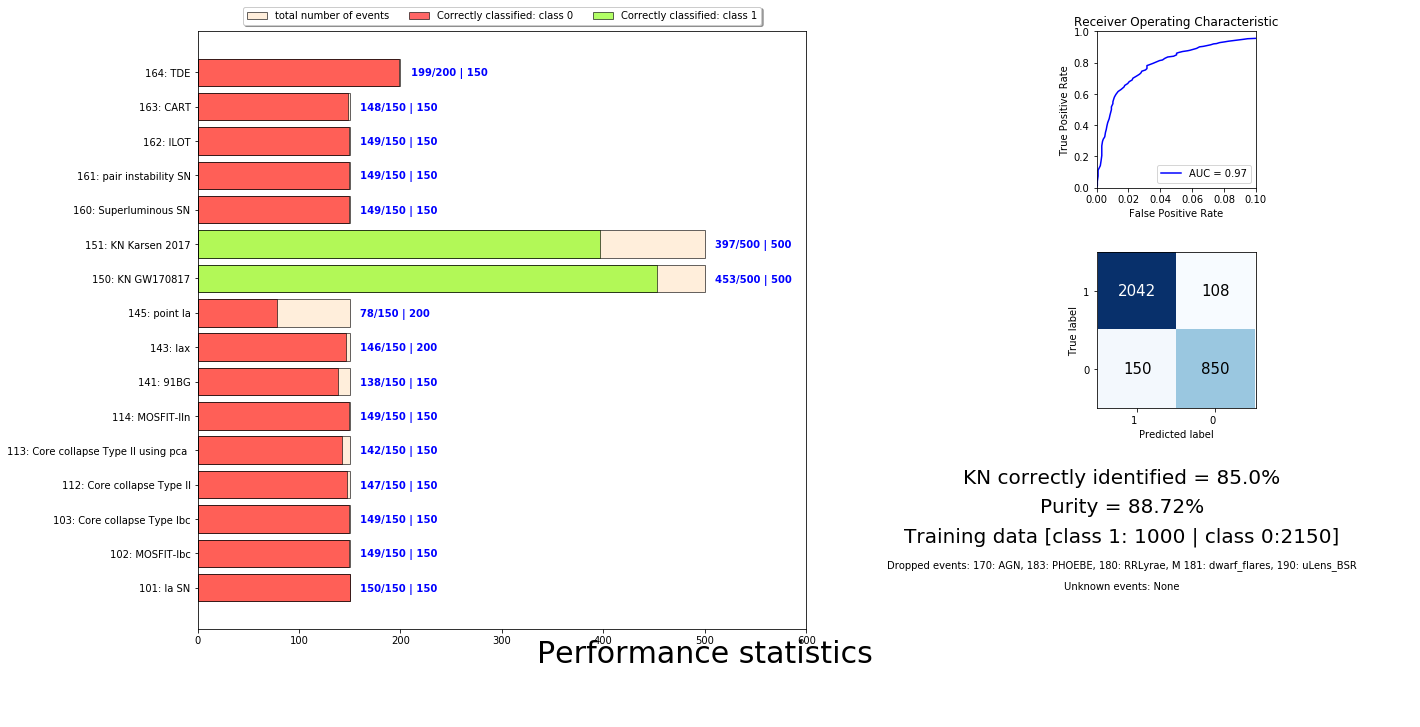

In [56]:
plt.close()
fig = plt.figure(figsize=(24,12))
#plt.subplot2grid((12,25), (0,0), colspan=25, rowspan=1, fig = fig)
#plt.title("performance statistics", loc = "center")
plt.subplot2grid((12,24), (0,3), colspan=11, rowspan=11, fig = fig)
plot_contamination_statistics(df_stat=df_stat,ax=plt.gca())
plt.subplot2grid((12,24),(0,19), rowspan=3, colspan=3, fig=fig)
plot_roc_curve(fpr=fpr,tpr=tpr, roc_auc=roc_auc, ax=plt.gca())
plt.subplot2grid((12,24),(4,19), rowspan=3, colspan=3, fig=fig)
plot_confusion_matrix(ax = plt.gca(), y_true=y_test,y_pred=y_pred,classes=['KN','NON-KN'])
cm = metrics.confusion_matrix(y_test,y_pred)
plt.annotate('KN correctly identified = '+str(100*cm[1][1]/(cm[1][0]+cm[1][1]))[:5]+"%",
            xy=(.79, .355), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=20)
plt.annotate('Purity = '+str(100*cm[1][1]/(cm[0][1]+cm[1][1]))[:5]+"%",
            xy=(.79, .315), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=20)
plt.annotate('Training data [class 1: '+ str(np.sum(df_stat[prediction_type].loc[1].values)) + " | class 0:"
             +str(np.sum(df_stat.loc[1].values)-np.sum(df_stat[prediction_type].loc[1].values))+"]",
            xy=(.79, .275), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=20)
#plt.annotate("Num trees ="+, )
plt.annotate('Performance statistics ',
            xy=(.5, .1), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center',
            fontsize=30)
unknown_events, dropped_events = get_ignored_events(sample_numbers_train, sample_numbers_test)
plt.annotate('Dropped events: '+dropped_events,
            xy=(.79, .23), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=10)
plt.annotate('Unknown events: '+unknown_events,
            xy=(.79, .20), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=10)
fig.tight_layout()
fig.savefig('Final_Results/case7')
plt.show()

### 91BG from S. Gonzalez-Gaitan and Felipe Lagos
141
### Iax from Saurabh
143
### pointIa
145
### - - - - - -  GW counterpart models - - - - - - - 
### Kilonova from GW170817
150
### Kilonova models from Kasen 2017
151
### - - - - - - - - - - - - - - - - - - - - - - - -
### Superluminous SN:  SLSN-I
160
### pair instability SN: PISN
161
### Intermediate Luminosity Optical Transients (ILOT)
162
### Ca Rich Transients (CART)
163 
### TDE
164
### - - - - - AGN - - - - - - 
170  
### - -- - - - - - - - - - - - - - - - - - - - - -
### Galactic transients
180  
181  
183  
190  
191
192
# - - - - - -
SNe
## MOSFIT-IIn  (4->14 on May 9 2018)
114 
### MOSFIT-Ibc (3->13 on May 9 2018)
113 
### Core collapse Type II using pca (5->12 on May 9 2018)
112
## - - - - - - - - - - - - - - - - - - - - - - - - - 
### Core collapse Type II from K10 templates
102
### Core collapse Type Ibc from K10 templates
103 
## Type Ia SN
101


BATCH_INFO:  sbatch  $SBATCH_TEMPLATES/SBATCH_sandyb.TEMPLATE 40
BATCH_MEM: 2000  # need more memory for som SIMSED models
PATH_SNDATA_SIM:  $SCRATCH_SIMDIR
# 91BG from S. Gonzalez-Gaitan and Felipe Lagos
#  (more templates than J17, and stretch-color correlation)
GENVERSION: ZTF_MSIP_MODEL41
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_91bg.INPUT
GENOPT: GENTYPE 41
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 4000

GENVERSION: ZTF_MSIP_MODEL43
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_Iax.INPUT
GENOPT: GENTYPE 43
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 10000
----------------- pointIa -----------------------
GENVERSION:  ZTF_MSIP_MODEL45
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_pointIa.INPUT
GENOPT: GENTYPE 45
GENOPT: NGENTOT_LC 100000
# - - - - - -  GW counterpart models - - - - - - - 
# Kilonova from GW170817
GENVERSION:  ZTF_MSIP_MODEL50
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_KNova_GW170817.INPUT
GENOPT: GENTYPE 50
GENOPT: NGENTOT_LC 100000
# Kilonova models from Kasen 2017
GENVERSION:  ZTF_MSIP_MODEL51
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_KNova_Kasen2017.INPUT
GENOPT: GENTYPE 51
GENOPT: NGENTOT_LC 100000
# - - - - - - - - - - - - - - - - - - - - - - - -
# Superluminous SN:  SLSN-I
GENVERSION:  ZTF_MSIP_MODEL60
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_SLSN_MAGNETAR.INPUT
GENOPT: GENTYPE 60
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 200
# pair instability SN: PISN
GENVERSION:  ZTF_MSIP_MODEL61
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_PISN.INPUT
GENOPT: GENTYPE 61
GENOPT: SIMGEN_DUMP_PRESCALE 2
GENOPT: NGENTOT_LC 1000
# Intermediate Luminosity Optical Transients (ILOT)
GENVERSION:  ZTF_MSIP_MODEL62
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_ILOT.INPUT
GENOPT: GENTYPE 62
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 100000
# Ca Rich Transients (CART)
GENVERSION:  ZTF_MSIP_MODEL63
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_CART.INPUT
GENOPT: GENTYPE 63 
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 40000
# TDE
GENVERSION:  ZTF_MSIP_MODEL64
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_TDE.INPUT
GENOPT: GENTYPE 64
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 3000
# - - - - - AGN - - - - - - 
GENVERSION:  ZTF_MSIP_MODEL70
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_LSST-AGN.INPUT
GENOPT: GENTYPE 70   SIMLIB_NREPEAT 5
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 6000
# - -- - - - - - - - - - - - - - - - - - - - - -
# Galactic transients
GENVERSION:  ZTF_MSIP_MODEL80
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_RRLyrae.INPUT
GENOPT: GENTYPE 80   SIMLIB_NREPEAT 5
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 200
GENVERSION:  ZTF_MSIP_MODEL81
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_Mdwarf_flares.INPUT
GENOPT: GENTYPE 81   SIMLIB_NREPEAT 5
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 8000
GENVERSION:  ZTF_MSIP_MODEL83
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_PHOEBE.INPUT
GENOPT: GENTYPE 83   SIMLIB_NREPEAT 5
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 200
GENVERSION:  ZTF_MSIP_MODEL90
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_uLens_BSR.INPUT
GENOPT: GENTYPE 90   SIMLIB_NREPEAT 5
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 1000
GENVERSION:  ZTF_MSIP_MODEL91
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_uLens_Bachelet.INPUT
GENOPT: GENTYPE 91
GENOPT: NGENTOT_LC 250
GENVERSION:  ZTF_MSIP_MODEL92
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_uLens_STRING.INPUT
GENOPT: GENTYPE 92
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 1000
# - - - - - -
# do the BIG Supernova jobs last so that we get the
# smaller samples quickly
# MOSFIT-IIn  (4->14 on May 9 2018)
GENVERSION:  ZTF_MSIP_MODEL14
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_IIn.INPUT
GENOPT: GENTYPE 14  SIMLIB_NREPEAT 5
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 10000
# MOSFIT-Ibc (3->13 on May 9 2018)
GENVERSION:  ZTF_MSIP_MODEL13
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_Ibc.INPUT
GENOPT: GENTYPE 13   SIMLIB_NREPEAT 10
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 10000
# Core collapse Type II using pca (5->12 on May 9 2018)
GENVERSION: ZTF_MSIP_MODEL12
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_IIpca.INPUT
GENOPT: GENTYPE 12  SIMLIB_NREPEAT 10
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 10000
# - - - - - - - - - - - - - - - - - - - - - - - - - 
# legacy NON1ASED model based on 43 templates
# NON1ASED-II
# Core collapse Type II from K10 templates
GENVERSION: ZTF_MSIP_MODEL02
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_NON1ASED-II.INPUT
GENOPT: GENTYPE 2   SIMLIB_NREPEAT 10
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 10000
# NON1ASED-Ibc
# Core collapse Type Ibc from K10 templates
GENVERSION: ZTF_MSIP_MODEL03
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_NON1ASED-Ibc.INPUT
GENOPT: GENTYPE 3   SIMLIB_NREPEAT 10
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 10000
# - - - - - - - - 
# Type Ia SN
GENVERSION: ZTF_MSIP_MODEL01
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_SALT2.INPUT
GENOPT: GENTYPE 1
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 1000
ENDLIST_GENVERSION:
### GN - keep 
#GENOPT_GLOBAL: SIMLIB_FILE $LSST_ROOT/simlibs/minionv3_1016_WFD.simlib.COADD  SOLID_ANGLE 5.08  SEARCHEFF_zHOST_FILE $ZTF_USERS/gnarayan/SIMGEN/SEARCHEFF_zHOST_PLASTICC_WFD.DAT
RESET_CIDOFF: 2  # flag to generate unique CID for each model
# specify sim-input files for snlc_sim.exe
SIMGEN_INFILE_NONIa:    SIMGEN_TEMPLATE_ZTF.INPUT
#NGEN_UNIT:  0.025   SURVEY  
# define required global items to ensure uniformity among all jobs
H0:  70
##ZRANGE:       0.011  1.4
GENPREFIX:    ZTF_MSIP
FORMAT_MASK:  112     # 32=FITS, 16=RandomCID, 64=compact
# the same RANSEED-repeated means that each job has new seed,
# but that all jobs are re-combined as if only one job had run.
RANSEED_REPEAT: 40  3773459